In [1]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 16.50 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [2]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl
!pip install RegscorePy

/tmp/ipykernel_18350/707780074.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


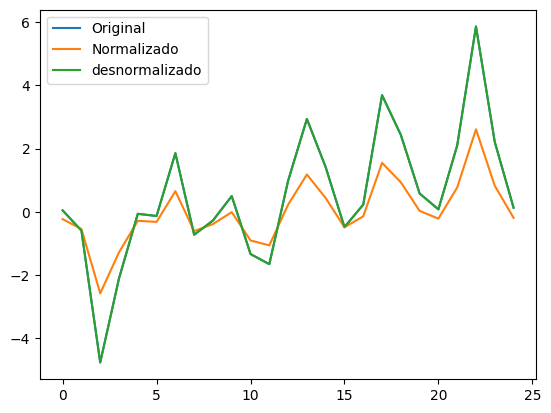

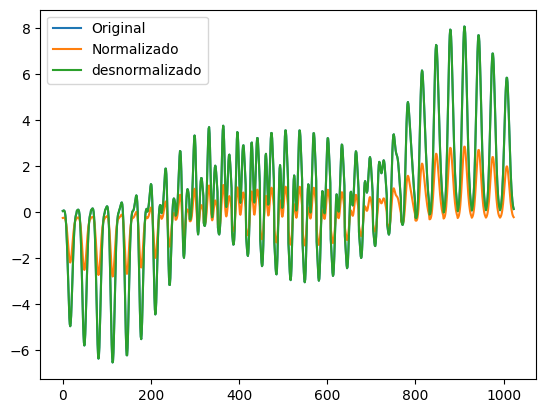

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def peaks(grid):
    x = np.linspace(-2, 2, grid)
    y = np.linspace(-2, 2, grid)
    x, y = np.meshgrid(x, y)
    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
    return x, y, z

def create_dataframe(grid):
   x, y, z = peaks(grid)
   data = {'X': x.flatten(), 'Y': y.flatten(), 'Z': z.flatten()}
   df = pd.DataFrame(data)
   return df

def show_norm(df, label="Peaks", plot=False):
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["Z"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()


df_25 = create_dataframe(grid=5)
df_25_norm = show_norm(df_25)
test_out_scaler(df_25)

df_1000 = create_dataframe(grid=32)
df_1000_norm = show_norm(df_1000)
test_out_scaler(df_1000)



In [4]:
def split_df(df):
    _input = np.vstack([df['X'], df['Y']]).T
    _output = np.array(df['Z'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-10-28 11:16:06.528226: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 11:16:06.530971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 11:16:06.532520: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 11:16:06.548788: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-28 11:16:08.614966: W tensorflow/compiler/tf2

In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output, sup_input, sup_output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(sup_input, sup_output)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
      self._sup = (sup_input, sup_output)

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          vt_pred = self.lm_model.predict(self.vt_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))    
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_vt = r2_score(vt_denorm,  vt_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'r2_vt': r2_vt,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mse_vt': mse_vt,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product

class Tester:
  def __init__(self, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input_25, self.output_25 = split_df(df_25_norm)
    self.input_1000, self.output_1000 = split_df(df_1000_norm)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input_25, self.output_25, self.input_1000, self.output_1000)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando com 25 dados


In [9]:
tester = Tester(run_times=25, dataset_run_times=10)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[15], [16], [17], [18], [19], [20], [21], [22], [23], [24]],
            regularizers=[0.2, 0.05],
            learning_rate=[0.01, 0.1])

Testando combinacao1: Hidden Size=[15], regularizer=0.2, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_7_21  0.939087  0.773309  0.572588 -1.022965  0.615039  0.407325   
model_1_7_20  0.938656  0.773053  0.579442 -1.034398  0.617208  0.410209   
model_1_7_19  0.938206  0.772782  0.586224 -1.046335  0.619298  0.413218   
model_1_7_18  0.937737  0.772495  0.592929 -1.058789  0.621304  0.416355   
model_1_7_17  0.937248  0.772192  0.599552 -1.071774  0.623224  0.419625   
model_1_7_16  0.936738  0.771873  0.606093 -1.085303  0.625055  0.423030   
model_1_7_15  0.936209  0.771536  0.612545 -1.099381  0.626794  0.426573   
model_1_7_14  0.935657  0.771182  0.618905 -1.114031  0.628439  0.430259   
model_1_7_13  0.935085  0.770811  0.625168 -1.129254  0.629985  0.434090   
model_1_7_12  0.934489  0.770421  0.631331 -1.145065  0.631431  0.438070   
model_1_7_11  0.933871  0.770012  0.637388 -1.161482  0.632772  0.442203   
model_1_7_10  0.933230  0.769585  0.643337 -1.178508  0.634007  0.446492   
model_1_7_9   0.932565  0.769137  0.649171 -1.196160  0.635130  0.450941   
model_1_7_8   0.931875  0.768670  0.654887 -1.214455  0.636140  0.455554   
model_1_7_7   0.931160  0.768182  0.660480 -1.233399  0.637032  0.460334   
model_1_7_6   0.930419  0.767673  0.665944 -1.253006  0.637805  0.465286   
model_1_7_5   0.929652  0.767143  0.671277 -1.273295  0.638453  0.470415   
model_1_7_4   0.928859  0.766591  0.676470 -1.294267  0.638973  0.475723   
model_1_7_3   0.928037  0.766016  0.681521 -1.315939  0.639363  0.481214   
model_1_7_2   0.927188  0.765418  0.686423 -1.338334  0.639617  0.486895   
model_1_7_1   0.926310  0.764796  0.691173 -1.361456  0.639733  0.492767   
model_1_7_0   0.925402  0.764151  0.695762 -1.385319  0.639706  0.498837   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_7_21  1.515886  0.675193  0.622192  0.648693  1.832529  0.638221   
model_1_7_20  1.517597  0.664366  0.625709  0.645037  1.850991  0.640476   
model_1_7_19  1.519409  0.653652  0.629380  0.641516  1.869647  0.642820   
model_1_7_18  1.521327  0.643060  0.633211  0.638135  1.888487  0.645256   
model_1_7_17  1.523353  0.632596  0.637204  0.634900  1.907523  0.647785   
model_1_7_16  1.525489  0.622265  0.641365  0.631815  1.926753  0.650408   
model_1_7_15  1.527739  0.612071  0.645695  0.628883  1.946175  0.653126   
model_1_7_14  1.530105  0.602024  0.650201  0.626113  1.965799  0.655941   
model_1_7_13  1.532590  0.592131  0.654883  0.623507  1.985619  0.658855   
model_1_7_12  1.535197  0.582395  0.659746  0.621071  2.005644  0.661869   
model_1_7_11  1.537928  0.572827  0.664795  0.618811  2.025870  0.664983   
model_1_7_10  1.540788  0.563429  0.670032  0.616730  2.046302  0.668200   
model_1_7_9   1.543779  0.554212  0.675461  0.614837  2.066941  0.671521   
model_1_7_8   1.546904  0.545184  0.681088  0.613136  2.087791  0.674947   
model_1_7_7   1.550166  0.536348  0.686915  0.611631  2.108852  0.678479   
model_1_7_6   1.553569  0.527715  0.692945  0.610330  2.130127  0.682119   
model_1_7_5   1.557115  0.519292  0.699185  0.609239  2.151616  0.685868   
model_1_7_4   1.560809  0.511087  0.705635  0.608362  2.173325  0.689726   
model_1_7_3   1.564653  0.503108  0.712301  0.607705  2.195251  0.693696   
model_1_7_2   1.568651  0.495364  0.719189  0.607277  2.217400  0.697778   
model_1_7_1   1.572807  0.487862  0.726300  0.607081  2.239775  0.701974   
model_1_7_0   1.577124  0.480612  0.733640  0.607126  2.262375  0.706284   

                r2_adj       rsd         aic         bic  
model_1_7_21  1.039511  0.665391  123.796285  198.147711  
model_1_7_20  1.039791  0.667742  123.782177  198.133603  
model_1_7_19  1.040083  0.670186  123.767560  198.118986  
model_1_7_18  1.040387  0.672726  123.752433  198.103858  
model_1_7_17  1.040704  0.675362  123.736787  198.088212  
model_1_7_16  1.041035  0.678097  123.720622  198.072047  
model_1_7_15  1.041378  0.680931  123.703942  198.055368  
model_1_7_14  1.041736  0.683866  123.686735  198.

DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_8_24  0.955354  0.779436  0.989581  0.870760  0.961069  0.298546   
model_1_8_23  0.955025  0.779380  0.989501  0.873075  0.961588  0.300750   
model_1_8_22  0.954673  0.779311  0.989387  0.875383  0.962084  0.303101   
model_1_8_21  0.954299  0.779228  0.989239  0.877682  0.962554  0.305604   
model_1_8_20  0.953902  0.779131  0.989056  0.879972  0.962998  0.308260   
model_1_8_19  0.953481  0.779021  0.988837  0.882250  0.963416  0.311076   
model_1_8_18  0.953035  0.778896  0.988581  0.884516  0.963807  0.314054   
model_1_8_17  0.952565  0.778756  0.988289  0.886769  0.964169  0.317199   
model_1_8_16  0.952069  0.778601  0.987958  0.889007  0.964502  0.320514   
model_1_8_15  0.951547  0.778431  0.987588  0.891229  0.964806  0.324005   
model_1_8_14  0.950998  0.778246  0.987179  0.893434  0.965079  0.327675   
model_1_8_13  0.950422  0.778044  0.986730  0.895620  0.965320  0.331527   
model_1_8_12  0.949818  0.777826  0.986240  0.897786  0.965529  0.335568   
model_1_8_11  0.949185  0.777591  0.985708  0.899930  0.965705  0.339801   
model_1_8_10  0.948523  0.777339  0.985134  0.902051  0.965847  0.344230   
model_1_8_9   0.947830  0.777069  0.984516  0.904147  0.965954  0.348861   
model_1_8_8   0.947107  0.776781  0.983855  0.906216  0.966025  0.353697   
model_1_8_7   0.946352  0.776475  0.983149  0.908257  0.966060  0.358744   
model_1_8_6   0.945565  0.776151  0.982397  0.910268  0.966056  0.364006   
model_1_8_5   0.944745  0.775806  0.981600  0.912246  0.966014  0.369490   
model_1_8_4   0.943891  0.775443  0.980755  0.914191  0.965932  0.375199   
model_1_8_3   0.943003  0.775058  0.979863  0.916098  0.965809  0.381139   
model_1_8_2   0.942079  0.774653  0.978922  0.917967  0.965645  0.387316   
model_1_8_1   0.941119  0.774227  0.977933  0.919795  0.965437  0.393735   
model_1_8_0   0.940122  0.773779  0.976893  0.921580  0.965185  0.400403   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_8_24  1.474912  0.127788  0.588299  0.358044  1.440990  0.546394   
model_1_8_23  1.475288  0.128772  0.577759  0.353266  1.447499  0.548407   
model_1_8_22  1.475751  0.130166  0.567253  0.348710  1.454097  0.550546   
model_1_8_21  1.476305  0.131982  0.556787  0.344384  1.466263  0.552814   
model_1_8_20  1.476950  0.134228  0.546365  0.340296  1.481329  0.555212   
model_1_8_19  1.477690  0.136912  0.535994  0.336453  1.496722  0.557742   
model_1_8_18  1.478525  0.140045  0.525679  0.332862  1.512349  0.560405   
model_1_8_17  1.479459  0.143635  0.515424  0.329530  1.528085  0.563204   
model_1_8_16  1.480493  0.147691  0.505236  0.326464  1.543926  0.566140   
model_1_8_15  1.481630  0.152223  0.495122  0.323673  1.559872  0.569214   
model_1_8_14  1.482872  0.157239  0.485086  0.321163  1.575919  0.572429   
model_1_8_13  1.484221  0.162748  0.475136  0.318942  1.592074  0.575784   
model_1_8_12  1.485680  0.168761  0.465277  0.317019  1.608334  0.579283   
model_1_8_11  1.487251  0.175284  0.455518  0.315401  1.624690  0.582924   
model_1_8_10  1.488937  0.182328  0.445863  0.314096  1.641150  0.586711   
model_1_8_9   1.490740  0.189902  0.436322  0.313112  1.657718  0.590644   
model_1_8_8   1.492664  0.198015  0.426903  0.312459  1.674384  0.594724   
model_1_8_7   1.494710  0.206673  0.417612  0.312142  1.691154  0.598952   
model_1_8_6   1.496882  0.215890  0.408459  0.312174  1.708026  0.603329   
model_1_8_5   1.499184  0.225672  0.399453  0.312563  1.725000  0.607856   
model_1_8_4   1.501617  0.236029  0.390603  0.313316  1.742074  0.612535   
model_1_8_3   1.504185  0.246971  0.381919  0.314445  1.759252  0.617364   
model_1_8_2   1.506893  0.258508  0.373410  0.315959  1.777003  0.622347   
model_1_8_1   1.509743  0.270649  0.365090  0.317869  1.795388  0.627483   
model_1_8_0   1.512740  0.283405  0.356968  0.320186  1.813898  0.632774   

                r2_adj       rsd         aic         bic  
model_1

DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_9_3   0.956912  0.779595  0.103772  0.948288  0.899889  0.288132   
model_1_9_2   0.956562  0.779590  0.118360  0.948258  0.900747  0.290468   
model_1_9_4   0.957236  0.779579  0.088325  0.948281  0.898946  0.285965   
model_1_9_1   0.956187  0.779562  0.132049  0.948190  0.901516  0.292980   
model_1_9_5   0.957535  0.779541  0.072038  0.948237  0.897920  0.283965   
model_1_9_0   0.955784  0.779511  0.144818  0.948083  0.902196  0.295671   
model_1_9_6   0.957810  0.779483  0.054944  0.948157  0.896813  0.282128   
model_1_9_7   0.958061  0.779404  0.037060  0.948043  0.895627  0.280449   
model_1_9_8   0.958289  0.779306  0.018424  0.947893  0.894365  0.278925   
model_1_9_9   0.958494  0.779189 -0.000946  0.947710  0.893028  0.277551   
model_1_9_10  0.958677  0.779053 -0.021024  0.947495  0.891620  0.276324   
model_1_9_11  0.958840  0.778899 -0.041786  0.947247  0.890141  0.275240   
model_1_9_12  0.958981  0.778728 -0.063207  0.946967  0.888595  0.274295   
model_1_9_13  0.959102  0.778539 -0.085265  0.946657  0.886983  0.273487   
model_1_9_14  0.959203  0.778334 -0.107935  0.946317  0.885308  0.272810   
model_1_9_15  0.959285  0.778113 -0.131200  0.945948  0.883570  0.272262   
model_1_9_16  0.959348  0.777876 -0.155034  0.945550  0.881773  0.271839   
model_1_9_17  0.959393  0.777624 -0.179419  0.945124  0.879918  0.271538   
model_1_9_18  0.959420  0.777357 -0.204333  0.944671  0.878006  0.271356   
model_1_9_19  0.959430  0.777076 -0.229756  0.944192  0.876040  0.271290   
model_1_9_20  0.959423  0.776781 -0.255670  0.943687  0.874022  0.271336   
model_1_9_21  0.959400  0.776473 -0.282051  0.943157  0.871953  0.271490   
model_1_9_22  0.959361  0.776151 -0.308887  0.942602  0.869835  0.271752   
model_1_9_23  0.959307  0.775817 -0.336154  0.942024  0.867670  0.272116   
model_1_9_24  0.959237  0.775471 -0.363843  0.941422  0.865459  0.272581   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_9_3   1.473849  0.412007  0.347013  0.379510  1.303117  0.536779   
model_1_9_2   1.473886  0.405301  0.347216  0.376259  1.337342  0.538951   
model_1_9_4   1.473958  0.419108  0.347062  0.383085  1.269064  0.534757   
model_1_9_1   1.474072  0.399008  0.347674  0.373341  1.371731  0.541276   
model_1_9_5   1.474210  0.426596  0.347355  0.386975  1.235187  0.532884   
model_1_9_0   1.474413  0.393138  0.348393  0.370765  1.406283  0.543757   
model_1_9_6   1.474601  0.434454  0.347891  0.391173  1.201496  0.531157   
model_1_9_7   1.475126  0.442675  0.348661  0.395668  1.167984  0.529575   
model_1_9_8   1.475782  0.451242  0.349663  0.400453  1.134669  0.528133   
model_1_9_9   1.476566  0.460147  0.350890  0.405519  1.101544  0.526831   
model_1_9_10  1.477475  0.469377  0.352338  0.410858  1.068619  0.525665   
model_1_9_11  1.478504  0.478922  0.354002  0.416462  1.035897  0.524633   
model_1_9_12  1.479650  0.488770  0.355877  0.422323  1.003375  0.523732   
model_1_9_13  1.480911  0.498910  0.357958  0.428434  0.971063  0.522959   
model_1_9_14  1.482282  0.509332  0.360240  0.434786  0.938964  0.522312   
model_1_9_15  1.483761  0.520027  0.362718  0.441372  0.907073  0.521787   
model_1_9_16  1.485345  0.530984  0.365388  0.448186  0.875399  0.521382   
model_1_9_17  1.487030  0.542194  0.368245  0.455219  0.843941  0.521093   
model_1_9_18  1.488814  0.553647  0.371284  0.462466  0.812701  0.520919   
model_1_9_19  1.490694  0.565334  0.374501  0.469917  0.781685  0.520855   
model_1_9_20  1.492666  0.577247  0.377890  0.477569  0.750886  0.520899   
model_1_9_21  1.494729  0.589375  0.381449  0.485412  0.720312  0.521047   
model_1_9_22  1.496878  0.601712  0.385170  0.493441  0.689966  0.521298   
model_1_9_23  1.499113  0.614247  0.389052  0.501649  0.659841  0.521648   
model_1_9_24  1.501430  0.626975  0.393089  0.510032  0.677907  0.522093   

                r2_adj       rsd         aic         bic  
model_1

DataFrame salvo em ../results/metrics_1_9
Testando combinacao2: Hidden Size=[15], regularizer=0.2, learning_rate=0.1
+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=========

2024-10-28 13:21:50.097408: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_0] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] |

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_3_7   0.930783  0.831028  0.210711  0.635395  0.414660  0.462858   
model_2_3_6   0.930518  0.831022  0.202034  0.646883  0.414198  0.464626   
model_2_3_8   0.930973  0.830990  0.218265  0.624781  0.414827  0.461585   
model_2_3_5   0.930161  0.830957  0.192071  0.659281  0.413361  0.467014   
model_2_3_9   0.931104  0.830919  0.224843  0.615001  0.414765  0.460707   
model_2_3_10  0.931189  0.830824  0.230577  0.606011  0.414531  0.460138   
model_2_3_4   0.929689  0.830814  0.180639  0.672617  0.412058  0.470168   
model_2_3_11  0.931238  0.830714  0.235577  0.597763  0.414170  0.459811   
model_2_3_12  0.931260  0.830593  0.239943  0.590213  0.413721  0.459668   
model_2_3_3   0.929077  0.830571  0.167538  0.686910  0.410184  0.474264   
model_2_3_13  0.931260  0.830468  0.243760  0.583313  0.413212  0.459664   
model_2_3_14  0.931245  0.830341  0.247101  0.577015  0.412668  0.459764   
model_2_3_15  0.931219  0.830215  0.250030  0.571275  0.412106  0.459939   
model_2_3_2   0.928292  0.830203  0.152555  0.702160  0.407617  0.479509   
model_2_3_16  0.931185  0.830092  0.252602  0.566051  0.411543  0.460166   
model_2_3_1   0.927299  0.829677  0.135464  0.718350  0.404225  0.486149   
model_2_3_0   0.926055  0.828953  0.116038  0.735433  0.399861  0.494469   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_3_7   1.129914  2.169703  0.685434  1.427568  0.266866  0.680336   
model_2_3_6   1.129955  2.193554  0.663837  1.428696  0.279319  0.681635   
model_2_3_8   1.130171  2.148936  0.705387  1.427162  0.255434  0.679401   
model_2_3_5   1.130395  2.220943  0.640529  1.430736  0.292849  0.683384   
model_2_3_9   1.130648  2.130853  0.723773  1.427313  0.247606  0.678754   
model_2_3_10  1.131281  2.115091  0.740674  1.427882  0.244592  0.678335   
model_2_3_4   1.131350  2.252369  0.615458  1.433913  0.307504  0.685688   
model_2_3_11  1.132020  2.101348  0.756178  1.428763  0.242517  0.678094   
model_2_3_12  1.132824  2.089346  0.770372  1.429859  0.241682  0.677988   
model_2_3_3   1.132970  2.288383  0.588588  1.438486  0.323311  0.688668   
model_2_3_13  1.133663  2.078853  0.783345  1.431099  0.240913  0.677985   
model_2_3_14  1.134513  2.069669  0.795184  1.432426  0.240224  0.678059   
model_2_3_15  1.135355  2.061618  0.805974  1.433796  0.239591  0.678188   
model_2_3_2   1.135431  2.329570  0.559919  1.444745  0.340288  0.692466   
model_2_3_16  1.136178  2.054546  0.815795  1.435170  0.239019  0.678355   
model_2_3_1   1.138950  2.376552  0.529482  1.453017  0.358428  0.697244   
model_2_3_0   1.143793  2.429952  0.497369  1.463661  0.377689  0.703185   

                r2_adj       rsd         aic         bic  
model_2_3_7   1.044898  0.709300  123.540672  197.892097  
model_2_3_6   1.045069  0.710653  123.533045  197.884471  
model_2_3_8   1.044774  0.708324  123.546177  197.897602  
model_2_3_5   1.045301  0.712477  123.522794  197.874219  
model_2_3_9   1.044689  0.707650  123.549984  197.901410  
model_2_3_10  1.044634  0.707213  123.552457  197.903882  
model_2_3_4   1.045607  0.714879  123.509332  197.860757  
model_2_3_11  1.044602  0.706961  123.553880  197.905305  
model_2_3_12  1.044588  0.706851  123.554503  197.905928  
model_2_3_3   1.046004  0.717986  123.491983  197.843409  
model_2_3_13  1.044588  0.706848  123.554519  197.905944  
model_2_3_14  1.044598  0.706925  123.554083  197.905509  
model_2_3_15  1.044615  0.707060  123.553321  197.904747  
model_2_3_2   1.046513  0.721946  123.469985  197.821410  
model_2_3_16  1.044637  0.707234  123.552337  197.903762  
model_2_3_1   1.047157  0.726927  123.442481  197.793906  
model_2_3_0   1.047964  0.733121  123.408543  197.759968

DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_4_0   0.937914  0.829762 -0.292009  0.998690  0.886997  0.415171   
model_2_4_1   0.942040  0.827494 -0.346386  0.994233  0.878221  0.387576   
model_2_4_2   0.944101  0.823760 -0.412566  0.987225  0.866093  0.373799   
model_2_4_3   0.944537  0.818943 -0.487655  0.978295  0.851439  0.370884   
model_2_4_4   0.943716  0.813359 -0.569303  0.967991  0.834962  0.376373   
model_2_4_5   0.941944  0.807267 -0.655528  0.956786  0.817266  0.388224   
model_2_4_6   0.939474  0.800882 -0.744627  0.945084  0.798866  0.404736   
model_2_4_7   0.936517  0.794379 -0.835076  0.933216  0.780199  0.424509   
model_2_4_8   0.933243  0.787896 -0.925539  0.921444  0.761619  0.446403   
model_2_4_9   0.929788  0.781540 -1.014865  0.909970  0.743408  0.469507   
model_2_4_10  0.926260  0.775391 -1.102079  0.898937  0.725784  0.493102   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_4_0   1.138384  1.187455  0.012709  0.600082  0.378107  0.644338   
model_2_4_1   1.153550  1.237431  0.055940  0.646685  0.524707  0.622556   
model_2_4_2   1.178518  1.298256  0.123926  0.711091  0.668692  0.611391   
model_2_4_3   1.210726  1.367269  0.210551  0.788910  0.807923  0.609002   
model_2_4_4   1.248069  1.442309  0.310510  0.876409  0.940662  0.613493   
model_2_4_5   1.288806  1.521557  0.419205  0.970381  1.065523  0.623076   
model_2_4_6   1.331502  1.603445  0.532727  1.068086  1.181592  0.636189   
model_2_4_7   1.374990  1.686575  0.647858  1.167217  1.288413  0.651544   
model_2_4_8   1.418342  1.769718  0.762047  1.265883  1.385911  0.668134   
model_2_4_9   1.460844  1.851815  0.873360  1.362587  1.474331  0.685206   
model_2_4_10  1.501958  1.931971  0.980386  1.456179  1.554116  0.702212   

                r2_adj       rsd         aic         bic  
model_2_4_0   1.040272  0.671769  123.758128  198.109554  
model_2_4_1   1.037595  0.649059  123.895688  198.247114  
model_2_4_2   1.036259  0.637419  123.968075  198.319500  
model_2_4_3   1.035976  0.634929  123.983734  198.335159  
model_2_4_4   1.036509  0.639610  123.954347  198.305772  
model_2_4_5   1.037658  0.649602  123.892346  198.243771  
model_2_4_6   1.039260  0.663273  123.809038  198.160463  
model_2_4_7   1.041178  0.679281  123.713643  198.065068  
model_2_4_8   1.043302  0.696578  123.613066  197.964492  
model_2_4_9   1.045543  0.714376  123.512146  197.863571  
model_2_4_10  1.047832  0.732107  123.414077  197.765502

DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_5_1   0.959189  0.782252  0.564459  0.914342  0.787661  0.272906   
model_2_5_0   0.958304  0.782155  0.593192  0.921956  0.802654  0.278820   
model_2_5_2   0.959643  0.781955  0.537570  0.907096  0.773571  0.269865   
model_2_5_3   0.959777  0.781379  0.512556  0.900249  0.760409  0.268971   
model_2_5_4   0.959674  0.780610  0.489394  0.893816  0.748176  0.269658   
model_2_5_5   0.959401  0.779717  0.468029  0.887804  0.736852  0.271483   
model_2_5_6   0.959010  0.778750  0.448385  0.882209  0.726407  0.274102   
model_2_5_7   0.958539  0.777749  0.430369  0.877023  0.716800  0.277252   
model_2_5_8   0.958019  0.776741  0.413886  0.872231  0.707987  0.280727   
model_2_5_9   0.957473  0.775748  0.398831  0.867818  0.699920  0.284375   
model_2_5_10  0.956920  0.774785  0.385107  0.863764  0.692549  0.288079   
model_2_5_11  0.956370  0.773862  0.372612  0.860047  0.685826  0.291754   
model_2_5_12  0.955834  0.772986  0.361249  0.856647  0.679702  0.295339   
model_2_5_13  0.955318  0.772160  0.350929  0.853543  0.674132  0.298789   
model_2_5_14  0.954826  0.771388  0.341564  0.850711  0.669070  0.302077   
model_2_5_15  0.954362  0.770668  0.333075  0.848134  0.664476  0.305183   
model_2_5_16  0.953926  0.770001  0.325383  0.845790  0.660310  0.308098   
model_2_5_17  0.953519  0.769385  0.318421  0.843660  0.656534  0.310819   
model_2_5_18  0.953141  0.768818  0.312122  0.841728  0.653115  0.313346   
model_2_5_19  0.952791  0.768297  0.306425  0.839975  0.650022  0.315683   
model_2_5_20  0.952469  0.767819  0.301277  0.838387  0.647223  0.317840   
model_2_5_21  0.952173  0.767383  0.296625  0.836950  0.644693  0.319821   
model_2_5_22  0.951901  0.766985  0.292425  0.835650  0.642407  0.321639   
model_2_5_23  0.951652  0.766622  0.288633  0.834473  0.640343  0.323302   
model_2_5_24  0.951425  0.766292  0.285210  0.833410  0.638479  0.324822   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_5_1   1.456083  0.949344  0.240669  0.595006  2.993431  0.522404   
model_2_5_0   1.456729  0.886715  0.219275  0.552995  2.932582  0.528034   
model_2_5_2   1.458067  1.007953  0.261027  0.634490  3.047917  0.519486   
model_2_5_3   1.461922  1.062477  0.280266  0.671371  3.096595  0.518624   
model_2_5_4   1.467061  1.112962  0.298339  0.705651  3.140037  0.519286   
model_2_5_5   1.473034  1.159531  0.315233  0.737382  3.178785  0.521040   
model_2_5_6   1.479498  1.202349  0.330952  0.766651  3.213337  0.523548   
model_2_5_7   1.486196  1.241619  0.345523  0.793571  3.244160  0.526547   
model_2_5_8   1.492935  1.277547  0.358985  0.818266  3.271657  0.529837   
model_2_5_9   1.499575  1.310361  0.371384  0.840872  3.296209  0.533268   
model_2_5_10  1.506015  1.340276  0.382776  0.861526  3.318134  0.536730   
model_2_5_11  1.512187  1.367512  0.393218  0.880365  3.337725  0.540143   
model_2_5_12  1.518046  1.392278  0.402771  0.897524  3.355244  0.543451   
model_2_5_13  1.523566  1.414772  0.411494  0.913133  3.370920  0.546616   
model_2_5_14  1.528732  1.435186  0.419449  0.927318  3.384953  0.549616   
model_2_5_15  1.533543  1.453689  0.426692  0.940190  3.397515  0.552434   
model_2_5_16  1.538004  1.470455  0.433278  0.951866  3.408775  0.555066   
model_2_5_17  1.542124  1.485630  0.439260  0.962445  3.418863  0.557511   
model_2_5_18  1.545918  1.499361  0.444690  0.972026  3.427908  0.559773   
model_2_5_19  1.549401  1.511777  0.449613  0.980695  3.436024  0.561857   
model_2_5_20  1.552592  1.522999  0.454076  0.988537  3.443307  0.563773   
model_2_5_21  1.555509  1.533138  0.458113  0.995626  3.449841  0.565528   
model_2_5_22  1.558172  1.542294  0.461767  1.002031  3.455707  0.567132   
model_2_5_23  1.560598  1.550559  0.465073  1.007816  3.460976  0.568597   
model_2_5_24  1.562805  1.558020  0.468061  1.013040  3.465710  0.569931   

                r2_adj       rsd         aic         bic  
model_2

DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_6_11  0.968431  0.810646  0.509906  0.975910  0.928393  0.211102   
model_2_6_10  0.968994  0.810646  0.520228  0.976685  0.930113  0.207338   
model_2_6_12  0.967904  0.810625  0.500557  0.975205  0.926833  0.214629   
model_2_6_9   0.969590  0.810616  0.531609  0.977536  0.932006  0.203353   
model_2_6_13  0.967412  0.810588  0.492097  0.974566  0.925420  0.217916   
model_2_6_8   0.970215  0.810547  0.544136  0.978469  0.934087  0.199171   
model_2_6_14  0.966956  0.810542  0.484450  0.973987  0.924141  0.220963   
model_2_6_15  0.966535  0.810489  0.477540  0.973462  0.922985  0.223778   
model_2_6_16  0.966148  0.810432  0.471301  0.972988  0.921941  0.226368   
model_2_6_7   0.970864  0.810425  0.557898  0.979488  0.936369  0.194833   
model_2_6_17  0.965793  0.810373  0.465672  0.972559  0.920998  0.228745   
model_2_6_18  0.965467  0.810315  0.460594  0.972172  0.920147  0.230922   
model_2_6_19  0.965170  0.810257  0.456014  0.971822  0.919380  0.232910   
model_2_6_6   0.971526  0.810233  0.572978  0.980597  0.938864  0.190403   
model_2_6_20  0.964899  0.810202  0.451887  0.971507  0.918688  0.234723   
model_2_6_21  0.964652  0.810148  0.448167  0.971222  0.918064  0.236374   
model_2_6_22  0.964427  0.810098  0.444814  0.970965  0.917501  0.237875   
model_2_6_23  0.964223  0.810050  0.441794  0.970734  0.916994  0.239238   
model_2_6_24  0.964038  0.810006  0.439073  0.970526  0.916538  0.240475   
model_2_6_5   0.972189  0.809950  0.589452  0.981801  0.941583  0.185972   
model_2_6_4   0.972833  0.809550  0.607379  0.983101  0.944534  0.181667   
model_2_6_3   0.973431  0.808997  0.626789  0.984497  0.947720  0.177667   
model_2_6_2   0.973948  0.808248  0.647672  0.985985  0.951136  0.174210   
model_2_6_1   0.974335  0.807249  0.669956  0.987558  0.954771  0.171619   
model_2_6_0   0.974529  0.805930  0.693479  0.989204  0.958595  0.170323   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_6_11  1.266212  0.944829  0.342900  0.643865  1.311697  0.459458   
model_2_6_10  1.266213  0.924930  0.331866  0.628398  1.350045  0.455344   
model_2_6_12  1.266353  0.962854  0.352927  0.657891  1.277097  0.463281   
model_2_6_9   1.266411  0.902991  0.319751  0.611371  1.392535  0.450947   
model_2_6_13  1.266596  0.979163  0.362027  0.670595  1.245881  0.466814   
model_2_6_8   1.266874  0.878840  0.306478  0.592659  1.439608  0.446285   
model_2_6_14  1.266907  0.993906  0.370275  0.682090  1.217729  0.470067   
model_2_6_15  1.267262  1.007227  0.377741  0.692484  1.192340  0.473052   
model_2_6_16  1.267642  1.019254  0.384494  0.701874  1.169450  0.475782   
model_2_6_7   1.267691  0.852309  0.291974  0.572141  1.491746  0.441399   
model_2_6_17  1.268034  1.030107  0.390596  0.710352  1.148813  0.478273   
model_2_6_18  1.268426  1.039897  0.396109  0.718003  1.130213  0.480543   
model_2_6_19  1.268811  1.048725  0.401084  0.724905  1.113448  0.482607   
model_2_6_6   1.268973  0.823236  0.276177  0.549707  1.549482  0.436352   
model_2_6_20  1.269183  1.056682  0.405575  0.731129  1.098343  0.484482   
model_2_6_21  1.269539  1.063855  0.409625  0.736740  1.084731  0.486183   
model_2_6_22  1.269877  1.070318  0.413276  0.741797  1.072470  0.487724   
model_2_6_23  1.270194  1.076140  0.416568  0.746354  1.061422  0.489120   
model_2_6_24  1.270491  1.081386  0.419534  0.750460  1.051471  0.490383   
model_2_6_5   1.270863  0.791477  0.259040  0.525258  1.613414  0.431245   
model_2_6_4   1.273542  0.756917  0.240534  0.498726  1.684188  0.426224   
model_2_6_3   1.277239  0.719497  0.220668  0.470083  1.762538  0.421505   
model_2_6_2   1.282244  0.679237  0.199486  0.439362  1.849276  0.417384   
model_2_6_1   1.288925  0.636277  0.177093  0.406685  1.945311  0.414269   
model_2_6_0   1.297747  0.590928  0.153666  0.372297  2.051676  0.412702   

                r2_adj       rsd         aic         bic  
model_2

DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_7_5   0.969705  0.813362  0.941055  0.738916  0.786046  0.202580   
model_2_7_4   0.969520  0.813361  0.944556  0.745771  0.792058  0.203822   
model_2_7_6   0.969737  0.813258  0.937343  0.732345  0.780212  0.202370   
model_2_7_3   0.969130  0.813216  0.947723  0.752858  0.798181  0.206429   
model_2_7_7   0.969654  0.813078  0.933520  0.726099  0.774607  0.202927   
model_2_7_2   0.968474  0.812878  0.950403  0.760101  0.804327  0.210817   
model_2_7_8   0.969487  0.812846  0.929669  0.720200  0.769266  0.204038   
model_2_7_9   0.969263  0.812579  0.925852  0.714663  0.764211  0.205540   
model_2_7_10  0.969000  0.812293  0.922119  0.709491  0.759455  0.207300   
model_2_7_1   0.967474  0.812285  0.952407  0.767404  0.810383  0.217502   
model_2_7_11  0.968712  0.811997  0.918510  0.704680  0.755005  0.209220   
model_2_7_12  0.968413  0.811699  0.915050  0.700223  0.750858  0.211222   
model_2_7_13  0.968110  0.811406  0.911759  0.696106  0.747008  0.213248   
model_2_7_0   0.966035  0.811361  0.953503  0.774646  0.816209  0.227125   
model_2_7_14  0.967810  0.811121  0.908650  0.692315  0.743447  0.215254   
model_2_7_15  0.967518  0.810848  0.905729  0.688833  0.740163  0.217208   
model_2_7_16  0.967237  0.810589  0.902997  0.685641  0.737142  0.219088   
model_2_7_17  0.966969  0.810344  0.900454  0.682721  0.734370  0.220878   
model_2_7_18  0.966716  0.810115  0.898097  0.680054  0.731830  0.222571   
model_2_7_19  0.966478  0.809901  0.895916  0.677623  0.729509  0.224160   
model_2_7_20  0.966257  0.809703  0.893907  0.675410  0.727391  0.225642   
model_2_7_21  0.966050  0.809519  0.892059  0.673396  0.725461  0.227021   
model_2_7_22  0.965860  0.809350  0.890363  0.671567  0.723703  0.228296   
model_2_7_23  0.965684  0.809195  0.888812  0.669907  0.722106  0.229473   
model_2_7_24  0.965522  0.809052  0.887394  0.668402  0.720655  0.230555   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_7_5   1.248046  0.061148  1.040214  0.550681  1.045863  0.450089   
model_2_7_4   1.248056  0.057516  1.012899  0.535207  1.046867  0.451467   
model_2_7_6   1.248744  0.064999  1.066393  0.565696  1.044978  0.449856   
model_2_7_3   1.249028  0.054230  0.984663  0.519447  1.047963  0.454344   
model_2_7_7   1.249948  0.068964  1.091279  0.580122  1.044214  0.450474   
model_2_7_2   1.251288  0.051451  0.955806  0.503628  1.049101  0.459148   
model_2_7_8   1.251501  0.072959  1.114780  0.593870  1.043568  0.451706   
model_2_7_9   1.253283  0.076919  1.136841  0.606880  1.043032  0.453365   
model_2_7_10  1.255199  0.080791  1.157448  0.619119  1.042590  0.455303   
model_2_7_1   1.255249  0.049371  0.926712  0.488042  1.050170  0.466371   
model_2_7_11  1.257179  0.084535  1.176614  0.630575  1.042234  0.457406   
model_2_7_12  1.259169  0.088125  1.194373  0.641249  1.041946  0.459589   
model_2_7_13  1.261129  0.091538  1.210776  0.651157  1.041720  0.461788   
model_2_7_0   1.261430  0.048235  0.897856  0.473045  1.050986  0.476577   
model_2_7_14  1.263032  0.094764  1.225881  0.660322  1.041542  0.463955   
model_2_7_15  1.264858  0.097794  1.239755  0.668775  1.041407  0.466055   
model_2_7_16  1.266592  0.100628  1.252472  0.676550  1.041302  0.468068   
model_2_7_17  1.268228  0.103265  1.264106  0.683686  1.041225  0.469977   
model_2_7_18  1.269762  0.105711  1.274731  0.690221  1.041167  0.471774   
model_2_7_19  1.271191  0.107974  1.284418  0.696196  1.041128  0.473455   
model_2_7_20  1.272518  0.110058  1.293235  0.701647  1.041098  0.475018   
model_2_7_21  1.273745  0.111975  1.301257  0.706616  1.041086  0.476467   
model_2_7_22  1.274875  0.113734  1.308543  0.711139  1.041079  0.477803   
model_2_7_23  1.275915  0.115343  1.315157  0.715250  1.041076  0.479033   
model_2_7_24  1.276868  0.116814  1.321153  0.718984  1.041077  0.480161   

                r2_adj       rsd         aic         bic  
model_2

DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_8_3   0.978141  0.816588  0.748828  0.984612  0.977900  0.146173   
model_2_8_2   0.977173  0.816361  0.842439  0.990063  0.985861  0.152642   
model_2_8_4   0.978224  0.816155  0.647285  0.978637  0.969205  0.145615   
model_2_8_5   0.977664  0.815247  0.542473  0.972386  0.960148  0.149364   
model_2_8_1   0.975019  0.815238  0.921725  0.994678  0.992602  0.167051   
model_2_8_6   0.976646  0.814011  0.437735  0.966050  0.951011  0.156165   
model_2_8_0   0.971295  0.812924  0.978068  0.998071  0.997502  0.191954   
model_2_8_7   0.975319  0.812560  0.335398  0.959772  0.941998  0.165044   
model_2_8_8   0.973792  0.810981  0.237030  0.953656  0.933257  0.175253   
model_2_8_9   0.972151  0.809339  0.143628  0.947778  0.924888  0.186223   
model_2_8_10  0.970461  0.807683  0.055786  0.942187  0.916955  0.197528   
model_2_8_11  0.968767  0.806050 -0.026225  0.936912  0.909496  0.208853   
model_2_8_12  0.967105  0.804464 -0.102340  0.931970  0.902529  0.219969   
model_2_8_13  0.965498  0.802943 -0.172647  0.927366  0.896054  0.230716   
model_2_8_14  0.963962  0.801499 -0.237334  0.923096  0.890065  0.240986   
model_2_8_15  0.962508  0.800139 -0.296660  0.919152  0.884545  0.250709   
model_2_8_16  0.961142  0.798866 -0.350931  0.915522  0.879473  0.259847   
model_2_8_17  0.959865  0.797681 -0.400460  0.912189  0.874826  0.268381   
model_2_8_18  0.958679  0.796582 -0.445580  0.909137  0.870577  0.276313   
model_2_8_19  0.957581  0.795568 -0.486623  0.906347  0.866698  0.283654   
model_2_8_20  0.956569  0.794634 -0.523901  0.903803  0.863166  0.290423   
model_2_8_21  0.955638  0.793776 -0.557720  0.901486  0.859952  0.296646   
model_2_8_22  0.954785  0.792991 -0.588375  0.899378  0.857032  0.302353   
model_2_8_23  0.954004  0.792273 -0.616138  0.897463  0.854381  0.307575   
model_2_8_24  0.953291  0.791618 -0.641260  0.895725  0.851978  0.312343   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_8_3   1.226476  0.094110  0.196221  0.145165  0.857886  0.382326   
model_2_8_2   1.227994  0.059035  0.126711  0.092873  0.897953  0.390694   
model_2_8_4   1.229374  0.132156  0.272406  0.202281  0.821198  0.381595   
model_2_8_5   1.235444  0.171427  0.352113  0.261770  0.787677  0.386476   
model_2_8_1   1.235505  0.029328  0.067859  0.048593  0.941579  0.408718   
model_2_8_6   1.243709  0.210671  0.432911  0.321791  0.757108  0.395177   
model_2_8_0   1.250978  0.008217  0.024603  0.016410  0.988976  0.438125   
model_2_8_7   1.253412  0.249015  0.512969  0.380992  0.729277  0.406257   
model_2_8_8   1.263973  0.285871  0.590946  0.438408  0.703981  0.418633   
model_2_8_9   1.274952  0.320867  0.665898  0.493383  0.681004  0.431536   
model_2_8_10  1.286024  0.353780  0.737201  0.545490  0.660162  0.444441   
model_2_8_11  1.296947  0.384508  0.804462  0.594485  0.641277  0.457004   
model_2_8_12  1.307551  0.413027  0.867478  0.640252  0.624170  0.469008   
model_2_8_13  1.317720  0.439370  0.926190  0.682780  0.608691  0.480330   
model_2_8_14  1.327374  0.463607  0.980632  0.722120  0.594687  0.490903   
model_2_8_15  1.336469  0.485836  1.030921  0.758378  0.582031  0.500709   
model_2_8_16  1.344982  0.506170  1.077216  0.791693  0.570596  0.509752   
model_2_8_17  1.352908  0.524727  1.119715  0.822222  0.560267  0.518055   
model_2_8_18  1.360255  0.541633  1.158633  0.850133  0.550941  0.525655   
model_2_8_19  1.367040  0.557011  1.194203  0.875607  0.542527  0.532592   
model_2_8_20  1.373286  0.570979  1.226647  0.898813  0.534934  0.538909   
model_2_8_21  1.379019  0.583650  1.256197  0.919923  0.528086  0.544652   
model_2_8_22  1.384270  0.595136  1.283075  0.939105  0.521908  0.549867   
model_2_8_23  1.389069  0.605538  1.307491  0.956515  0.516336  0.554594   
model_2_8_24  1.393449  0.614951  1.329651  0.972301  0.511314  0.558877   

                r2_adj       rsd         aic         bic  
model_2

DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_9_14  0.980909  0.812580  0.849673  0.968644  0.930212  0.127660   
model_2_9_13  0.980842  0.812578  0.849415  0.969904  0.930956  0.128112   
model_2_9_15  0.980943  0.812560  0.849900  0.967485  0.929525  0.127438   
model_2_9_12  0.980728  0.812546  0.849123  0.971273  0.931760  0.128869   
model_2_9_16  0.980950  0.812525  0.850103  0.966423  0.928893  0.127388   
model_2_9_17  0.980938  0.812478  0.850284  0.965451  0.928314  0.127465   
model_2_9_11  0.980556  0.812473  0.848791  0.972755  0.932625  0.130022   
model_2_9_18  0.980913  0.812425  0.850446  0.964562  0.927783  0.127633   
model_2_9_19  0.980879  0.812368  0.850591  0.963752  0.927297  0.127864   
model_2_9_10  0.980307  0.812346  0.848410  0.974355  0.933552  0.131688   
model_2_9_20  0.980838  0.812309  0.850721  0.963013  0.926854  0.128137   
model_2_9_21  0.980793  0.812249  0.850838  0.962340  0.926451  0.128436   
model_2_9_22  0.980747  0.812191  0.850943  0.961729  0.926083  0.128747   
model_2_9_9   0.979959  0.812148  0.847969  0.976077  0.934539  0.134016   
model_2_9_23  0.980700  0.812134  0.851038  0.961174  0.925750  0.129062   
model_2_9_24  0.980653  0.812080  0.851123  0.960670  0.925446  0.129374   
model_2_9_8   0.979484  0.811857  0.847456  0.977923  0.935584  0.137190   
model_2_9_7   0.978848  0.811445  0.846853  0.979891  0.936680  0.141442   
model_2_9_6   0.978008  0.810878  0.846138  0.981979  0.937818  0.147063   
model_2_9_5   0.976908  0.810110  0.845282  0.984177  0.938982  0.154417   
model_2_9_4   0.975480  0.809085  0.844244  0.986469  0.940149  0.163962   
model_2_9_3   0.973640  0.807731  0.842975  0.988830  0.941285  0.176272   
model_2_9_2   0.971278  0.805953  0.841409  0.991218  0.942342  0.192067   
model_2_9_1   0.968258  0.803632  0.839457  0.993570  0.943249  0.212257   
model_2_9_0   0.964410  0.800615  0.837003  0.995790  0.943905  0.237990   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_9_14  1.253277  0.529715  0.221922  0.375818  0.428311  0.357295   
model_2_9_13  1.253290  0.530622  0.213000  0.371811  0.431059  0.357928   
model_2_9_15  1.253410  0.528912  0.230119  0.379516  0.425830  0.356984   
model_2_9_12  1.253506  0.531650  0.203314  0.367482  0.434111  0.358983   
model_2_9_16  1.253648  0.528198  0.237637  0.382918  0.423600  0.356914   
model_2_9_17  1.253958  0.527559  0.244519  0.386039  0.421598  0.357022   
model_2_9_11  1.253994  0.532822  0.192824  0.362823  0.437489  0.360585   
model_2_9_18  1.254314  0.526991  0.250807  0.388899  0.419791  0.357257   
model_2_9_19  1.254698  0.526478  0.256545  0.391512  0.418170  0.357580   
model_2_9_10  1.254843  0.534165  0.181497  0.357831  0.441217  0.362889   
model_2_9_20  1.255093  0.526021  0.261775  0.393898  0.416715  0.357962   
model_2_9_21  1.255490  0.525609  0.266533  0.396071  0.415403  0.358379   
model_2_9_22  1.255880  0.525239  0.270860  0.398049  0.414229  0.358813   
model_2_9_9   1.256169  0.535717  0.169310  0.352514  0.445333  0.366082   
model_2_9_23  1.256259  0.524905  0.274789  0.399847  0.413171  0.359252   
model_2_9_24  1.256621  0.524605  0.278356  0.401480  0.412223  0.359685   
model_2_9_8   1.258116  0.537524  0.156249  0.346886  0.449852  0.370392   
model_2_9_7   1.260868  0.539650  0.142316  0.340983  0.454801  0.376088   
model_2_9_6   1.264662  0.542169  0.127542  0.334855  0.460193  0.383488   
model_2_9_5   1.269794  0.545188  0.111987  0.328587  0.466030  0.392959   
model_2_9_4   1.276647  0.548844  0.095764  0.322304  0.472285  0.404922   
model_2_9_3   1.285707  0.553314  0.079058  0.316186  0.478914  0.419848   
model_2_9_2   1.297595  0.558833  0.062156  0.310494  0.485818  0.438255   
model_2_9_1   1.313112  0.565713  0.045506  0.305610  0.492840  0.460713   
model_2_9_0   1.333291  0.574360  0.029798  0.302079  0.499711  0.487842   

                r2_adj       rsd         aic         bic  
model_2

DataFrame salvo em ../results/metrics_2_9
Testando combinacao3: Hidden Size=[15], regularizer=0.05, learning_rate=0.01
+++++++++++ [3_0] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [======

2024-10-28 13:25:38.596978: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_1] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_1] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_1] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_1] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_1] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_1] | 14 

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_7_10  0.935234  0.758796  0.918912  0.612261  0.901051  0.433091   
model_3_7_9   0.934402  0.757885  0.920875  0.613619  0.902702  0.438656   
model_3_7_8   0.933545  0.756945  0.922819  0.614853  0.904327  0.444386   
model_3_7_7   0.932662  0.755974  0.924742  0.615965  0.905924  0.450287   
model_3_7_6   0.931754  0.754972  0.926641  0.616951  0.907492  0.456363   
model_3_7_5   0.930818  0.753938  0.928514  0.617812  0.909027  0.462618   
model_3_7_4   0.929855  0.752872  0.930358  0.618545  0.910528  0.469059   
model_3_7_3   0.928864  0.751773  0.932171  0.619152  0.911993  0.475690   
model_3_7_2   0.927843  0.750640  0.933950  0.619633  0.913420  0.482515   
model_3_7_1   0.926792  0.749473  0.935691  0.619986  0.914806  0.489541   
model_3_7_0   0.925711  0.748271  0.937392  0.620211  0.916148  0.496774   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_7_10  1.612929  0.347859  0.198391  0.273125  1.103382  0.658096   
model_3_7_9   1.619021  0.339439  0.197696  0.268568  1.118487  0.662311   
model_3_7_8   1.625311  0.331100  0.197065  0.264082  1.133705  0.666623   
model_3_7_7   1.631804  0.322851  0.196496  0.259674  1.149039  0.671034   
model_3_7_6   1.638505  0.314704  0.195991  0.255347  1.164492  0.675546   
model_3_7_5   1.645417  0.306669  0.195551  0.251110  1.180063  0.680160   
model_3_7_4   1.652545  0.298757  0.195176  0.246966  1.195750  0.684879   
model_3_7_3   1.659894  0.290979  0.194865  0.242922  1.211557  0.689703   
model_3_7_2   1.667469  0.283350  0.194619  0.238984  1.227481  0.694633   
model_3_7_1   1.675274  0.275880  0.194438  0.235159  1.243528  0.699672   
model_3_7_0   1.683313  0.268584  0.194323  0.231453  1.259691  0.704822   

                r2_adj       rsd         aic         bic  
model_3_7_10  1.042010  0.686113  123.673617  198.025042  
model_3_7_9   1.042550  0.690507  123.648082  197.999507  
model_3_7_8   1.043106  0.695003  123.622122  197.973548  
model_3_7_7   1.043678  0.699602  123.595740  197.947166  
model_3_7_6   1.044268  0.704306  123.568934  197.920360  
model_3_7_5   1.044875  0.709116  123.541706  197.893131  
model_3_7_4   1.045499  0.714036  123.514052  197.865478  
model_3_7_3   1.046143  0.719065  123.485979  197.837404  
model_3_7_2   1.046805  0.724205  123.457485  197.808911  
model_3_7_1   1.047486  0.729459  123.428572  197.779997  
model_3_7_0   1.048188  0.734827  123.399242  197.750667

DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_8_24  0.942696  0.774652  0.748837  0.902326  0.902559  0.383190   
model_3_8_23  0.942674  0.774316  0.757959  0.903246  0.903727  0.383342   
model_3_8_22  0.942634  0.773961  0.766992  0.904146  0.904873  0.383605   
model_3_8_21  0.942578  0.773585  0.775932  0.905026  0.905997  0.383984   
model_3_8_20  0.942503  0.773188  0.784770  0.905884  0.907098  0.384485   
model_3_8_19  0.942409  0.772770  0.793498  0.906717  0.908173  0.385111   
model_3_8_18  0.942296  0.772330  0.802107  0.907526  0.909220  0.385869   
model_3_8_17  0.942162  0.771867  0.810591  0.908308  0.910240  0.386764   
model_3_8_16  0.942007  0.771380  0.818939  0.909062  0.911228  0.387800   
model_3_8_15  0.941830  0.770869  0.827144  0.909786  0.912185  0.388985   
model_3_8_14  0.941630  0.770334  0.835196  0.910479  0.913108  0.390323   
model_3_8_13  0.941406  0.769772  0.843086  0.911138  0.913995  0.391821   
model_3_8_12  0.941157  0.769185  0.850803  0.911764  0.914844  0.393484   
model_3_8_11  0.940883  0.768570  0.858339  0.912353  0.915654  0.395318   
model_3_8_10  0.940582  0.767927  0.865683  0.912903  0.916423  0.397331   
model_3_8_9   0.940253  0.767256  0.872826  0.913415  0.917148  0.399527   
model_3_8_8   0.939896  0.766555  0.879757  0.913884  0.917827  0.401914   
model_3_8_7   0.939510  0.765824  0.886465  0.914310  0.918460  0.404498   
model_3_8_6   0.939093  0.765063  0.892940  0.914691  0.919042  0.407287   
model_3_8_5   0.938644  0.764269  0.899169  0.915024  0.919573  0.410286   
model_3_8_4   0.938163  0.763443  0.905143  0.915309  0.920051  0.413502   
model_3_8_3   0.937649  0.762584  0.910847  0.915542  0.920473  0.416943   
model_3_8_2   0.937100  0.761690  0.916273  0.915723  0.920837  0.420615   
model_3_8_1   0.936515  0.760761  0.921407  0.915850  0.921140  0.424526   
model_3_8_0   0.935893  0.759797  0.926237  0.915920  0.921382  0.428682   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_8_24  1.506900  0.140627  1.336522  0.738575  1.032411  0.619023   
model_3_8_23  1.509147  0.135520  1.323931  0.729726  1.034891  0.619146   
model_3_8_22  1.511525  0.130462  1.311611  0.721036  1.037501  0.619359   
model_3_8_21  1.514039  0.125457  1.299571  0.712514  1.040127  0.619665   
model_3_8_20  1.516691  0.120508  1.287840  0.704174  1.042765  0.620068   
model_3_8_19  1.519487  0.115622  1.276432  0.696027  1.045426  0.620573   
model_3_8_18  1.522431  0.110801  1.265368  0.688084  1.048104  0.621183   
model_3_8_17  1.525528  0.106051  1.254668  0.680359  1.050803  0.621903   
model_3_8_16  1.528782  0.101377  1.244353  0.672865  1.053518  0.622736   
model_3_8_15  1.532197  0.096783  1.234444  0.665613  1.056259  0.623687   
model_3_8_14  1.535779  0.092274  1.224963  0.658619  1.059015  0.624758   
model_3_8_13  1.539533  0.087857  1.215936  0.651896  1.061792  0.625956   
model_3_8_12  1.543463  0.083536  1.207379  0.645458  1.064596  0.627283   
model_3_8_11  1.547574  0.079317  1.199319  0.639318  1.067420  0.628743   
model_3_8_10  1.551871  0.075204  1.191785  0.633495  1.070269  0.630342   
model_3_8_9   1.556360  0.071205  1.184790  0.627998  1.073143  0.632081   
model_3_8_8   1.561046  0.067324  1.178367  0.622846  1.076042  0.633967   
model_3_8_7   1.565933  0.063568  1.172539  0.618054  1.078965  0.636002   
model_3_8_6   1.571027  0.059943  1.167329  0.613636  1.081916  0.638190   
model_3_8_5   1.576334  0.056456  1.162767  0.609611  1.084897  0.640536   
model_3_8_4   1.581858  0.053111  1.158872  0.605991  1.087901  0.643041   
model_3_8_3   1.587605  0.049917  1.155675  0.602796  1.090937  0.645711   
model_3_8_2   1.593580  0.046879  1.153196  0.600038  1.094002  0.648548   
model_3_8_1   1.599789  0.044005  1.151467  0.597736  1.097097  0.651557   
model_3_8_0   1.606237  0.041300  1.150509  0.595905  1.100226  0.654738   

                r2_adj       rsd         aic         bic  
model_3

DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_9_0   0.943302  0.774313  0.928426  0.963010  0.950233  0.379139   
model_3_9_1   0.943882  0.773958  0.927722  0.961339  0.948922  0.375262   
model_3_9_2   0.944437  0.773587  0.926977  0.959646  0.947583  0.371550   
model_3_9_3   0.944968  0.773202  0.926194  0.957932  0.946216  0.367998   
model_3_9_4   0.945476  0.772804  0.925377  0.956198  0.944824  0.364602   
model_3_9_5   0.945962  0.772393  0.924527  0.954446  0.943409  0.361355   
model_3_9_6   0.946426  0.771969  0.923647  0.952678  0.941973  0.358252   
model_3_9_7   0.946869  0.771535  0.922740  0.950896  0.940517  0.355289   
model_3_9_8   0.947292  0.771090  0.921807  0.949100  0.939044  0.352459   
model_3_9_9   0.947696  0.770635  0.920852  0.947292  0.937554  0.349758   
model_3_9_10  0.948081  0.770171  0.919875  0.945473  0.936050  0.347183   
model_3_9_11  0.948448  0.769698  0.918879  0.943645  0.934533  0.344727   
model_3_9_12  0.948798  0.769218  0.917867  0.941809  0.933005  0.342388   
model_3_9_13  0.949131  0.768729  0.916840  0.939965  0.931466  0.340160   
model_3_9_14  0.949448  0.768234  0.915799  0.938115  0.929919  0.338040   
model_3_9_15  0.949750  0.767733  0.914747  0.936261  0.928364  0.336023   
model_3_9_16  0.950036  0.767226  0.913685  0.934402  0.926803  0.334106   
model_3_9_17  0.950309  0.766713  0.912615  0.932539  0.925237  0.332287   
model_3_9_18  0.950567  0.766196  0.911538  0.930674  0.923667  0.330559   
model_3_9_19  0.950812  0.765674  0.910456  0.928808  0.922094  0.328920   
model_3_9_20  0.951044  0.765148  0.909370  0.926941  0.920519  0.327369   
model_3_9_21  0.951264  0.764619  0.908282  0.925074  0.918943  0.325899   
model_3_9_22  0.951472  0.764086  0.907193  0.923208  0.917367  0.324509   
model_3_9_23  0.951668  0.763551  0.906103  0.921343  0.915792  0.323196   
model_3_9_24  0.951853  0.763013  0.905015  0.919479  0.914219  0.321956   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_9_0   1.509169  0.265401  0.232226  0.248814  1.032106  0.615743   
model_3_9_1   1.511545  0.268015  0.242716  0.255366  1.032227  0.612586   
model_3_9_2   1.514023  0.270777  0.253347  0.262062  1.032694  0.609549   
model_3_9_3   1.516597  0.273679  0.264111  0.268895  1.033098  0.606629   
model_3_9_4   1.519262  0.276710  0.274997  0.275854  1.033442  0.603823   
model_3_9_5   1.522012  0.279861  0.285994  0.282928  1.033719  0.601128   
model_3_9_6   1.524841  0.283124  0.297093  0.290108  1.033938  0.598542   
model_3_9_7   1.527747  0.286488  0.308284  0.297386  1.034104  0.596061   
model_3_9_8   1.530723  0.289947  0.319559  0.304753  1.034211  0.593682   
model_3_9_9   1.533764  0.293490  0.330909  0.312199  1.034266  0.591404   
model_3_9_10  1.536868  0.297111  0.342326  0.319719  1.034268  0.589222   
model_3_9_11  1.540029  0.300803  0.353803  0.327303  1.034220  0.587135   
model_3_9_12  1.543243  0.304556  0.365332  0.334944  1.034122  0.585139   
model_3_9_13  1.546508  0.308366  0.376907  0.342636  1.033977  0.583232   
model_3_9_14  1.549818  0.312225  0.388519  0.350372  1.033789  0.581412   
model_3_9_15  1.553170  0.316126  0.400165  0.358145  1.033556  0.579675   
model_3_9_16  1.556562  0.320064  0.411836  0.365950  1.033279  0.578019   
model_3_9_17  1.559989  0.324032  0.423528  0.373780  1.032962  0.576443   
model_3_9_18  1.563448  0.328025  0.435235  0.381630  1.032602  0.574943   
model_3_9_19  1.566938  0.332037  0.446952  0.389494  1.032205  0.573516   
model_3_9_20  1.570454  0.336063  0.458674  0.397368  1.031769  0.572161   
model_3_9_21  1.573994  0.340099  0.470395  0.405247  1.031298  0.570875   
model_3_9_22  1.577555  0.344138  0.482113  0.413125  1.030792  0.569657   
model_3_9_23  1.581135  0.348178  0.493821  0.421000  1.030253  0.568503   
model_3_9_24  1.584731  0.352213  0.505518  0.428866  1.029680  0.567412   

                r2_adj       rsd         aic         bic  
model_3

DataFrame salvo em ../results/metrics_3_9
Testando combinacao4: Hidden Size=[15], regularizer=0.05, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=======

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_0_11  0.943697  0.775624 -1.037224  0.933258  0.855692  0.376500   
model_4_0_10  0.943107  0.775559 -1.047364  0.932301  0.854596  0.380443   
model_4_0_9   0.942421  0.775459 -1.058703  0.931202  0.853353  0.385030   
model_4_0_8   0.941621  0.775311 -1.071398  0.929934  0.851938  0.390383   
model_4_0_7   0.940684  0.775104 -1.085617  0.928468  0.850326  0.396646   
model_4_0_6   0.939585  0.774819 -1.101558  0.926769  0.848484  0.403993   
model_4_0_5   0.938293  0.774436 -1.119445  0.924794  0.846377  0.412638   
model_4_0_4   0.936767  0.773928 -1.139536  0.922492  0.843959  0.422838   
model_4_0_3   0.934962  0.773261 -1.162130  0.919800  0.841178  0.434906   
model_4_0_2   0.932821  0.772393 -1.187568  0.916645  0.837971  0.449224   
model_4_0_1   0.930275  0.771273 -1.216241  0.912935  0.834264  0.466254   
model_4_0_0   0.927237  0.769834 -1.248607  0.908558  0.829964  0.486567   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_0_11  1.500401  1.673143  0.650138  1.161641  0.812226  0.613596   
model_4_0_10  1.500835  1.681471  0.659452  1.170462  0.844938  0.616800   
model_4_0_9   1.501508  1.690783  0.670165  1.180474  0.881297  0.620508   
model_4_0_8   1.502493  1.701210  0.682517  1.191863  0.921702  0.624807   
model_4_0_7   1.503881  1.712888  0.696795  1.204841  0.966613  0.629798   
model_4_0_6   1.505785  1.725980  0.713345  1.219662  1.016525  0.635605   
model_4_0_5   1.508347  1.740670  0.732584  1.236627  1.072007  0.642369   
model_4_0_4   1.511747  1.757171  0.755008  1.256089  1.133673  0.650260   
model_4_0_3   1.516208  1.775727  0.781224  1.278476  1.202224  0.659474   
model_4_0_2   1.522009  1.796618  0.811961  1.304289  1.278430  0.670241   
model_4_0_1   1.529501  1.820167  0.848104  1.334135  1.363149  0.682828   
model_4_0_0   1.539120  1.846749  0.890738  1.368743  1.457341  0.697543   

                r2_adj       rsd         aic         bic  
model_4_0_11  1.036521  0.639718  123.953676  198.305101  
model_4_0_10  1.036903  0.643059  123.932839  198.284264  
model_4_0_9   1.037348  0.646925  123.908866  198.260291  
model_4_0_8   1.037868  0.651406  123.881252  198.232677  
model_4_0_7   1.038475  0.656610  123.849424  198.200849  
model_4_0_6   1.039188  0.662664  123.812715  198.164140  
model_4_0_5   1.040026  0.669716  123.770368  198.121793  
model_4_0_4   1.041016  0.677943  123.721532  198.072958  
model_4_0_3   1.042187  0.687549  123.665249  198.016675  
model_4_0_2   1.043575  0.698775  123.600469  197.951894  
model_4_0_1   1.045227  0.711898  123.526048  197.877473  
model_4_0_0   1.047198  0.727239  123.440762  197.792188

DataFrame salvo em ../results/metrics_4_0
+++++++++++ [4_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_1] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_1_6   0.967833  0.800731  0.431994  0.938806  0.796615  0.215101   
model_4_1_7   0.967606  0.800675  0.399297  0.922648  0.777808  0.216617   
model_4_1_5   0.967581  0.800413  0.465575  0.953662  0.814952  0.216785   
model_4_1_8   0.967049  0.800375  0.368212  0.905900  0.759151  0.220342   
model_4_1_9   0.966280  0.799924  0.339178  0.889179  0.741118  0.225488   
model_4_1_4   0.966673  0.799540  0.498932  0.966532  0.832108  0.222856   
model_4_1_10  0.965386  0.799385  0.312413  0.872941  0.724033  0.231467   
model_4_1_11  0.964431  0.798801  0.287976  0.857491  0.708082  0.237852   
model_4_1_12  0.963459  0.798201  0.265820  0.843003  0.693351  0.244349   
model_4_1_3   0.964904  0.797844  0.530354  0.976986  0.847330  0.234689   
model_4_1_13  0.962500  0.797604  0.245825  0.829555  0.679846  0.250762   
model_4_1_14  0.961573  0.797022  0.227839  0.817162  0.667533  0.256964   
model_4_1_15  0.960688  0.796461  0.211694  0.805798  0.656345  0.262877   
model_4_1_16  0.959854  0.795926  0.197221  0.795414  0.646206  0.268457   
model_4_1_17  0.959072  0.795420  0.184254  0.785951  0.637031  0.273683   
model_4_1_18  0.958345  0.794944  0.172644  0.777341  0.628740  0.278547   
model_4_1_2   0.962032  0.794926  0.557124  0.985049  0.859825  0.253892   
model_4_1_19  0.957671  0.794498  0.162248  0.769519  0.621252  0.283054   
model_4_1_20  0.957049  0.794083  0.152940  0.762421  0.614495  0.287214   
model_4_1_21  0.956477  0.793697  0.144605  0.755985  0.608400  0.291040   
model_4_1_22  0.955952  0.793339  0.137139  0.750155  0.602903  0.294551   
model_4_1_23  0.955471  0.793009  0.130451  0.744876  0.597948  0.297765   
model_4_1_24  0.955032  0.792705  0.124458  0.740099  0.593481  0.300701   
model_4_1_1   0.957751  0.790280  0.575003  0.991071  0.868528  0.282520   
model_4_1_0   0.951689  0.783713  0.579070  0.995149  0.872028  0.323057   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_1_6   1.332516  0.777447  0.158134  0.467791  0.950598  0.463790   
model_4_1_7   1.332889  0.822200  0.199890  0.511045  0.961534  0.465422   
model_4_1_5   1.334637  0.731483  0.119745  0.425614  0.933032  0.465601   
model_4_1_8   1.334890  0.864747  0.243168  0.553958  0.966395  0.469406   
model_4_1_9   1.337908  0.904487  0.286380  0.595433  0.966102  0.474856   
model_4_1_4   1.340476  0.685827  0.086486  0.386156  0.909194  0.472076   
model_4_1_10  1.341514  0.941122  0.328340  0.634731  0.961699  0.481110   
model_4_1_11  1.345418  0.974569  0.368265  0.671417  0.954194  0.487701   
model_4_1_12  1.349429  1.004895  0.405705  0.705300  0.944506  0.494317   
model_4_1_3   1.351818  0.642819  0.059471  0.351145  0.881449  0.484447   
model_4_1_13  1.353422  1.032263  0.440457  0.736360  0.933404  0.500762   
model_4_1_14  1.357318  1.056881  0.472482  0.764681  0.921502  0.506916   
model_4_1_15  1.361068  1.078978  0.501848  0.790413  0.909285  0.512715   
model_4_1_16  1.364644  1.098789  0.528681  0.813735  0.897119  0.518129   
model_4_1_17  1.368027  1.116537  0.553137  0.834837  0.885258  0.523147   
model_4_1_18  1.371211  1.132427  0.575386  0.853907  0.873880  0.527776   
model_4_1_2   1.371329  0.606178  0.038635  0.322406  0.857317  0.503876   
model_4_1_19  1.374191  1.146656  0.595599  0.871128  0.863097  0.532029   
model_4_1_20  1.376970  1.159397  0.613941  0.886669  0.852977  0.535923   
model_4_1_21  1.379552  1.170806  0.630573  0.900689  0.843553  0.539482   
model_4_1_22  1.381942  1.181025  0.645639  0.913332  0.834826  0.542726   
model_4_1_23  1.384150  1.190178  0.659280  0.924729  0.826784  0.545679   
model_4_1_24  1.386183  1.198382  0.671625  0.935003  0.819400  0.548363   
model_4_1_1   1.402401  0.581706  0.023073  0.302389  0.846376  0.531526   
model_4_1_0   1.446309  0.576140  0.012536  0.294338  0.843561  0.568381   

                r2_adj       rsd         aic         bic  
model_4

DataFrame salvo em ../results/metrics_4_1
+++++++++++ [4_2] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_2_1   0.966059  0.796335  0.985602  0.923149  0.968296  0.226964   
model_4_2_2   0.967831  0.796282  0.984018  0.923172  0.967583  0.215114   
model_4_2_3   0.969001  0.795934  0.982035  0.923037  0.966637  0.207288   
model_4_2_0   0.963495  0.795925  0.986633  0.922826  0.968659  0.244106   
model_4_2_4   0.969722  0.795408  0.979800  0.922828  0.965552  0.202468   
model_4_2_5   0.970113  0.794785  0.977440  0.922589  0.964400  0.199858   
model_4_2_6   0.970264  0.794117  0.975054  0.922340  0.963234  0.198846   
model_4_2_7   0.970245  0.793438  0.972716  0.922088  0.962088  0.198973   
model_4_2_8   0.970107  0.792767  0.970474  0.921834  0.960986  0.199895   
model_4_2_9   0.969888  0.792117  0.968360  0.921578  0.959940  0.201356   
model_4_2_10  0.969617  0.791496  0.966389  0.921319  0.958959  0.203169   
model_4_2_11  0.969315  0.790909  0.964567  0.921059  0.958045  0.205193   
model_4_2_12  0.968995  0.790356  0.962893  0.920799  0.957199  0.207328   
model_4_2_13  0.968671  0.789840  0.961364  0.920542  0.956420  0.209500   
model_4_2_14  0.968348  0.789359  0.959971  0.920289  0.955703  0.211655   
model_4_2_15  0.968034  0.788913  0.958705  0.920042  0.955047  0.213755   
model_4_2_16  0.967732  0.788500  0.957557  0.919804  0.954447  0.215775   
model_4_2_17  0.967445  0.788120  0.956517  0.919576  0.953899  0.217697   
model_4_2_18  0.967173  0.787770  0.955577  0.919359  0.953401  0.219512   
model_4_2_19  0.966919  0.787450  0.954728  0.919154  0.952948  0.221214   
model_4_2_20  0.966681  0.787156  0.953960  0.918961  0.952535  0.222801   
model_4_2_21  0.966461  0.786887  0.953268  0.918781  0.952162  0.224274   
model_4_2_22  0.966258  0.786642  0.952644  0.918613  0.951822  0.225636   
model_4_2_23  0.966070  0.786419  0.952080  0.918457  0.951515  0.226891   
model_4_2_24  0.965897  0.786216  0.951572  0.918312  0.951237  0.228044   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_2_1   1.361909  0.190854  0.733331  0.462093  0.669062  0.476407   
model_4_2_2   1.362265  0.211855  0.733107  0.472481  0.628815  0.463804   
model_4_2_3   1.364593  0.238144  0.734394  0.486269  0.592692  0.455289   
model_4_2_0   1.364653  0.177190  0.736415  0.456803  0.713865  0.494071   
model_4_2_4   1.368106  0.267768  0.736392  0.502080  0.560247  0.449965   
model_4_2_5   1.372271  0.299055  0.738674  0.518864  0.531093  0.447054   
model_4_2_6   1.376737  0.330680  0.741049  0.535864  0.505021  0.445921   
model_4_2_7   1.381283  0.361677  0.743453  0.552565  0.481922  0.446064   
model_4_2_8   1.385771  0.391392  0.745878  0.568635  0.461044  0.447096   
model_4_2_9   1.390115  0.419423  0.748321  0.583872  0.442170  0.448728   
model_4_2_10  1.394265  0.445554  0.750790  0.598172  0.425106  0.450743   
model_4_2_11  1.398195  0.469706  0.753271  0.611488  0.409679  0.452983   
model_4_2_12  1.401889  0.491886  0.755752  0.623819  0.395738  0.455333   
model_4_2_13  1.405344  0.512162  0.758210  0.635186  0.383143  0.457712   
model_4_2_14  1.408560  0.530632  0.760625  0.645628  0.371770  0.460059   
model_4_2_15  1.411543  0.547414  0.762976  0.655195  0.361500  0.462336   
model_4_2_16  1.414300  0.562630  0.765247  0.663939  0.352235  0.464515   
model_4_2_17  1.416842  0.576409  0.767424  0.671917  0.343872  0.466580   
model_4_2_18  1.419180  0.588871  0.769493  0.679182  0.336331  0.468521   
model_4_2_19  1.421325  0.600131  0.771451  0.685791  0.329526  0.470333   
model_4_2_20  1.423289  0.610302  0.773292  0.691797  0.323394  0.472018   
model_4_2_21  1.425085  0.619480  0.775013  0.697247  0.317863  0.473576   
model_4_2_22  1.426724  0.627760  0.776617  0.702189  0.312880  0.475011   
model_4_2_23  1.428217  0.635227  0.778106  0.706666  0.308389  0.476331   
model_4_2_24  1.429577  0.641960  0.779481  0.710721  0.304343  0.477540   

                r2_adj       rsd         aic         bic  
model_4

DataFrame salvo em ../results/metrics_4_2
+++++++++++ [4_3] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_3_15  0.972777  0.814231  0.991243  0.772540  0.934649  0.182037   
model_4_3_16  0.972238  0.814227  0.990693  0.767954  0.933066  0.185647   
model_4_3_14  0.973349  0.814214  0.991825  0.777577  0.936371  0.178213   
model_4_3_17  0.971732  0.814207  0.990176  0.763784  0.931615  0.189030   
model_4_3_18  0.971260  0.814176  0.989694  0.759998  0.930288  0.192185   
model_4_3_13  0.973950  0.814167  0.992435  0.783099  0.938240  0.174196   
model_4_3_19  0.970822  0.814138  0.989246  0.756563  0.929077  0.195112   
model_4_3_20  0.970418  0.814095  0.988831  0.753451  0.927974  0.197818   
model_4_3_12  0.974575  0.814081  0.993067  0.789139  0.940259  0.170019   
model_4_3_21  0.970045  0.814050  0.988448  0.750632  0.926969  0.200311   
model_4_3_22  0.969702  0.814004  0.988096  0.748081  0.926056  0.202601   
model_4_3_23  0.969388  0.813958  0.987773  0.745774  0.925227  0.204701   
model_4_3_11  0.975215  0.813943  0.993715  0.795729  0.942432  0.165737   
model_4_3_24  0.969101  0.813913  0.987478  0.743689  0.924476  0.206620   
model_4_3_10  0.975860  0.813735  0.994366  0.802895  0.944757  0.161425   
model_4_3_9   0.976493  0.813437  0.995005  0.810655  0.947228  0.157191   
model_4_3_8   0.977092  0.813022  0.995611  0.819015  0.949832  0.153184   
model_4_3_7   0.977627  0.812454  0.996155  0.827959  0.952543  0.149606   
model_4_3_6   0.978058  0.811687  0.996601  0.837444  0.955326  0.146729   
model_4_3_5   0.978328  0.810664  0.996900  0.847384  0.958122  0.144918   
model_4_3_4   0.978368  0.809308  0.996990  0.857632  0.960851  0.144652   
model_4_3_3   0.978082  0.807521  0.996792  0.867960  0.963395  0.146567   
model_4_3_2   0.977345  0.805179  0.996203  0.878027  0.965594  0.151493   
model_4_3_1   0.975997  0.802117  0.995093  0.887347  0.967229  0.160507   
model_4_3_0   0.973830  0.798126  0.993294  0.895249  0.968007  0.175001   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_3_15  1.242236  0.105995  1.008404  0.557199  0.247357  0.426658   
model_4_3_16  1.242265  0.112654  1.028735  0.570694  0.246641  0.430867   
model_4_3_14  1.242352  0.098954  0.986073  0.542514  0.248158  0.422153   
model_4_3_17  1.242398  0.118906  1.047221  0.583064  0.246007  0.434776   
model_4_3_18  1.242604  0.124745  1.064006  0.594375  0.245444  0.438389   
model_4_3_13  1.242664  0.091571  0.961593  0.526582  0.249059  0.417367   
model_4_3_19  1.242859  0.130170  1.079234  0.604702  0.244939  0.441715   
model_4_3_20  1.243144  0.135192  1.093032  0.614112  0.244490  0.444767   
model_4_3_12  1.243240  0.083912  0.934815  0.509363  0.250078  0.412334   
model_4_3_21  1.243446  0.139824  1.105529  0.622676  0.244087  0.447561   
model_4_3_22  1.243755  0.144083  1.116836  0.630459  0.243728  0.450113   
model_4_3_23  1.244062  0.147990  1.127063  0.637526  0.243405  0.452439   
model_4_3_11  1.244166  0.076073  0.905599  0.490836  0.251233  0.407108   
model_4_3_24  1.244362  0.151565  1.136307  0.643936  0.243117  0.454555   
model_4_3_10  1.245553  0.068192  0.873830  0.471011  0.252538  0.401777   
model_4_3_9   1.247544  0.060458  0.839427  0.449942  0.254023  0.396474   
model_4_3_8   1.250322  0.053127  0.802366  0.427746  0.255714  0.391388   
model_4_3_7   1.254123  0.046539  0.762711  0.404625  0.258131  0.386789   
model_4_3_6   1.259249  0.041144  0.720661  0.380902  0.261000  0.383053   
model_4_3_5   1.266093  0.037523  0.676595  0.357059  0.264279  0.380681   
model_4_3_4   1.275161  0.036429  0.631163  0.333796  0.268036  0.380332   
model_4_3_3   1.287105  0.038829  0.585376  0.312103  0.272326  0.382841   
model_4_3_2   1.302771  0.045958  0.540747  0.293353  0.277220  0.389221   
model_4_3_1   1.323246  0.059395  0.499427  0.279411  0.282782  0.400633   
model_4_3_0   1.349930  0.081164  0.464394  0.272779  0.289063  0.418331   

                r2_adj       rsd         aic         bic  
model_4

DataFrame salvo em ../results/metrics_4_3
+++++++++++ [4_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_4_0   0.969751  0.813639  0.761582  0.992969  0.840206  0.202278   
model_4_4_1   0.970180  0.813217  0.759946  0.987519  0.838496  0.199404   
model_4_4_2   0.970440  0.812694  0.758201  0.980875  0.836576  0.197666   
model_4_4_3   0.970570  0.812104  0.756401  0.973492  0.834536  0.196795   
model_4_4_4   0.970603  0.811478  0.754587  0.965721  0.832443  0.196577   
model_4_4_5   0.970564  0.810835  0.752794  0.957825  0.830350  0.196841   
model_4_4_6   0.970472  0.810194  0.751047  0.949999  0.828294  0.197454   
model_4_4_7   0.970344  0.809564  0.749364  0.942382  0.826306  0.198307   
model_4_4_8   0.970193  0.808957  0.747759  0.935071  0.824404  0.199322   
model_4_4_9   0.970027  0.808376  0.746240  0.928129  0.822602  0.200433   
model_4_4_10  0.969853  0.807826  0.744813  0.921594  0.820907  0.201594   
model_4_4_11  0.969677  0.807309  0.743480  0.915482  0.819323  0.202768   
model_4_4_12  0.969504  0.806826  0.742240  0.909801  0.817850  0.203930   
model_4_4_13  0.969335  0.806378  0.741092  0.904543  0.816486  0.205059   
model_4_4_14  0.969172  0.805962  0.740032  0.899696  0.815229  0.206144   
model_4_4_15  0.969018  0.805579  0.739057  0.895242  0.814072  0.207176   
model_4_4_16  0.968873  0.805227  0.738163  0.891160  0.813011  0.208148   
model_4_4_17  0.968736  0.804904  0.737344  0.887428  0.812041  0.209059   
model_4_4_18  0.968609  0.804609  0.736596  0.884022  0.811155  0.209908   
model_4_4_19  0.968492  0.804339  0.735914  0.880919  0.810347  0.210696   
model_4_4_20  0.968383  0.804093  0.735293  0.878097  0.809612  0.211423   
model_4_4_21  0.968283  0.803869  0.734729  0.875533  0.808944  0.212093   
model_4_4_22  0.968191  0.803665  0.734215  0.873207  0.808337  0.212708   
model_4_4_23  0.968107  0.803480  0.733750  0.871098  0.807787  0.213272   
model_4_4_24  0.968030  0.803312  0.733328  0.869187  0.807288  0.213787   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_4_0   1.246196  1.101558  0.005540  0.553549  0.238721  0.449753   
model_4_4_1   1.249017  1.109117  0.009834  0.559476  0.234885  0.446547   
model_4_4_2   1.252519  1.117179  0.015069  0.566124  0.231451  0.444597   
model_4_4_3   1.256460  1.125496  0.020886  0.573191  0.228353  0.443616   
model_4_4_4   1.260650  1.133873  0.027008  0.580441  0.225556  0.443370   
model_4_4_5   1.264945  1.142157  0.033230  0.587693  0.223030  0.443668   
model_4_4_6   1.269237  1.150232  0.039396  0.594814  0.220734  0.444358   
model_4_4_7   1.273443  1.158005  0.045397  0.601701  0.218654  0.445317   
model_4_4_8   1.277508  1.165422  0.051157  0.608290  0.216764  0.446454   
model_4_4_9   1.281392  1.172439  0.056627  0.614533  0.215042  0.447697   
model_4_4_10  1.285069  1.179033  0.061776  0.620405  0.213480  0.448992   
model_4_4_11  1.288525  1.185194  0.066591  0.625893  0.212055  0.450298   
model_4_4_12  1.291753  1.190923  0.071068  0.630995  0.210760  0.451586   
model_4_4_13  1.294753  1.196228  0.075210  0.635719  0.209585  0.452835   
model_4_4_14  1.297531  1.201122  0.079030  0.640076  0.208519  0.454031   
model_4_4_15  1.300092  1.205627  0.082539  0.644083  0.207548  0.455166   
model_4_4_16  1.302448  1.209758  0.085755  0.647757  0.206669  0.456233   
model_4_4_17  1.304608  1.213540  0.088696  0.651118  0.205871  0.457230   
model_4_4_18  1.306584  1.216996  0.091379  0.654188  0.205152  0.458158   
model_4_4_19  1.308388  1.220148  0.093824  0.656986  0.204496  0.459016   
model_4_4_20  1.310034  1.223017  0.096047  0.659532  0.203905  0.459808   
model_4_4_21  1.311532  1.225626  0.098067  0.661847  0.203368  0.460536   
model_4_4_22  1.312894  1.227998  0.099900  0.663949  0.202883  0.461203   
model_4_4_23  1.314130  1.230147  0.101562  0.665855  0.202445  0.461814   
model_4_4_24  1.315252  1.232097  0.103067  0.667582  0.202050  0.462371   

                r2_adj       rsd         aic         bic  
model_4

DataFrame salvo em ../results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_5_2   0.974294  0.804711  0.842119  0.970440  0.953869  0.171898   
model_4_5_3   0.975513  0.804654  0.843076  0.967813  0.952856  0.163748   
model_4_5_1   0.972713  0.804558  0.840666  0.973368  0.954918  0.182466   
model_4_5_4   0.976448  0.804444  0.843674  0.965466  0.951898  0.157491   
model_4_5_5   0.977162  0.804125  0.844012  0.963377  0.951005  0.152717   
model_4_5_0   0.970669  0.804123  0.838533  0.976600  0.955967  0.196134   
model_4_5_6   0.977703  0.803729  0.844164  0.961520  0.950181  0.149103   
model_4_5_7   0.978107  0.803284  0.844183  0.959871  0.949426  0.146397   
model_4_5_8   0.978406  0.802811  0.844111  0.958407  0.948736  0.144398   
model_4_5_9   0.978622  0.802326  0.843976  0.957106  0.948110  0.142952   
model_4_5_10  0.978775  0.801840  0.843801  0.955951  0.947541  0.141932   
model_4_5_11  0.978878  0.801362  0.843602  0.954924  0.947027  0.141241   
model_4_5_12  0.978944  0.800899  0.843391  0.954009  0.946563  0.140802   
model_4_5_13  0.978981  0.800455  0.843176  0.953196  0.946144  0.140554   
model_4_5_14  0.978997  0.800034  0.842963  0.952471  0.945766  0.140449   
model_4_5_15  0.978997  0.799637  0.842756  0.951825  0.945426  0.140450   
model_4_5_16  0.978985  0.799266  0.842558  0.951248  0.945119  0.140527   
model_4_5_17  0.978965  0.798919  0.842371  0.950733  0.944844  0.140660   
model_4_5_18  0.978940  0.798597  0.842195  0.950273  0.944596  0.140829   
model_4_5_19  0.978911  0.798300  0.842031  0.949862  0.944372  0.141022   
model_4_5_20  0.978880  0.798026  0.841878  0.949495  0.944172  0.141227   
model_4_5_21  0.978849  0.797774  0.841738  0.949166  0.943991  0.141439   
model_4_5_22  0.978817  0.797544  0.841609  0.948871  0.943829  0.141651   
model_4_5_23  0.978786  0.797332  0.841491  0.948608  0.943683  0.141858   
model_4_5_24  0.978756  0.797140  0.841382  0.948371  0.943552  0.142060   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_5_2   1.305899  0.509489  0.213329  0.361409  0.219590  0.414605   
model_4_5_3   1.306277  0.506399  0.232294  0.369346  0.223684  0.404658   
model_4_5_1   1.306924  0.514177  0.192204  0.353190  0.214827  0.427161   
model_4_5_4   1.307681  0.504470  0.249229  0.376850  0.226855  0.396852   
model_4_5_5   1.309820  0.503379  0.264307  0.383843  0.229324  0.390790   
model_4_5_0   1.309831  0.521062  0.168878  0.344970  0.208862  0.442870   
model_4_5_6   1.312465  0.502890  0.277706  0.390298  0.231254  0.386138   
model_4_5_7   1.315438  0.502828  0.289607  0.396218  0.232765  0.382618   
model_4_5_8   1.318601  0.503061  0.300174  0.401618  0.233954  0.379998   
model_4_5_9   1.321848  0.503497  0.309559  0.406528  0.234887  0.378090   
model_4_5_10  1.325099  0.504062  0.317899  0.410980  0.235628  0.376739   
model_4_5_11  1.328294  0.504703  0.325312  0.415008  0.236214  0.375820   
model_4_5_12  1.331389  0.505385  0.331910  0.418648  0.236679  0.375236   
model_4_5_13  1.334355  0.506078  0.337782  0.421930  0.237048  0.374905   
model_4_5_14  1.337171  0.506766  0.343015  0.424890  0.237340  0.374765   
model_4_5_15  1.339825  0.507432  0.347678  0.427555  0.237575  0.374766   
model_4_5_16  1.342312  0.508071  0.351841  0.429956  0.237760  0.374870   
model_4_5_17  1.344629  0.508677  0.355554  0.432115  0.237910  0.375046   
model_4_5_18  1.346780  0.509244  0.358873  0.434059  0.238028  0.375271   
model_4_5_19  1.348768  0.509774  0.361841  0.435808  0.238127  0.375528   
model_4_5_20  1.350600  0.510265  0.364493  0.437379  0.238202  0.375802   
model_4_5_21  1.352284  0.510717  0.366866  0.438792  0.238259  0.376084   
model_4_5_22  1.353827  0.511135  0.368992  0.440063  0.238311  0.376365   
model_4_5_23  1.355239  0.511516  0.370894  0.441205  0.238356  0.376641   
model_4_5_24  1.356528  0.511866  0.372600  0.442233  0.238383  0.376908   

                r2_adj       rsd         aic         bic  
model_4

DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_6_20  0.982719  0.811361  0.905137  0.987632  0.973019  0.115558   
model_4_6_21  0.982566  0.811360  0.903920  0.987641  0.972731  0.116583   
model_4_6_22  0.982424  0.811356  0.902817  0.987648  0.972470  0.117533   
model_4_6_19  0.982884  0.811356  0.906477  0.987619  0.973335  0.114457   
model_4_6_23  0.982292  0.811350  0.901818  0.987653  0.972233  0.118412   
model_4_6_18  0.983059  0.811345  0.907953  0.987603  0.973682  0.113281   
model_4_6_24  0.982171  0.811341  0.900914  0.987657  0.972017  0.119220   
model_4_6_17  0.983246  0.811325  0.909576  0.987581  0.974063  0.112034   
model_4_6_16  0.983443  0.811293  0.911358  0.987554  0.974480  0.110719   
model_4_6_15  0.983648  0.811246  0.913312  0.987519  0.974935  0.109348   
model_4_6_14  0.983859  0.811179  0.915450  0.987475  0.975432  0.107934   
model_4_6_13  0.984074  0.811088  0.917786  0.987420  0.975971  0.106497   
model_4_6_12  0.984288  0.810965  0.920331  0.987351  0.976556  0.105068   
model_4_6_11  0.984494  0.810801  0.923095  0.987266  0.977188  0.103687   
model_4_6_10  0.984686  0.810586  0.926089  0.987161  0.977867  0.102405   
model_4_6_9   0.984852  0.810307  0.929318  0.987032  0.978595  0.101295   
model_4_6_8   0.984979  0.809946  0.932783  0.986875  0.979369  0.100447   
model_4_6_7   0.985048  0.809485  0.936479  0.986684  0.980187  0.099983   
model_4_6_6   0.985037  0.808896  0.940391  0.986455  0.981044  0.100055   
model_4_6_5   0.984916  0.808148  0.944491  0.986182  0.981930  0.100864   
model_4_6_4   0.984647  0.807201  0.948732  0.985859  0.982832  0.102663   
model_4_6_3   0.984181  0.806006  0.953036  0.985484  0.983732  0.105779   
model_4_6_2   0.983455  0.804498  0.957284  0.985057  0.984599  0.110635   
model_4_6_1   0.982387  0.802595  0.961288  0.984583  0.985393  0.117777   
model_4_6_0   0.980869  0.800192  0.964751  0.984081  0.986047  0.127926   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_6_20  1.261432  0.601979  0.113805  0.357892  0.600483  0.339938   
model_4_6_21  1.261435  0.609698  0.113718  0.361708  0.604791  0.341442   
model_4_6_22  1.261462  0.616697  0.113652  0.365174  0.608664  0.342831   
model_4_6_19  1.261463  0.593473  0.113921  0.353697  0.595681  0.338315   
model_4_6_23  1.261507  0.623036  0.113605  0.368320  0.612148  0.344110   
model_4_6_18  1.261538  0.584106  0.114073  0.349090  0.590338  0.336573   
model_4_6_24  1.261563  0.628776  0.113572  0.371174  0.615275  0.345283   
model_4_6_17  1.261673  0.573808  0.114270  0.344039  0.584390  0.334714   
model_4_6_16  1.261886  0.562499  0.114521  0.338510  0.577764  0.332745   
model_4_6_15  1.262200  0.550101  0.114841  0.332471  0.570386  0.330678   
model_4_6_14  1.262644  0.536531  0.115245  0.325888  0.562159  0.328533   
model_4_6_13  1.263256  0.521710  0.115752  0.318731  0.552995  0.326339   
model_4_6_12  1.264081  0.505562  0.116384  0.310973  0.542780  0.324143   
model_4_6_11  1.265176  0.488017  0.117167  0.302592  0.531383  0.322004   
model_4_6_10  1.266613  0.469019  0.118135  0.293577  0.518674  0.320008   
model_4_6_9   1.268481  0.448530  0.119322  0.283926  0.504488  0.318268   
model_4_6_8   1.270889  0.426541  0.120769  0.273655  0.488657  0.316934   
model_4_6_7   1.273977  0.403090  0.122523  0.262806  0.470987  0.316200   
model_4_6_6   1.277915  0.378263  0.124632  0.251448  0.451253  0.316315   
model_4_6_5   1.282916  0.352244  0.127147  0.239696  0.429220  0.317590   
model_4_6_4   1.289246  0.325334  0.130114  0.227724  0.404617  0.320411   
model_4_6_3   1.297241  0.298020  0.133564  0.215792  0.377222  0.325238   
model_4_6_2   1.307325  0.271064  0.137497  0.204281  0.347201  0.332619   
model_4_6_1   1.320045  0.245657  0.141856  0.193756  0.313865  0.343187   
model_4_6_0   1.336120  0.223682  0.146474  0.185078  0.277189  0.357668   

                r2_adj       rsd         aic         bic  
model_4

DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_7_5   0.991669  0.819342  0.986385  0.932235  0.972776  0.055712   
model_4_7_6   0.991830  0.819302  0.985765  0.918270  0.968210  0.054633   
model_4_7_4   0.991261  0.819155  0.986467  0.945911  0.976995  0.058438   
model_4_7_7   0.991807  0.819096  0.984759  0.904317  0.963464  0.054789   
model_4_7_8   0.991648  0.818772  0.983487  0.890613  0.958667  0.055852   
model_4_7_3   0.990530  0.818663  0.985817  0.958926  0.980663  0.063325   
model_4_7_9   0.991392  0.818367  0.982044  0.877335  0.953919  0.057559   
model_4_7_10  0.991071  0.817912  0.980503  0.864612  0.949292  0.059707   
model_4_7_2   0.989382  0.817769  0.984195  0.970837  0.983528  0.071001   
model_4_7_11  0.990708  0.817427  0.978918  0.852528  0.944841  0.062137   
model_4_7_12  0.990320  0.816931  0.977332  0.841138  0.940600  0.064727   
model_4_7_13  0.989923  0.816436  0.975774  0.830468  0.936594  0.067386   
model_4_7_1   0.987703  0.816355  0.981306  0.981144  0.985298  0.082231   
model_4_7_14  0.989525  0.815951  0.974266  0.820525  0.932833  0.070043   
model_4_7_15  0.989136  0.815482  0.972823  0.811300  0.929324  0.072650   
model_4_7_16  0.988759  0.815034  0.971455  0.802774  0.926063  0.075170   
model_4_7_17  0.988398  0.814610  0.970167  0.794920  0.923047  0.077579   
model_4_7_0   0.985354  0.814273  0.976786  0.989309  0.985632  0.097937   
model_4_7_18  0.988057  0.814212  0.968963  0.787705  0.920266  0.079861   
model_4_7_19  0.987736  0.813839  0.967842  0.781093  0.917709  0.082007   
model_4_7_20  0.987436  0.813493  0.966804  0.775046  0.915364  0.084014   
model_4_7_21  0.987157  0.813172  0.965845  0.769526  0.913218  0.085880   
model_4_7_22  0.986899  0.812876  0.964962  0.764495  0.911258  0.087608   
model_4_7_23  0.986660  0.812604  0.964152  0.759917  0.909471  0.089203   
model_4_7_24  0.986441  0.812354  0.963410  0.755754  0.907844  0.090671   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_7_5   1.208058  0.039799  0.126638  0.083218  0.436788  0.236033   
model_4_7_6   1.208326  0.041612  0.152736  0.097174  0.418140  0.233737   
model_4_7_4   1.209311  0.039561  0.101080  0.070320  0.457607  0.241740   
model_4_7_7   1.209705  0.044554  0.178811  0.111682  0.401388  0.234071   
model_4_7_8   1.211874  0.048271  0.204419  0.126345  0.386304  0.236329   
model_4_7_3   1.212603  0.041461  0.076758  0.059110  0.480962  0.251645   
model_4_7_9   1.214579  0.052489  0.229233  0.140861  0.372699  0.239915   
model_4_7_10  1.217626  0.056994  0.253010  0.155002  0.360410  0.244350   
model_4_7_2   1.218576  0.046202  0.054499  0.050350  0.507273  0.266460   
model_4_7_11  1.220865  0.061627  0.275592  0.168610  0.349305  0.249273   
model_4_7_12  1.224182  0.066265  0.296878  0.181572  0.339257  0.254416   
model_4_7_13  1.227494  0.070820  0.316817  0.193819  0.330170  0.259587   
model_4_7_1   1.228033  0.054647  0.035238  0.044942  0.537516  0.286759   
model_4_7_14  1.230739  0.075228  0.335399  0.205314  0.321964  0.264657   
model_4_7_15  1.233873  0.079446  0.352638  0.216042  0.314956  0.269537   
model_4_7_16  1.236868  0.083445  0.368571  0.226008  0.308617  0.274172   
model_4_7_17  1.239703  0.087209  0.383249  0.235229  0.302886  0.278531   
model_4_7_0   1.241960  0.067860  0.019978  0.043919  0.573638  0.312949   
model_4_7_18  1.242368  0.090729  0.396731  0.243730  0.297701  0.282597   
model_4_7_19  1.244859  0.094005  0.409089  0.251547  0.293018  0.286369   
model_4_7_20  1.247175  0.097041  0.420389  0.258715  0.288781  0.289851   
model_4_7_21  1.249319  0.099844  0.430705  0.265274  0.284956  0.293052   
model_4_7_22  1.251298  0.102424  0.440106  0.271265  0.281499  0.295987   
model_4_7_23  1.253119  0.104793  0.448662  0.276728  0.278381  0.298669   
model_4_7_24  1.254789  0.106962  0.456441  0.281701  0.275566  0.301117   

                r2_adj       rsd         aic         bic  
model_4

DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_8_13  0.994793  0.823004  0.989577  0.962824  0.968993  0.034817   
model_4_8_14  0.994722  0.823001  0.988923  0.961272  0.967649  0.035296   
model_4_8_12  0.994852  0.822986  0.990278  0.964506  0.970448  0.034425   
model_4_8_15  0.994642  0.822983  0.988315  0.959847  0.966412  0.035830   
model_4_8_16  0.994558  0.822954  0.987752  0.958540  0.965277  0.036393   
model_4_8_11  0.994891  0.822941  0.991026  0.966323  0.972019  0.034164   
model_4_8_17  0.994472  0.822919  0.987233  0.957344  0.964238  0.036967   
model_4_8_18  0.994387  0.822879  0.986756  0.956253  0.963288  0.037537   
model_4_8_10  0.994902  0.822859  0.991819  0.968279  0.973705  0.034089   
model_4_8_19  0.994303  0.822836  0.986317  0.955258  0.962422  0.038094   
model_4_8_20  0.994223  0.822793  0.985916  0.954353  0.961633  0.038631   
model_4_8_21  0.994146  0.822749  0.985550  0.953530  0.960916  0.039143   
model_4_8_9   0.994875  0.822729  0.992653  0.970371  0.975507  0.034272   
model_4_8_22  0.994074  0.822707  0.985215  0.952783  0.960265  0.039627   
model_4_8_23  0.994006  0.822666  0.984910  0.952105  0.959673  0.040081   
model_4_8_24  0.993943  0.822626  0.984633  0.951491  0.959137  0.040505   
model_4_8_8   0.994795  0.822535  0.993523  0.972594  0.977417  0.034807   
model_4_8_7   0.994645  0.822258  0.994421  0.974938  0.979427  0.035812   
model_4_8_6   0.994402  0.821875  0.995336  0.977382  0.981519  0.037436   
model_4_8_5   0.994037  0.821356  0.996251  0.979898  0.983665  0.039873   
model_4_8_4   0.993515  0.820663  0.997146  0.982441  0.985827  0.043363   
model_4_8_3   0.992790  0.819746  0.997994  0.984947  0.987951  0.048214   
model_4_8_2   0.991803  0.818546  0.998759  0.987328  0.989959  0.054815   
model_4_8_1   0.990481  0.816984  0.999393  0.989466  0.991751  0.063654   
model_4_8_0   0.988732  0.814962  0.999835  0.991201  0.993187  0.075347   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_8_13  1.183575  0.014597  0.175445  0.095021  0.328830  0.186593   
model_4_8_14  1.183596  0.015514  0.182766  0.099140  0.330360  0.187873   
model_4_8_12  1.183691  0.013615  0.167506  0.090561  0.327127  0.185540   
model_4_8_15  1.183717  0.016365  0.189493  0.102929  0.331737  0.189288   
model_4_8_16  1.183907  0.017153  0.195662  0.106408  0.332974  0.190770   
model_4_8_11  1.183992  0.012568  0.158928  0.085748  0.325240  0.184834   
model_4_8_17  1.184145  0.017880  0.201304  0.109592  0.334087  0.192268   
model_4_8_18  1.184412  0.018549  0.206454  0.112502  0.335092  0.193746   
model_4_8_10  1.184541  0.011458  0.149700  0.080579  0.323137  0.184631   
model_4_8_19  1.184696  0.019163  0.211148  0.115155  0.335992  0.195178   
model_4_8_20  1.184987  0.019724  0.215421  0.117573  0.336806  0.196549   
model_4_8_21  1.185277  0.020238  0.219303  0.119770  0.337537  0.197846   
model_4_8_9   1.185414  0.010290  0.139828  0.075059  0.320800  0.185128   
model_4_8_22  1.185561  0.020707  0.222828  0.121767  0.338195  0.199065   
model_4_8_23  1.185836  0.021133  0.226026  0.123580  0.338789  0.200203   
model_4_8_24  1.186098  0.021522  0.228924  0.125223  0.339321  0.201259   
model_4_8_8   1.186712  0.009071  0.129336  0.069203  0.318196  0.186567   
model_4_8_7   1.188561  0.007814  0.118275  0.063044  0.315296  0.189240   
model_4_8_6   1.191121  0.006533  0.106738  0.056635  0.312062  0.193485   
model_4_8_5   1.194592  0.005251  0.094865  0.050058  0.308456  0.199681   
model_4_8_4   1.199230  0.003997  0.082866  0.043431  0.304419  0.208238   
model_4_8_3   1.205358  0.002809  0.071039  0.036924  0.299897  0.219577   
model_4_8_2   1.213384  0.001738  0.059800  0.030769  0.294818  0.234126   
model_4_8_1   1.223829  0.000850  0.049711  0.025280  0.289121  0.252296   
model_4_8_0   1.237351  0.000231  0.041526  0.020879  0.282703  0.274494   

                r2_adj       rsd         aic         bic  
model_4

DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Stopped at epoch:  33
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_9_24  0.991881  0.826981  0.769277  0.997477  0.986211  0.054292   
model_4_9_23  0.991883  0.826981  0.769313  0.997480  0.986215  0.054275   
model_4_9_22  0.991886  0.826981  0.769350  0.997483  0.986220  0.054257   
model_4_9_21  0.991889  0.826980  0.769394  0.997486  0.986225  0.054238   
model_4_9_20  0.991892  0.826980  0.769442  0.997489  0.986231  0.054215   
model_4_9_19  0.991896  0.826980  0.769495  0.997493  0.986237  0.054191   
model_4_9_18  0.991900  0.826980  0.769554  0.997497  0.986244  0.054164   
model_4_9_17  0.991905  0.826979  0.769620  0.997502  0.986251  0.054133   
model_4_9_16  0.991910  0.826979  0.769694  0.997508  0.986260  0.054099   
model_4_9_15  0.991915  0.826978  0.769775  0.997514  0.986270  0.054062   
model_4_9_14  0.991922  0.826978  0.769864  0.997520  0.986280  0.054021   
model_4_9_13  0.991928  0.826977  0.769964  0.997528  0.986292  0.053975   
model_4_9_12  0.991936  0.826976  0.770075  0.997536  0.986305  0.053924   
model_4_9_11  0.991944  0.826975  0.770198  0.997545  0.986319  0.053868   
model_4_9_10  0.991954  0.826974  0.770335  0.997555  0.986335  0.053805   
model_4_9_9   0.991964  0.826973  0.770488  0.997566  0.986353  0.053736   
model_4_9_8   0.991976  0.826972  0.770657  0.997578  0.986373  0.053659   
model_4_9_7   0.991988  0.826971  0.770845  0.997591  0.986395  0.053574   
model_4_9_6   0.992002  0.826969  0.771053  0.997606  0.986419  0.053480   
model_4_9_5   0.992018  0.826967  0.771285  0.997623  0.986446  0.053375   
model_4_9_4   0.992035  0.826965  0.771543  0.997642  0.986476  0.053260   
model_4_9_3   0.992054  0.826962  0.771829  0.997662  0.986509  0.053132   
model_4_9_2   0.992075  0.826959  0.772146  0.997684  0.986545  0.052991   
model_4_9_1   0.992099  0.826956  0.772499  0.997709  0.986586  0.052836   
model_4_9_0   0.992124  0.826952  0.772889  0.997737  0.986630  0.052664   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_9_24  1.156978  0.281950  0.057372  0.169661  0.335042  0.233006   
model_4_9_23  1.156979  0.281907  0.057314  0.169610  0.334904  0.232971   
model_4_9_22  1.156981  0.281860  0.057248  0.169554  0.334751  0.232932   
model_4_9_21  1.156982  0.281807  0.057176  0.169491  0.334583  0.232890   
model_4_9_20  1.156984  0.281748  0.057096  0.169422  0.334395  0.232842   
model_4_9_19  1.156986  0.281683  0.057006  0.169345  0.334191  0.232789   
model_4_9_18  1.156989  0.281611  0.056908  0.169260  0.333957  0.232731   
model_4_9_17  1.156991  0.281532  0.056798  0.169165  0.333704  0.232666   
model_4_9_16  1.156994  0.281441  0.056676  0.169059  0.333415  0.232593   
model_4_9_15  1.156998  0.281342  0.056541  0.168942  0.333102  0.232513   
model_4_9_14  1.157002  0.281233  0.056391  0.168812  0.332748  0.232424   
model_4_9_13  1.157006  0.281110  0.056225  0.168668  0.332358  0.232326   
model_4_9_12  1.157011  0.280975  0.056040  0.168508  0.331920  0.232216   
model_4_9_11  1.157017  0.280824  0.055836  0.168330  0.331438  0.232095   
model_4_9_10  1.157023  0.280657  0.055609  0.168133  0.330901  0.231960   
model_4_9_9   1.157030  0.280470  0.055357  0.167913  0.330306  0.231810   
model_4_9_8   1.157039  0.280264  0.055079  0.167671  0.329644  0.231644   
model_4_9_7   1.157049  0.280034  0.054770  0.167402  0.328906  0.231460   
model_4_9_6   1.157060  0.279780  0.054429  0.167104  0.328092  0.231257   
model_4_9_5   1.157072  0.279496  0.054050  0.166773  0.327181  0.231031   
model_4_9_4   1.157087  0.279181  0.053632  0.166406  0.326172  0.230781   
model_4_9_3   1.157104  0.278832  0.053169  0.166000  0.325050  0.230504   
model_4_9_2   1.157125  0.278444  0.052658  0.165551  0.323805  0.230198   
model_4_9_1   1.157148  0.278013  0.052093  0.165053  0.322420  0.229860   
model_4_9_0   1.157175  0.277536  0.051469  0.164503  0.320883  0.229486   

                r2_adj       rsd         aic         bic  
model_4

DataFrame salvo em ../results/metrics_4_9
Testando combinacao5: Hidden Size=[16], regularizer=0.2, learning_rate=0.01
+++++++++++ [5_0] | 1 ++++++++++++++++++


2024-10-28 13:32:26.708615: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_7_9  0.935630  0.771327  0.956313  0.911440  0.951603  0.430443   
model_5_7_8  0.934653  0.770754  0.955432  0.911547  0.951461  0.436977   
model_5_7_7  0.933635  0.770162  0.954427  0.911591  0.951265  0.443783   
model_5_7_6  0.932576  0.769550  0.953301  0.911572  0.951014  0.450863   
model_5_7_5  0.931476  0.768919  0.952057  0.911485  0.950710  0.458221   
model_5_7_4  0.930334  0.768271  0.950702  0.911332  0.950352  0.465857   
model_5_7_3  0.929150  0.767606  0.949243  0.911110  0.949941  0.473772   
model_5_7_2  0.927926  0.766926  0.947689  0.910819  0.949480  0.481960   
model_5_7_1  0.926661  0.766233  0.946056  0.910462  0.948972  0.490417   
model_5_7_0  0.925358  0.765529  0.944359  0.910040  0.948422  0.499132   

              mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_7_9  1.529136  0.155906  0.649418  0.402662  1.877884  0.656081   
model_5_7_8  1.532968  0.159053  0.648634  0.403843  1.889606  0.661042   
model_5_7_7  1.536930  0.162640  0.648308  0.405474  1.901306  0.666170   
model_5_7_6  1.541022  0.166657  0.648454  0.407556  1.912990  0.671463   
model_5_7_5  1.545238  0.171095  0.649087  0.410091  1.924650  0.676920   
model_5_7_4  1.549572  0.175930  0.650212  0.413071  1.936277  0.682537   
model_5_7_3  1.554019  0.181139  0.651841  0.416490  1.947875  0.688311   
model_5_7_2  1.558565  0.186683  0.653969  0.420326  1.959434  0.694233   
model_5_7_1  1.563200  0.192513  0.656590  0.424552  1.970960  0.700298   
model_5_7_0  1.567907  0.198567  0.659687  0.429127  1.982458  0.706493   

               r2_adj       rsd         aic         bic  
model_5_7_9  1.037680  0.684012  131.685883  210.912811  
model_5_7_8  1.038252  0.689184  131.655749  210.882678  
model_5_7_7  1.038848  0.694530  131.624841  210.851769  
model_5_7_6  1.039468  0.700049  131.593185  210.820113  
model_5_7_5  1.040112  0.705738  131.560806  210.787735  
model_5_7_4  1.040780  0.711594  131.527753  210.754682  
model_5_7_3  1.041473  0.717614  131.494059  210.720988  
model_5_7_2  1.042190  0.723788  131.459788  210.686717  
model_5_7_1  1.042930  0.730111  131.424997  210.651925  
model_5_7_0  1.043693  0.736570  131.389770  210.616698

DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_8_23  0.935183  0.776251  0.920531  0.886437  0.912621  0.433430   
model_5_8_22  0.935307  0.776246  0.920851  0.890031  0.913806  0.432606   
model_5_8_24  0.935053  0.776242  0.920229  0.882813  0.911441  0.434301   
model_5_8_21  0.935423  0.776228  0.921189  0.893593  0.914996  0.431827   
model_5_8_20  0.935532  0.776196  0.921546  0.897121  0.916190  0.431095   
model_5_8_19  0.935635  0.776148  0.921924  0.900614  0.917390  0.430412   
model_5_8_18  0.935730  0.776086  0.922323  0.904069  0.918595  0.429777   
model_5_8_17  0.935817  0.776008  0.922742  0.907485  0.919804  0.429194   
model_5_8_16  0.935896  0.775914  0.923184  0.910859  0.921019  0.428664   
model_5_8_15  0.935967  0.775804  0.923648  0.914190  0.922238  0.428188   
model_5_8_14  0.936030  0.775677  0.924136  0.917476  0.923462  0.427768   
model_5_8_13  0.936084  0.775532  0.924647  0.920714  0.924690  0.427406   
model_5_8_12  0.936129  0.775369  0.925182  0.923904  0.925922  0.427106   
model_5_8_11  0.936164  0.775187  0.925741  0.927042  0.927158  0.426869   
model_5_8_10  0.936190  0.774987  0.926323  0.930128  0.928398  0.426699   
model_5_8_9   0.936205  0.774767  0.926930  0.933159  0.929639  0.426599   
model_5_8_8   0.936209  0.774526  0.927560  0.936133  0.930883  0.426573   
model_5_8_7   0.936201  0.774264  0.928213  0.939049  0.932128  0.426625   
model_5_8_6   0.936181  0.773981  0.928890  0.941905  0.933373  0.426760   
model_5_8_5   0.936148  0.773675  0.929588  0.944698  0.934618  0.426982   
model_5_8_4   0.936101  0.773346  0.930308  0.947428  0.935862  0.427295   
model_5_8_3   0.936039  0.772993  0.931048  0.950092  0.937103  0.427706   
model_5_8_2   0.935962  0.772616  0.931808  0.952690  0.938339  0.428221   
model_5_8_1   0.935869  0.772213  0.932586  0.955218  0.939571  0.428844   
model_5_8_0   0.935759  0.771783  0.933381  0.957676  0.940797  0.429582   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_8_23  1.496212  1.163808  0.613658  0.888733  1.654524  0.658354   
model_5_8_22  1.496242  1.159126  0.594239  0.876683  1.664478  0.657728   
model_5_8_24  1.496272  1.168235  0.633242  0.900738  1.644574  0.659015   
model_5_8_21  1.496364  1.154172  0.574991  0.864581  1.674433  0.657135   
model_5_8_20  1.496581  1.148936  0.555925  0.852431  1.684376  0.656578   
model_5_8_19  1.496897  1.143406  0.537052  0.840229  1.694304  0.656058   
model_5_8_18  1.497314  1.137569  0.518380  0.827975  1.704201  0.655574   
model_5_8_17  1.497834  1.131422  0.499923  0.815672  1.714059  0.655129   
model_5_8_16  1.498462  1.124953  0.481690  0.803321  1.723879  0.654724   
model_5_8_15  1.499200  1.118151  0.463691  0.790921  1.733648  0.654361   
model_5_8_14  1.500052  1.111011  0.445935  0.778473  1.743352  0.654040   
model_5_8_13  1.501020  1.103528  0.428435  0.765981  1.752990  0.653763   
model_5_8_12  1.502109  1.095695  0.411200  0.753447  1.762555  0.653533   
model_5_8_11  1.503323  1.087512  0.394240  0.740876  1.772041  0.653352   
model_5_8_10  1.504664  1.078978  0.377565  0.728271  1.781437  0.653222   
model_5_8_9   1.506137  1.070096  0.361188  0.715642  1.790739  0.653146   
model_5_8_8   1.507747  1.060868  0.345115  0.702991  1.799945  0.653126   
model_5_8_7   1.509497  1.051300  0.329359  0.690329  1.809050  0.653166   
model_5_8_6   1.511392  1.041395  0.313928  0.677662  1.818050  0.653269   
model_5_8_5   1.513437  1.031168  0.298834  0.665001  1.826938  0.653438   
model_5_8_4   1.515637  1.020624  0.284081  0.652353  1.835720  0.653678   
model_5_8_3   1.517996  1.009780  0.269684  0.639732  1.844381  0.653992   
model_5_8_2   1.520521  0.998654  0.255650  0.627152  1.852933  0.654386   
model_5_8_1   1.523215  0.987261  0.241986  0.614623  1.861365  0.654862   
model_5_8_0   1.526085  0.975614  0.228703  0.602159  1.869685  0.655425   

                r2_adj       rsd         aic         bic  
model_5

DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_9_0   0.935417  0.776036  0.745801  0.951636  0.920569  0.431864   
model_5_9_1   0.935758  0.775808  0.742361  0.951185  0.919634  0.429583   
model_5_9_2   0.936078  0.775560  0.738932  0.950698  0.918676  0.427448   
model_5_9_3   0.936377  0.775293  0.735524  0.950179  0.917700  0.425448   
model_5_9_4   0.936657  0.775008  0.732147  0.949629  0.916708  0.423572   
model_5_9_5   0.936921  0.774707  0.728811  0.949050  0.915705  0.421811   
model_5_9_6   0.937168  0.774392  0.725526  0.948445  0.914692  0.420157   
model_5_9_7   0.937401  0.774063  0.722302  0.947816  0.913674  0.418597   
model_5_9_8   0.937621  0.773721  0.719145  0.947164  0.912652  0.417126   
model_5_9_9   0.937830  0.773368  0.716066  0.946490  0.911629  0.415734   
model_5_9_10  0.938027  0.773005  0.713072  0.945798  0.910609  0.414414   
model_5_9_11  0.938215  0.772633  0.710169  0.945088  0.909594  0.413158   
model_5_9_12  0.938394  0.772252  0.707365  0.944361  0.908584  0.411959   
model_5_9_13  0.938566  0.771863  0.704667  0.943619  0.907584  0.410811   
model_5_9_14  0.938731  0.771468  0.702079  0.942863  0.906594  0.409708   
model_5_9_15  0.938890  0.771068  0.699606  0.942094  0.905616  0.408646   
model_5_9_16  0.939043  0.770661  0.697253  0.941313  0.904651  0.407617   
model_5_9_17  0.939193  0.770251  0.695024  0.940520  0.903701  0.406620   
model_5_9_18  0.939338  0.769836  0.692923  0.939717  0.902768  0.405648   
model_5_9_19  0.939480  0.769418  0.690951  0.938905  0.901850  0.404699   
model_5_9_20  0.939619  0.768997  0.689112  0.938082  0.900951  0.403770   
model_5_9_21  0.939755  0.768574  0.687406  0.937252  0.900070  0.402857   
model_5_9_22  0.939890  0.768149  0.685835  0.936413  0.899207  0.401958   
model_5_9_23  0.940022  0.767722  0.684398  0.935566  0.898364  0.401072   
model_5_9_24  0.940153  0.767294  0.683096  0.934712  0.897540  0.400195   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_9_0   1.497649  0.718951  0.518182  0.618566  1.644269  0.657164   
model_5_9_1   1.499172  0.728681  0.523019  0.625850  1.643732  0.655426   
model_5_9_2   1.500832  0.738380  0.528233  0.633306  1.642954  0.653795   
model_5_9_3   1.502618  0.748019  0.533798  0.640909  1.641935  0.652264   
model_5_9_4   1.504522  0.757570  0.539692  0.648631  1.640666  0.650824   
model_5_9_5   1.506533  0.767003  0.545890  0.656447  1.639141  0.649470   
model_5_9_6   1.508643  0.776294  0.552373  0.664334  1.637561  0.648195   
model_5_9_7   1.510844  0.785414  0.559117  0.672266  1.635964  0.646991   
model_5_9_8   1.513129  0.794343  0.566104  0.680223  1.634098  0.645853   
model_5_9_9   1.515488  0.803052  0.573316  0.688184  1.631972  0.644774   
model_5_9_10  1.517916  0.811520  0.580735  0.696128  1.629578  0.643750   
model_5_9_11  1.520407  0.819731  0.588346  0.704038  1.626930  0.642773   
model_5_9_12  1.522954  0.827660  0.596134  0.711897  1.624026  0.641841   
model_5_9_13  1.525550  0.835292  0.604083  0.719687  1.620869  0.640945   
model_5_9_14  1.528191  0.842611  0.612184  0.727397  1.617473  0.640085   
model_5_9_15  1.530872  0.849606  0.620422  0.735014  1.613835  0.639254   
model_5_9_16  1.533588  0.856260  0.628791  0.742526  1.609968  0.638449   
model_5_9_17  1.536334  0.862563  0.637282  0.749923  1.605876  0.637667   
model_5_9_18  1.539106  0.868508  0.645883  0.757196  1.601572  0.636905   
model_5_9_19  1.541901  0.874083  0.654592  0.764338  1.598080  0.636160   
model_5_9_20  1.544715  0.879285  0.663400  0.771343  1.595192  0.635429   
model_5_9_21  1.547546  0.884110  0.672300  0.778205  1.592084  0.634710   
model_5_9_22  1.550389  0.888554  0.681289  0.784922  1.588766  0.634001   
model_5_9_23  1.553242  0.892619  0.690365  0.791492  1.585248  0.633302   
model_5_9_24  1.556104  0.896299  0.699516  0.797908  1.581533  0.632610   

                r2_adj       rsd         aic         bic  
model_5

DataFrame salvo em ../results/metrics_5_9
Testando combinacao6: Hidden Size=[16], regularizer=0.2, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=========

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_4_2  0.933073  0.794041  0.943663  0.094917  0.907825  0.447540   
model_6_4_1  0.931408  0.793372  0.952813  0.332470  0.926640  0.458677   
model_6_4_3  0.932029  0.791766  0.932431 -0.175300  0.885636  0.454520   
model_6_4_0  0.926297  0.789139  0.959051  0.529591  0.940961  0.492850   
model_6_4_4  0.929096  0.787339  0.920111 -0.464024  0.861624  0.474136   

              mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_4_2  1.377252  0.779327  0.557232  0.668279  2.212881  0.668984   
model_6_4_1  1.381722  0.652760  0.410978  0.531869  1.871888  0.677257   
model_6_4_3  1.392465  0.934701  0.723596  0.829148  2.518232  0.674181   
model_6_4_0  1.410028  0.566462  0.289616  0.428039  1.502243  0.702033   
model_6_4_4  1.422063  1.105128  0.901354  1.003241  2.783061  0.688575   

               r2_adj       rsd         aic         bic  
model_6_4_2  1.039177  0.697464  131.607980  210.834909  
model_6_4_1  1.040152  0.706090  131.558816  210.785745  
model_6_4_3  1.039788  0.702882  131.577028  210.803957  
model_6_4_0  1.043143  0.731920  131.415099  210.642028  
model_6_4_4  1.041505  0.717889  131.492522  210.719451

DataFrame salvo em ../results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_5_13  0.959668  0.826113  0.904030  0.914075  0.919543  0.269702   
model_6_5_12  0.960366  0.826073  0.909474  0.917669  0.923283  0.265035   
model_6_5_14  0.958926  0.826029  0.898969  0.910821  0.916121  0.274660   
model_6_5_11  0.960983  0.825861  0.915297  0.921628  0.927358  0.260905   
model_6_5_15  0.958168  0.825859  0.894281  0.907879  0.912998  0.279733   
model_6_5_16  0.957412  0.825631  0.889954  0.905223  0.910154  0.284788   
model_6_5_10  0.961472  0.825414  0.921493  0.925976  0.931781  0.257634   
model_6_5_17  0.956673  0.825365  0.885975  0.902826  0.907568  0.289731   
model_6_5_18  0.955960  0.825077  0.882325  0.900665  0.905220  0.294496   
model_6_5_19  0.955280  0.824780  0.878985  0.898717  0.903090  0.299041   
model_6_5_9   0.961768  0.824648  0.928044  0.930727  0.936557  0.255656   
model_6_5_20  0.954638  0.824482  0.875935  0.896961  0.901160  0.303337   
model_6_5_21  0.954035  0.824189  0.873154  0.895380  0.899413  0.307371   
model_6_5_22  0.953472  0.823905  0.870623  0.893955  0.897832  0.311135   
model_6_5_23  0.952949  0.823633  0.868322  0.892672  0.896403  0.314631   
model_6_5_8   0.961786  0.823456  0.934923  0.935883  0.941679  0.255537   
model_6_5_7   0.961413  0.821701  0.942090  0.941424  0.947124  0.258030   
model_6_5_6   0.960503  0.819204  0.949491  0.947298  0.952845  0.264116   
model_6_5_5   0.958863  0.815742  0.957059  0.953405  0.958759  0.275080   
model_6_5_4   0.956245  0.811032  0.964706  0.959580  0.964738  0.292589   
model_6_5_3   0.952326  0.804719  0.972310  0.965581  0.970594  0.318796   
model_6_5_2   0.946694  0.796365  0.979702  0.971069  0.976065  0.356457   
model_6_5_1   0.938826  0.785423  0.986631  0.975608  0.980803  0.409072   
model_6_5_0   0.928063  0.771219  0.992717  0.978655  0.984360  0.481045   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_5_13  1.162784  0.473075  1.037639  0.755357  1.300573  0.519328   
model_6_5_12  1.163050  0.446243  0.994240  0.720241  1.361121  0.514815   
model_6_5_14  1.163342  0.498026  1.076937  0.787481  1.245950  0.524081   
model_6_5_11  1.164467  0.417538  0.946426  0.681982  1.428214  0.510788   
model_6_5_15  1.164480  0.521136  1.112463  0.816799  1.196694  0.528898   
model_6_5_16  1.166008  0.542462  1.144542  0.843502  1.152288  0.533655   
model_6_5_10  1.167459  0.386995  0.893923  0.640459  1.502501  0.507577   
model_6_5_17  1.167787  0.562076  1.173487  0.867782  1.112274  0.538267   
model_6_5_18  1.169709  0.580070  1.199585  0.889827  1.076217  0.542675   
model_6_5_19  1.171696  0.596535  1.223110  0.909823  1.043738  0.546847   
model_6_5_9   1.172580  0.354700  0.836552  0.595626  1.584720  0.505624   
model_6_5_20  1.173690  0.611571  1.244308  0.927940  1.014481  0.550761   
model_6_5_21  1.175651  0.625279  1.263407  0.944343  0.988138  0.554410   
model_6_5_22  1.177550  0.637756  1.280608  0.959182  0.964412  0.557794   
model_6_5_23  1.179365  0.649099  1.296101  0.972600  0.943047  0.560919   
model_6_5_8   1.180548  0.320790  0.774287  0.547539  1.675636  0.505507   
model_6_5_7   1.192287  0.285465  0.707368  0.496416  1.776112  0.507967   
model_6_5_6   1.208981  0.248980  0.636433  0.442706  1.887069  0.513922   
model_6_5_5   1.232132  0.211674  0.562689  0.387182  2.009558  0.524481   
model_6_5_4   1.263631  0.173982  0.488115  0.331049  2.144795  0.540915   
model_6_5_3   1.305842  0.136496  0.415653  0.276075  2.294270  0.564620   
model_6_5_2   1.361708  0.100056  0.349371  0.224714  2.459887  0.597040   
model_6_5_1   1.434880  0.065899  0.294560  0.180229  2.644160  0.639587   
model_6_5_0   1.529861  0.035900  0.257761  0.146830  2.850387  0.693574   

                r2_adj       rsd         aic         bic  
model_6_5_13  1.023609  0.541437  132.620878  211.847807  
model_6_5_12  1.023201  0.536732  132.655787  211.882716  
model_6_5_14  1.024043  0.546392  132.584

DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_6_2   0.961554  0.825586  0.995631  0.913842  0.932166  0.257090   
model_6_6_3   0.963126  0.825566  0.993010  0.912905  0.930852  0.246575   
model_6_6_4   0.964270  0.825361  0.990126  0.911976  0.929485  0.238924   
model_6_6_1   0.959437  0.825345  0.997825  0.914780  0.933385  0.271247   
model_6_6_5   0.965079  0.825027  0.987101  0.911060  0.928098  0.233518   
model_6_6_0   0.956630  0.824742  0.999371  0.915717  0.934459  0.290018   
model_6_6_6   0.965625  0.824604  0.984025  0.910166  0.926715  0.229864   
model_6_6_7   0.965969  0.824126  0.980964  0.909297  0.925356  0.227566   
model_6_6_8   0.966157  0.823615  0.977967  0.908461  0.924036  0.226309   
model_6_6_9   0.966227  0.823090  0.975070  0.907661  0.922766  0.225842   
model_6_6_10  0.966209  0.822563  0.972296  0.906900  0.921555  0.225963   
model_6_6_11  0.966126  0.822045  0.969663  0.906181  0.920407  0.226517   
model_6_6_12  0.965997  0.821543  0.967180  0.905504  0.919326  0.227379   
model_6_6_13  0.965837  0.821061  0.964851  0.904871  0.918312  0.228450   
model_6_6_14  0.965656  0.820603  0.962678  0.904280  0.917367  0.229656   
model_6_6_15  0.965465  0.820172  0.960658  0.903731  0.916489  0.230939   
model_6_6_16  0.965268  0.819767  0.958788  0.903223  0.915676  0.232254   
model_6_6_17  0.965071  0.819389  0.957063  0.902754  0.914926  0.233570   
model_6_6_18  0.964878  0.819038  0.955474  0.902322  0.914235  0.234860   
model_6_6_19  0.964692  0.818714  0.954016  0.901925  0.913601  0.236108   
model_6_6_20  0.964513  0.818415  0.952680  0.901561  0.913019  0.237302   
model_6_6_21  0.964344  0.818140  0.951458  0.901229  0.912488  0.238434   
model_6_6_22  0.964184  0.817887  0.950343  0.900925  0.912002  0.239500   
model_6_6_23  0.964035  0.817656  0.949326  0.900648  0.911559  0.240497   
model_6_6_24  0.963896  0.817445  0.948400  0.900395  0.911156  0.241425   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_6_2   1.166308  0.016569  1.132184  0.574376  0.776175  0.507041   
model_6_6_3   1.166441  0.026508  1.144492  0.585500  0.732828  0.496563   
model_6_6_4   1.167812  0.037443  1.156704  0.597074  0.694382  0.488798   
model_6_6_1   1.167917  0.008247  1.119853  0.564049  0.825085  0.520814   
model_6_6_5   1.170048  0.048913  1.168730  0.608822  0.660264  0.483237   
model_6_6_0   1.171953  0.002383  1.107542  0.554963  0.880299  0.538533   
model_6_6_6   1.172871  0.060578  1.180488  0.620533  0.630008  0.479441   
model_6_6_7   1.176070  0.072186  1.191897  0.632041  0.603103  0.477039   
model_6_6_8   1.179486  0.083550  1.202885  0.643218  0.579135  0.475720   
model_6_6_9   1.182999  0.094536  1.213401  0.653968  0.557766  0.475228   
model_6_6_10  1.186521  0.105054  1.223396  0.664225  0.538699  0.475356   
model_6_6_11  1.189985  0.115040  1.232849  0.673945  0.521673  0.475938   
model_6_6_12  1.193344  0.124457  1.241742  0.683099  0.506458  0.476842   
model_6_6_13  1.196565  0.133288  1.250068  0.691678  0.492851  0.477964   
model_6_6_14  1.199626  0.141529  1.257830  0.699679  0.480679  0.479224   
model_6_6_15  1.202513  0.149187  1.265041  0.707114  0.469783  0.480561   
model_6_6_16  1.205221  0.156277  1.271718  0.713998  0.460021  0.481928   
model_6_6_17  1.207746  0.162821  1.277885  0.720353  0.451273  0.483290   
model_6_6_18  1.210091  0.168844  1.283561  0.726203  0.443431  0.484624   
model_6_6_19  1.212260  0.174374  1.288774  0.731574  0.436402  0.485909   
model_6_6_20  1.214261  0.179440  1.293553  0.736497  0.430088  0.487137   
model_6_6_21  1.216101  0.184073  1.297924  0.740999  0.424430  0.488297   
model_6_6_22  1.217789  0.188303  1.301918  0.745111  0.419351  0.489387   
model_6_6_23  1.219335  0.192160  1.305558  0.748859  0.414791  0.490405   
model_6_6_24  1.220747  0.195669  1.308876  0.752273  0.410690  0.491351   

                r2_adj       rsd         aic         bic  
model_6

DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_7_5   0.965814  0.819883  0.950715  0.175818  0.686064  0.228601   
model_6_7_6   0.965637  0.819851  0.947522  0.170047  0.682043  0.229783   
model_6_7_4   0.965915  0.819843  0.953496  0.181842  0.689909  0.227926   
model_6_7_7   0.965408  0.819768  0.944087  0.164562  0.677965  0.231316   
model_6_7_3   0.965910  0.819707  0.955648  0.188054  0.693415  0.227961   
model_6_7_8   0.965145  0.819648  0.940537  0.159393  0.673921  0.233076   
model_6_7_9   0.964862  0.819504  0.936970  0.154545  0.669976  0.234971   
model_6_7_2   0.965760  0.819444  0.956891  0.194376  0.696377  0.228962   
model_6_7_10  0.964569  0.819344  0.933456  0.150027  0.666178  0.236927   
model_6_7_11  0.964275  0.819177  0.930047  0.145835  0.662559  0.238892   
model_6_7_1   0.965418  0.819014  0.956869  0.200691  0.698526  0.231253   
model_6_7_12  0.963986  0.819006  0.926779  0.141957  0.659138  0.240827   
model_6_7_13  0.963705  0.818837  0.923675  0.138383  0.655927  0.242703   
model_6_7_14  0.963436  0.818672  0.920749  0.135100  0.652928  0.244501   
model_6_7_15  0.963181  0.818513  0.918009  0.132086  0.650142  0.246208   
model_6_7_0   0.964822  0.818368  0.955133  0.206854  0.699527  0.235238   
model_6_7_16  0.962941  0.818361  0.915456  0.129332  0.647563  0.247816   
model_6_7_17  0.962716  0.818217  0.913087  0.126814  0.645184  0.249321   
model_6_7_18  0.962506  0.818083  0.910898  0.124520  0.642997  0.250724   
model_6_7_19  0.962311  0.817957  0.908882  0.122431  0.640990  0.252024   
model_6_7_20  0.962132  0.817840  0.907029  0.120532  0.639154  0.253225   
model_6_7_21  0.961966  0.817731  0.905331  0.118805  0.637475  0.254332   
model_6_7_22  0.961814  0.817631  0.903779  0.117239  0.635944  0.255349   
model_6_7_23  0.961675  0.817540  0.902362  0.115820  0.634551  0.256279   
model_6_7_24  0.961548  0.817455  0.901070  0.114533  0.633283  0.257131   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_7_5   1.204446  0.138194  1.236728  0.687461  0.474164  0.478122   
model_6_7_6   1.204657  0.147146  1.245387  0.696266  0.481619  0.479357   
model_6_7_4   1.204710  0.130395  1.227689  0.679042  0.465903  0.477416   
model_6_7_7   1.205215  0.156778  1.253618  0.705198  0.488331  0.480953   
model_6_7_3   1.205617  0.124362  1.218367  0.671364  0.456771  0.477453   
model_6_7_8   1.206016  0.166731  1.261375  0.714053  0.494377  0.482779   
model_6_7_9   1.206980  0.176734  1.268649  0.722692  0.499803  0.484738   
model_6_7_2   1.207376  0.120877  1.208880  0.664879  0.446709  0.478500   
model_6_7_10  1.208045  0.186588  1.275428  0.731008  0.504677  0.486752   
model_6_7_11  1.209165  0.196146  1.281719  0.738933  0.509055  0.488766   
model_6_7_1   1.210251  0.120939  1.199404  0.660171  0.435666  0.480887   
model_6_7_12  1.210304  0.205310  1.287538  0.746424  0.512981  0.490741   
model_6_7_13  1.211436  0.214013  1.292901  0.753457  0.516505  0.492649   
model_6_7_14  1.212541  0.222217  1.297828  0.760023  0.519665  0.494470   
model_6_7_15  1.213606  0.229900  1.302349  0.766125  0.522503  0.496193   
model_6_7_0   1.214571  0.125806  1.190157  0.657981  0.423639  0.485014   
model_6_7_16  1.214621  0.237060  1.306483  0.771771  0.525051  0.497811   
model_6_7_17  1.215581  0.243701  1.310260  0.776980  0.527332  0.499321   
model_6_7_18  1.216482  0.249838  1.313703  0.781770  0.529383  0.500723   
model_6_7_19  1.217325  0.255492  1.316838  0.786165  0.531222  0.502020   
model_6_7_20  1.218107  0.260687  1.319687  0.790187  0.532872  0.503215   
model_6_7_21  1.218831  0.265447  1.322279  0.793863  0.534356  0.504314   
model_6_7_22  1.219500  0.269800  1.324629  0.797215  0.535684  0.505320   
model_6_7_23  1.220114  0.273774  1.326757  0.800266  0.537782  0.506240   
model_6_7_24  1.220678  0.277397  1.328689  0.803043  0.542027  0.507081   

                r2_adj       rsd         aic         bic  
model_6

DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_8] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_8_0   0.978756  0.822269  0.925180  0.957177  0.941382  0.142057   
model_6_8_1   0.978655  0.821432  0.924276  0.952723  0.939327  0.142732   
model_6_8_2   0.978487  0.820595  0.923399  0.948556  0.937388  0.143861   
model_6_8_3   0.978273  0.819775  0.922563  0.944682  0.935572  0.145290   
model_6_8_4   0.978031  0.818985  0.921775  0.941097  0.933883  0.146906   
model_6_8_5   0.977775  0.818232  0.921039  0.937795  0.932322  0.148622   
model_6_8_6   0.977512  0.817520  0.920356  0.934764  0.930884  0.150375   
model_6_8_7   0.977251  0.816853  0.919726  0.931988  0.929565  0.152121   
model_6_8_8   0.976996  0.816232  0.919147  0.929453  0.928358  0.153825   
model_6_8_9   0.976751  0.815655  0.918617  0.927142  0.927256  0.155466   
model_6_8_10  0.976517  0.815123  0.918134  0.925038  0.926253  0.157028   
model_6_8_11  0.976297  0.814632  0.917693  0.923126  0.925340  0.158503   
model_6_8_12  0.976090  0.814182  0.917292  0.921391  0.924512  0.159886   
model_6_8_13  0.975897  0.813770  0.916928  0.919818  0.923760  0.161176   
model_6_8_14  0.975718  0.813394  0.916598  0.918392  0.923078  0.162372   
model_6_8_15  0.975553  0.813050  0.916299  0.917102  0.922462  0.163477   
model_6_8_16  0.975401  0.812737  0.916028  0.915935  0.921903  0.164495   
model_6_8_17  0.975261  0.812452  0.915783  0.914880  0.921399  0.165430   
model_6_8_18  0.975133  0.812194  0.915562  0.913926  0.920943  0.166286   
model_6_8_19  0.975016  0.811959  0.915362  0.913065  0.920531  0.167069   
model_6_8_20  0.974909  0.811747  0.915181  0.912287  0.920159  0.167784   
model_6_8_21  0.974812  0.811554  0.915018  0.911585  0.919823  0.168435   
model_6_8_22  0.974723  0.811380  0.914871  0.910952  0.919520  0.169027   
model_6_8_23  0.974643  0.811222  0.914739  0.910381  0.919247  0.169565   
model_6_8_24  0.974570  0.811079  0.914619  0.909865  0.919001  0.170054   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_8_0   1.188489  0.576672  0.191944  0.384308  0.440993  0.376905   
model_6_8_1   1.194087  0.583643  0.211907  0.397775  0.434330  0.377799   
model_6_8_2   1.199683  0.590400  0.230585  0.410493  0.428267  0.379290   
model_6_8_3   1.205164  0.596844  0.247952  0.422398  0.422810  0.381169   
model_6_8_4   1.210448  0.602919  0.264017  0.433468  0.417817  0.383283   
model_6_8_5   1.215485  0.608592  0.278818  0.443705  0.413256  0.385515   
model_6_8_6   1.220242  0.613855  0.292407  0.453131  0.409086  0.387782   
model_6_8_7   1.224703  0.618711  0.304848  0.461779  0.405288  0.390026   
model_6_8_8   1.228859  0.623172  0.316212  0.469692  0.401836  0.392205   
model_6_8_9   1.232714  0.627256  0.326572  0.476914  0.398692  0.394291   
model_6_8_10  1.236276  0.630984  0.336000  0.483492  0.395843  0.396268   
model_6_8_11  1.239554  0.634383  0.344569  0.489476  0.393256  0.398125   
model_6_8_12  1.242564  0.637471  0.352345  0.494908  0.390911  0.399858   
model_6_8_13  1.245320  0.640279  0.359398  0.499838  0.388792  0.401467   
model_6_8_14  1.247838  0.642822  0.365788  0.504305  0.386866  0.402954   
model_6_8_15  1.250136  0.645129  0.371570  0.508349  0.385130  0.404323   
model_6_8_16  1.252228  0.647213  0.376803  0.512008  0.383557  0.405579   
model_6_8_17  1.254131  0.649101  0.381533  0.515317  0.382136  0.406730   
model_6_8_18  1.255860  0.650808  0.385807  0.518308  0.380854  0.407782   
model_6_8_19  1.257429  0.652348  0.389668  0.521008  0.379697  0.408741   
model_6_8_20  1.258851  0.653740  0.393155  0.523447  0.378653  0.409614   
model_6_8_21  1.260140  0.654995  0.396300  0.525648  0.377709  0.410408   
model_6_8_22  1.261306  0.656129  0.399139  0.527634  0.376856  0.411129   
model_6_8_23  1.262361  0.657149  0.401699  0.529424  0.376089  0.411782   
model_6_8_24  1.263316  0.658072  0.404008  0.531040  0.375398  0.412375   

                r2_adj       rsd         aic         bic  
model_6

DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 9 ++++++++++++++++

2024-10-28 13:39:24.213577: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] |

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_9_0   0.983749  0.809535  0.632230  0.991420  0.983753  0.108668   
model_6_9_1   0.983827  0.807028  0.512383  0.988139  0.978060  0.108146   
model_6_9_2   0.983049  0.804044  0.370253  0.983857  0.970989  0.113354   
model_6_9_3   0.981731  0.800813  0.216890  0.979123  0.963266  0.122163   
model_6_9_4   0.980102  0.797491  0.060955  0.974273  0.955383  0.133057   
model_6_9_5   0.978315  0.794186 -0.091640  0.969496  0.947644  0.145011   
model_6_9_6   0.976472  0.790971 -0.237193  0.964903  0.940232  0.157335   
model_6_9_7   0.974642  0.787894 -0.373592  0.960555  0.933250  0.169572   
model_6_9_8   0.972869  0.784987 -0.499809  0.956488  0.926755  0.181424   
model_6_9_9   0.971182  0.782268 -0.615551  0.952718  0.920764  0.192704   
model_6_9_10  0.969597  0.779744 -0.720998  0.949245  0.915275  0.203305   
model_6_9_11  0.968121  0.777416 -0.816612  0.946064  0.910272  0.213175   
model_6_9_12  0.966757  0.775278 -0.903016  0.943163  0.905729  0.222299   
model_6_9_13  0.965502  0.773323 -0.980921  0.940525  0.901614  0.230688   
model_6_9_14  0.964353  0.771539 -1.051029  0.938132  0.897896  0.238369   
model_6_9_15  0.963305  0.769916 -1.114059  0.935967  0.894542  0.245379   
model_6_9_16  0.962351  0.768443 -1.170674  0.934010  0.891519  0.251761   
model_6_9_17  0.961484  0.767106 -1.221511  0.932243  0.888797  0.257558   
model_6_9_18  0.960697  0.765895 -1.267142  0.930649  0.886348  0.262817   
model_6_9_19  0.959985  0.764800 -1.308092  0.929214  0.884145  0.267580   
model_6_9_20  0.959340  0.763810 -1.344845  0.927920  0.882163  0.271891   
model_6_9_21  0.958758  0.762915 -1.377832  0.926755  0.880382  0.275788   
model_6_9_22  0.958231  0.762107 -1.407447  0.925707  0.878780  0.279309   
model_6_9_23  0.957756  0.761377 -1.434025  0.924763  0.877341  0.282488   
model_6_9_24  0.957327  0.760720 -1.457890  0.923914  0.876047  0.285357   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_9_0   1.273640  0.132362  0.101046  0.116704  1.335007  0.329648   
model_6_9_1   1.290403  0.175495  0.139685  0.157590  1.624028  0.328855   
model_6_9_2   1.310356  0.226648  0.190125  0.208386  1.877588  0.336680   
model_6_9_3   1.331966  0.281844  0.245872  0.263858  2.095052  0.349519   
model_6_9_4   1.354178  0.337965  0.302995  0.320480  2.280227  0.364770   
model_6_9_5   1.376278  0.392885  0.359253  0.376069  2.436629  0.380803   
model_6_9_6   1.397781  0.445270  0.413352  0.429311  2.568637  0.396654   
model_6_9_7   1.418356  0.494361  0.464553  0.479457  2.680259  0.411792   
model_6_9_8   1.437793  0.539786  0.512447  0.526117  2.774925  0.425939   
model_6_9_9   1.455975  0.581442  0.556857  0.569149  2.855513  0.438981   
model_6_9_10  1.472850  0.619393  0.597752  0.608573  2.924384  0.450894   
model_6_9_11  1.488419  0.653805  0.635214  0.644510  2.983485  0.461709   
model_6_9_12  1.502714  0.684902  0.669384  0.677143  3.034394  0.471486   
model_6_9_13  1.515791  0.712940  0.700454  0.706697  3.078420  0.480300   
model_6_9_14  1.527717  0.738172  0.728631  0.733402  3.116623  0.488230   
model_6_9_15  1.538570  0.760857  0.754135  0.757496  3.149888  0.495358   
model_6_9_16  1.548426  0.781233  0.777185  0.779209  3.178936  0.501757   
model_6_9_17  1.557364  0.799529  0.797992  0.798761  3.204382  0.507502   
model_6_9_18  1.565460  0.815952  0.816760  0.816356  3.226727  0.512657   
model_6_9_19  1.572784  0.830690  0.833671  0.832181  3.246384  0.517281   
model_6_9_20  1.579407  0.843918  0.848907  0.846413  3.263731  0.521431   
model_6_9_21  1.585390  0.855790  0.862625  0.859208  3.279057  0.525155   
model_6_9_22  1.590793  0.866448  0.874973  0.870711  3.292625  0.528497   
model_6_9_23  1.595670  0.876014  0.886088  0.881051  3.304658  0.531496   
model_6_9_24  1.600070  0.884603  0.896088  0.890345  3.315341  0.534189   

                r2_adj       rsd         aic         bic  
model_6

DataFrame salvo em ../results/metrics_6_9
Testando combinacao7: Hidden Size=[16], regularizer=0.05, learning_rate=0.01
+++++++++++ [7_0] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=======

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_6_17  0.934354  0.786246  0.995007  0.751736  0.890937  0.438978   
model_7_6_16  0.934287  0.786063  0.994612  0.758880  0.893832  0.439422   
model_7_6_15  0.934171  0.785839  0.994023  0.765912  0.896591  0.440197   
model_7_6_14  0.934005  0.785571  0.993241  0.772825  0.899211  0.441311   
model_7_6_13  0.933787  0.785260  0.992265  0.779613  0.901690  0.442770   
model_7_6_12  0.933516  0.784904  0.991098  0.786269  0.904025  0.444580   
model_7_6_11  0.933192  0.784502  0.989742  0.792787  0.906216  0.446746   
model_7_6_10  0.932814  0.784053  0.988197  0.799159  0.908258  0.449274   
model_7_6_9   0.932381  0.783556  0.986467  0.805379  0.910151  0.452170   
model_7_6_8   0.931892  0.783011  0.984556  0.811441  0.911894  0.455437   
model_7_6_7   0.931347  0.782416  0.982466  0.817338  0.913486  0.459081   
model_7_6_6   0.930746  0.781771  0.980203  0.823064  0.914925  0.463104   
model_7_6_5   0.930087  0.781075  0.977770  0.828613  0.916212  0.467511   
model_7_6_4   0.929370  0.780326  0.975172  0.833980  0.917345  0.472303   
model_7_6_3   0.928595  0.779525  0.972415  0.839158  0.918326  0.477485   
model_7_6_2   0.927762  0.778671  0.969504  0.844143  0.919153  0.483058   
model_7_6_1   0.926869  0.777762  0.966445  0.848929  0.919828  0.489025   
model_7_6_0   0.925918  0.776798  0.963244  0.853511  0.920351  0.495387   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_6_17  1.429372  0.023417  1.107149  0.565283  0.960681  0.662554   
model_7_6_16  1.430595  0.025269  1.075290  0.550279  0.978130  0.662889   
model_7_6_15  1.432098  0.028030  1.043932  0.535981  0.995762  0.663474   
model_7_6_14  1.433887  0.031700  1.013101  0.522400  1.013577  0.664313   
model_7_6_13  1.435969  0.036274  0.982828  0.509551  1.031575  0.665409   
model_7_6_12  1.438350  0.041746  0.953146  0.497446  1.049759  0.666768   
model_7_6_11  1.441038  0.048110  0.924080  0.486095  1.068125  0.668391   
model_7_6_10  1.444040  0.055353  0.895663  0.475508  1.086677  0.670279   
model_7_6_9   1.447361  0.063465  0.867925  0.465695  1.105413  0.672436   
model_7_6_8   1.451007  0.072429  0.840891  0.456660  1.124330  0.674861   
model_7_6_7   1.454984  0.082229  0.814594  0.448411  1.143433  0.677555   
model_7_6_6   1.459299  0.092844  0.789058  0.440951  1.162712  0.680517   
model_7_6_5   1.463955  0.104255  0.764310  0.434283  1.182177  0.683747   
model_7_6_4   1.468960  0.116438  0.740378  0.428408  1.201814  0.687243   
model_7_6_3   1.474317  0.129368  0.717285  0.423327  1.221630  0.691003   
model_7_6_2   1.480031  0.143021  0.695055  0.419038  1.241622  0.695024   
model_7_6_1   1.486107  0.157367  0.673710  0.415539  1.261787  0.699303   
model_7_6_0   1.492549  0.172379  0.653275  0.412827  1.282127  0.703837   

                r2_adj       rsd         aic         bic  
model_7_6_17  1.038427  0.690760  131.646612  210.873541  
model_7_6_16  1.038466  0.691109  131.644592  210.871520  
model_7_6_15  1.038534  0.691719  131.641065  210.867993  
model_7_6_14  1.038631  0.692594  131.636010  210.862939  
model_7_6_13  1.038759  0.693737  131.629411  210.856340  
model_7_6_12  1.038918  0.695154  131.621252  210.848181  
model_7_6_11  1.039107  0.696845  131.611530  210.838459  
model_7_6_10  1.039328  0.698814  131.600244  210.827173  
model_7_6_9   1.039582  0.701063  131.587393  210.814322  
model_7_6_8   1.039868  0.703591  131.572994  210.799923  
model_7_6_7   1.040187  0.706400  131.557057  210.783986  
model_7_6_6   1.040539  0.709488  131.539608  210.766537  
model_7_6_5   1.040925  0.712856  131.520667  210.747595  
model_7_6_4   1.041344  0.716501  131.500268  210.727197  
model_7_6_3   1.041798  0.720421  131.478444  210.705372  
model_7_6_2   1.042286  0.724613  131.455235  210.682164  
model_7_6_1   1.042808  0.729074  131.430685  210.657613  
model_7_6_0   1.043365  0.733801  131.404834  210.631762

DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_7] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_7_24  0.949205  0.796143  0.967117  0.949150  0.961258  0.339668   
model_7_7_23  0.949036  0.796110  0.967460  0.950256  0.961966  0.340795   
model_7_7_22  0.948852  0.796061  0.967790  0.951357  0.962666  0.342027   
model_7_7_21  0.948651  0.795997  0.968106  0.952453  0.963358  0.343369   
model_7_7_20  0.948434  0.795917  0.968407  0.953544  0.964043  0.344823   
model_7_7_19  0.948199  0.795820  0.968694  0.954630  0.964719  0.346392   
model_7_7_18  0.947947  0.795707  0.968966  0.955709  0.965386  0.348081   
model_7_7_17  0.947676  0.795577  0.969222  0.956781  0.966044  0.349890   
model_7_7_16  0.947387  0.795430  0.969463  0.957847  0.966693  0.351825   
model_7_7_15  0.947078  0.795265  0.969687  0.958904  0.967332  0.353888   
model_7_7_14  0.946750  0.795081  0.969895  0.959954  0.967960  0.356083   
model_7_7_13  0.946402  0.794879  0.970085  0.960995  0.968578  0.358412   
model_7_7_12  0.946033  0.794657  0.970259  0.962027  0.969185  0.360880   
model_7_7_11  0.945642  0.794417  0.970414  0.963050  0.969780  0.363490   
model_7_7_10  0.945230  0.794156  0.970551  0.964063  0.970364  0.366246   
model_7_7_9   0.944796  0.793875  0.970670  0.965064  0.970935  0.369150   
model_7_7_8   0.944339  0.793573  0.970770  0.966055  0.971493  0.372208   
model_7_7_7   0.943858  0.793249  0.970851  0.967034  0.972038  0.375421   
model_7_7_6   0.943354  0.792904  0.970912  0.968001  0.972570  0.378795   
model_7_7_5   0.942825  0.792537  0.970954  0.968955  0.973087  0.382332   
model_7_7_4   0.942271  0.792148  0.970976  0.969895  0.973591  0.386037   
model_7_7_3   0.941691  0.791735  0.970977  0.970822  0.974079  0.389914   
model_7_7_2   0.941085  0.791299  0.970958  0.971734  0.974553  0.393966   
model_7_7_1   0.940452  0.790840  0.970918  0.972630  0.975011  0.398197   
model_7_7_0   0.939792  0.790355  0.970857  0.973511  0.975453  0.402611   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_7_24  1.363191  0.288414  0.646640  0.467527  0.859457  0.582811   
model_7_7_23  1.363416  0.285404  0.632579  0.458991  0.862049  0.583776   
model_7_7_22  1.363741  0.282513  0.618573  0.450543  0.864671  0.584831   
model_7_7_21  1.364171  0.279743  0.604631  0.442187  0.867322  0.585977   
model_7_7_20  1.364706  0.277097  0.590758  0.433928  0.870011  0.587216   
model_7_7_19  1.365350  0.274581  0.576955  0.425768  0.872734  0.588551   
model_7_7_18  1.366105  0.272197  0.563233  0.417715  0.875490  0.589984   
model_7_7_17  1.366975  0.269949  0.549594  0.409771  0.878286  0.591515   
model_7_7_16  1.367961  0.267840  0.536046  0.401943  0.881117  0.593149   
model_7_7_15  1.369066  0.265873  0.522595  0.394234  0.883988  0.594885   
model_7_7_14  1.370294  0.264051  0.509246  0.386649  0.886902  0.596727   
model_7_7_13  1.371646  0.262381  0.496004  0.379192  0.889857  0.598675   
model_7_7_12  1.373126  0.260862  0.482880  0.371871  0.892857  0.600733   
model_7_7_11  1.374737  0.259499  0.469876  0.364687  0.895899  0.602902   
model_7_7_10  1.376481  0.258295  0.457000  0.357647  0.898989  0.605182   
model_7_7_9   1.378362  0.257253  0.444260  0.350757  0.902127  0.607577   
model_7_7_8   1.380382  0.256375  0.431663  0.344019  0.905315  0.610088   
model_7_7_7   1.382543  0.255666  0.419213  0.337439  0.908555  0.612716   
model_7_7_6   1.384849  0.255128  0.406919  0.331024  0.911850  0.615463   
model_7_7_5   1.387304  0.254762  0.394789  0.324776  0.915201  0.618330   
model_7_7_4   1.389908  0.254573  0.382829  0.318701  0.918608  0.621319   
model_7_7_3   1.392667  0.254561  0.371048  0.312804  0.922073  0.624431   
model_7_7_2   1.395582  0.254730  0.359451  0.307090  0.925605  0.627667   
model_7_7_1   1.398657  0.255081  0.348047  0.301564  0.929193  0.631029   
model_7_7_0   1.401894  0.255616  0.336845  0.296230  0.932853  0.634516   

                r2_adj       rsd         aic         bic  
model_7

DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_8_0   0.949698  0.796186  0.950157  0.933912  0.950791  0.336371   
model_7_8_1   0.949897  0.796163  0.948968  0.934132  0.950133  0.335038   
model_7_8_2   0.950065  0.796112  0.947711  0.934350  0.949432  0.333913   
model_7_8_3   0.950203  0.796033  0.946386  0.934565  0.948690  0.332991   
model_7_8_4   0.950311  0.795926  0.944995  0.934778  0.947907  0.332271   
model_7_8_5   0.950389  0.795792  0.943540  0.934988  0.947084  0.331748   
model_7_8_6   0.950439  0.795633  0.942021  0.935194  0.946221  0.331417   
model_7_8_7   0.950460  0.795447  0.940440  0.935396  0.945319  0.331277   
model_7_8_8   0.950453  0.795237  0.938799  0.935594  0.944380  0.331322   
model_7_8_9   0.950419  0.795002  0.937100  0.935788  0.943404  0.331547   
model_7_8_10  0.950359  0.794743  0.935343  0.935978  0.942392  0.331949   
model_7_8_11  0.950273  0.794461  0.933531  0.936163  0.941346  0.332523   
model_7_8_12  0.950162  0.794158  0.931666  0.936343  0.940266  0.333264   
model_7_8_13  0.950027  0.793832  0.929750  0.936519  0.939153  0.334166   
model_7_8_14  0.949869  0.793486  0.927785  0.936690  0.938009  0.335226   
model_7_8_15  0.949688  0.793120  0.925773  0.936856  0.936835  0.336438   
model_7_8_16  0.949485  0.792734  0.923715  0.937016  0.935632  0.337796   
model_7_8_17  0.949260  0.792330  0.921615  0.937172  0.934402  0.339297   
model_7_8_18  0.949015  0.791909  0.919473  0.937322  0.933145  0.340934   
model_7_8_19  0.948751  0.791470  0.917293  0.937468  0.931863  0.342702   
model_7_8_20  0.948468  0.791014  0.915076  0.937608  0.930558  0.344596   
model_7_8_21  0.948166  0.790544  0.912824  0.937744  0.929230  0.346612   
model_7_8_22  0.947848  0.790058  0.910540  0.937874  0.927881  0.348743   
model_7_8_23  0.947512  0.789558  0.908225  0.937999  0.926512  0.350986   
model_7_8_24  0.947161  0.789045  0.905881  0.938120  0.925124  0.353334   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_8_0   1.362907  0.619366  0.388059  0.503713  0.795825  0.579975   
model_7_8_1   1.363059  0.634141  0.386767  0.510454  0.843918  0.578824   
model_7_8_2   1.363401  0.649765  0.385488  0.517626  0.891808  0.577852   
model_7_8_3   1.363930  0.666224  0.384222  0.525223  0.939477  0.577054   
model_7_8_4   1.364644  0.683505  0.382974  0.533240  0.986903  0.576430   
model_7_8_5   1.365537  0.701591  0.381743  0.541667  1.034064  0.575975   
model_7_8_6   1.366606  0.720463  0.380533  0.550498  1.080951  0.575689   
model_7_8_7   1.367847  0.740107  0.379346  0.559726  1.127539  0.575567   
model_7_8_8   1.369254  0.760499  0.378181  0.569340  1.173813  0.575605   
model_7_8_9   1.370825  0.781620  0.377042  0.579331  1.219749  0.575801   
model_7_8_10  1.372554  0.803448  0.375929  0.589689  1.265336  0.576150   
model_7_8_11  1.374437  0.825960  0.374840  0.600400  1.310554  0.576648   
model_7_8_12  1.376469  0.849134  0.373781  0.611458  1.355390  0.577290   
model_7_8_13  1.378644  0.872944  0.372751  0.622847  1.399822  0.578071   
model_7_8_14  1.380959  0.897365  0.371748  0.634557  1.443840  0.578987   
model_7_8_15  1.383408  0.922371  0.370775  0.646573  1.487427  0.580032   
model_7_8_16  1.385985  0.947939  0.369831  0.658885  1.530570  0.581202   
model_7_8_17  1.388687  0.974042  0.368917  0.671479  1.573264  0.582492   
model_7_8_18  1.391508  1.000653  0.368033  0.684343  1.615491  0.583895   
model_7_8_19  1.394444  1.027748  0.367179  0.697463  1.657364  0.585408   
model_7_8_20  1.397488  1.055297  0.366355  0.710826  1.698747  0.587023   
model_7_8_21  1.400636  1.083279  0.365559  0.724419  1.739634  0.588738   
model_7_8_22  1.403884  1.111663  0.364795  0.738229  1.780067  0.590545   
model_7_8_23  1.407227  1.140427  0.364060  0.752243  1.820090  0.592441   
model_7_8_24  1.410659  1.169547  0.363353  0.766450  1.859601  0.594419   

                r2_adj       rsd         aic         bic  
model_7

DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_9_4   0.949174  0.789333  0.908990  0.973458  0.950747  0.339877   
model_7_9_5   0.949502  0.789327  0.908350  0.973705  0.950572  0.337683   
model_7_9_3   0.948821  0.789319  0.909590  0.973189  0.950895  0.342231   
model_7_9_6   0.949806  0.789301  0.907669  0.973932  0.950372  0.335645   
model_7_9_2   0.948445  0.789284  0.910148  0.972899  0.951018  0.344750   
model_7_9_7   0.950088  0.789255  0.906950  0.974140  0.950149  0.333759   
model_7_9_1   0.948043  0.789227  0.910662  0.972588  0.951113  0.347437   
model_7_9_8   0.950348  0.789191  0.906193  0.974328  0.949901  0.332022   
model_7_9_0   0.947615  0.789147  0.911131  0.972254  0.951180  0.350298   
model_7_9_9   0.950586  0.789108  0.905401  0.974497  0.949631  0.330429   
model_7_9_10  0.950804  0.789008  0.904574  0.974647  0.949339  0.328977   
model_7_9_11  0.951000  0.788891  0.903713  0.974780  0.949025  0.327660   
model_7_9_12  0.951178  0.788758  0.902821  0.974895  0.948691  0.326476   
model_7_9_13  0.951335  0.788609  0.901897  0.974993  0.948337  0.325421   
model_7_9_14  0.951475  0.788444  0.900944  0.975074  0.947964  0.324490   
model_7_9_15  0.951596  0.788265  0.899963  0.975140  0.947572  0.323680   
model_7_9_16  0.951699  0.788072  0.898954  0.975189  0.947163  0.322988   
model_7_9_17  0.951786  0.787865  0.897919  0.975224  0.946736  0.322409   
model_7_9_18  0.951856  0.787645  0.896860  0.975244  0.946293  0.321940   
model_7_9_19  0.951910  0.787412  0.895777  0.975249  0.945834  0.321578   
model_7_9_20  0.951949  0.787168  0.894671  0.975241  0.945361  0.321318   
model_7_9_21  0.951973  0.786911  0.893544  0.975220  0.944873  0.321159   
model_7_9_22  0.951982  0.786643  0.892396  0.975185  0.944370  0.321095   
model_7_9_23  0.951978  0.786365  0.891229  0.975138  0.943855  0.321124   
model_7_9_24  0.951960  0.786076  0.890044  0.975079  0.943328  0.321244   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_9_4   1.408728  0.957699  0.260322  0.609011  1.797951  0.582989   
model_7_9_5   1.408771  0.964444  0.257893  0.611169  1.787742  0.581105   
model_7_9_3   1.408823  0.951389  0.262955  0.607172  1.808248  0.585005   
model_7_9_6   1.408948  0.971607  0.255665  0.613636  1.777621  0.579349   
model_7_9_2   1.409059  0.945520  0.265797  0.605658  1.819339  0.587154   
model_7_9_7   1.409253  0.979175  0.253632  0.616403  1.767588  0.577719   
model_7_9_1   1.409441  0.940112  0.268853  0.604483  1.832655  0.589438   
model_7_9_8   1.409684  0.987136  0.251789  0.619462  1.757642  0.576214   
model_7_9_0   1.409973  0.935176  0.272129  0.603652  1.846073  0.591860   
model_7_9_9   1.410235  0.995474  0.250131  0.622802  1.747779  0.574830   
model_7_9_10  1.410904  1.004178  0.248656  0.626417  1.737993  0.573565   
model_7_9_11  1.411686  1.013231  0.247356  0.630294  1.728292  0.572416   
model_7_9_12  1.412577  1.022623  0.246227  0.634425  1.718675  0.571381   
model_7_9_13  1.413574  1.032342  0.245266  0.638804  1.709132  0.570457   
model_7_9_14  1.414673  1.042370  0.244467  0.643419  1.699669  0.569640   
model_7_9_15  1.415871  1.052699  0.243825  0.648262  1.690279  0.568929   
model_7_9_16  1.417163  1.063313  0.243338  0.653325  1.680972  0.568320   
model_7_9_17  1.418546  1.074202  0.242998  0.658600  1.671730  0.567811   
model_7_9_18  1.420018  1.085351  0.242802  0.664077  1.662567  0.567398   
model_7_9_19  1.421574  1.096749  0.242747  0.669748  1.653475  0.567078   
model_7_9_20  1.423211  1.108385  0.242828  0.675606  1.644454  0.566850   
model_7_9_21  1.424927  1.120247  0.243038  0.681643  1.635508  0.566709   
model_7_9_22  1.426719  1.132324  0.243377  0.687850  1.626631  0.566653   
model_7_9_23  1.428582  1.144601  0.243839  0.694220  1.617823  0.566678   
model_7_9_24  1.430514  1.157072  0.244419  0.700746  1.609084  0.566784   

                r2_adj       rsd         aic         bic  
model_7

DataFrame salvo em ../results/metrics_7_9
Testando combinacao8: Hidden Size=[16], regularizer=0.05, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=======

2024-10-28 13:43:33.975824: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_1] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_1] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_4_2  0.944430  0.770180  0.988531  0.914728  0.967357  0.371594   
model_8_4_1  0.942870  0.769559  0.993075  0.939503  0.977501  0.382032   
model_8_4_3  0.944044  0.768548  0.982770  0.889321  0.956354  0.374178   
model_8_4_0  0.938836  0.766137  0.996352  0.962395  0.986372  0.409001   
model_8_4_4  0.942162  0.765212  0.976012  0.864054  0.944853  0.386763   
model_8_4_5  0.939183  0.760677  0.968570  0.839410  0.933171  0.406681   
model_8_4_6  0.935451  0.755368  0.960760  0.815709  0.921582  0.431639   
model_8_4_7  0.931245  0.749621  0.952855  0.793160  0.910296  0.459766   
model_8_4_8  0.926784  0.743686  0.945063  0.771894  0.899470  0.489593   

              mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_4_2  1.536810  0.163997  0.693237  0.428617  1.833761  0.609585   
model_8_4_1  1.540957  0.099024  0.491824  0.295424  1.899449  0.618087   
model_8_4_3  1.547722  0.246369  0.899794  0.573081  1.766706  0.611701   
model_8_4_0  1.563842  0.052163  0.305722  0.178942  1.963335  0.639532   
model_8_4_4  1.570029  0.342995  1.105210  0.724103  1.699943  0.621903   
model_8_4_5  1.600357  0.449416  1.305557  0.877486  1.635183  0.637715   
model_8_4_6  1.635855  0.561082  1.498238  1.029660  1.573627  0.656992   
model_8_4_7  1.674284  0.674118  1.681558  1.177838  1.516015  0.678060   
model_8_4_8  1.713971  0.785531  1.854442  1.319987  1.462553  0.699709   

               r2_adj       rsd         aic         bic  
model_8_4_2  1.032529  0.635536  131.979906  211.206835  
model_8_4_1  1.033442  0.644400  131.924503  211.151432  
model_8_4_3  1.032755  0.637742  131.966046  211.192975  
model_8_4_0  1.035803  0.666758  131.788075  211.015004  
model_8_4_4  1.033856  0.648378  131.899887  211.126816  
model_8_4_5  1.035600  0.664864  131.799455  211.026383  
model_8_4_6  1.037785  0.684962  131.680332  210.907260  
model_8_4_7  1.040247  0.706927  131.554076  210.781004  
model_8_4_8  1.042858  0.729497  131.428363  210.655291

DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_6_1   0.939910  0.692836  0.899901  0.811479  0.877427  0.401819   
model_8_6_2   0.943870  0.692238  0.865850  0.745108  0.835002  0.375341   
model_8_6_0   0.933692  0.691880  0.932280  0.876956  0.918538  0.443403   
model_8_6_3   0.946156  0.690580  0.831204  0.680436  0.792766  0.360055   
model_8_6_4   0.947197  0.688199  0.796686  0.618764  0.751583  0.353096   
model_8_6_5   0.947315  0.685342  0.762802  0.560722  0.711969  0.352303   
model_8_6_6   0.946760  0.682191  0.729926  0.506580  0.674241  0.356017   
model_8_6_7   0.945723  0.678884  0.698334  0.456403  0.638588  0.362949   
model_8_6_8   0.944355  0.675527  0.668225  0.410134  0.605114  0.372100   
model_8_6_9   0.942770  0.672197  0.639732  0.367635  0.573855  0.382698   
model_8_6_10  0.941057  0.668948  0.612932  0.328722  0.544798  0.394151   
model_8_6_11  0.939283  0.665822  0.587858  0.293185  0.517896  0.406012   
model_8_6_12  0.937499  0.662844  0.564507  0.260801  0.493073  0.417944   
model_8_6_13  0.935741  0.660030  0.542846  0.231339  0.470235  0.429702   
model_8_6_14  0.934035  0.657390  0.522825  0.204576  0.449278  0.441110   
model_8_6_15  0.932399  0.654927  0.504373  0.180293  0.430089  0.452046   
model_8_6_16  0.930846  0.652640  0.487413  0.158286  0.412553  0.462431   
model_8_6_17  0.929383  0.650524  0.471862  0.138357  0.396554  0.472216   
model_8_6_18  0.928013  0.648574  0.457631  0.120325  0.381981  0.481379   
model_8_6_19  0.926736  0.646781  0.444631  0.104017  0.368722  0.489914   
model_8_6_20  0.925553  0.645137  0.432777  0.089278  0.356674  0.497828   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_6_1   2.054009  0.292938  0.293263  0.293101  1.677305  0.633892   
model_8_6_2   2.058003  0.392591  0.396510  0.394550  1.543876  0.612651   
model_8_6_0   2.060401  0.198183  0.191408  0.194796  1.822724  0.665885   
model_8_6_3   2.069092  0.493980  0.497113  0.495546  1.422096  0.600046   
model_8_6_4   2.085012  0.594997  0.593051  0.594024  1.311268  0.594218   
model_8_6_5   2.104121  0.694160  0.683342  0.688751  1.210664  0.593551   
model_8_6_6   2.125193  0.790370  0.767564  0.778967  1.119557  0.596671   
model_8_6_7   2.147301  0.882824  0.845621  0.864222  1.037197  0.602453   
model_8_6_8   2.169750  0.970938  0.917595  0.944266  0.962840  0.610000   
model_8_6_9   2.192023  1.054322  0.983707  1.019015  0.895778  0.618626   
model_8_6_10  2.213744  1.132752  1.044240  1.088496  0.835339  0.627815   
model_8_6_11  2.234652  1.206131  1.099522  1.152827  0.780895  0.637191   
model_8_6_12  2.254566  1.274469  1.149899  1.212184  0.731875  0.646486   
model_8_6_13  2.273380  1.337859  1.195730  1.266794  0.687737  0.655517   
model_8_6_14  2.291032  1.396452  1.237362  1.316907  0.648009  0.664161   
model_8_6_15  2.307502  1.450451  1.275137  1.362794  0.612250  0.672344   
model_8_6_16  2.322798  1.500084  1.309370  1.404727  0.580072  0.680023   
model_8_6_17  2.336946  1.545594  1.340372  1.442983  0.551114  0.687180   
model_8_6_18  2.349989  1.587240  1.368423  1.477832  0.525061  0.693815   
model_8_6_19  2.361979  1.625283  1.393791  1.509537  0.501609  0.699938   
model_8_6_20  2.372974  1.659976  1.416719  1.538347  0.480509  0.705570   

                r2_adj       rsd         aic         bic  
model_8_6_1   1.035174  0.660878  131.823507  211.050436  
model_8_6_2   1.032857  0.638733  131.959841  211.186769  
model_8_6_0   1.038814  0.694233  131.626555  210.853483  
model_8_6_3   1.031518  0.625591  132.042996  211.269924  
model_8_6_4   1.030909  0.619516  132.082033  211.308961  
model_8_6_5   1.030840  0.618820  132.086526  211.313454  
model_8_6_6   1.031165  0.622073  132.065554  211.292483  
model_8_6_7   1.031772  0.628100  132.026984  211.253912  
model_8_6_8   1.032573  0.635969  131.977183  211.204112  
model_8_6_9   1.033501  0.644962  131.921018  211.147946  
model_8_6_10  1.034503  0

DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_7_9   0.965699  0.729512  0.831152  0.946721  0.917794  0.229370   
model_8_7_10  0.962878  0.729400  0.804169  0.941070  0.906794  0.248232   
model_8_7_8   0.968319  0.729148  0.857478  0.952760  0.928919  0.211849   
model_8_7_11  0.959975  0.728955  0.777301  0.935821  0.896123  0.267644   
model_8_7_12  0.957075  0.728282  0.751084  0.930973  0.885914  0.287041   
model_8_7_7   0.970575  0.728123  0.882050  0.959149  0.939864  0.196765   
model_8_7_13  0.954236  0.727460  0.725881  0.926514  0.876251  0.306025   
model_8_7_14  0.951499  0.726549  0.701923  0.922426  0.867177  0.324326   
model_8_7_6   0.972241  0.726188  0.903344  0.965813  0.950190  0.185622   
model_8_7_15  0.948891  0.725592  0.679346  0.918689  0.858713  0.341767   
model_8_7_16  0.946428  0.724622  0.658218  0.915280  0.850857  0.358239   
model_8_7_17  0.944118  0.723661  0.638559  0.912175  0.843598  0.373684   
model_8_7_5   0.973012  0.723013  0.919266  0.972621  0.959273  0.180469   
model_8_7_18  0.941964  0.722727  0.620348  0.909351  0.836913  0.388084   
model_8_7_19  0.939967  0.721830  0.603546  0.906787  0.830775  0.401443   
model_8_7_20  0.938121  0.720977  0.588091  0.904461  0.825154  0.413788   
model_8_7_21  0.936420  0.720174  0.573914  0.902353  0.820017  0.425158   
model_8_7_22  0.934859  0.719421  0.560942  0.900444  0.815331  0.435599   
model_8_7_23  0.933428  0.718720  0.549093  0.898716  0.811063  0.445165   
model_8_7_4   0.972471  0.718166  0.926961  0.979358  0.966235  0.184085   
model_8_7_24  0.932121  0.718071  0.538292  0.897153  0.807181  0.453909   
model_8_7_3   0.970061  0.711076  0.922606  0.985686  0.969862  0.200201   
model_8_7_2   0.965042  0.701001  0.901164  0.991098  0.968510  0.233765   
model_8_7_1   0.956452  0.686996  0.856175  0.994865  0.960011  0.291207   
model_8_7_0   0.943077  0.667886  0.779657  0.995994  0.941618  0.380643   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_7_9   1.808757  0.622405  0.582972  0.602688  1.812474  0.478926   
model_8_7_10  1.809502  0.721870  0.644802  0.683336  1.903004  0.498229   
model_8_7_8   1.811187  0.525365  0.516895  0.521130  1.708981  0.460271   
model_8_7_11  1.812479  0.820913  0.702233  0.761573  1.982194  0.517344   
model_8_7_12  1.816981  0.917553  0.755283  0.836418  2.051514  0.535762   
model_8_7_7   1.818044  0.434788  0.446986  0.440887  1.593685  0.443582   
model_8_7_13  1.822476  1.010456  0.804071  0.907264  2.112269  0.553195   
model_8_7_14  1.828569  1.098771  0.848798  0.973785  2.165600  0.569496   
model_8_7_6   1.830985  0.356292  0.374066  0.365179  1.476601  0.430839   
model_8_7_15  1.834967  1.181992  0.889691  1.035842  2.212484  0.584608   
model_8_7_16  1.841455  1.259874  0.926998  1.093436  2.253768  0.598531   
model_8_7_17  1.847878  1.332342  0.960973  1.146657  2.290177  0.611297   
model_8_7_5   1.852211  0.297603  0.299574  0.298588  1.343154  0.424817   
model_8_7_18  1.854127  1.399471  0.991867  1.195669  2.322343  0.622964   
model_8_7_19  1.860126  1.461408  1.019919  1.240664  2.350796  0.633595   
model_8_7_20  1.865827  1.518377  1.045371  1.281874  2.376003  0.643263   
model_8_7_21  1.871201  1.570634  1.068440  1.319537  2.398369  0.652042   
model_8_7_22  1.876232  1.618454  1.089331  1.353892  2.418234  0.660000   
model_8_7_23  1.880918  1.662130  1.108238  1.385184  2.435902  0.667207   
model_8_7_4   1.884625  0.269237  0.225864  0.247550  1.191890  0.429052   
model_8_7_24  1.885262  1.701947  1.125337  1.413642  2.451623  0.673728   
model_8_7_3   1.932039  0.285291  0.156624  0.220957  1.025331  0.447438   
model_8_7_2   1.999408  0.364330  0.097406  0.230868  0.840848  0.483492   
model_8_7_1   2.093057  0.530167  0.056184  0.293175  0.670799  0.539636   
model_8_7_0   2.220850  0.812227  0.043828  0.428028  0.493645  0.616963   

                r2_adj       rsd         aic         bic  
model_8

DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Stopped at epoch:  105
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_8] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_8_0   0.937006  0.726973  0.827227  0.092674  0.760425  0.421242   
model_8_8_1   0.937006  0.726973  0.827227  0.092674  0.760425  0.421243   
model_8_8_2   0.937006  0.726972  0.827226  0.092673  0.760424  0.421244   
model_8_8_3   0.937006  0.726972  0.827226  0.092672  0.760424  0.421244   
model_8_8_4   0.937005  0.726972  0.827226  0.092671  0.760424  0.421245   
model_8_8_5   0.937005  0.726972  0.827226  0.092668  0.760423  0.421246   
model_8_8_22  0.937005  0.726972  0.827225  0.092667  0.760422  0.421247   
model_8_8_21  0.937005  0.726972  0.827225  0.092667  0.760422  0.421247   
model_8_8_20  0.937005  0.726972  0.827225  0.092667  0.760422  0.421247   
model_8_8_19  0.937005  0.726972  0.827225  0.092667  0.760422  0.421247   
model_8_8_18  0.937005  0.726972  0.827225  0.092667  0.760422  0.421247   
model_8_8_17  0.937005  0.726972  0.827225  0.092667  0.760422  0.421247   
model_8_8_16  0.937005  0.726972  0.827225  0.092667  0.760422  0.421247   
model_8_8_15  0.937005  0.726972  0.827225  0.092667  0.760422  0.421247   
model_8_8_12  0.937005  0.726972  0.827225  0.092667  0.760422  0.421247   
model_8_8_13  0.937005  0.726972  0.827225  0.092667  0.760422  0.421247   
model_8_8_23  0.937005  0.726972  0.827225  0.092667  0.760422  0.421247   
model_8_8_11  0.937005  0.726972  0.827225  0.092667  0.760422  0.421247   
model_8_8_10  0.937005  0.726972  0.827225  0.092667  0.760422  0.421247   
model_8_8_9   0.937005  0.726972  0.827225  0.092667  0.760422  0.421247   
model_8_8_8   0.937005  0.726972  0.827225  0.092667  0.760422  0.421247   
model_8_8_7   0.937005  0.726972  0.827225  0.092667  0.760422  0.421247   
model_8_8_6   0.937005  0.726972  0.827225  0.092667  0.760422  0.421247   
model_8_8_14  0.937005  0.726972  0.827225  0.092667  0.760422  0.421247   
model_8_8_24  0.937005  0.726972  0.827225  0.092667  0.760422  0.421247   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_8_0   1.825735  1.723315  0.909447  1.316381  0.290456  0.649032   
model_8_8_1   1.825736  1.723321  0.909448  1.316385  0.290445  0.649032   
model_8_8_2   1.825736  1.723325  0.909449  1.316387  0.290436  0.649033   
model_8_8_3   1.825737  1.723327  0.909449  1.316388  0.290429  0.649033   
model_8_8_4   1.825738  1.723329  0.909450  1.316390  0.290427  0.649034   
model_8_8_5   1.825739  1.723334  0.909453  1.316393  0.290419  0.649035   
model_8_8_22  1.825740  1.723342  0.909454  1.316398  0.290406  0.649036   
model_8_8_21  1.825740  1.723342  0.909454  1.316398  0.290406  0.649036   
model_8_8_20  1.825740  1.723342  0.909454  1.316398  0.290406  0.649036   
model_8_8_19  1.825740  1.723342  0.909454  1.316398  0.290406  0.649036   
model_8_8_18  1.825740  1.723342  0.909454  1.316398  0.290406  0.649036   
model_8_8_17  1.825740  1.723342  0.909454  1.316398  0.290406  0.649036   
model_8_8_16  1.825740  1.723342  0.909454  1.316398  0.290406  0.649036   
model_8_8_15  1.825740  1.723342  0.909454  1.316398  0.290406  0.649036   
model_8_8_12  1.825740  1.723342  0.909454  1.316398  0.290406  0.649036   
model_8_8_13  1.825740  1.723342  0.909454  1.316398  0.290406  0.649036   
model_8_8_23  1.825740  1.723342  0.909454  1.316398  0.290406  0.649036   
model_8_8_11  1.825740  1.723342  0.909454  1.316398  0.290406  0.649036   
model_8_8_10  1.825740  1.723342  0.909454  1.316398  0.290406  0.649036   
model_8_8_9   1.825740  1.723342  0.909454  1.316398  0.290406  0.649036   
model_8_8_8   1.825740  1.723342  0.909454  1.316398  0.290406  0.649036   
model_8_8_7   1.825740  1.723342  0.909454  1.316398  0.290406  0.649036   
model_8_8_6   1.825740  1.723342  0.909454  1.316398  0.290406  0.649036   
model_8_8_14  1.825740  1.723342  0.909454  1.316398  0.290406  0.649036   
model_8_8_24  1.825740  1.723342  0.909454  1.316398  0.290406  0.649036   

                r2_adj       rsd         aic         bic  
model_8

DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_9] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_9_3   0.962113  0.735223  0.974290  0.696096  0.871114  0.253352   
model_8_9_2   0.957008  0.734962  0.986862  0.721890  0.886914  0.287489   
model_8_9_4   0.965897  0.734665  0.959581  0.669681  0.854076  0.228048   
model_8_9_1   0.950209  0.733575  0.995949  0.746023  0.900444  0.332954   
model_8_9_5   0.968655  0.733524  0.943720  0.643420  0.836559  0.209603   
model_8_9_6   0.970620  0.731984  0.927420  0.617858  0.819104  0.196462   
model_8_9_0   0.941246  0.730674  0.999736  0.767142  0.910336  0.392890   
model_8_9_7   0.971976  0.730186  0.911183  0.593372  0.802094  0.187399   
model_8_9_8   0.972865  0.728237  0.895358  0.570197  0.785779  0.181451   
model_8_9_9   0.973401  0.726216  0.880174  0.548465  0.770320  0.177868   
model_8_9_10  0.973672  0.724183  0.865777  0.528236  0.755807  0.176059   
model_8_9_11  0.973745  0.722182  0.852251  0.509517  0.742281  0.175565   
model_8_9_12  0.973675  0.720242  0.839633  0.492273  0.729748  0.176033   
model_8_9_13  0.973503  0.718384  0.827929  0.476447  0.718187  0.177185   
model_8_9_14  0.973260  0.716622  0.817122  0.461968  0.707565  0.178810   
model_8_9_15  0.972971  0.714964  0.807181  0.448751  0.697832  0.180746   
model_8_9_16  0.972653  0.713413  0.798065  0.436713  0.688939  0.182869   
model_8_9_17  0.972321  0.711970  0.789727  0.425766  0.680829  0.185086   
model_8_9_18  0.971986  0.710632  0.782115  0.415827  0.673446  0.187330   
model_8_9_19  0.971654  0.709398  0.775182  0.406813  0.666737  0.189548   
model_8_9_20  0.971332  0.708262  0.768874  0.398647  0.660646  0.191706   
model_8_9_21  0.971022  0.707220  0.763145  0.391253  0.655123  0.193778   
model_8_9_22  0.970727  0.706266  0.757945  0.384568  0.650119  0.195747   
model_8_9_23  0.970450  0.705394  0.753232  0.378521  0.645590  0.197604   
model_8_9_24  0.970189  0.704598  0.748963  0.373059  0.641492  0.199344   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_9_3   1.770563  0.041337  0.401654  0.221495  0.671057  0.503341   
model_8_9_2   1.772313  0.021123  0.367563  0.194343  0.546263  0.536180   
model_8_9_4   1.774298  0.064987  0.436564  0.250776  0.781860  0.477543   
model_8_9_1   1.781588  0.006513  0.335668  0.171091  0.405895  0.577022   
model_8_9_5   1.781928  0.090488  0.471272  0.280880  0.880154  0.457824   
model_8_9_6   1.792225  0.116697  0.505056  0.310876  0.967314  0.443241   
model_8_9_0   1.800984  0.000425  0.307756  0.154091  0.332791  0.626809   
model_8_9_7   1.804248  0.142802  0.537417  0.340110  1.044586  0.432896   
model_8_9_8   1.817283  0.168247  0.568047  0.368147  1.113093  0.425971   
model_8_9_9   1.830795  0.192660  0.596768  0.394714  1.173848  0.421743   
model_8_9_10  1.844386  0.215807  0.623504  0.419656  1.227754  0.419593   
model_8_9_11  1.857770  0.237555  0.648244  0.442899  1.275605  0.419005   
model_8_9_12  1.870743  0.257843  0.671034  0.464439  1.318112  0.419562   
model_8_9_13  1.883165  0.276661  0.691951  0.484306  1.355897  0.420933   
model_8_9_14  1.894947  0.294037  0.711087  0.502562  1.389514  0.422859   
model_8_9_15  1.906036  0.310021  0.728555  0.519288  1.419445  0.425142   
model_8_9_16  1.916409  0.324678  0.744465  0.534571  1.446109  0.427632   
model_8_9_17  1.926060  0.338084  0.758933  0.548508  1.469887  0.430217   
model_8_9_18  1.935002  0.350322  0.772069  0.561195  1.491105  0.432816   
model_8_9_19  1.943255  0.361469  0.783982  0.572726  1.510049  0.435371   
model_8_9_20  1.950850  0.371611  0.794775  0.583193  1.526978  0.437842   
model_8_9_21  1.957821  0.380823  0.804548  0.592685  1.542112  0.440202   
model_8_9_22  1.964203  0.389184  0.813383  0.601283  1.555652  0.442433   
model_8_9_23  1.970035  0.396761  0.821374  0.609068  1.567768  0.444527   
model_8_9_24  1.975355  0.403625  0.828594  0.616109  1.578619  0.446480   

                r2_adj       rsd         aic         bic  
model_8

DataFrame salvo em ../results/metrics_8_9
Testando combinacao9: Hidden Size=[17], regularizer=0.2, learning_rate=0.01
+++++++++++ [9_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [========

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_7_14  0.937578  0.857189  0.585033  0.917702  0.931839  0.417417   
model_9_7_13  0.936939  0.857015  0.589758  0.917648  0.932160  0.421692   
model_9_7_12  0.936274  0.856819  0.594297  0.917567  0.932455  0.426134   
model_9_7_11  0.935585  0.856600  0.598648  0.917460  0.932724  0.430746   
model_9_7_10  0.934869  0.856358  0.602806  0.917323  0.932965  0.435532   
model_9_7_9   0.934127  0.856092  0.606770  0.917157  0.933179  0.440496   
model_9_7_8   0.933357  0.855801  0.610537  0.916959  0.933364  0.445641   
model_9_7_7   0.932560  0.855484  0.614102  0.916730  0.933519  0.450972   
model_9_7_6   0.931734  0.855141  0.617464  0.916468  0.933645  0.456493   
model_9_7_5   0.930880  0.854771  0.620620  0.916171  0.933739  0.462208   
model_9_7_4   0.929995  0.854373  0.623567  0.915838  0.933802  0.468122   
model_9_7_3   0.929081  0.853947  0.626302  0.915469  0.933832  0.474238   
model_9_7_2   0.928135  0.853490  0.628824  0.915063  0.933830  0.480560   
model_9_7_1   0.927158  0.853004  0.631129  0.914617  0.933794  0.487093   
model_9_7_0   0.926149  0.852486  0.633214  0.914132  0.933723  0.493841   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_7_14  0.954980  0.467578  0.582362  0.524970  1.905901  0.646078   
model_9_7_13  0.956142  0.462253  0.582744  0.522498  1.920215  0.649379   
model_9_7_12  0.957452  0.457140  0.583313  0.520226  1.934648  0.652790   
model_9_7_11  0.958914  0.452237  0.584076  0.518157  1.949213  0.656313   
model_9_7_10  0.960532  0.447551  0.585044  0.516297  1.963892  0.659948   
model_9_7_9   0.962312  0.443084  0.586219  0.514652  1.978700  0.663698   
model_9_7_8   0.964258  0.438840  0.587617  0.513229  1.993633  0.667563   
model_9_7_7   0.966376  0.434824  0.589239  0.512031  2.008691  0.671545   
model_9_7_6   0.968669  0.431035  0.591095  0.511065  2.023875  0.675643   
model_9_7_5   0.971145  0.427479  0.593195  0.510337  2.039186  0.679859   
model_9_7_4   0.973806  0.424158  0.595548  0.509853  2.054626  0.684194   
model_9_7_3   0.976660  0.421076  0.598159  0.509618  2.070190  0.688649   
model_9_7_2   0.979711  0.418235  0.601037  0.509636  2.085882  0.693224   
model_9_7_1   0.982964  0.415638  0.604189  0.509913  2.101700  0.697920   
model_9_7_0   0.986426  0.413288  0.607626  0.510457  2.120961  0.702738   

                r2_adj       rsd         aic         bic  
model_9_7_14  1.033292  0.673583  139.747340  223.849772  
model_9_7_13  1.033633  0.677024  139.726958  223.829390  
model_9_7_12  1.033987  0.680580  139.706002  223.808434  
model_9_7_11  1.034355  0.684253  139.684472  223.786904  
model_9_7_10  1.034737  0.688044  139.662374  223.764806  
model_9_7_9   1.035132  0.691954  139.639709  223.742141  
model_9_7_8   1.035543  0.695983  139.616483  223.718915  
model_9_7_7   1.035968  0.700134  139.592700  223.695131  
model_9_7_6   1.036408  0.704406  139.568363  223.670795  
model_9_7_5   1.036864  0.708802  139.543479  223.645911  
model_9_7_4   1.037336  0.713322  139.518053  223.620485  
model_9_7_3   1.037824  0.717967  139.492092  223.594524  
model_9_7_2   1.038328  0.722736  139.465608  223.568040  
model_9_7_1   1.038849  0.727632  139.438602  223.541033  
model_9_7_0   1.039387  0.732655  139.411082  223.513514

DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_8_15  0.952626  0.862746  0.907785  0.892183  0.895188  0.316788   
model_9_8_14  0.952085  0.862741  0.912110  0.893433  0.896988  0.320406   
model_9_8_16  0.953126  0.862714  0.902560  0.890822  0.893136  0.313446   
model_9_8_13  0.951501  0.862698  0.915494  0.894566  0.898522  0.324314   
model_9_8_17  0.953586  0.862647  0.896475  0.889357  0.890845  0.310371   
model_9_8_12  0.950872  0.862616  0.917891  0.895576  0.899780  0.328522   
model_9_8_18  0.954007  0.862546  0.889563  0.887794  0.888324  0.307554   
model_9_8_11  0.950196  0.862493  0.919252  0.896457  0.900746  0.333041   
model_9_8_19  0.954391  0.862412  0.881859  0.886137  0.885584  0.304985   
model_9_8_10  0.949471  0.862328  0.919524  0.897203  0.901405  0.337886   
model_9_8_20  0.954740  0.862246  0.873394  0.884392  0.882636  0.302655   
model_9_8_9   0.948696  0.862119  0.918648  0.897804  0.901740  0.343069   
model_9_8_21  0.955054  0.862049  0.864196  0.882564  0.879489  0.300555   
model_9_8_8   0.947868  0.861864  0.916561  0.898255  0.901734  0.348606   
model_9_8_22  0.955335  0.861823  0.854293  0.880658  0.876151  0.298678   
model_9_8_23  0.955583  0.861569  0.843709  0.878680  0.872631  0.297015   
model_9_8_7   0.946985  0.861562  0.913195  0.898546  0.901368  0.354513   
model_9_8_24  0.955801  0.861286  0.832469  0.876634  0.868939  0.295559   
model_9_8_6   0.946044  0.861211  0.908474  0.898669  0.900621  0.360805   
model_9_8_5   0.945042  0.860809  0.902315  0.898615  0.899472  0.367503   
model_9_8_4   0.943977  0.860353  0.894628  0.898374  0.897894  0.374625   
model_9_8_3   0.942845  0.859842  0.885317  0.897934  0.895862  0.382193   
model_9_8_2   0.941643  0.859273  0.874272  0.897284  0.893347  0.390230   
model_9_8_1   0.940368  0.858643  0.861377  0.896411  0.890318  0.398761   
model_9_8_0   0.939014  0.857949  0.846502  0.895302  0.886739  0.407814   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_8_15  0.917817  0.073938  0.394155  0.234047  1.635056  0.562839   
model_9_8_14  0.917850  0.070470  0.389585  0.230028  1.649394  0.566045   
model_9_8_16  0.918029  0.078128  0.399127  0.238628  1.620957  0.559862   
model_9_8_13  0.918137  0.067757  0.385443  0.226600  1.663969  0.569486   
model_9_8_17  0.918477  0.083007  0.404483  0.243745  1.607079  0.557110   
model_9_8_12  0.918686  0.065836  0.381748  0.223792  1.678797  0.573168   
model_9_8_18  0.919154  0.088549  0.410198  0.249374  1.593420  0.554575   
model_9_8_11  0.919509  0.064744  0.378527  0.221635  1.693883  0.577097   
model_9_8_19  0.920051  0.094726  0.416256  0.255491  1.580371  0.552254   
model_9_8_10  0.920613  0.064526  0.375803  0.220164  1.709239  0.581279   
model_9_8_20  0.921161  0.101514  0.422636  0.262075  1.567710  0.550141   
model_9_8_9   0.922011  0.065228  0.373604  0.219416  1.724871  0.585721   
model_9_8_21  0.922476  0.108889  0.429317  0.269103  1.555229  0.548229   
model_9_8_8   0.923714  0.066902  0.371955  0.219429  1.740789  0.590428   
model_9_8_22  0.923989  0.116829  0.436284  0.276557  1.542920  0.546514   
model_9_8_23  0.925692  0.125315  0.443517  0.284416  1.530777  0.544991   
model_9_8_7   0.925733  0.069601  0.370892  0.220246  1.757004  0.595410   
model_9_8_24  0.927579  0.134327  0.450995  0.292661  1.518795  0.543654   
model_9_8_6   0.928081  0.073386  0.370440  0.221913  1.773532  0.600671   
model_9_8_5   0.930772  0.078324  0.370638  0.224481  1.790372  0.606220   
model_9_8_4   0.933819  0.084488  0.371522  0.228005  1.807544  0.612066   
model_9_8_3   0.937237  0.091954  0.373129  0.232541  1.825055  0.618218   
model_9_8_2   0.941044  0.100809  0.375506  0.238157  1.842923  0.624684   
model_9_8_1   0.945258  0.111149  0.378695  0.244922  1.862337  0.631475   
model_9_8_0   0.949896  0.123076  0.382752  0.252914  1.883899  0.638603   

                r2_adj       rsd         aic         bic  
model_9

DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_9_0   0.955817  0.860940  0.614595  0.974346  0.941533  0.295451   
model_9_9_1   0.955798  0.860564  0.601698  0.973991  0.940029  0.295578   
model_9_9_2   0.955745  0.860160  0.588399  0.973596  0.938452  0.295934   
model_9_9_3   0.955659  0.859730  0.574709  0.973164  0.936805  0.296511   
model_9_9_4   0.955540  0.859273  0.560632  0.972694  0.935090  0.297304   
model_9_9_5   0.955390  0.858791  0.546178  0.972190  0.933309  0.298304   
model_9_9_6   0.955211  0.858286  0.531353  0.971654  0.931464  0.299507   
model_9_9_7   0.955001  0.857757  0.516169  0.971086  0.929559  0.300906   
model_9_9_8   0.954764  0.857207  0.500630  0.970490  0.927594  0.302494   
model_9_9_9   0.954499  0.856637  0.484746  0.969865  0.925573  0.304266   
model_9_9_10  0.954207  0.856046  0.468524  0.969214  0.923497  0.306216   
model_9_9_11  0.953890  0.855437  0.451973  0.968538  0.921369  0.308338   
model_9_9_12  0.953548  0.854809  0.435101  0.967839  0.919190  0.310626   
model_9_9_13  0.953181  0.854164  0.417915  0.967117  0.916963  0.313076   
model_9_9_14  0.952792  0.853502  0.400422  0.966376  0.914688  0.315682   
model_9_9_15  0.952380  0.852825  0.382635  0.965614  0.912370  0.318437   
model_9_9_16  0.951946  0.852133  0.364556  0.964834  0.910008  0.321339   
model_9_9_17  0.951491  0.851427  0.346196  0.964038  0.907604  0.324381   
model_9_9_18  0.951016  0.850707  0.327563  0.963225  0.905162  0.327558   
model_9_9_19  0.950521  0.849974  0.308665  0.962397  0.902681  0.330867   
model_9_9_20  0.950007  0.849229  0.289510  0.961556  0.900165  0.334301   
model_9_9_21  0.949476  0.848472  0.270105  0.960702  0.897614  0.337857   
model_9_9_22  0.948926  0.847705  0.250460  0.959835  0.895030  0.341531   
model_9_9_23  0.948360  0.846927  0.230580  0.958958  0.892415  0.345317   
model_9_9_24  0.947777  0.846139  0.210472  0.958071  0.889770  0.349213   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_9_0   0.929895  0.498008  0.323920  0.410964  1.511354  0.543554   
model_9_9_1   0.932407  0.514674  0.328396  0.421535  1.504400  0.543671   
model_9_9_2   0.935108  0.531858  0.333380  0.432619  1.497576  0.543998   
model_9_9_3   0.937989  0.549549  0.338845  0.444197  1.490878  0.544528   
model_9_9_4   0.941044  0.567738  0.344770  0.456254  1.484311  0.545256   
model_9_9_5   0.944265  0.586416  0.351132  0.468774  1.477859  0.546172   
model_9_9_6   0.947645  0.605572  0.357905  0.481738  1.471531  0.547273   
model_9_9_7   0.951177  0.625192  0.365071  0.495132  1.465321  0.548549   
model_9_9_8   0.954854  0.645271  0.372608  0.508940  1.459230  0.549995   
model_9_9_9   0.958670  0.665796  0.380495  0.523145  1.453250  0.551603   
model_9_9_10  0.962620  0.686757  0.388716  0.537737  1.447379  0.553368   
model_9_9_11  0.966696  0.708144  0.397248  0.552696  1.441625  0.555282   
model_9_9_12  0.970893  0.729946  0.406077  0.568011  1.435974  0.557339   
model_9_9_13  0.975206  0.752153  0.415185  0.583669  1.430428  0.559532   
model_9_9_14  0.979630  0.774757  0.424552  0.599655  1.424990  0.561856   
model_9_9_15  0.984158  0.797741  0.434167  0.615954  1.419650  0.564303   
model_9_9_16  0.988787  0.821101  0.444011  0.632556  1.414411  0.566868   
model_9_9_17  0.993510  0.844826  0.454072  0.649449  1.409269  0.569544   
model_9_9_18  0.998325  0.868903  0.464333  0.666618  1.404220  0.572327   
model_9_9_19  1.003225  0.893322  0.474782  0.684052  1.399265  0.575210   
model_9_9_20  1.008207  0.918075  0.485408  0.701741  1.394403  0.578188   
model_9_9_21  1.013266  0.943148  0.496193  0.719671  1.389627  0.581255   
model_9_9_22  1.018399  0.968533  0.507130  0.737832  1.384939  0.584406   
model_9_9_23  1.023601  0.994222  0.518205  0.756214  1.380335  0.587637   
model_9_9_24  1.028869  1.020204  0.529407  0.774806  1.375814  0.590942   

                r2_adj       rsd         aic         bic  
model_9

DataFrame salvo em ../results/metrics_9_9
Testando combinacao10: Hidden Size=[17], regularizer=0.2, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_10_5_10  0.952553  0.714338  0.918965  0.459946  0.881447  0.317277   
model_10_5_11  0.951589  0.714312  0.913806  0.453226  0.876616  0.323722   
model_10_5_9   0.953409  0.714186  0.924294  0.467499  0.886498  0.311557   
model_10_5_12  0.950567  0.714156  0.908874  0.447241  0.872041  0.330559   
model_10_5_13  0.949522  0.713911  0.904207  0.441906  0.867744  0.337544   
model_10_5_8   0.954090  0.713790  0.929707  0.475987  0.891708  0.307003   
model_10_5_14  0.948483  0.713606  0.899823  0.437146  0.863732  0.344496   
model_10_5_15  0.947467  0.713263  0.895732  0.432899  0.860008  0.351289   
model_10_5_7   0.954509  0.713064  0.935080  0.485533  0.896989  0.304201   
model_10_5_16  0.946489  0.712900  0.891934  0.429106  0.856564  0.357831   
model_10_5_17  0.945556  0.712529  0.888423  0.425717  0.853393  0.364065   
model_10_5_18  0.944676  0.712160  0.885188  0.422687  0.850480  0.369954   
model_10_5_6   0.954551  0.711899  0.940240  0.496272  0.902216  0.303916   
model_10_5_19  0.943850  0.711798  0.882217  0.419975  0.847811  0.375477   
model_10_5_20  0.943079  0.711450  0.879495  0.417547  0.845372  0.380629   
model_10_5_21  0.942364  0.711118  0.877007  0.415371  0.843147  0.385411   
model_10_5_22  0.941703  0.710804  0.874736  0.413423  0.841120  0.389833   
model_10_5_23  0.941094  0.710509  0.872668  0.411678  0.839276  0.393906   
model_10_5_24  0.940534  0.710233  0.870786  0.410110  0.837601  0.397649   
model_10_5_5   0.954068  0.710153  0.944951  0.508357  0.907211  0.307148   
model_10_5_4   0.952865  0.707642  0.948892  0.521960  0.911733  0.315189   
model_10_5_3   0.950695  0.704124  0.951644  0.537265  0.915461  0.329704   
model_10_5_2   0.947238  0.699287  0.952659  0.554484  0.917972  0.352817   
model_10_5_1   0.942094  0.692716  0.951238  0.573835  0.918724  0.387216   
model_10_5_0   0.934760  0.683863  0.946512  0.595542  0.917035  0.436263   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_10_5_10  1.910220  0.998949  0.808667  0.903808  0.767065  0.563274   
model_10_5_11  1.910400  1.062548  0.818729  0.940638  0.754938  0.568966   
model_10_5_9   1.911237  0.933254  0.797357  0.865305  0.784049  0.558173   
model_10_5_12  1.911439  1.123339  0.827691  0.975515  0.747893  0.574943   
model_10_5_13  1.913078  1.180879  0.835680  1.008279  0.741311  0.580985   
model_10_5_8   1.913889  0.866525  0.784647  0.825586  0.802582  0.554079   
model_10_5_14  1.915118  1.234915  0.842806  1.038861  0.735183  0.586938   
model_10_5_15  1.917410  1.285346  0.849166  1.067256  0.729497  0.592696   
model_10_5_7   1.918743  0.800289  0.770353  0.785321  0.822762  0.551544   
model_10_5_16  1.919838  1.332167  0.854846  1.093506  0.724245  0.598190   
model_10_5_17  1.922319  1.375453  0.859920  1.117687  0.719409  0.603378   
model_10_5_18  1.924790  1.415332  0.864458  1.139895  0.714963  0.608238   
model_10_5_6   1.926531  0.736678  0.754273  0.745476  0.844702  0.551286   
model_10_5_19  1.927205  1.451956  0.868519  1.160238  0.710882  0.612762   
model_10_5_20  1.929535  1.485514  0.872153  1.178834  0.707148  0.616952   
model_10_5_21  1.931756  1.516185  0.875412  1.195799  0.703740  0.620815   
model_10_5_22  1.933857  1.544175  0.878329  1.211252  0.700633  0.624366   
model_10_5_23  1.935829  1.569670  0.880943  1.225307  0.697803  0.627619   
model_10_5_24  1.937670  1.592865  0.883291  1.238078  0.695224  0.630594   
model_10_5_5   1.938206  0.678615  0.736177  0.707396  0.868598  0.554209   
model_10_5_4   1.955000  0.630027  0.715808  0.672917  0.894494  0.561417   
model_10_5_3   1.978521  0.596101  0.692891  0.644496  0.922506  0.574199   
model_10_5_2   2.010870  0.583596  0.667107  0.625352  0.952768  0.593984   
model_10_5_1   2.054812  0.601113  0.638132  0.619622  0.985422  0.622267   
model_10_5_0   2.114009  0.659362  0.605628  0.632495  1.020671  0.660502   

               

DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_10_6_6   0.955242  0.725834  0.990515  0.812980  0.915237  0.299296   
model_10_6_5   0.955152  0.725733  0.992075  0.818691  0.918260  0.299902   
model_10_6_7   0.955075  0.725664  0.988625  0.807654  0.912269  0.300416   
model_10_6_8   0.954728  0.725305  0.986558  0.802710  0.909408  0.302736   
model_10_6_4   0.954700  0.725252  0.993089  0.824780  0.921260  0.302924   
model_10_6_9   0.954260  0.724820  0.984421  0.798139  0.906684  0.305863   
model_10_6_10  0.953716  0.724254  0.982287  0.793926  0.904119  0.309500   
model_10_6_3   0.953750  0.724247  0.993260  0.831227  0.924129  0.309272   
model_10_6_11  0.953129  0.723643  0.980207  0.790057  0.901721  0.313426   
model_10_6_12  0.952523  0.723011  0.978213  0.786511  0.899494  0.317478   
model_10_6_2   0.952126  0.722529  0.992179  0.837996  0.926710  0.320133   
model_10_6_13  0.951916  0.722378  0.976324  0.783268  0.897435  0.321540   
model_10_6_14  0.951320  0.721757  0.974552  0.780309  0.895539  0.325524   
model_10_6_15  0.950744  0.721156  0.972902  0.777613  0.893800  0.329375   
model_10_6_16  0.950194  0.720582  0.971373  0.775160  0.892208  0.333051   
model_10_6_17  0.949674  0.720038  0.969964  0.772931  0.890755  0.336529   
model_10_6_1   0.949595  0.719851  0.989295  0.845027  0.928789  0.337055   
model_10_6_18  0.949186  0.719528  0.968670  0.770909  0.889431  0.339794   
model_10_6_19  0.948730  0.719052  0.967483  0.769074  0.888225  0.342843   
model_10_6_20  0.948307  0.718609  0.966400  0.767412  0.887131  0.345674   
model_10_6_21  0.947915  0.718200  0.965412  0.765907  0.886137  0.348292   
model_10_6_22  0.947554  0.717823  0.964513  0.764546  0.885236  0.350706   
model_10_6_23  0.947223  0.717476  0.963695  0.763315  0.884420  0.352923   
model_10_6_24  0.946919  0.717158  0.962953  0.762202  0.883682  0.354956   
model_10_6_0   0.945859  0.715891  0.983878  0.852221  0.930073  0.362041   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_10_6_6   1.833352  0.061678  1.550774  0.806226  0.396538  0.547080   
model_10_6_5   1.834027  0.051537  1.503420  0.777478  0.427307  0.547633   
model_10_6_7   1.834489  0.073967  1.594939  0.834453  0.374759  0.548102   
model_10_6_8   1.836887  0.087410  1.635937  0.861673  0.357320  0.550215   
model_10_6_4   1.837244  0.044942  1.452933  0.748937  0.461318  0.550386   
model_10_6_9   1.840132  0.101310  1.673842  0.887576  0.341308  0.553049   
model_10_6_10  1.843914  0.115186  1.708771  0.911979  0.326622  0.556327   
model_10_6_3   1.843963  0.043830  1.399474  0.721652  0.498953  0.556122   
model_10_6_11  1.848002  0.128714  1.740856  0.934785  0.313175  0.559844   
model_10_6_12  1.852224  0.141682  1.770260  0.955971  0.300883  0.563452   
model_10_6_2   1.855449  0.050859  1.343340  0.697099  0.540638  0.565803   
model_10_6_13  1.856458  0.153963  1.797148  0.975556  0.289659  0.567045   
model_10_6_14  1.860615  0.165484  1.821683  0.993583  0.279430  0.570547   
model_10_6_15  1.864634  0.176216  1.844041  1.010128  0.270120  0.573912   
model_10_6_16  1.868472  0.186156  1.864377  1.025266  0.261646  0.577106   
model_10_6_17  1.872104  0.195320  1.882860  1.039090  0.253952  0.580111   
model_10_6_1   1.873355  0.069615  1.285045  0.677330  0.586863  0.580565   
model_10_6_18  1.875516  0.203739  1.899631  1.051685  0.246968  0.582919   
model_10_6_19  1.878701  0.211451  1.914846  1.063149  0.240630  0.585528   
model_10_6_20  1.881660  0.218497  1.928627  1.073562  0.234897  0.587940   
model_10_6_21  1.884397  0.224922  1.941106  1.083014  0.229702  0.590163   
model_10_6_22  1.886921  0.230770  1.952393  1.091582  0.224995  0.592204   
model_10_6_23  1.889240  0.236086  1.962601  1.099344  0.220745  0.594073   
model_10_6_24  1.891366  0.240913  1.971825  1.106369  0.216903  0.595782   
model_10_6_0   1.899837  0.104839  1.225391  0.665115  0.638154  0.601698   

               

DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_10_7_1   0.951967  0.718949  0.980563  0.705098  0.834057  0.321198   
model_10_7_0   0.951171  0.718877  0.984455  0.705604  0.834762  0.326523   
model_10_7_2   0.952562  0.718874  0.976516  0.704526  0.833298  0.317215   
model_10_7_3   0.953002  0.718692  0.972499  0.703913  0.832520  0.314277   
model_10_7_4   0.953319  0.718436  0.968624  0.703277  0.831744  0.312154   
model_10_7_5   0.953543  0.718132  0.964955  0.702634  0.830988  0.310661   
model_10_7_6   0.953693  0.717797  0.961523  0.701996  0.830259  0.309655   
model_10_7_7   0.953787  0.717446  0.958342  0.701371  0.829565  0.309024   
model_10_7_8   0.953839  0.717091  0.955412  0.700765  0.828909  0.308678   
model_10_7_9   0.953859  0.716738  0.952725  0.700184  0.828294  0.308547   
model_10_7_10  0.953855  0.716394  0.950271  0.699632  0.827719  0.308574   
model_10_7_11  0.953833  0.716063  0.948033  0.699110  0.827185  0.308717   
model_10_7_12  0.953800  0.715748  0.945998  0.698618  0.826691  0.308943   
model_10_7_13  0.953758  0.715450  0.944151  0.698160  0.826235  0.309223   
model_10_7_14  0.953710  0.715170  0.942476  0.697733  0.825815  0.309540   
model_10_7_15  0.953660  0.714909  0.940959  0.697337  0.825430  0.309876   
model_10_7_16  0.953608  0.714666  0.939586  0.696970  0.825077  0.310221   
model_10_7_17  0.953557  0.714442  0.938345  0.696633  0.824754  0.310566   
model_10_7_18  0.953506  0.714235  0.937223  0.696322  0.824459  0.310904   
model_10_7_19  0.953458  0.714044  0.936209  0.696037  0.824190  0.311230   
model_10_7_20  0.953411  0.713869  0.935294  0.695777  0.823946  0.311541   
model_10_7_21  0.953367  0.713709  0.934468  0.695539  0.823723  0.311837   
model_10_7_22  0.953325  0.713563  0.933723  0.695322  0.823522  0.312114   
model_10_7_23  0.953286  0.713430  0.933051  0.695124  0.823338  0.312374   
model_10_7_24  0.953250  0.713309  0.932445  0.694944  0.823173  0.312616   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_10_7_1   1.879389  0.023388  1.808902  0.916145  0.281991  0.566744   
model_10_7_0   1.879872  0.018705  1.805793  0.912249  0.269161  0.571422   
model_10_7_2   1.879893  0.028257  1.812411  0.920334  0.293042  0.563219   
model_10_7_3   1.881108  0.033090  1.816169  0.924630  0.302586  0.560604   
model_10_7_4   1.882817  0.037753  1.820069  0.928911  0.310853  0.558707   
model_10_7_5   1.884855  0.042168  1.824011  0.933089  0.318038  0.557370   
model_10_7_6   1.887094  0.046297  1.827928  0.937112  0.324303  0.556467   
model_10_7_7   1.889439  0.050125  1.831762  0.940943  0.329782  0.555899   
model_10_7_8   1.891817  0.053650  1.835476  0.944563  0.334578  0.555588   
model_10_7_9   1.894175  0.056883  1.839042  0.947963  0.338796  0.555470   
model_10_7_10  1.896474  0.059837  1.842429  0.951133  0.342511  0.555494   
model_10_7_11  1.898687  0.062529  1.845632  0.954081  0.345790  0.555623   
model_10_7_12  1.900796  0.064978  1.848645  0.956811  0.348694  0.555826   
model_10_7_13  1.902788  0.067200  1.851456  0.959328  0.351263  0.556079   
model_10_7_14  1.904659  0.069215  1.854076  0.961646  0.353545  0.556363   
model_10_7_15  1.906405  0.071041  1.856507  0.963774  0.355569  0.556665   
model_10_7_16  1.908027  0.072693  1.858753  0.965723  0.357372  0.556975   
model_10_7_17  1.909529  0.074187  1.860825  0.967506  0.358982  0.557284   
model_10_7_18  1.910914  0.075537  1.862732  0.969135  0.360411  0.557587   
model_10_7_19  1.912188  0.076757  1.864476  0.970616  0.361690  0.557880   
model_10_7_20  1.913357  0.077857  1.866075  0.971966  0.362833  0.558159   
model_10_7_21  1.914426  0.078851  1.867536  0.973194  0.363853  0.558424   
model_10_7_22  1.915404  0.079748  1.868867  0.974307  0.364766  0.558672   
model_10_7_23  1.916295  0.080557  1.870082  0.975319  0.365584  0.558905   
model_10_7_24  1.917107  0.081286  1.871183  0.976234  0.366316  0.559120   

               

DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_10_8_7   0.988013  0.725915  0.514949  0.983791  0.953292  0.080155   
model_10_8_6   0.986635  0.725852  0.604560  0.986291  0.961466  0.089373   
model_10_8_8   0.989023  0.725826  0.425795  0.981402  0.945250  0.073404   
model_10_8_9   0.989745  0.725627  0.338712  0.979141  0.937462  0.068574   
model_10_8_5   0.984785  0.725582  0.692306  0.988871  0.969591  0.101745   
model_10_8_10  0.990244  0.725351  0.254801  0.977017  0.930008  0.065237   
model_10_8_4   0.982332  0.725033  0.774887  0.991473  0.977398  0.118143   
model_10_8_11  0.990571  0.725024  0.174794  0.975033  0.922938  0.063050   
model_10_8_12  0.990766  0.724664  0.099142  0.973188  0.916282  0.061745   
model_10_8_13  0.990862  0.724287  0.028074  0.971478  0.910050  0.061108   
model_10_8_3   0.979112  0.724110  0.847656  0.993997  0.984491  0.139678   
model_10_8_14  0.990882  0.723904 -0.038312  0.969898  0.904245  0.060971   
model_10_8_15  0.990848  0.723523 -0.100031  0.968443  0.898861  0.061201   
model_10_8_16  0.990774  0.723151 -0.157192  0.967107  0.893885  0.061696   
model_10_8_17  0.990672  0.722792 -0.209942  0.965881  0.889299  0.062374   
model_10_8_2   0.974911  0.722684  0.904036  0.996272  0.990280  0.167773   
model_10_8_18  0.990553  0.722450 -0.258497  0.964759  0.885085  0.063173   
model_10_8_19  0.990422  0.722125 -0.303069  0.963735  0.881221  0.064047   
model_10_8_20  0.990286  0.721820 -0.343885  0.962800  0.877686  0.064957   
model_10_8_21  0.990149  0.721535 -0.381197  0.961949  0.874457  0.065877   
model_10_8_22  0.990012  0.721269 -0.415262  0.961175  0.871512  0.066787   
model_10_8_23  0.989880  0.721023 -0.446294  0.960471  0.868830  0.067673   
model_10_8_24  0.989753  0.720795 -0.474538  0.959832  0.866391  0.068524   
model_10_8_1   0.969454  0.720584  0.934810  0.998000  0.993887  0.204260   
model_10_8_0   0.962388  0.717570  0.927179  0.998676  0.994009  0.251511   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_10_8_7   1.832806  0.099547  0.046715  0.073131  0.671557  0.283117   
model_10_8_6   1.833227  0.081156  0.039509  0.060332  0.630489  0.298953   
model_10_8_8   1.833402  0.117844  0.053601  0.085722  0.708908  0.270931   
model_10_8_9   1.834732  0.135716  0.060116  0.097916  0.742906  0.261866   
model_10_8_5   1.835033  0.063148  0.032074  0.047611  0.585340  0.318975   
model_10_8_10  1.836576  0.152937  0.066237  0.109587  0.773852  0.255415   
model_10_8_4   1.838705  0.046200  0.024576  0.035388  0.535795  0.343719   
model_10_8_11  1.838766  0.169356  0.071955  0.120656  0.802014  0.251098   
model_10_8_12  1.841172  0.184883  0.077274  0.131078  0.827624  0.248486   
model_10_8_13  1.843694  0.199468  0.082202  0.140835  0.850900  0.247201   
model_10_8_3   1.844880  0.031266  0.017300  0.024283  0.480590  0.373736   
model_10_8_14  1.846256  0.213092  0.086755  0.149923  0.872036  0.246923   
model_10_8_15  1.848802  0.225759  0.090947  0.158353  0.891208  0.247389   
model_10_8_16  1.851289  0.237490  0.094800  0.166145  0.908596  0.248386   
model_10_8_17  1.853689  0.248316  0.098333  0.173324  0.924353  0.249748   
model_10_8_2   1.854411  0.019695  0.010744  0.015219  0.435813  0.409601   
model_10_8_18  1.855980  0.258281  0.101565  0.179923  0.938613  0.251343   
model_10_8_19  1.858150  0.267428  0.104519  0.185973  0.951524  0.253074   
model_10_8_20  1.860191  0.275805  0.107211  0.191508  0.963195  0.254866   
model_10_8_21  1.862099  0.283462  0.109665  0.196563  0.973750  0.256664   
model_10_8_22  1.863876  0.290453  0.111896  0.201175  0.983280  0.258432   
model_10_8_23  1.865523  0.296822  0.113924  0.205373  0.991889  0.260140   
model_10_8_24  1.867044  0.302619  0.115765  0.209192  0.999661  0.261770   
model_10_8_1   1.868455  0.013379  0.005763  0.009571  0.394645  0.451951   
model_10_8_0   1.888611  0.014945  0.003815  0.009380  0.373455  0.501509   

               

DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Stopped at epoch:  108
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_9] | 9 ++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_10_9_0   0.992064  0.714566  0.776989  0.849567  0.834845  0.053068   
model_10_9_22  0.992064  0.714566  0.776983  0.849566  0.834842  0.053069   
model_10_9_21  0.992064  0.714566  0.776983  0.849566  0.834842  0.053069   
model_10_9_20  0.992064  0.714566  0.776983  0.849566  0.834842  0.053069   
model_10_9_19  0.992064  0.714566  0.776983  0.849566  0.834842  0.053069   
model_10_9_18  0.992064  0.714566  0.776983  0.849566  0.834842  0.053069   
model_10_9_17  0.992064  0.714566  0.776983  0.849566  0.834842  0.053069   
model_10_9_16  0.992064  0.714566  0.776983  0.849566  0.834842  0.053069   
model_10_9_15  0.992064  0.714566  0.776983  0.849566  0.834842  0.053069   
model_10_9_14  0.992064  0.714566  0.776983  0.849566  0.834842  0.053069   
model_10_9_13  0.992064  0.714566  0.776983  0.849566  0.834842  0.053069   
model_10_9_23  0.992064  0.714566  0.776983  0.849566  0.834842  0.053069   
model_10_9_12  0.992064  0.714566  0.776983  0.849566  0.834842  0.053069   
model_10_9_10  0.992064  0.714566  0.776983  0.849566  0.834842  0.053069   
model_10_9_9   0.992064  0.714566  0.776983  0.849566  0.834842  0.053069   
model_10_9_8   0.992064  0.714566  0.776983  0.849566  0.834842  0.053069   
model_10_9_7   0.992064  0.714566  0.776983  0.849566  0.834842  0.053069   
model_10_9_6   0.992064  0.714566  0.776983  0.849566  0.834842  0.053069   
model_10_9_5   0.992064  0.714566  0.776983  0.849566  0.834842  0.053069   
model_10_9_4   0.992064  0.714566  0.776983  0.849566  0.834842  0.053069   
model_10_9_3   0.992064  0.714566  0.776983  0.849566  0.834842  0.053069   
model_10_9_2   0.992064  0.714566  0.776983  0.849566  0.834842  0.053069   
model_10_9_1   0.992064  0.714566  0.776983  0.849566  0.834842  0.053069   
model_10_9_11  0.992064  0.714566  0.776983  0.849566  0.834842  0.053069   
model_10_9_24  0.992064  0.714566  0.776983  0.849566  0.834842  0.053069   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_10_9_0   1.908696  0.108112  0.223566  0.165839  0.212227  0.230366   
model_10_9_22  1.908696  0.108114  0.223568  0.165841  0.212217  0.230367   
model_10_9_21  1.908696  0.108114  0.223568  0.165841  0.212217  0.230367   
model_10_9_20  1.908696  0.108114  0.223568  0.165841  0.212217  0.230367   
model_10_9_19  1.908696  0.108114  0.223568  0.165841  0.212217  0.230367   
model_10_9_18  1.908696  0.108114  0.223568  0.165841  0.212217  0.230367   
model_10_9_17  1.908696  0.108114  0.223568  0.165841  0.212217  0.230367   
model_10_9_16  1.908696  0.108114  0.223568  0.165841  0.212217  0.230367   
model_10_9_15  1.908696  0.108114  0.223568  0.165841  0.212217  0.230367   
model_10_9_14  1.908696  0.108114  0.223568  0.165841  0.212217  0.230367   
model_10_9_13  1.908696  0.108114  0.223568  0.165841  0.212217  0.230367   
model_10_9_23  1.908696  0.108114  0.223568  0.165841  0.212217  0.230367   
model_10_9_12  1.908696  0.108114  0.223568  0.165841  0.212217  0.230367   
model_10_9_10  1.908696  0.108114  0.223568  0.165841  0.212217  0.230367   
model_10_9_9   1.908696  0.108114  0.223568  0.165841  0.212217  0.230367   
model_10_9_8   1.908696  0.108114  0.223568  0.165841  0.212217  0.230367   
model_10_9_7   1.908696  0.108114  0.223568  0.165841  0.212217  0.230367   
model_10_9_6   1.908696  0.108114  0.223568  0.165841  0.212217  0.230367   
model_10_9_5   1.908696  0.108114  0.223568  0.165841  0.212217  0.230367   
model_10_9_4   1.908696  0.108114  0.223568  0.165841  0.212217  0.230367   
model_10_9_3   1.908696  0.108114  0.223568  0.165841  0.212217  0.230367   
model_10_9_2   1.908696  0.108114  0.223568  0.165841  0.212217  0.230367   
model_10_9_1   1.908696  0.108114  0.223568  0.165841  0.212217  0.230367   
model_10_9_11  1.908696  0.108114  0.223568  0.165841  0.212217  0.230367   
model_10_9_24  1.908696  0.108114  0.223568  0.165841  0.212217  0.230367   

               

DataFrame salvo em ../results/metrics_10_9
Testando combinacao11: Hidden Size=[17], regularizer=0.05, learning_rate=0.01
+++++++++++ [11_0] | 1 ++++++++++++++++++
Stopped at epoch:  57
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [11_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/

2024-10-28 13:58:08.521537: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_1] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_1] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_1] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_1] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_1] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_1] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_1] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_1] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_2_0  0.941206  0.802486  0.711340  0.981258  0.915048  0.393157   
model_12_2_1  0.946970  0.798959  0.600145  0.986727  0.890032  0.354609   
model_12_2_2  0.947990  0.792047  0.488367  0.957467  0.843769  0.347790   
model_12_2_3  0.945510  0.782952  0.376589  0.903778  0.782663  0.364375   
model_12_2_4  0.940539  0.772483  0.266227  0.833629  0.711917  0.397615   
model_12_2_5  0.933839  0.761193  0.158708  0.752735  0.635368  0.442416   
model_12_2_6  0.925971  0.749467  0.055164  0.665092  0.555732  0.495034   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_2_0  1.320780  0.422613  0.065415  0.244014  0.800876  0.627023   
model_12_2_1  1.344362  0.585408  0.046326  0.315867  0.801224  0.595491   
model_12_2_2  1.390583  0.749057  0.148450  0.448753  0.817489  0.589737   
model_12_2_3  1.451403  0.912706  0.335837  0.624271  0.842221  0.603635   
model_12_2_4  1.521409  1.074281  0.580675  0.827478  0.867881  0.630567   
model_12_2_5  1.596907  1.231694  0.863018  1.047356  0.893862  0.665143   
model_12_2_6  1.675314  1.383288  1.168913  1.276101  0.919847  0.703587   

                r2_adj       rsd         aic         bic  
model_12_2_0  1.031357  0.653716  139.867090  223.969522  
model_12_2_1  1.028282  0.620842  140.073477  224.175909  
model_12_2_2  1.027739  0.614844  140.112311  224.214743  
model_12_2_3  1.029061  0.629333  140.019142  224.121574  
model_12_2_4  1.031712  0.657412  139.844543  223.946975  
model_12_2_5  1.035286  0.693460  139.631011  223.733443  
model_12_2_6  1.039482  0.733540  139.406256  223.508688

DataFrame salvo em ../results/metrics_12_2
+++++++++++ [12_3] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_3] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_3_6   0.954951  0.733487  0.331906  0.944656  0.805425  0.301246   
model_12_3_5   0.953393  0.733447  0.356005  0.951179  0.815608  0.311658   
model_12_3_7   0.955912  0.733105  0.307534  0.938273  0.795276  0.294816   
model_12_3_4   0.951067  0.732832  0.379120  0.957772  0.825611  0.327217   
model_12_3_8   0.956417  0.732420  0.283415  0.932086  0.785323  0.291439   
model_12_3_9   0.956576  0.731523  0.259931  0.926134  0.775683  0.290375   
model_12_3_3   0.947753  0.731446  0.400312  0.964347  0.835152  0.349376   
model_12_3_10  0.956477  0.730487  0.237350  0.920450  0.766440  0.291035   
model_12_3_11  0.956191  0.729365  0.215860  0.915055  0.757654  0.292952   
model_12_3_2   0.943180  0.729031  0.418330  0.970793  0.843862  0.379953   
model_12_3_12  0.955771  0.728201  0.195573  0.909960  0.749359  0.295759   
model_12_3_13  0.955261  0.727026  0.176552  0.905172  0.741574  0.299170   
model_12_3_14  0.954694  0.725863  0.158819  0.900692  0.734304  0.302962   
model_12_3_1   0.937008  0.725248  0.431507  0.976972  0.851257  0.421229   
model_12_3_15  0.954095  0.724731  0.142363  0.896517  0.727546  0.306964   
model_12_3_16  0.953485  0.723642  0.127158  0.892638  0.721286  0.311046   
model_12_3_17  0.952877  0.722604  0.113153  0.889045  0.715507  0.315111   
model_12_3_18  0.952282  0.721622  0.100293  0.885727  0.710186  0.319089   
model_12_3_19  0.951708  0.720699  0.088513  0.882671  0.705301  0.322928   
model_12_3_20  0.951160  0.719837  0.077748  0.879861  0.700825  0.326595   
model_12_3_0   0.928807  0.719644  0.437611  0.982709  0.856692  0.476068   
model_12_3_21  0.950641  0.719035  0.067927  0.877284  0.696732  0.330067   
model_12_3_22  0.950152  0.718292  0.058982  0.874924  0.692995  0.333331   
model_12_3_23  0.949696  0.717605  0.050848  0.872767  0.689589  0.336383   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_3_6   1.782175  1.047592  0.260019  0.653805  1.054433  0.548859   
model_12_3_5   1.782442  1.009805  0.229372  0.619589  1.061461  0.558264   
model_12_3_7   1.784729  1.085809  0.290006  0.687907  1.048083  0.542970   
model_12_3_4   1.786551  0.973559  0.198397  0.585978  1.069255  0.572029   
model_12_3_8   1.789310  1.123627  0.319077  0.721352  1.042351  0.539851   
model_12_3_9   1.795305  1.160452  0.347037  0.753745  1.037177  0.538865   
model_12_3_3   1.795820  0.940330  0.167507  0.553919  1.077897  0.591081   
model_12_3_10  1.802236  1.195860  0.373742  0.784801  1.032507  0.539477   
model_12_3_11  1.809735  1.229555  0.399093  0.814325  1.028281  0.541250   
model_12_3_2   1.811971  0.912077  0.137223  0.524650  1.087487  0.616404   
model_12_3_12  1.817521  1.261366  0.423030  0.842198  1.024465  0.543838   
model_12_3_13  1.825380  1.291192  0.445522  0.868357  1.021016  0.546965   
model_12_3_14  1.833153  1.318999  0.466570  0.892784  1.017898  0.550420   
model_12_3_1   1.837270  0.891415  0.108193  0.499804  1.098151  0.649022   
model_12_3_15  1.840723  1.344801  0.486188  0.915494  1.015074  0.554043   
model_12_3_16  1.848007  1.368644  0.504413  0.936528  1.012521  0.557715   
model_12_3_17  1.854951  1.390603  0.521292  0.955948  1.010209  0.561347   
model_12_3_18  1.861517  1.410769  0.536880  0.973825  1.008121  0.564879   
model_12_3_19  1.867687  1.429240  0.551241  0.990240  1.006229  0.568268   
model_12_3_20  1.873453  1.446120  0.564441  1.005280  1.004517  0.571485   
model_12_3_0   1.874743  0.881844  0.081235  0.481540  1.110037  0.689977   
model_12_3_21  1.878817  1.461519  0.576548  1.019034  1.002970  0.574514   
model_12_3_22  1.883786  1.475545  0.587635  1.031590  1.001573  0.577349   
model_12_3_23  1.888375  1.488300  0.597769  1.043035  1.000308  0.579985   

                 r2_adj       rsd         aic         bic  
model_12_3_6   1.024026  0.572225  140.399657  224.502089  
model_12_3_5   1.024857  0.582030  140.331695  22

DataFrame salvo em ../results/metrics_12_3
+++++++++++ [12_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [12_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_4_24  0.973753  0.765849  0.835109  0.890793  0.916317  0.175512   
model_12_4_23  0.973962  0.765794  0.836238  0.892101  0.917142  0.174118   
model_12_4_22  0.974186  0.765727  0.837477  0.893551  0.918052  0.172621   
model_12_4_21  0.974425  0.765643  0.838833  0.895157  0.919058  0.171019   
model_12_4_20  0.974679  0.765540  0.840314  0.896934  0.920166  0.169318   
model_12_4_19  0.974948  0.765412  0.841928  0.898901  0.921388  0.167525   
model_12_4_18  0.975228  0.765254  0.843684  0.901076  0.922733  0.165651   
model_12_4_17  0.975517  0.765058  0.845586  0.903481  0.924211  0.163717   
model_12_4_16  0.975811  0.764816  0.847641  0.906135  0.925834  0.161751   
model_12_4_15  0.976104  0.764516  0.849852  0.909064  0.927612  0.159793   
model_12_4_14  0.976387  0.764145  0.852219  0.912290  0.929557  0.157899   
model_12_4_13  0.976650  0.763686  0.854737  0.915841  0.931679  0.156143   
model_12_4_12  0.976877  0.763117  0.857399  0.919739  0.933987  0.154627   
model_12_4_11  0.977048  0.762413  0.860187  0.924011  0.936489  0.153481   
model_12_4_10  0.977138  0.761541  0.863077  0.928676  0.939188  0.152881   
model_12_4_9   0.977112  0.760461  0.866034  0.933750  0.942085  0.153054   
model_12_4_8   0.976926  0.759122  0.869005  0.939239  0.945172  0.154299   
model_12_4_7   0.976522  0.757462  0.871924  0.945133  0.948428  0.157001   
model_12_4_6   0.975825  0.755403  0.874703  0.951396  0.951820  0.161661   
model_12_4_5   0.974737  0.752848  0.877226  0.957954  0.955291  0.168932   
model_12_4_4   0.973133  0.749675  0.879351  0.964678  0.958752  0.179657   
model_12_4_3   0.970850  0.745731  0.880902  0.971357  0.962073  0.194929   
model_12_4_2   0.967675  0.740823  0.881667  0.977666  0.965062  0.216159   
model_12_4_1   0.963338  0.734713  0.881400  0.983129  0.967454  0.245161   
model_12_4_0   0.957491  0.727098  0.879818  0.987073  0.968888  0.284256   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_4_24  1.565772  0.451789  0.636594  0.544191  0.268725  0.418942   
model_12_4_23  1.566136  0.448693  0.628967  0.538830  0.274262  0.417275   
model_12_4_22  1.566587  0.445300  0.620514  0.532907  0.280418  0.415476   
model_12_4_21  1.567144  0.441585  0.611154  0.526370  0.287255  0.413545   
model_12_4_20  1.567835  0.437527  0.600792  0.519160  0.294861  0.411483   
model_12_4_19  1.568689  0.433104  0.589327  0.511216  0.303311  0.409298   
model_12_4_18  1.569747  0.428294  0.576647  0.502471  0.312707  0.407003   
model_12_4_17  1.571056  0.423082  0.562634  0.492857  0.323152  0.404620   
model_12_4_16  1.572676  0.417450  0.547159  0.482305  0.334767  0.402183   
model_12_4_15  1.574680  0.411393  0.530089  0.470741  0.347691  0.399741   
model_12_4_14  1.577162  0.404908  0.511280  0.458095  0.363290  0.397365   
model_12_4_13  1.580233  0.398008  0.490584  0.444296  0.380985  0.395150   
model_12_4_12  1.584036  0.390716  0.467858  0.429287  0.400644  0.393226   
model_12_4_11  1.588745  0.383076  0.442959  0.413017  0.422498  0.391766   
model_12_4_10  1.594577  0.375157  0.415765  0.395461  0.446801  0.391000   
model_12_4_9   1.601801  0.367056  0.386185  0.376620  0.473829  0.391222   
model_12_4_8   1.610754  0.358914  0.354188  0.356551  0.503907  0.392809   
model_12_4_7   1.621853  0.350917  0.319832  0.335374  0.537384  0.396233   
model_12_4_6   1.635620  0.343304  0.283325  0.313314  0.574668  0.402071   
model_12_4_5   1.652705  0.336391  0.245095  0.290743  0.616214  0.411014   
model_12_4_4   1.673925  0.330569  0.205899  0.268234  0.662552  0.423860   
model_12_4_3   1.700301  0.326319  0.166967  0.246643  0.714270  0.441508   
model_12_4_2   1.733117  0.324222  0.130189  0.227206  0.772050  0.464929   
model_12_4_1   1.773979  0.324955  0.098346  0.211650  0.836699  0.495137   
model_12_4_0   1.824897  0.329290  0.075357  0.202323  0.912486  0.533157   

               

DataFrame salvo em ../results/metrics_12_4
+++++++++++ [12_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [12_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_5_2   0.971728  0.767783  0.952914  0.435103  0.946871  0.189055   
model_12_5_3   0.970446  0.767736  0.947633  0.344694  0.940573  0.197628   
model_12_5_1   0.972784  0.767560  0.958552  0.512331  0.953353  0.181995   
model_12_5_4   0.969020  0.767500  0.942724  0.245053  0.934522  0.207160   
model_12_5_5   0.967515  0.767134  0.938184  0.139564  0.928759  0.217226   
model_12_5_0   0.973506  0.766962  0.964512  0.571873  0.959928  0.177168   
model_12_5_6   0.965978  0.766686  0.934006  0.031095  0.923312  0.227503   
model_12_5_7   0.964447  0.766186  0.930173 -0.078001  0.918195  0.237746   
model_12_5_8   0.962946  0.765662  0.926666 -0.185824  0.913412  0.247777   
model_12_5_9   0.961497  0.765130  0.923466 -0.290895  0.908964  0.257467   
model_12_5_10  0.960113  0.764604  0.920550 -0.392114  0.904842  0.266726   
model_12_5_11  0.958801  0.764092  0.917898 -0.488660  0.901037  0.275495   
model_12_5_12  0.957568  0.763602  0.915489 -0.580022  0.897534  0.283740   
model_12_5_13  0.956416  0.763137  0.913303 -0.665880  0.894319  0.291448   
model_12_5_14  0.955344  0.762699  0.911322 -0.746098  0.891374  0.298615   
model_12_5_15  0.954351  0.762289  0.909527 -0.820671  0.888683  0.305253   
model_12_5_16  0.953435  0.761909  0.907902 -0.889698  0.886228  0.311377   
model_12_5_17  0.952593  0.761556  0.906433 -0.953362  0.883992  0.317010   
model_12_5_18  0.951820  0.761231  0.905105 -1.011890  0.881958  0.322177   
model_12_5_19  0.951113  0.760931  0.903905 -1.065558  0.880111  0.326906   
model_12_5_20  0.950467  0.760657  0.902821 -1.114651  0.878435  0.331226   
model_12_5_21  0.949878  0.760406  0.901842 -1.159468  0.876915  0.335165   
model_12_5_22  0.949342  0.760177  0.900959 -1.200307  0.875538  0.338750   
model_12_5_23  0.948854  0.759968  0.900162 -1.237470  0.874292  0.342010   
model_12_5_24  0.948412  0.759778  0.899443 -1.271242  0.873165  0.344971   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_5_2   1.552839  0.781568  0.120450  0.451009  0.341867  0.434805   
model_12_5_3   1.553152  0.869219  0.139727  0.504473  0.366051  0.444554   
model_12_5_1   1.554326  0.687982  0.103983  0.395983  0.315936  0.426609   
model_12_5_4   1.554731  0.950709  0.160973  0.555841  0.388456  0.455149   
model_12_5_5   1.557173  1.026053  0.183466  0.604759  0.409095  0.466075   
model_12_5_0   1.558323  0.589048  0.091287  0.340167  0.291824  0.420914   
model_12_5_6   1.560175  1.095408  0.206594  0.651001  0.428174  0.476972   
model_12_5_7   1.563513  1.159032  0.229856  0.694444  0.445629  0.487592   
model_12_5_8   1.567021  1.217235  0.252846  0.735041  0.461571  0.497772   
model_12_5_9   1.570578  1.270358  0.275250  0.772804  0.476079  0.507412   
model_12_5_10  1.574096  1.318756  0.296832  0.807794  0.489211  0.516455   
model_12_5_11  1.577515  1.362778  0.317418  0.840098  0.501061  0.524876   
model_12_5_12  1.580793  1.402765  0.336899  0.869832  0.511742  0.532673   
model_12_5_13  1.583905  1.439050  0.355206  0.897128  0.521351  0.539859   
model_12_5_14  1.586833  1.471939  0.372311  0.922125  0.529984  0.546457   
model_12_5_15  1.589572  1.501731  0.388211  0.944971  0.537737  0.552497   
model_12_5_16  1.592119  1.528692  0.402929  0.965811  0.544689  0.558012   
model_12_5_17  1.594477  1.553079  0.416504  0.984792  0.550926  0.563036   
model_12_5_18  1.596652  1.575125  0.428984  1.002054  0.556515  0.567606   
model_12_5_19  1.598652  1.595047  0.440427  1.017737  0.561523  0.571757   
model_12_5_20  1.600487  1.613040  0.450895  1.031968  0.566013  0.575522   
model_12_5_21  1.602165  1.629285  0.460451  1.044868  0.570034  0.578934   
model_12_5_22  1.603698  1.643947  0.469159  1.056553  0.573636  0.582023   
model_12_5_23  1.605095  1.657175  0.477083  1.067129  0.576866  0.584817   
model_12_5_24  1.606367  1.669109  0.484284  1.076697  0.579760  0.587343   

               

DataFrame salvo em ../results/metrics_12_5
+++++++++++ [12_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [12_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_6_1   0.961928  0.762244  0.998638  0.946483  0.989536  0.254591   
model_12_6_0   0.957173  0.762034  0.999513  0.985207  0.997033  0.286382   
model_12_6_2   0.963845  0.761252  0.997503  0.892418  0.979131  0.241769   
model_12_6_3   0.963873  0.759595  0.996237  0.830536  0.967243  0.241583   
model_12_6_4   0.962720  0.757607  0.994919  0.766478  0.954932  0.249289   
model_12_6_5   0.960887  0.755492  0.993596  0.703986  0.942897  0.261549   
model_12_6_6   0.958705  0.753372  0.992297  0.645246  0.931546  0.276140   
model_12_6_7   0.956388  0.751313  0.991040  0.591338  0.921084  0.291637   
model_12_6_8   0.954065  0.749355  0.989836  0.542623  0.911584  0.307165   
model_12_6_9   0.951816  0.747515  0.988692  0.499033  0.903038  0.322208   
model_12_6_10  0.949682  0.745801  0.987612  0.460269  0.895395  0.336477   
model_12_6_11  0.947685  0.744214  0.986599  0.425924  0.888585  0.349828   
model_12_6_12  0.945834  0.742751  0.985652  0.395552  0.882529  0.362207   
model_12_6_13  0.944129  0.741405  0.984772  0.368716  0.877147  0.373610   
model_12_6_14  0.942565  0.740172  0.983956  0.345006  0.872366  0.384067   
model_12_6_15  0.941136  0.739043  0.983202  0.324049  0.868118  0.393624   
model_12_6_16  0.939833  0.738013  0.982508  0.305511  0.864342  0.402337   
model_12_6_17  0.938648  0.737073  0.981870  0.289098  0.860982  0.410264   
model_12_6_18  0.937571  0.736217  0.981285  0.274551  0.857991  0.417465   
model_12_6_19  0.936593  0.735438  0.980749  0.261644  0.855326  0.424000   
model_12_6_20  0.935708  0.734730  0.980260  0.250180  0.852950  0.429923   
model_12_6_21  0.934906  0.734088  0.979814  0.239988  0.850830  0.435287   
model_12_6_22  0.934179  0.733505  0.979407  0.230915  0.848936  0.440142   
model_12_6_23  0.933523  0.732977  0.979038  0.222833  0.847244  0.444533   
model_12_6_24  0.932929  0.732498  0.978702  0.215625  0.845730  0.448503   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_6_1   1.589875  0.016845  0.172540  0.094692  0.769252  0.504570   
model_12_6_0   1.591283  0.006018  0.047691  0.026854  0.678993  0.535147   
model_12_6_2   1.596508  0.030871  0.346843  0.188857  0.845672  0.491700   
model_12_6_3   1.607590  0.046521  0.546350  0.296435  0.906111  0.491511   
model_12_6_4   1.620883  0.062817  0.752871  0.407844  0.951745  0.499288   
model_12_6_5   1.635023  0.079174  0.954347  0.516761  0.984623  0.511419   
model_12_6_6   1.649206  0.095236  1.143724  0.619480  1.007049  0.525490   
model_12_6_7   1.662970  0.110782  1.317523  0.714153  1.030927  0.540034   
model_12_6_8   1.676065  0.125671  1.474579  0.800126  1.068584  0.554225   
model_12_6_9   1.688367  0.139816  1.615113  0.877465  1.101861  0.567633   
model_12_6_10  1.699828  0.153165  1.740087  0.946626  1.131269  0.580066   
model_12_6_11  1.710441  0.165693  1.850814  1.008253  1.157284  0.591463   
model_12_6_12  1.720228  0.177395  1.948734  1.063065  1.180329  0.601836   
model_12_6_13  1.729225  0.188279  2.035253  1.111766  1.200766  0.611237   
model_12_6_14  1.737473  0.198367  2.111693  1.155030  1.218921  0.619732   
model_12_6_15  1.745019  0.207687  2.179258  1.193472  1.235068  0.627395   
model_12_6_16  1.751911  0.216272  2.239023  1.227648  1.249448  0.634300   
model_12_6_17  1.758196  0.224161  2.291939  1.258050  1.262274  0.640518   
model_12_6_18  1.763921  0.231396  2.338838  1.285117  1.273720  0.646116   
model_12_6_19  1.769128  0.238017  2.380450  1.309233  1.283962  0.651153   
model_12_6_20  1.773861  0.244064  2.417411  1.330737  1.293118  0.655685   
model_12_6_21  1.778157  0.249581  2.450269  1.349925  1.301302  0.659763   
model_12_6_22  1.782054  0.254605  2.479520  1.367062  1.308635  0.663432   
model_12_6_23  1.785587  0.259175  2.505578  1.382376  1.315203  0.666733   
model_12_6_24  1.788788  0.263329  2.528815  1.396072  1.321086  0.669704   

               

DataFrame salvo em ../results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_7] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_7_24  0.936411  0.748434 -0.426701  0.886521  0.509342  0.425217   
model_12_7_23  0.936455  0.748430 -0.426227  0.886865  0.509702  0.424924   
model_12_7_22  0.936503  0.748425 -0.425699  0.887244  0.510100  0.424602   
model_12_7_21  0.936556  0.748418 -0.425117  0.887661  0.510538  0.424250   
model_12_7_20  0.936613  0.748409 -0.424474  0.888120  0.511021  0.423866   
model_12_7_19  0.936676  0.748398 -0.423765  0.888624  0.511552  0.423449   
model_12_7_18  0.936744  0.748383 -0.422981  0.889175  0.512136  0.422995   
model_12_7_17  0.936817  0.748364 -0.422115  0.889779  0.512778  0.422505   
model_12_7_16  0.936896  0.748341 -0.421164  0.890439  0.513480  0.421977   
model_12_7_15  0.936981  0.748311 -0.420113  0.891157  0.514249  0.421410   
model_12_7_14  0.937071  0.748273 -0.418959  0.891938  0.515088  0.420805   
model_12_7_13  0.937167  0.748225 -0.417688  0.892783  0.516003  0.420163   
model_12_7_12  0.937268  0.748165 -0.416294  0.893695  0.516997  0.419488   
model_12_7_11  0.937373  0.748090 -0.414767  0.894675  0.518073  0.418787   
model_12_7_10  0.937481  0.747997 -0.413096  0.895722  0.519235  0.418064   
model_12_7_9   0.937590  0.747879 -0.411268  0.896833  0.520484  0.417334   
model_12_7_8   0.937698  0.747733 -0.409276  0.898004  0.521819  0.416611   
model_12_7_7   0.937802  0.747551 -0.407107  0.899224  0.523238  0.415918   
model_12_7_6   0.937897  0.747323 -0.404751  0.900480  0.524735  0.415283   
model_12_7_5   0.937977  0.747040 -0.402201  0.901753  0.526299  0.414745   
model_12_7_4   0.938036  0.746688 -0.399444  0.903010  0.527914  0.414355   
model_12_7_3   0.938062  0.746250 -0.396470  0.904213  0.529557  0.414179   
model_12_7_2   0.938044  0.745705 -0.393273  0.905305  0.531194  0.414300   
model_12_7_1   0.937965  0.745028 -0.389844  0.906209  0.532779  0.414830   
model_12_7_0   0.937804  0.744185 -0.386168  0.906822  0.534249  0.415905   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_7_24  1.682220  2.262439  0.394679  1.328559  1.224453  0.652087   
model_12_7_23  1.682247  2.261688  0.393483  1.327585  1.224930  0.651862   
model_12_7_22  1.682283  2.260850  0.392165  1.326507  1.225463  0.651615   
model_12_7_21  1.682329  2.259928  0.390714  1.325321  1.226052  0.651345   
model_12_7_20  1.682388  2.258908  0.389118  1.324013  1.226707  0.651050   
model_12_7_19  1.682465  2.257784  0.387367  1.322576  1.227436  0.650729   
model_12_7_18  1.682563  2.256540  0.385448  1.320994  1.228249  0.650381   
model_12_7_17  1.682688  2.255166  0.383347  1.319257  1.229148  0.650003   
model_12_7_16  1.682847  2.253659  0.381054  1.317356  1.230151  0.649597   
model_12_7_15  1.683048  2.251993  0.378555  1.315274  1.231265  0.649161   
model_12_7_14  1.683301  2.250162  0.375840  1.313001  1.232502  0.648695   
model_12_7_13  1.683619  2.248146  0.372900  1.310523  1.233879  0.648200   
model_12_7_12  1.684019  2.245936  0.369727  1.307832  1.235407  0.647679   
model_12_7_11  1.684521  2.243515  0.366321  1.304918  1.237111  0.647137   
model_12_7_10  1.685148  2.240864  0.362679  1.301772  1.239004  0.646579   
model_12_7_9   1.685932  2.237965  0.358814  1.298389  1.241108  0.646014   
model_12_7_8   1.686910  2.234807  0.354743  1.294775  1.243448  0.645454   
model_12_7_7   1.688130  2.231368  0.350498  1.290933  1.246046  0.644917   
model_12_7_6   1.689649  2.227631  0.346129  1.286880  1.248933  0.644424   
model_12_7_5   1.691542  2.223588  0.341705  1.282646  1.252144  0.644007   
model_12_7_4   1.693897  2.219215  0.337330  1.278273  1.255706  0.643704   
model_12_7_3   1.696827  2.214499  0.333147  1.273823  1.259662  0.643567   
model_12_7_2   1.700471  2.209430  0.329350  1.269390  1.264046  0.643662   
model_12_7_1   1.705002  2.203993  0.326206  1.265099  1.268903  0.644073   
model_12_7_0   1.710636  2.198162  0.324073  1.261118  1.274273  0.644907   

               

DataFrame salvo em ../results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_8_5   0.969171  0.767697  0.896413  0.751778  0.844145  0.206151   
model_12_8_6   0.969749  0.767513  0.893423  0.686260  0.812461  0.202287   
model_12_8_4   0.967792  0.767398  0.899875  0.816160  0.875482  0.215373   
model_12_8_7   0.969753  0.767002  0.890734  0.621750  0.781364  0.202261   
model_12_8_3   0.965318  0.766398  0.904128  0.876325  0.905162  0.231920   
model_12_8_8   0.969354  0.766277  0.888258  0.559633  0.751465  0.204928   
model_12_8_9   0.968680  0.765418  0.885957  0.500726  0.723129  0.209436   
model_12_8_10  0.967825  0.764481  0.883811  0.445468  0.696553  0.215152   
model_12_8_2   0.961383  0.764406  0.909685  0.928344  0.931553  0.258229   
model_12_8_11  0.966860  0.763507  0.881811  0.394033  0.671815  0.221611   
model_12_8_12  0.965834  0.762525  0.879950  0.346438  0.648920  0.228470   
model_12_8_13  0.964785  0.761556  0.878225  0.302592  0.627823  0.235480   
model_12_8_1   0.955565  0.761053  0.917209  0.968035  0.952965  0.297135   
model_12_8_14  0.963742  0.760614  0.876628  0.262340  0.608452  0.242461   
model_12_8_15  0.962721  0.759709  0.875156  0.225488  0.590712  0.249283   
model_12_8_16  0.961738  0.758848  0.873800  0.191827  0.574504  0.255860   
model_12_8_17  0.960800  0.758035  0.872554  0.161137  0.559723  0.262131   
model_12_8_18  0.959913  0.757271  0.871412  0.133200  0.546265  0.268060   
model_12_8_19  0.959081  0.756557  0.870366  0.107801  0.534026  0.273627   
model_12_8_0   0.947403  0.755895  0.927242  0.992204  0.968119  0.351713   
model_12_8_20  0.958304  0.755894  0.869409  0.084740  0.522911  0.278824   
model_12_8_21  0.957581  0.755279  0.868535  0.063818  0.512825  0.283653   
model_12_8_22  0.956913  0.754711  0.867737  0.044855  0.503681  0.288123   
model_12_8_23  0.956297  0.754187  0.867010  0.027682  0.495399  0.292245   
model_12_8_24  0.955730  0.753707  0.866349  0.012137  0.487900  0.296037   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_8_5   1.553408  0.144234  0.414711  0.279472  1.203789  0.454039   
model_12_8_6   1.554641  0.148397  0.524174  0.336286  1.216578  0.449763   
model_12_8_4   1.555409  0.139413  0.307147  0.223280  1.189116  0.464083   
model_12_8_7   1.558057  0.152142  0.631953  0.392048  1.226881  0.449735   
model_12_8_3   1.562098  0.133492  0.206627  0.170060  1.174470  0.481581   
model_12_8_8   1.562906  0.155589  0.735734  0.445661  1.234753  0.452690   
model_12_8_9   1.568654  0.158793  0.834151  0.496472  1.240654  0.457642   
model_12_8_10  1.574920  0.161782  0.926473  0.544127  1.244733  0.463845   
model_12_8_2   1.575418  0.125755  0.119717  0.122736  1.163728  0.508163   
model_12_8_11  1.581432  0.164567  1.012407  0.588487  1.247342  0.470755   
model_12_8_12  1.587997  0.167157  1.091924  0.629541  1.248792  0.477985   
model_12_8_13  1.594477  0.169559  1.165179  0.667369  1.249357  0.485263   
model_12_8_1   1.597842  0.115278  0.053405  0.084341  1.163096  0.545101   
model_12_8_14  1.600775  0.171783  1.232430  0.702106  1.249253  0.492403   
model_12_8_15  1.606824  0.173832  1.293999  0.733916  1.248651  0.499283   
model_12_8_16  1.612582  0.175720  1.350237  0.762979  1.247700  0.505826   
model_12_8_17  1.618022  0.177455  1.401512  0.789484  1.246513  0.511987   
model_12_8_18  1.623130  0.179046  1.448187  0.813617  1.245173  0.517745   
model_12_8_19  1.627901  0.180502  1.490622  0.835562  1.243741  0.523094   
model_12_8_0   1.632331  0.101308  0.013026  0.057167  1.180307  0.593054   
model_12_8_20  1.632340  0.181835  1.529151  0.855493  1.242272  0.528038   
model_12_8_21  1.636452  0.183052  1.564106  0.873579  1.240805  0.532591   
model_12_8_22  1.640251  0.184163  1.595788  0.889975  1.239366  0.536771   
model_12_8_23  1.643750  0.185175  1.624479  0.904827  1.237976  0.540597   
model_12_8_24  1.646964  0.186096  1.650450  0.918273  1.236644  0.544092   

               

DataFrame salvo em ../results/metrics_12_8
+++++++++++ [12_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [12_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_9_24  0.983154  0.805570  0.751439  0.775700  0.850534  0.112648   
model_12_9_23  0.983282  0.805370  0.751676  0.779405  0.852086  0.111791   
model_12_9_22  0.983417  0.805143  0.751925  0.783485  0.853792  0.110888   
model_12_9_21  0.983558  0.804883  0.752182  0.787974  0.855665  0.109947   
model_12_9_20  0.983703  0.804586  0.752444  0.792905  0.857718  0.108979   
model_12_9_19  0.983850  0.804245  0.752709  0.798318  0.859965  0.107997   
model_12_9_18  0.983995  0.803854  0.752965  0.804246  0.862419  0.107022   
model_12_9_17  0.984136  0.803404  0.753210  0.810730  0.865095  0.106083   
model_12_9_16  0.984265  0.802884  0.753429  0.817806  0.868003  0.105217   
model_12_9_15  0.984377  0.802282  0.753609  0.825513  0.871157  0.104472   
model_12_9_14  0.984460  0.801586  0.753731  0.833882  0.874564  0.103913   
model_12_9_13  0.984504  0.800776  0.753771  0.842942  0.878231  0.103623   
model_12_9_12  0.984491  0.799834  0.753702  0.852716  0.882160  0.103708   
model_12_9_11  0.984402  0.798735  0.753482  0.863215  0.886346  0.104304   
model_12_9_10  0.984210  0.797449  0.753067  0.874436  0.890777  0.105586   
model_12_9_9   0.983883  0.795944  0.752394  0.886354  0.895428  0.107771   
model_12_9_8   0.983380  0.794177  0.751394  0.898921  0.900264  0.111139   
model_12_9_7   0.982647  0.792099  0.749971  0.912047  0.905225  0.116038   
model_12_9_6   0.981620  0.789650  0.748013  0.925597  0.910230  0.122909   
model_12_9_5   0.980215  0.786759  0.745374  0.939370  0.915165  0.132305   
model_12_9_4   0.978328  0.783338  0.741880  0.953079  0.919870  0.144920   
model_12_9_3   0.975830  0.779285  0.737311  0.966322  0.924133  0.161626   
model_12_9_2   0.972556  0.774470  0.731388  0.978545  0.927663  0.183521   
model_12_9_1   0.968299  0.768738  0.723768  0.988983  0.930070  0.211982   
model_12_9_0   0.962801  0.761897  0.714013  0.996591  0.930828  0.248752   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_9_24  1.300158  0.274416  0.421670  0.348043  0.520139  0.335631   
model_12_9_23  1.301492  0.274153  0.414705  0.344429  0.526382  0.334351   
model_12_9_22  1.303012  0.273878  0.407035  0.340456  0.533317  0.332998   
model_12_9_21  1.304748  0.273595  0.398596  0.336095  0.541026  0.331583   
model_12_9_20  1.306735  0.273305  0.389324  0.331315  0.549594  0.330119   
model_12_9_19  1.309012  0.273014  0.379150  0.326082  0.559116  0.328628   
model_12_9_18  1.311629  0.272730  0.368004  0.320367  0.569694  0.327143   
model_12_9_17  1.314641  0.272460  0.355814  0.314137  0.581455  0.325704   
model_12_9_16  1.318118  0.272219  0.342512  0.307365  0.594522  0.324372   
model_12_9_15  1.322139  0.272019  0.328024  0.300022  0.609042  0.323221   
model_12_9_14  1.326799  0.271885  0.312291  0.292088  0.625174  0.322355   
model_12_9_13  1.332211  0.271840  0.295258  0.283549  0.643104  0.321905   
model_12_9_12  1.338512  0.271917  0.276883  0.274400  0.663014  0.322037   
model_12_9_11  1.345863  0.272160  0.257146  0.264653  0.685139  0.322962   
model_12_9_10  1.354456  0.272618  0.236052  0.254335  0.709704  0.324939   
model_12_9_9   1.364523  0.273360  0.213646  0.243503  0.736985  0.328286   
model_12_9_8   1.376340  0.274465  0.190023  0.232244  0.767266  0.333375   
model_12_9_7   1.390237  0.276036  0.165347  0.220691  0.800867  0.340644   
model_12_9_6   1.406613  0.278197  0.139873  0.209035  0.838133  0.350583   
model_12_9_5   1.425947  0.281110  0.113981  0.197546  0.879445  0.363737   
model_12_9_4   1.448817  0.284968  0.088209  0.186589  0.925195  0.380683   
model_12_9_3   1.475925  0.290013  0.063312  0.176662  0.975835  0.402028   
model_12_9_2   1.508121  0.296551  0.040335  0.168443  1.031794  0.428393   
model_12_9_1   1.546450  0.304964  0.020711  0.162838  1.093556  0.460415   
model_12_9_0   1.592197  0.315734  0.006409  0.161071  1.161632  0.498751   

               

DataFrame salvo em ../results/metrics_12_9
Testando combinacao13: Hidden Size=[18], regularizer=0.2, learning_rate=0.01
+++++++++++ [13_0] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/3

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_6_15  0.934163  0.791409  0.794885  0.933197  0.900076  0.440251   
model_13_6_14  0.933766  0.790823  0.799263  0.933971  0.901759  0.442907   
model_13_6_13  0.933346  0.790214  0.803623  0.934715  0.903418  0.445715   
model_13_6_12  0.932903  0.789580  0.807963  0.935431  0.905052  0.448681   
model_13_6_11  0.932435  0.788921  0.812282  0.936116  0.906659  0.451808   
model_13_6_10  0.931942  0.788235  0.816577  0.936769  0.908238  0.455102   
model_13_6_9   0.931424  0.787522  0.820847  0.937388  0.909787  0.458568   
model_13_6_8   0.930879  0.786782  0.825089  0.937973  0.911305  0.462209   
model_13_6_7   0.930308  0.786014  0.829301  0.938523  0.912790  0.466032   
model_13_6_6   0.929708  0.785216  0.833480  0.939035  0.914242  0.470041   
model_13_6_5   0.929080  0.784388  0.837625  0.939509  0.915658  0.474242   
model_13_6_4   0.928422  0.783529  0.841733  0.939944  0.917037  0.478639   
model_13_6_3   0.927735  0.782639  0.845801  0.940337  0.918378  0.483240   
model_13_6_2   0.927016  0.781716  0.849826  0.940688  0.919677  0.488048   
model_13_6_1   0.926264  0.780759  0.853805  0.940995  0.920935  0.493070   
model_13_6_0   0.925481  0.779768  0.857735  0.941258  0.922149  0.498311   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_6_15  1.394851  0.570596  0.486774  0.528685  2.447603  0.663514   
model_13_6_14  1.398765  0.558418  0.481138  0.519778  2.466096  0.665512   
model_13_6_13  1.402840  0.546290  0.475710  0.511000  2.484766  0.667619   
model_13_6_12  1.407079  0.534215  0.470496  0.502356  2.503611  0.669836   
model_13_6_11  1.411489  0.522202  0.465507  0.493854  2.522633  0.672167   
model_13_6_10  1.416074  0.510254  0.460749  0.485501  2.541834  0.674613   
model_13_6_9   1.420838  0.498375  0.456234  0.477305  2.561215  0.677176   
model_13_6_8   1.425788  0.486576  0.451971  0.469273  2.580772  0.679860   
model_13_6_7   1.430927  0.474859  0.447968  0.461413  2.600521  0.682665   
model_13_6_6   1.436262  0.463231  0.444233  0.453732  2.620448  0.685596   
model_13_6_5   1.441798  0.451701  0.440779  0.446240  2.640559  0.688652   
model_13_6_4   1.447540  0.440273  0.437613  0.438943  2.660859  0.691838   
model_13_6_3   1.453495  0.428957  0.434747  0.431852  2.681350  0.695154   
model_13_6_2   1.459668  0.417760  0.432189  0.424975  2.702026  0.698604   
model_13_6_1   1.466065  0.406691  0.429950  0.418321  2.722893  0.702189   
model_13_6_0   1.472693  0.395758  0.428039  0.411898  2.743949  0.705912   

                 r2_adj       rsd         aic         bic  
model_13_6_15  1.032247  0.691761  147.640819  236.618755  
model_13_6_14  1.032441  0.693845  147.628793  236.606728  
model_13_6_13  1.032647  0.696041  147.616150  236.594085  
model_13_6_12  1.032864  0.698353  147.602888  236.580823  
model_13_6_11  1.033093  0.700782  147.588995  236.566930  
model_13_6_10  1.033334  0.703332  147.574466  236.552401  
model_13_6_9   1.033588  0.706005  147.559295  236.537230  
model_13_6_8   1.033855  0.708803  147.543475  236.521410  
model_13_6_7   1.034135  0.711728  147.527001  236.504936  
model_13_6_6   1.034429  0.714783  147.509869  236.487805  
model_13_6_5   1.034736  0.717969  147.492076  236.470011  
model_13_6_4   1.035058  0.721291  147.473616  236.451551  
model_13_6_3   1.035395  0.724749  147.454486  236.432421  
model_13_6_2   1.035748  0.728345  147.434685  236.412620  
model_13_6_1   1.036115  0.732083  147.414209  236.392144  
model_13_6_0   1.036499  0.735964  147.393061  236.370996

DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_7_24  0.951670  0.803688  0.726146  0.930485  0.914107  0.323182   
model_13_7_23  0.951249  0.803475  0.733511  0.929824  0.914816  0.325996   
model_13_7_22  0.950809  0.803243  0.740817  0.929126  0.915493  0.328939   
model_13_7_21  0.950349  0.802992  0.748061  0.928389  0.916136  0.332014   
model_13_7_20  0.949869  0.802721  0.755239  0.927614  0.916744  0.335225   
model_13_7_19  0.949368  0.802429  0.762347  0.926798  0.917317  0.338575   
model_13_7_18  0.948846  0.802117  0.769384  0.925942  0.917852  0.342066   
model_13_7_17  0.948302  0.801783  0.776344  0.925044  0.918350  0.345704   
model_13_7_16  0.947736  0.801427  0.783222  0.924104  0.918808  0.349490   
model_13_7_15  0.947147  0.801048  0.790017  0.923120  0.919226  0.353429   
model_13_7_14  0.946534  0.800647  0.796723  0.922092  0.919603  0.357524   
model_13_7_13  0.945898  0.800221  0.803337  0.921020  0.919936  0.361779   
model_13_7_12  0.945237  0.799772  0.809856  0.919901  0.920227  0.366198   
model_13_7_11  0.944552  0.799297  0.816273  0.918736  0.920473  0.370783   
model_13_7_10  0.943840  0.798797  0.822587  0.917524  0.920672  0.375540   
model_13_7_9   0.943103  0.798270  0.828792  0.916264  0.920825  0.380470   
model_13_7_8   0.942339  0.797716  0.834883  0.914954  0.920929  0.385580   
model_13_7_7   0.941548  0.797135  0.840858  0.913595  0.920984  0.390872   
model_13_7_6   0.940728  0.796526  0.846711  0.912185  0.920988  0.396350   
model_13_7_5   0.939881  0.795888  0.852437  0.910724  0.920941  0.402019   
model_13_7_4   0.939004  0.795220  0.858034  0.909211  0.920841  0.407881   
model_13_7_3   0.938097  0.794521  0.863495  0.907646  0.920686  0.413943   
model_13_7_2   0.937161  0.793792  0.868817  0.906027  0.920477  0.420206   
model_13_7_1   0.936193  0.793030  0.873995  0.904353  0.920211  0.426676   
model_13_7_0   0.935194  0.792236  0.879024  0.902626  0.919888  0.433356   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_7_24  1.312736  0.400290  0.419832  0.410061  1.946788  0.568491   
model_13_7_23  1.314162  0.389525  0.423821  0.406673  1.964500  0.570961   
model_13_7_22  1.315714  0.378846  0.428038  0.403442  1.982392  0.573532   
model_13_7_21  1.317395  0.368257  0.432487  0.400372  2.000462  0.576207   
model_13_7_20  1.319208  0.357765  0.437171  0.397468  2.018717  0.578986   
model_13_7_19  1.321158  0.347375  0.442096  0.394735  2.037157  0.581872   
model_13_7_18  1.323247  0.337090  0.447268  0.392179  2.055780  0.584864   
model_13_7_17  1.325479  0.326917  0.452691  0.389804  2.074594  0.587966   
model_13_7_16  1.327859  0.316862  0.458371  0.387617  2.093596  0.591177   
model_13_7_15  1.330390  0.306930  0.464312  0.385621  2.112790  0.594499   
model_13_7_14  1.333075  0.297128  0.470518  0.383823  2.132178  0.597933   
model_13_7_13  1.335920  0.287460  0.476997  0.382229  2.151761  0.601481   
model_13_7_12  1.338927  0.277932  0.483751  0.380842  2.171543  0.605143   
model_13_7_11  1.342102  0.268552  0.490787  0.379669  2.191525  0.608920   
model_13_7_10  1.345448  0.259323  0.498108  0.378716  2.211709  0.612813   
model_13_7_9   1.348970  0.250254  0.505720  0.377987  2.232091  0.616823   
model_13_7_8   1.352671  0.241350  0.513629  0.377490  2.252682  0.620951   
model_13_7_7   1.356557  0.232617  0.521837  0.377227  2.273484  0.625197   
model_13_7_6   1.360632  0.224062  0.530351  0.377206  2.294491  0.629563   
model_13_7_5   1.364901  0.215691  0.539175  0.377433  2.315712  0.634049   
model_13_7_4   1.369368  0.207511  0.548313  0.377912  2.337147  0.638656   
model_13_7_3   1.374038  0.199528  0.557768  0.378648  2.358796  0.643384   
model_13_7_2   1.378916  0.191749  0.567547  0.379648  2.380664  0.648233   
model_13_7_1   1.384007  0.184180  0.577652  0.380916  2.402753  0.653204   
model_13_7_0   1.389317  0.176829  0.588086  0.382458  2.425066  0.658298   

               

DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_8_0   0.952176  0.803257 -1.404323  0.948171  0.894833  0.319801   
model_13_8_1   0.952632  0.802788 -1.440925  0.947743  0.893479  0.316749   
model_13_8_2   0.953037  0.802281 -1.484514  0.947216  0.891856  0.314040   
model_13_8_3   0.953389  0.801737 -1.535430  0.946588  0.889950  0.311685   
model_13_8_4   0.953687  0.801158 -1.593960  0.945854  0.887752  0.309692   
model_13_8_5   0.953931  0.800545 -1.660209  0.945011  0.885255  0.308064   
model_13_8_6   0.954120  0.799900 -1.734239  0.944056  0.882457  0.306802   
model_13_8_7   0.954254  0.799225 -1.815905  0.942990  0.879360  0.305901   
model_13_8_8   0.954336  0.798522 -1.905001  0.941812  0.875973  0.305354   
model_13_8_9   0.954367  0.797793 -2.001191  0.940525  0.872304  0.305148   
model_13_8_10  0.954349  0.797041 -2.104032  0.939130  0.868369  0.305269   
model_13_8_11  0.954285  0.796268 -2.213071  0.937631  0.864184  0.305699   
model_13_8_12  0.954177  0.795474 -2.327796  0.936033  0.859765  0.306421   
model_13_8_13  0.954028  0.794663 -2.447688  0.934341  0.855133  0.307415   
model_13_8_14  0.953841  0.793835 -2.572278  0.932561  0.850304  0.308664   
model_13_8_15  0.953620  0.792992 -2.701029  0.930699  0.845298  0.310147   
model_13_8_16  0.953365  0.792134 -2.833545  0.928760  0.840131  0.311848   
model_13_8_17  0.953081  0.791264 -2.969406  0.926751  0.834819  0.313750   
model_13_8_18  0.952768  0.790382 -3.108248  0.924679  0.829377  0.315839   
model_13_8_19  0.952430  0.789489 -3.249742  0.922549  0.823819  0.318099   
model_13_8_20  0.952069  0.788586 -3.393588  0.920368  0.818157  0.320517   
model_13_8_21  0.951685  0.787674 -3.539522  0.918140  0.812404  0.323082   
model_13_8_22  0.951281  0.786755 -3.687291  0.915873  0.806569  0.325782   
model_13_8_23  0.950859  0.785829 -3.836674  0.913570  0.800664  0.328605   
model_13_8_24  0.950420  0.784896 -3.987494  0.911236  0.794696  0.331544   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_8_0   1.315620  0.415115  0.211798  0.313456  1.935951  0.565509   
model_13_8_1   1.318758  0.421435  0.213549  0.317492  1.925422  0.562805   
model_13_8_2   1.322149  0.428960  0.215699  0.322329  1.915186  0.560393   
model_13_8_3   1.325785  0.437751  0.218266  0.328009  1.905228  0.558288   
model_13_8_4   1.329659  0.447856  0.221267  0.334562  1.895521  0.556500   
model_13_8_5   1.333759  0.459295  0.224713  0.342004  1.886038  0.555035   
model_13_8_6   1.338073  0.472076  0.228612  0.350344  1.876753  0.553897   
model_13_8_7   1.342587  0.486176  0.232969  0.359573  1.867639  0.553083   
model_13_8_8   1.347287  0.501559  0.237782  0.369670  1.858663  0.552588   
model_13_8_9   1.352159  0.518166  0.243044  0.380605  1.849799  0.552402   
model_13_8_10  1.357187  0.535922  0.248744  0.392333  1.841025  0.552511   
model_13_8_11  1.362359  0.554748  0.254868  0.404808  1.832312  0.552900   
model_13_8_12  1.367664  0.574556  0.261398  0.417977  1.823651  0.553553   
model_13_8_13  1.373089  0.595256  0.268312  0.431784  1.815019  0.554450   
model_13_8_14  1.378627  0.616767  0.275587  0.446177  1.806416  0.555575   
model_13_8_15  1.384265  0.638996  0.283198  0.461097  1.797821  0.556908   
model_13_8_16  1.389998  0.661875  0.291120  0.476498  1.789229  0.558433   
model_13_8_17  1.395817  0.685332  0.299329  0.492331  1.780648  0.560134   
model_13_8_18  1.401717  0.709304  0.307798  0.508551  1.772063  0.561995   
model_13_8_19  1.407689  0.733733  0.316500  0.525117  1.763482  0.564002   
model_13_8_20  1.413726  0.758569  0.325415  0.541992  1.754907  0.566143   
model_13_8_21  1.419823  0.783765  0.334518  0.559141  1.746339  0.568403   
model_13_8_22  1.425972  0.809278  0.343784  0.576531  1.737773  0.570773   
model_13_8_23  1.432165  0.835069  0.353195  0.594132  1.729218  0.573241   
model_13_8_24  1.438399  0.861109  0.362730  0.611919  1.720675  0.575799   

               

DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_9_7   0.953089  0.786014 -0.556962  0.991756  0.978010  0.313694   
model_13_9_8   0.953261  0.786010 -0.643624  0.991768  0.977245  0.312544   
model_13_9_6   0.952883  0.785987 -0.472848  0.991734  0.978741  0.315072   
model_13_9_9   0.953400  0.785977 -0.732765  0.991770  0.976449  0.311616   
model_13_9_5   0.952642  0.785930 -0.391333  0.991700  0.979438  0.316683   
model_13_9_10  0.953506  0.785917 -0.824322  0.991763  0.975622  0.310905   
model_13_9_4   0.952366  0.785841 -0.312477  0.991656  0.980101  0.318532   
model_13_9_11  0.953581  0.785828 -0.918240  0.991746  0.974764  0.310405   
model_13_9_3   0.952052  0.785720 -0.236349  0.991600  0.980729  0.320625   
model_13_9_12  0.953625  0.785713 -1.014457  0.991719  0.973877  0.310112   
model_13_9_13  0.953638  0.785571 -1.112911  0.991685  0.972961  0.310021   
model_13_9_2   0.951702  0.785566 -0.163006  0.991533  0.981320  0.322968   
model_13_9_14  0.953623  0.785404 -1.213542  0.991641  0.972018  0.310124   
model_13_9_1   0.951314  0.785378 -0.092512  0.991454  0.981874  0.325565   
model_13_9_15  0.953579  0.785213 -1.316299  0.991590  0.971047  0.310419   
model_13_9_0   0.950887  0.785155 -0.024914  0.991363  0.982390  0.328422   
model_13_9_16  0.953507  0.784997 -1.421121  0.991531  0.970051  0.310899   
model_13_9_17  0.953408  0.784759 -1.527943  0.991464  0.969029  0.311559   
model_13_9_18  0.953283  0.784498 -1.636712  0.991391  0.967983  0.312395   
model_13_9_19  0.953133  0.784215 -1.747354  0.991310  0.966914  0.313400   
model_13_9_20  0.952958  0.783911 -1.859832  0.991223  0.965822  0.314572   
model_13_9_21  0.952758  0.783586 -1.974085  0.991130  0.964708  0.315905   
model_13_9_22  0.952536  0.783242 -2.090052  0.991031  0.963573  0.317393   
model_13_9_23  0.952291  0.782878 -2.207670  0.990927  0.962418  0.319033   
model_13_9_24  0.952023  0.782496 -2.326879  0.990817  0.961243  0.320819   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_9_7   1.430928  0.368418  0.212639  0.290529  1.720460  0.560084   
model_13_9_8   1.430952  0.388925  0.212326  0.300625  1.721736  0.559056   
model_13_9_6   1.431106  0.348515  0.213221  0.280868  1.719245  0.561312   
model_13_9_9   1.431170  0.410018  0.212271  0.311144  1.723071  0.558226   
model_13_9_5   1.431488  0.329226  0.214079  0.271653  1.718095  0.562746   
model_13_9_10  1.431577  0.431683  0.212469  0.322076  1.724459  0.557589   
model_13_9_4   1.432081  0.310567  0.215223  0.262895  1.717006  0.564386   
model_13_9_11  1.432169  0.453906  0.212910  0.333408  1.725904  0.557140   
model_13_9_3   1.432891  0.292553  0.216656  0.254604  1.716853  0.566238   
model_13_9_12  1.432941  0.476674  0.213585  0.345129  1.727398  0.556877   
model_13_9_13  1.433887  0.499970  0.214486  0.357228  1.728947  0.556795   
model_13_9_2   1.433922  0.275198  0.218390  0.246794  1.717655  0.568303   
model_13_9_14  1.435002  0.523782  0.215603  0.369693  1.730539  0.556888   
model_13_9_1   1.435180  0.258517  0.220429  0.239473  1.718559  0.570583   
model_13_9_15  1.436282  0.548097  0.216928  0.382513  1.732179  0.557152   
model_13_9_0   1.436670  0.242522  0.222781  0.232651  1.719565  0.573081   
model_13_9_16  1.437723  0.572901  0.218453  0.395677  1.733863  0.557583   
model_13_9_17  1.439318  0.598178  0.220169  0.409174  1.735587  0.558174   
model_13_9_18  1.441064  0.623916  0.222069  0.422992  1.737354  0.558923   
model_13_9_19  1.442956  0.650096  0.224143  0.437120  1.739158  0.559822   
model_13_9_20  1.444989  0.676712  0.226384  0.451548  1.740994  0.560867   
model_13_9_21  1.447159  0.703747  0.228784  0.466265  1.742868  0.562054   
model_13_9_22  1.449462  0.731188  0.231335  0.481262  1.744773  0.563377   
model_13_9_23  1.451893  0.759019  0.234031  0.496525  1.746705  0.564830   
model_13_9_24  1.454448  0.787227  0.236865  0.512046  1.748665  0.566409   

               

DataFrame salvo em ../results/metrics_13_9
Testando combinacao14: Hidden Size=[18], regularizer=0.2, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_14_1_0   0.926727  0.772106  0.978828  0.758641  0.807122  0.489978   
model_14_1_1   0.930006  0.771515  0.971467  0.767397  0.812529  0.468053   
model_14_1_2   0.932570  0.770605  0.963667  0.774614  0.816646  0.450905   
model_14_1_3   0.934554  0.769475  0.955769  0.780511  0.819713  0.437635   
model_14_1_4   0.936071  0.768199  0.947998  0.785295  0.821933  0.427495   
model_14_1_5   0.937212  0.766839  0.940499  0.789149  0.823480  0.419862   
model_14_1_6   0.938055  0.765440  0.933357  0.792232  0.824494  0.414226   
model_14_1_7   0.938661  0.764038  0.926620  0.794682  0.825092  0.410173   
model_14_1_8   0.939081  0.762658  0.920309  0.796615  0.825369  0.407366   
model_14_1_9   0.939355  0.761319  0.914431  0.798126  0.825401  0.405531   
model_14_1_10  0.939517  0.760034  0.908978  0.799297  0.825250  0.404450   
model_14_1_11  0.939593  0.758812  0.903938  0.800195  0.824966  0.403943   
model_14_1_12  0.939604  0.757658  0.899293  0.800872  0.824587  0.403871   
model_14_1_13  0.939566  0.756576  0.895024  0.801375  0.824145  0.404121   
model_14_1_14  0.939494  0.755565  0.891108  0.801740  0.823665  0.404604   
model_14_1_15  0.939397  0.754626  0.887523  0.801996  0.823164  0.405249   
model_14_1_16  0.939285  0.753757  0.884249  0.802167  0.822657  0.406003   
model_14_1_17  0.939163  0.752954  0.881260  0.802273  0.822155  0.406821   
model_14_1_18  0.939035  0.752216  0.878537  0.802329  0.821666  0.407672   
model_14_1_19  0.938906  0.751538  0.876059  0.802346  0.821195  0.408533   
model_14_1_20  0.938779  0.750918  0.873807  0.802336  0.820746  0.409383   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_14_1_0   1.523929  0.059009  2.689148  1.374078  0.378236  0.699984   
model_14_1_1   1.527883  0.079524  2.591589  1.335557  0.372454  0.684144   
model_14_1_2   1.533962  0.101265  2.511189  1.306227  0.366056  0.671495   
model_14_1_3   1.541524  0.123279  2.445479  1.284379  0.361710  0.661540   
model_14_1_4   1.550053  0.144936  2.392179  1.268558  0.358741  0.653831   
model_14_1_5   1.559148  0.165837  2.349244  1.257541  0.355780  0.647967   
model_14_1_6   1.568501  0.185743  2.314887  1.250315  0.352878  0.643604   
model_14_1_7   1.577878  0.204520  2.287588  1.246054  0.350112  0.640448   
model_14_1_8   1.587106  0.222108  2.266056  1.244082  0.347512  0.638252   
model_14_1_9   1.596061  0.238492  2.249215  1.243854  0.345103  0.636813   
model_14_1_10  1.604654  0.253691  2.236170  1.244930  0.342890  0.635964   
model_14_1_11  1.612827  0.267737  2.226172  1.246954  0.340868  0.635565   
model_14_1_12  1.620542  0.280683  2.218620  1.249651  0.339025  0.635508   
model_14_1_13  1.627781  0.292582  2.213016  1.252799  0.337359  0.635705   
model_14_1_14  1.634538  0.303496  2.208953  1.256225  0.335854  0.636085   
model_14_1_15  1.640817  0.313486  2.206099  1.259793  0.334494  0.636592   
model_14_1_16  1.646631  0.322614  2.204192  1.263403  0.333268  0.637183   
model_14_1_17  1.651996  0.330942  2.203011  1.266977  0.332164  0.637825   
model_14_1_18  1.656933  0.338531  2.202396  1.270463  0.331169  0.638492   
model_14_1_19  1.661465  0.345438  2.202199  1.273819  0.330277  0.639166   
model_14_1_20  1.665615  0.351715  2.202317  1.277016  0.329471  0.639830   

                 r2_adj       rsd         aic         bic  
model_14_1_0   1.035889  0.729784  147.426791  236.404727  
model_14_1_1   1.034283  0.713269  147.518347  236.496282  
model_14_1_2   1.033027  0.700081  147.592998  236.570933  
model_14_1_3   1.032055  0.689703  147.652739  236.630674  
model_14_1_4   1.031312  0.681666  147.699627  236.677562  
model_14_1_5   1.030753  0.675553  147.735660  236.713595  
model_14_1_6   1.030340  0.671004  147.762687  236.740622  
model_14_1_7   1.030044  0.667713  147.782351  236.760286  
model_14_1_8   1.029838  0.665424  147.796086  236.774022  
model_14_1_9   1.029704  0.6639

DataFrame salvo em ../results/metrics_14_1
+++++++++++ [14_2] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_14_2_0  0.953413  0.771772  0.936695  0.946334  0.964158  0.311525   
model_14_2_1  0.952337  0.770068  0.904330  0.914722  0.943637  0.318720   
model_14_2_2  0.949958  0.766279  0.870055  0.882596  0.922617  0.334628   
model_14_2_3  0.946742  0.761302  0.834529  0.851225  0.901843  0.356134   
model_14_2_4  0.943021  0.755688  0.798593  0.821304  0.881782  0.381018   
model_14_2_5  0.939043  0.749801  0.763028  0.793253  0.862750  0.407622   
model_14_2_6  0.934988  0.743887  0.728453  0.767309  0.844945  0.434734   
model_14_2_7  0.930986  0.738111  0.695323  0.743564  0.828470  0.461494   
model_14_2_8  0.927123  0.732576  0.663945  0.722003  0.813355  0.487328   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_14_2_0  1.526163  0.113148  0.419489  0.266319  0.599744  0.558144   
model_14_2_1  1.537554  0.170997  0.666589  0.418793  0.658717  0.564553   
model_14_2_2  1.562891  0.232259  0.917711  0.574985  0.702804  0.578470   
model_14_2_3  1.596174  0.295758  1.162928  0.729343  0.737151  0.596770   
model_14_2_4  1.633716  0.359988  1.396816  0.878402  0.764420  0.617266   
model_14_2_5  1.673083  0.423556  1.616076  1.019816  0.786119  0.638453   
model_14_2_6  1.712628  0.485354  1.818873  1.152113  0.803222  0.659344   
model_14_2_7  1.751255  0.544569  2.004479  1.274524  0.816495  0.679334   
model_14_2_8  1.788262  0.600653  2.173017  1.386835  0.826561  0.698089   

                r2_adj       rsd         aic         bic  
model_14_2_0  1.022818  0.581905  148.332554  237.310489  
model_14_2_1  1.023345  0.588587  148.286887  237.264822  
model_14_2_2  1.024510  0.603097  148.189472  237.167407  
model_14_2_3  1.026085  0.622176  148.064895  237.042831  
model_14_2_4  1.027908  0.643545  147.929819  236.907754  
model_14_2_5  1.029857  0.665633  147.794829  236.772765  
model_14_2_6  1.031843  0.687413  147.666042  236.643977  
model_14_2_7  1.033803  0.708254  147.546571  236.524506  
model_14_2_8  1.035695  0.727808  147.437637  236.415572

DataFrame salvo em ../results/metrics_14_2
+++++++++++ [14_3] | 1 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 6ms/step
+++++++++++ [14_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_3] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_14_3_1   0.944492  0.730888 -0.310580  0.826858  0.832319  0.371181   
model_14_3_0   0.944282  0.730878 -0.272160  0.824271  0.832238  0.372588   
model_14_3_2   0.944649  0.730851 -0.345796  0.829151  0.832343  0.370133   
model_14_3_3   0.944764  0.730781 -0.378010  0.831186  0.832324  0.369367   
model_14_3_4   0.944845  0.730687 -0.407436  0.832995  0.832274  0.368821   
model_14_3_5   0.944901  0.730578 -0.434272  0.834606  0.832203  0.368447   
model_14_3_6   0.944937  0.730461 -0.458719  0.836040  0.832117  0.368205   
model_14_3_7   0.944958  0.730338 -0.480963  0.837320  0.832022  0.368065   
model_14_3_8   0.944968  0.730215 -0.501182  0.838463  0.831922  0.368001   
model_14_3_9   0.944969  0.730093 -0.519545  0.839483  0.831820  0.367995   
model_14_3_10  0.944963  0.729975 -0.536207  0.840396  0.831719  0.368032   
model_14_3_11  0.944953  0.729862 -0.551319  0.841212  0.831620  0.368098   
model_14_3_12  0.944940  0.729754 -0.565010  0.841942  0.831524  0.368186   
model_14_3_13  0.944925  0.729652 -0.577409  0.842597  0.831433  0.368286   
model_14_3_14  0.944909  0.729557 -0.588631  0.843183  0.831346  0.368396   
model_14_3_15  0.944892  0.729468 -0.598781  0.843709  0.831265  0.368509   
model_14_3_16  0.944875  0.729386 -0.607960  0.844181  0.831189  0.368622   
model_14_3_17  0.944858  0.729310 -0.616254  0.844604  0.831119  0.368734   
model_14_3_18  0.944842  0.729240 -0.623747  0.844984  0.831053  0.368843   
model_14_3_19  0.944826  0.729175 -0.630515  0.845325  0.830993  0.368947   
model_14_3_20  0.944811  0.729116 -0.636621  0.845631  0.830937  0.369046   
model_14_3_21  0.944798  0.729062 -0.642136  0.845906  0.830886  0.369139   
model_14_3_22  0.944784  0.729013 -0.647107  0.846152  0.830839  0.369227   
model_14_3_23  0.944772  0.728968 -0.651597  0.846374  0.830796  0.369309   
model_14_3_24  0.944761  0.728927 -0.655642  0.846574  0.830757  0.369384   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_14_3_1   1.799554  0.746994  1.540093  1.143544  1.028248  0.609246   
model_14_3_0   1.799618  0.725095  1.563103  1.144099  1.009416  0.610400   
model_14_3_2   1.799800  0.767066  1.519698  1.143382  1.045643  0.608385   
model_14_3_3   1.800271  0.785427  1.501593  1.143510  1.061674  0.607755   
model_14_3_4   1.800896  0.802199  1.485500  1.143850  1.076409  0.607307   
model_14_3_5   1.801624  0.817495  1.471173  1.144334  1.089926  0.606998   
model_14_3_6   1.802412  0.831429  1.458414  1.144921  1.102296  0.606799   
model_14_3_7   1.803230  0.844107  1.447032  1.145570  1.113604  0.606684   
model_14_3_8   1.804054  0.855631  1.436870  1.146250  1.123917  0.606631   
model_14_3_9   1.804867  0.866098  1.427791  1.146944  1.133313  0.606626   
model_14_3_10  1.805657  0.875595  1.419676  1.147636  1.141862  0.606656   
model_14_3_11  1.806415  0.884208  1.412413  1.148311  1.149633  0.606711   
model_14_3_12  1.807136  0.892011  1.405917  1.148964  1.156689  0.606783   
model_14_3_13  1.807816  0.899079  1.400092  1.149585  1.163086  0.606866   
model_14_3_14  1.808453  0.905475  1.394877  1.150176  1.168889  0.606956   
model_14_3_15  1.809046  0.911260  1.390200  1.150730  1.174140  0.607049   
model_14_3_16  1.809597  0.916492  1.386004  1.151248  1.178893  0.607142   
model_14_3_17  1.810106  0.921219  1.382240  1.151730  1.183192  0.607235   
model_14_3_18  1.810575  0.925490  1.378863  1.152177  1.187082  0.607324   
model_14_3_19  1.811006  0.929348  1.375831  1.152590  1.190594  0.607410   
model_14_3_20  1.811401  0.932828  1.373110  1.152969  1.193768  0.607492   
model_14_3_21  1.811762  0.935971  1.370664  1.153317  1.196636  0.607568   
model_14_3_22  1.812092  0.938805  1.368469  1.153637  1.199222  0.607640   
model_14_3_23  1.812393  0.941364  1.366497  1.153930  1.201554  0.607708   
model_14_3_24  1.812667  0.943670  1.364721  1.154195  1.203660  0.607769   

               

DataFrame salvo em ../results/metrics_14_3
+++++++++++ [14_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [14_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_14_4_7   0.949409  0.750427  0.864042  0.914693  0.917550  0.338303   
model_14_4_8   0.948021  0.750383  0.865090  0.901783  0.913264  0.347587   
model_14_4_6   0.950684  0.750235  0.863067  0.928123  0.922052  0.329779   
model_14_4_9   0.946579  0.750173  0.866158  0.889526  0.909223  0.357225   
model_14_4_10  0.945129  0.749850  0.867207  0.878000  0.905440  0.366923   
model_14_4_5   0.951762  0.749715  0.862248  0.941852  0.926721  0.322569   
model_14_4_11  0.943701  0.749452  0.868215  0.867240  0.901919  0.376471   
model_14_4_12  0.942318  0.749009  0.869169  0.857251  0.898657  0.385723   
model_14_4_4   0.952532  0.748742  0.861703  0.955546  0.931482  0.317421   
model_14_4_13  0.940993  0.748540  0.870060  0.848021  0.895647  0.394579   
model_14_4_14  0.939737  0.748064  0.870886  0.839524  0.892878  0.402976   
model_14_4_15  0.938556  0.747590  0.871647  0.831725  0.890337  0.410877   
model_14_4_3   0.952844  0.747146  0.861593  0.968724  0.936220  0.315335   
model_14_4_16  0.937451  0.747128  0.872345  0.824584  0.888012  0.418267   
model_14_4_17  0.936423  0.746683  0.872983  0.818061  0.885887  0.425142   
model_14_4_18  0.935470  0.746259  0.873564  0.812112  0.883950  0.431511   
model_14_4_19  0.934591  0.745859  0.874091  0.806697  0.882185  0.437390   
model_14_4_20  0.933782  0.745483  0.874569  0.801773  0.880580  0.442800   
model_14_4_21  0.933039  0.745132  0.875003  0.797301  0.879122  0.447765   
model_14_4_22  0.932360  0.744806  0.875395  0.793244  0.877800  0.452312   
model_14_4_2   0.952502  0.744705  0.862136  0.980717  0.940776  0.317619   
model_14_4_23  0.931738  0.744504  0.875750  0.789567  0.876600  0.456467   
model_14_4_24  0.931171  0.744226  0.876070  0.786236  0.875513  0.460257   
model_14_4_1   0.951257  0.741124  0.863609  0.990651  0.944937  0.325947   
model_14_4_0   0.948798  0.736022  0.866341  0.997468  0.948445  0.342386   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_14_4_7   1.668899  1.187812  0.713549  0.950681  0.571209  0.581638   
model_14_4_8   1.669192  1.178651  0.821542  1.000097  0.522244  0.589565   
model_14_4_6   1.670178  1.196327  0.601219  0.898773  0.625450  0.574264   
model_14_4_9   1.670592  1.169326  0.924063  1.046694  0.478062  0.597683   
model_14_4_10  1.672752  1.160159  1.020472  1.090316  0.438213  0.605742   
model_14_4_5   1.673654  1.203480  0.486384  0.844932  0.685495  0.567952   
model_14_4_11  1.675413  1.151351  1.110476  1.130913  0.402285  0.613572   
model_14_4_12  1.678381  1.143022  1.194025  1.168524  0.370152  0.621066   
model_14_4_4   1.680165  1.208247  0.371833  0.790040  0.751929  0.563402   
model_14_4_13  1.681511  1.135233  1.271230  1.203232  0.341221  0.628155   
model_14_4_14  1.684698  1.128015  1.342309  1.235162  0.315160  0.634804   
model_14_4_15  1.687864  1.121365  1.407545  1.264455  0.291688  0.640997   
model_14_4_3   1.690834  1.209207  0.261607  0.735407  0.825372  0.561547   
model_14_4_16  1.690954  1.115267  1.467272  1.291269  0.270556  0.646735   
model_14_4_17  1.693930  1.109698  1.521836  1.315767  0.251520  0.652029   
model_14_4_18  1.696765  1.104625  1.571591  1.338108  0.234381  0.656895   
model_14_4_19  1.699445  1.100018  1.616888  1.358453  0.218954  0.661355   
model_14_4_20  1.701959  1.095837  1.658078  1.376958  0.205055  0.665433   
model_14_4_21  1.704305  1.092049  1.695482  1.393766  0.192549  0.669153   
model_14_4_22  1.706485  1.088623  1.729418  1.409020  0.181288  0.672541   
model_14_4_2   1.707158  1.204463  0.161295  0.682879  0.906527  0.563577   
model_14_4_23  1.708501  1.085525  1.760176  1.422851  0.171149  0.675623   
model_14_4_24  1.710360  1.082727  1.788035  1.435381  0.162026  0.678422   
model_14_4_1   1.731107  1.191594  0.078198  0.634896  0.996091  0.570917   
model_14_4_0   1.765220  1.167727  0.021177  0.594452  1.094818  0.585138   

               

DataFrame salvo em ../results/metrics_14_4
+++++++++++ [14_5] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [14_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_14_5_4   0.959112  0.761139  0.888690  0.988957  0.949905  0.273421   
model_14_5_3   0.958339  0.761135  0.890821  0.990827  0.951591  0.278585   
model_14_5_5   0.959560  0.760922  0.886663  0.987095  0.948266  0.270422   
model_14_5_2   0.957144  0.760830  0.893039  0.992665  0.953297  0.286578   
model_14_5_6   0.959763  0.760548  0.884753  0.985273  0.946691  0.269062   
model_14_5_1   0.955401  0.760120  0.895314  0.994412  0.954988  0.298237   
model_14_5_7   0.959783  0.760065  0.882963  0.983511  0.945192  0.268929   
model_14_5_8   0.959668  0.759510  0.881297  0.981826  0.943776  0.269698   
model_14_5_9   0.959457  0.758914  0.879753  0.980226  0.942447  0.271112   
model_14_5_0   0.952950  0.758871  0.897605  0.995992  0.956611  0.314623   
model_14_5_10  0.959179  0.758297  0.878326  0.978718  0.941207  0.272973   
model_14_5_11  0.958856  0.757677  0.877013  0.977304  0.940054  0.275128   
model_14_5_12  0.958508  0.757066  0.875808  0.975985  0.938986  0.277456   
model_14_5_13  0.958147  0.756472  0.874704  0.974760  0.938001  0.279870   
model_14_5_14  0.957784  0.755903  0.873695  0.973625  0.937094  0.282300   
model_14_5_15  0.957425  0.755361  0.872775  0.972578  0.936261  0.284697   
model_14_5_16  0.957077  0.754850  0.871936  0.971615  0.935498  0.287026   
model_14_5_17  0.956743  0.754371  0.871173  0.970730  0.934800  0.289261   
model_14_5_18  0.956425  0.753924  0.870480  0.969920  0.934163  0.291385   
model_14_5_19  0.956126  0.753509  0.869850  0.969179  0.933583  0.293388   
model_14_5_20  0.955845  0.753125  0.869279  0.968503  0.933055  0.295266   
model_14_5_21  0.955583  0.752771  0.868762  0.967886  0.932574  0.297017   
model_14_5_22  0.955340  0.752445  0.868294  0.967325  0.932138  0.298641   
model_14_5_23  0.955115  0.752147  0.867870  0.966814  0.931742  0.300143   
model_14_5_24  0.954909  0.751874  0.867487  0.966351  0.931383  0.301527   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_14_5_4   1.597264  1.239689  0.132480  0.686084  0.977742  0.522896   
model_14_5_3   1.597290  1.215952  0.110040  0.662996  0.910645  0.527812   
model_14_5_5   1.598714  1.262261  0.154815  0.708538  1.038478  0.520021   
model_14_5_2   1.599330  1.191254  0.087996  0.639625  0.836353  0.535330   
model_14_5_6   1.601218  1.283538  0.176675  0.730107  1.093510  0.518712   
model_14_5_1   1.604079  1.165912  0.067032  0.616472  0.753848  0.546111   
model_14_5_7   1.604449  1.303464  0.197806  0.750635  1.143427  0.518584   
model_14_5_8   1.608157  1.322021  0.218027  0.770024  1.188722  0.519324   
model_14_5_9   1.612145  1.339222  0.237218  0.788220  1.229820  0.520684   
model_14_5_0   1.612427  1.140401  0.048078  0.594240  0.662380  0.560912   
model_14_5_10  1.616269  1.355107  0.255311  0.805209  1.267109  0.522469   
model_14_5_11  1.620415  1.369730  0.272272  0.821001  1.300933  0.524526   
model_14_5_12  1.624502  1.383154  0.288094  0.835624  1.331594  0.526741   
model_14_5_13  1.628471  1.395448  0.302793  0.849120  1.359387  0.529027   
model_14_5_14  1.632281  1.406684  0.316402  0.861543  1.384566  0.531319   
model_14_5_15  1.635903  1.416937  0.328961  0.872949  1.407366  0.533570   
model_14_5_16  1.639320  1.426277  0.340519  0.883398  1.428004  0.535748   
model_14_5_17  1.642525  1.434778  0.351131  0.892954  1.446672  0.537830   
model_14_5_18  1.645513  1.442499  0.360852  0.901675  1.463555  0.539801   
model_14_5_19  1.648288  1.449509  0.369742  0.909626  1.478815  0.541653   
model_14_5_20  1.650855  1.455867  0.377856  0.916862  1.492601  0.543384   
model_14_5_21  1.653222  1.461628  0.385255  0.923441  1.505062  0.544992   
model_14_5_22  1.655398  1.466843  0.391988  0.929416  1.516305  0.546480   
model_14_5_23  1.657394  1.471565  0.398111  0.934838  1.526460  0.547853   
model_14_5_24  1.659221  1.475833  0.403673  0.939753  1.535623  0.549115   

               

DataFrame salvo em ../results/metrics_14_5
+++++++++++ [14_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_14_6_22  0.982259  0.793294  0.912750  0.530788  0.881769  0.118632   
model_14_6_21  0.982458  0.793292  0.913686  0.539213  0.883609  0.117301   
model_14_6_23  0.982071  0.793286  0.911880  0.523185  0.880097  0.119888   
model_14_6_20  0.982668  0.793276  0.914691  0.548545  0.885633  0.115902   
model_14_6_24  0.981895  0.793271  0.911076  0.516327  0.878580  0.121066   
model_14_6_19  0.982885  0.793241  0.915765  0.558873  0.887856  0.114447   
model_14_6_18  0.983109  0.793183  0.916905  0.570294  0.890292  0.112953   
model_14_6_17  0.983334  0.793094  0.918110  0.582908  0.892959  0.111444   
model_14_6_16  0.983557  0.792965  0.919374  0.596818  0.895871  0.109955   
model_14_6_15  0.983770  0.792786  0.920689  0.612131  0.899042  0.108533   
model_14_6_14  0.983963  0.792543  0.922045  0.628949  0.902486  0.107241   
model_14_6_13  0.984124  0.792219  0.923426  0.647368  0.906210  0.106162   
model_14_6_12  0.984237  0.791794  0.924813  0.667471  0.910221  0.105405   
model_14_6_11  0.984281  0.791244  0.926181  0.689312  0.914517  0.105113   
model_14_6_10  0.984228  0.790537  0.927499  0.712917  0.919087  0.105470   
model_14_6_9   0.984042  0.789636  0.928729  0.738257  0.923911  0.106713   
model_14_6_8   0.983678  0.788496  0.929820  0.765234  0.928948  0.109145   
model_14_6_7   0.983079  0.787060  0.930709  0.793658  0.934138  0.113153   
model_14_6_6   0.982169  0.785259  0.931318  0.823212  0.939393  0.119234   
model_14_6_5   0.980856  0.783008  0.931541  0.853428  0.944588  0.128014   
model_14_6_4   0.979020  0.780201  0.931242  0.883630  0.949545  0.140293   
model_14_6_3   0.976508  0.776708  0.930234  0.912890  0.954025  0.157089   
model_14_6_2   0.973128  0.772366  0.928260  0.939944  0.957701  0.179695   
model_14_6_1   0.968630  0.766969  0.924957  0.963098  0.960123  0.209772   
model_14_6_0   0.962696  0.760252  0.919801  0.980068  0.960671  0.249455   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_14_6_22  1.382243  0.241125  0.487416  0.364270  1.244711  0.344430   
model_14_6_21  1.382259  0.238538  0.478664  0.358601  1.249019  0.342492   
model_14_6_23  1.382295  0.243527  0.495315  0.369421  1.240846  0.346249   
model_14_6_20  1.382366  0.235759  0.468971  0.352365  1.253811  0.340444   
model_14_6_24  1.382395  0.245749  0.502439  0.374094  1.237374  0.347945   
model_14_6_19  1.382595  0.232793  0.458241  0.345517  1.259146  0.338300   
model_14_6_18  1.382984  0.229641  0.446377  0.338009  1.265073  0.336084   
model_14_6_17  1.383580  0.226311  0.433274  0.329793  1.271662  0.333832   
model_14_6_16  1.384441  0.222817  0.418824  0.320821  1.278963  0.331594   
model_14_6_15  1.385641  0.219183  0.402918  0.311050  1.287044  0.329443   
model_14_6_14  1.387268  0.215437  0.385447  0.300442  1.295959  0.327476   
model_14_6_13  1.389434  0.211620  0.366314  0.288967  1.305770  0.325824   
model_14_6_12  1.392274  0.207788  0.345431  0.276609  1.316519  0.324661   
model_14_6_11  1.395955  0.204007  0.322742  0.263375  1.328237  0.324212   
model_14_6_10  1.400681  0.200364  0.298221  0.249293  1.340936  0.324762   
model_14_6_9   1.406703  0.196966  0.271898  0.234432  1.354595  0.326669   
model_14_6_8   1.414327  0.193951  0.243874  0.218912  1.369179  0.330370   
model_14_6_7   1.423929  0.191492  0.214348  0.202920  1.384623  0.336383   
model_14_6_6   1.435972  0.189810  0.183647  0.186729  1.400812  0.345303   
model_14_6_5   1.451027  0.189192  0.152259  0.170726  1.417630  0.357790   
model_14_6_4   1.469795  0.190020  0.120885  0.155452  1.434957  0.374557   
model_14_6_3   1.493152  0.192807  0.090490  0.141648  1.452730  0.396344   
model_14_6_2   1.522188  0.198262  0.062386  0.130324  1.471011  0.423904   
model_14_6_1   1.558282  0.207388  0.038334  0.122861  1.490153  0.458009   
model_14_6_0   1.603196  0.221639  0.020705  0.121172  1.511029  0.499455   

               

DataFrame salvo em ../results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_14_7_0   0.983771  0.793219  0.940755  0.998589  0.985143  0.108527   
model_14_7_1   0.984863  0.792539  0.933783  0.998021  0.983114  0.101224   
model_14_7_2   0.985384  0.791458  0.925041  0.997357  0.980604  0.097741   
model_14_7_3   0.985491  0.790134  0.915346  0.996622  0.977821  0.097023   
model_14_7_4   0.985302  0.788680  0.905250  0.995835  0.974909  0.098287   
model_14_7_5   0.984903  0.787172  0.895126  0.995012  0.971964  0.100951   
model_14_7_6   0.984361  0.785664  0.885218  0.994165  0.969054  0.104578   
model_14_7_7   0.983724  0.784188  0.875686  0.993305  0.966222  0.108840   
model_14_7_8   0.983028  0.782767  0.866627  0.992441  0.963499  0.113491   
model_14_7_9   0.982302  0.781414  0.858096  0.991583  0.960902  0.118344   
model_14_7_10  0.981567  0.780137  0.850122  0.990737  0.958445  0.123261   
model_14_7_11  0.980838  0.778939  0.842709  0.989910  0.956134  0.128139   
model_14_7_12  0.980126  0.777822  0.835849  0.989109  0.953969  0.132900   
model_14_7_13  0.979439  0.776784  0.829527  0.988339  0.951951  0.137492   
model_14_7_14  0.978783  0.775823  0.823717  0.987602  0.950077  0.141878   
model_14_7_15  0.978162  0.774937  0.818392  0.986901  0.948342  0.146032   
model_14_7_16  0.977577  0.774121  0.813524  0.986239  0.946740  0.149942   
model_14_7_17  0.977030  0.773372  0.809080  0.985616  0.945265  0.153601   
model_14_7_18  0.976520  0.772685  0.805032  0.985033  0.943911  0.157009   
model_14_7_19  0.976048  0.772057  0.801348  0.984489  0.942669  0.160170   
model_14_7_20  0.975610  0.771483  0.798000  0.983983  0.941533  0.163093   
model_14_7_21  0.975208  0.770960  0.794961  0.983515  0.940495  0.165786   
model_14_7_22  0.974837  0.770484  0.792205  0.983083  0.939548  0.168262   
model_14_7_23  0.974498  0.770050  0.789708  0.982685  0.938686  0.170532   
model_14_7_24  0.974187  0.769656  0.787447  0.982319  0.937901  0.172610   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_14_7_0   1.382747  0.240443  0.017041  0.128742  1.126515  0.329434   
model_14_7_1   1.387290  0.268738  0.023906  0.146322  1.029021  0.318157   
model_14_7_2   1.394523  0.304216  0.031928  0.168072  0.943349  0.312635   
model_14_7_3   1.403377  0.343564  0.040807  0.192186  0.868090  0.311484   
model_14_7_4   1.413100  0.384536  0.050309  0.217422  0.801959  0.313508   
model_14_7_5   1.423179  0.425625  0.060250  0.242937  0.743793  0.317729   
model_14_7_6   1.433267  0.465832  0.070480  0.268156  0.692572  0.323386   
model_14_7_7   1.443135  0.504519  0.080869  0.292694  0.647403  0.329910   
model_14_7_8   1.452638  0.541285  0.091301  0.316293  0.607517  0.336884   
model_14_7_9   1.461686  0.575905  0.101673  0.338789  0.572237  0.344012   
model_14_7_10  1.470226  0.608270  0.111890  0.360080  0.540985  0.351086   
model_14_7_11  1.478235  0.638355  0.121871  0.380113  0.513259  0.357965   
model_14_7_12  1.485707  0.666193  0.131546  0.398869  0.488625  0.364555   
model_14_7_13  1.492647  0.691852  0.140856  0.416354  0.466714  0.370800   
model_14_7_14  1.499072  0.715430  0.149759  0.432594  0.447192  0.376666   
model_14_7_15  1.505000  0.737041  0.158220  0.447631  0.429790  0.382142   
model_14_7_16  1.510455  0.756800  0.166219  0.461510  0.414258  0.387224   
model_14_7_17  1.515465  0.774835  0.173742  0.474289  0.400386  0.391920   
model_14_7_18  1.520056  0.791265  0.180786  0.486026  0.387977  0.396243   
model_14_7_19  1.524256  0.806215  0.187357  0.496787  0.376884  0.400213   
model_14_7_20  1.528092  0.819803  0.193462  0.506632  0.366952  0.403848   
model_14_7_21  1.531590  0.832135  0.199116  0.515626  0.358054  0.407168   
model_14_7_22  1.534776  0.843321  0.204339  0.523829  0.350076  0.410197   
model_14_7_23  1.537675  0.853455  0.209149  0.531302  0.342934  0.412955   
model_14_7_24  1.540309  0.862632  0.213569  0.538101  0.336521  0.415463   

               

DataFrame salvo em ../results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_14_8_0   0.974909  0.767855  0.541227  0.991729  0.711138  0.167781   
model_14_8_1   0.975171  0.765798  0.508950  0.969974  0.687939  0.166032   
model_14_8_2   0.975098  0.763590  0.477939  0.938604  0.664228  0.166522   
model_14_8_3   0.974787  0.761315  0.448513  0.901104  0.640678  0.168599   
model_14_8_4   0.974313  0.759031  0.420854  0.860097  0.617760  0.171769   
model_14_8_5   0.973732  0.756785  0.395044  0.817512  0.595787  0.175654   
model_14_8_6   0.973086  0.754607  0.371097  0.774731  0.574957  0.179972   
model_14_8_7   0.972407  0.752520  0.348984  0.732727  0.555382  0.184515   
model_14_8_8   0.971717  0.750538  0.328640  0.692161  0.537111  0.189127   
model_14_8_9   0.971034  0.748671  0.309981  0.653462  0.520151  0.193697   
model_14_8_10  0.970368  0.746922  0.292911  0.616892  0.504477  0.198146   
model_14_8_11  0.969729  0.745292  0.277328  0.582592  0.490044  0.202421   
model_14_8_12  0.969121  0.743780  0.263130  0.550610  0.476796  0.206486   
model_14_8_13  0.968548  0.742382  0.250212  0.520932  0.464661  0.210319   
model_14_8_14  0.968011  0.741094  0.238474  0.493504  0.453574  0.213911   
model_14_8_15  0.967511  0.739910  0.227822  0.468240  0.443461  0.217257   
model_14_8_16  0.967047  0.738825  0.218164  0.445036  0.434251  0.220360   
model_14_8_17  0.966618  0.737832  0.209416  0.423775  0.425876  0.223227   
model_14_8_18  0.966223  0.736926  0.201498  0.404332  0.418269  0.225868   
model_14_8_19  0.965860  0.736100  0.194333  0.386586  0.411364  0.228293   
model_14_8_20  0.965528  0.735347  0.187855  0.370412  0.405105  0.230515   
model_14_8_21  0.965224  0.734663  0.182002  0.355698  0.399434  0.232546   
model_14_8_22  0.964947  0.734042  0.176714  0.342320  0.394301  0.234401   
model_14_8_23  0.964694  0.733478  0.171940  0.330170  0.389656  0.236091   
model_14_8_24  0.964464  0.732966  0.167632  0.319154  0.385457  0.237628   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_14_8_0   1.552355  0.694335  0.002711  0.348523  0.369308  0.409611   
model_14_8_1   1.566113  0.743185  0.009843  0.376514  0.404157  0.407471   
model_14_8_2   1.580871  0.790118  0.020126  0.405122  0.434294  0.408071   
model_14_8_3   1.596088  0.834654  0.032418  0.433536  0.460061  0.410608   
model_14_8_4   1.611358  0.876515  0.045861  0.461188  0.481901  0.414450   
model_14_8_5   1.626381  0.915576  0.059820  0.487699  0.500265  0.419110   
model_14_8_6   1.640944  0.951819  0.073844  0.512832  0.515615  0.424232   
model_14_8_7   1.654900  0.985286  0.087613  0.536450  0.528368  0.429552   
model_14_8_8   1.668151  1.016077  0.100911  0.558494  0.538921  0.434887   
model_14_8_9   1.680639  1.044316  0.113596  0.578957  0.547618  0.440110   
model_14_8_10  1.692335  1.070152  0.125584  0.597868  0.554750  0.445136   
model_14_8_11  1.703234  1.093736  0.136828  0.615282  0.560587  0.449913   
model_14_8_12  1.713347  1.115224  0.147311  0.631267  0.565340  0.454407   
model_14_8_13  1.722694  1.134775  0.157040  0.645908  0.569202  0.458606   
model_14_8_14  1.731307  1.152539  0.166031  0.659285  0.572328  0.462505   
model_14_8_15  1.739222  1.168661  0.174313  0.671487  0.574850  0.466108   
model_14_8_16  1.746478  1.183278  0.181919  0.682598  0.576879  0.469425   
model_14_8_17  1.753115  1.196518  0.188889  0.692703  0.578505  0.472469   
model_14_8_18  1.759177  1.208502  0.195262  0.701882  0.579804  0.475255   
model_14_8_19  1.764704  1.219346  0.201079  0.710212  0.580837  0.477800   
model_14_8_20  1.769735  1.229149  0.206381  0.717765  0.581844  0.480120   
model_14_8_21  1.774310  1.238008  0.211204  0.724606  0.582829  0.482231   
model_14_8_22  1.778465  1.246011  0.215590  0.730800  0.583647  0.484150   
model_14_8_23  1.782236  1.253236  0.219572  0.736404  0.584332  0.485892   
model_14_8_24  1.785655  1.259756  0.223184  0.741470  0.584902  0.487471   

               

DataFrame salvo em ../results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++


2024-10-28 14:08:15.461460: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [14_9] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_9] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_9] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_9] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_9] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_14_9_13  0.986136  0.781799  0.781339  0.884893  0.875180  0.092706   
model_14_9_14  0.985960  0.781797  0.779655  0.881928  0.872531  0.093887   
model_14_9_15  0.985789  0.781781  0.778111  0.879236  0.870123  0.095029   
model_14_9_12  0.986316  0.781781  0.783171  0.888155  0.878092  0.091505   
model_14_9_16  0.985625  0.781755  0.776702  0.876794  0.867939  0.096123   
model_14_9_11  0.986495  0.781736  0.785160  0.891739  0.881288  0.090308   
model_14_9_17  0.985470  0.781722  0.775414  0.874581  0.865957  0.097160   
model_14_9_18  0.985324  0.781685  0.774239  0.872577  0.864161  0.098136   
model_14_9_10  0.986669  0.781654  0.787310  0.895672  0.884790  0.089147   
model_14_9_19  0.985188  0.781646  0.773171  0.870764  0.862535  0.099049   
model_14_9_20  0.985061  0.781606  0.772201  0.869124  0.861064  0.099898   
model_14_9_21  0.984943  0.781566  0.771320  0.867641  0.859733  0.100685   
model_14_9_22  0.984834  0.781527  0.770520  0.866301  0.858530  0.101412   
model_14_9_9   0.986830  0.781525  0.789627  0.899980  0.888621  0.088066   
model_14_9_23  0.984734  0.781489  0.769795  0.865090  0.857444  0.102081   
model_14_9_24  0.984643  0.781453  0.769138  0.863998  0.856462  0.102695   
model_14_9_8   0.986971  0.781332  0.792107  0.904691  0.892802  0.087126   
model_14_9_7   0.987079  0.781056  0.794743  0.909829  0.897352  0.086403   
model_14_9_6   0.987139  0.780670  0.797519  0.915419  0.902290  0.086000   
model_14_9_5   0.987132  0.780143  0.800401  0.921480  0.907625  0.086051   
model_14_9_4   0.987031  0.779430  0.803338  0.928027  0.913363  0.086726   
model_14_9_3   0.986803  0.778476  0.806242  0.935064  0.919494  0.088250   
model_14_9_2   0.986404  0.777207  0.808973  0.942579  0.925989  0.090913   
model_14_9_1   0.985780  0.775524  0.811311  0.950539  0.932788  0.095092   
model_14_9_0   0.984855  0.773299  0.812903  0.958873  0.939784  0.101277   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_14_9_13  1.459113  0.139638  0.416520  0.278079  0.207442  0.304477   
model_14_9_14  1.459125  0.140713  0.427249  0.283981  0.201776  0.306409   
model_14_9_15  1.459231  0.141699  0.436989  0.289344  0.196677  0.308268   
model_14_9_12  1.459234  0.138468  0.404717  0.271592  0.213743  0.302499   
model_14_9_16  1.459405  0.142599  0.445824  0.294212  0.192082  0.310037   
model_14_9_11  1.459535  0.137198  0.391746  0.264472  0.220742  0.300513   
model_14_9_17  1.459624  0.143422  0.453832  0.298627  0.187954  0.311705   
model_14_9_18  1.459870  0.144172  0.461084  0.302628  0.184241  0.313267   
model_14_9_10  1.460078  0.135825  0.377514  0.256669  0.228522  0.298575   
model_14_9_19  1.460133  0.144854  0.467646  0.306250  0.180895  0.314720   
model_14_9_20  1.460402  0.145473  0.473581  0.309527  0.177885  0.316066   
model_14_9_21  1.460670  0.146036  0.478947  0.312492  0.175183  0.317309   
model_14_9_22  1.460932  0.146547  0.483796  0.315171  0.172744  0.318452   
model_14_9_9   1.460943  0.134345  0.361925  0.248135  0.237163  0.296760   
model_14_9_23  1.461185  0.147010  0.488176  0.317593  0.170552  0.319501   
model_14_9_24  1.461426  0.147429  0.492129  0.319779  0.168577  0.320460   
model_14_9_8   1.462234  0.132761  0.344879  0.238820  0.246770  0.295171   
model_14_9_7   1.464081  0.131078  0.326287  0.228683  0.257443  0.293944   
model_14_9_6   1.466658  0.129305  0.306061  0.217683  0.269295  0.293258   
model_14_9_5   1.470185  0.127465  0.284128  0.205796  0.282463  0.293344   
model_14_9_4   1.474951  0.125589  0.260437  0.193013  0.297090  0.294493   
model_14_9_3   1.481332  0.123735  0.234975  0.179355  0.313335  0.297070   
model_14_9_2   1.489821  0.121990  0.207781  0.164885  0.331376  0.301519   
model_14_9_1   1.501071  0.120498  0.178978  0.149738  0.351418  0.308369   
model_14_9_0   1.515954  0.119481  0.148820  0.134151  0.373689  0.318240   

               

DataFrame salvo em ../results/metrics_14_9
Testando combinacao15: Hidden Size=[18], regularizer=0.05, learning_rate=0.01
+++++++++++ [15_0] | 1 ++++++++++++++++++
Stopped at epoch:  140
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_7_1   0.926792  0.754170  0.998811  0.917044  0.967985  0.489542   
model_15_7_2   0.927682  0.754137  0.998722  0.911518  0.965847  0.483593   
model_15_7_0   0.925812  0.754124  0.998695  0.922054  0.969816  0.496093   
model_15_7_3   0.928484  0.754029  0.998437  0.905488  0.963411  0.478229   
model_15_7_4   0.929201  0.753849  0.997965  0.898967  0.960687  0.473433   
model_15_7_5   0.929835  0.753599  0.997313  0.891967  0.957683  0.469190   
model_15_7_6   0.930390  0.753282  0.996490  0.884503  0.954409  0.465484   
model_15_7_7   0.930867  0.752901  0.995505  0.876586  0.950876  0.462296   
model_15_7_8   0.931268  0.752459  0.994365  0.868232  0.947092  0.459611   
model_15_7_9   0.931597  0.751959  0.993079  0.859455  0.943068  0.457412   
model_15_7_10  0.931856  0.751403  0.991655  0.850269  0.938814  0.455683   
model_15_7_11  0.932047  0.750793  0.990103  0.840690  0.934341  0.454404   
model_15_7_12  0.932173  0.750134  0.988429  0.830733  0.929658  0.453560   
model_15_7_13  0.932237  0.749426  0.986643  0.820415  0.924778  0.453130   
model_15_7_14  0.932242  0.748674  0.984754  0.809755  0.919711  0.453099   
model_15_7_15  0.932190  0.747879  0.982769  0.798771  0.914469  0.453446   
model_15_7_16  0.932084  0.747045  0.980696  0.787481  0.909064  0.454152   
model_15_7_17  0.931928  0.746173  0.978545  0.775908  0.903508  0.455199   
model_15_7_18  0.931723  0.745266  0.976324  0.764070  0.897814  0.456566   
model_15_7_19  0.931474  0.744328  0.974039  0.751991  0.891994  0.458233   
model_15_7_20  0.931183  0.743360  0.971700  0.739696  0.886062  0.460179   
model_15_7_21  0.930853  0.742365  0.969315  0.727204  0.880031  0.462385   
model_15_7_22  0.930488  0.741346  0.966890  0.714546  0.873915  0.464827   
model_15_7_23  0.930091  0.740305  0.964433  0.701746  0.867728  0.467485   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_7_1   1.643867  0.005587  0.268553  0.137070  1.155904  0.699673   
model_15_7_2   1.644086  0.006004  0.286444  0.146224  1.144237  0.695409   
model_15_7_0   1.644173  0.006131  0.252334  0.129232  1.167565  0.704339   
model_15_7_3   1.644809  0.007341  0.305964  0.156653  1.132567  0.691541   
model_15_7_4   1.646016  0.009561  0.327075  0.168318  1.120901  0.688065   
model_15_7_5   1.647688  0.012623  0.349735  0.181179  1.109239  0.684975   
model_15_7_6   1.649806  0.016489  0.373900  0.195195  1.097588  0.682264   
model_15_7_7   1.652352  0.021120  0.399527  0.210324  1.086064  0.679924   
model_15_7_8   1.655307  0.026476  0.426573  0.226524  1.074718  0.677946   
model_15_7_9   1.658653  0.032518  0.454986  0.243752  1.063380  0.676323   
model_15_7_10  1.662372  0.039206  0.484724  0.261965  1.052831  0.675043   
model_15_7_11  1.666446  0.046500  0.515735  0.281118  1.044053  0.674095   
model_15_7_12  1.670857  0.054363  0.547971  0.301167  1.035234  0.673468   
model_15_7_13  1.675587  0.062752  0.581370  0.322062  1.026371  0.673149   
model_15_7_14  1.680618  0.071630  0.615881  0.343756  1.017470  0.673126   
model_15_7_15  1.685933  0.080956  0.651440  0.366198  1.010199  0.673384   
model_15_7_16  1.691514  0.090692  0.687989  0.389340  1.003942  0.673908   
model_15_7_17  1.697344  0.100799  0.725456  0.413127  0.997637  0.674684   
model_15_7_18  1.703405  0.111237  0.763776  0.437506  0.991280  0.675696   
model_15_7_19  1.709681  0.121969  0.802880  0.462425  0.984884  0.676929   
model_15_7_20  1.716154  0.132958  0.842685  0.487821  0.978445  0.678365   
model_15_7_21  1.722806  0.144167  0.883123  0.513645  0.971961  0.679989   
model_15_7_22  1.729621  0.155559  0.924103  0.539831  0.965446  0.681782   
model_15_7_23  1.736582  0.167100  0.965539  0.566320  0.958891  0.683729   

                 r2_adj       rsd         aic         bic  
model_15_7_1   1.035857  0.729460  147.428568  236.406503  
model_15_7_2   1.035421  0.725014  147.453023  23

DataFrame salvo em ../results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_8_6   0.934398  0.740854  0.600489  0.988478  0.919797  0.438684   
model_15_8_5   0.933896  0.740848  0.617474  0.989047  0.923272  0.442038   
model_15_8_7   0.934865  0.740839  0.583085  0.987900  0.916242  0.435559   
model_15_8_4   0.933359  0.740819  0.634013  0.989608  0.926661  0.445631   
model_15_8_8   0.935299  0.740802  0.565288  0.987315  0.912610  0.432656   
model_15_8_3   0.932784  0.740766  0.650083  0.990159  0.929958  0.449472   
model_15_8_9   0.935701  0.740745  0.547122  0.986724  0.908908  0.429966   
model_15_8_2   0.932172  0.740690  0.665655  0.990699  0.933159  0.453568   
model_15_8_10  0.936073  0.740668  0.528610  0.986127  0.905140  0.427483   
model_15_8_1   0.931520  0.740588  0.680703  0.991227  0.936257  0.457929   
model_15_8_11  0.936415  0.740572  0.509773  0.985524  0.901311  0.425197   
model_15_8_0   0.930826  0.740460  0.695199  0.991744  0.939247  0.462565   
model_15_8_12  0.936728  0.740458  0.490635  0.984917  0.897424  0.423101   
model_15_8_13  0.937014  0.740326  0.471219  0.984307  0.893485  0.421188   
model_15_8_14  0.937274  0.740177  0.451544  0.983693  0.889497  0.419452   
model_15_8_15  0.937508  0.740012  0.431631  0.983077  0.885465  0.417884   
model_15_8_16  0.937718  0.739831  0.411498  0.982458  0.881392  0.416480   
model_15_8_17  0.937905  0.739635  0.391164  0.981838  0.877283  0.415231   
model_15_8_18  0.938069  0.739425  0.370650  0.981217  0.873140  0.414132   
model_15_8_19  0.938212  0.739200  0.349972  0.980595  0.868969  0.413178   
model_15_8_20  0.938334  0.738962  0.329145  0.979973  0.864770  0.412361   
model_15_8_21  0.938436  0.738711  0.308188  0.979351  0.860548  0.411677   
model_15_8_22  0.938520  0.738448  0.287114  0.978729  0.856307  0.411119   
model_15_8_23  0.938585  0.738173  0.265940  0.978109  0.852048  0.410684   
model_15_8_24  0.938633  0.737887  0.244678  0.977489  0.847774  0.410364   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_8_6   1.732908  0.481523  0.064004  0.272763  0.955341  0.662332   
model_15_8_5   1.732951  0.461051  0.060841  0.260946  0.954981  0.664859   
model_15_8_7   1.733012  0.502499  0.067213  0.284856  0.955724  0.659969   
model_15_8_4   1.733145  0.441116  0.057727  0.249422  0.954640  0.667556   
model_15_8_8   1.733258  0.523949  0.070462  0.297206  0.956120  0.657766   
model_15_8_3   1.733496  0.421747  0.054667  0.238207  0.954676  0.670426   
model_15_8_9   1.733641  0.545845  0.073747  0.309796  0.956526  0.655718   
model_15_8_2   1.734010  0.402979  0.051667  0.227323  0.955658  0.673474   
model_15_8_10  1.734155  0.568157  0.077064  0.322611  0.956945  0.653822   
model_15_8_1   1.734692  0.384842  0.048730  0.216786  0.956684  0.676705   
model_15_8_11  1.734796  0.590861  0.080410  0.335635  0.957372  0.652071   
model_15_8_0   1.735547  0.367370  0.045862  0.206616  0.957761  0.680122   
model_15_8_12  1.735559  0.613927  0.083781  0.348854  0.957808  0.650462   
model_15_8_13  1.736440  0.637329  0.087172  0.362251  0.958246  0.648990   
model_15_8_14  1.737435  0.661043  0.090582  0.375812  0.958689  0.647651   
model_15_8_15  1.738540  0.685044  0.094006  0.389525  0.959134  0.646440   
model_15_8_16  1.739749  0.709310  0.097441  0.403376  0.959579  0.645352   
model_15_8_17  1.741060  0.733818  0.100886  0.417352  0.960023  0.644384   
model_15_8_18  1.742468  0.758543  0.104337  0.431440  0.960464  0.643531   
model_15_8_19  1.743969  0.783466  0.107791  0.445628  0.960900  0.642789   
model_15_8_20  1.745561  0.808567  0.111248  0.459908  0.961336  0.642154   
model_15_8_21  1.747238  0.833826  0.114703  0.474265  0.961766  0.641620   
model_15_8_22  1.748998  0.859227  0.118155  0.488691  0.962190  0.641186   
model_15_8_23  1.750838  0.884748  0.121603  0.503175  0.962609  0.640846   
model_15_8_24  1.752753  0.910374  0.125044  0.517709  0.963021  0.640597   

               

DataFrame salvo em ../results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_9_24  0.944853  0.767590  0.637482  0.982933  0.924745  0.368768   
model_15_9_23  0.945162  0.767097  0.653273  0.983768  0.928099  0.366705   
model_15_9_22  0.945435  0.766558  0.668813  0.984565  0.931379  0.364877   
model_15_9_21  0.945672  0.765972  0.684089  0.985324  0.934583  0.363292   
model_15_9_20  0.945871  0.765336  0.699085  0.986042  0.937706  0.361960   
model_15_9_19  0.946031  0.764650  0.713787  0.986718  0.940744  0.360890   
model_15_9_18  0.946151  0.763913  0.728181  0.987351  0.943695  0.360090   
model_15_9_17  0.946228  0.763121  0.742250  0.987938  0.946554  0.359572   
model_15_9_16  0.946262  0.762275  0.755980  0.988480  0.949317  0.359344   
model_15_9_15  0.946251  0.761372  0.769353  0.988973  0.951981  0.359417   
model_15_9_14  0.946194  0.760411  0.782351  0.989416  0.954540  0.359800   
model_15_9_13  0.946089  0.759390  0.794959  0.989809  0.956991  0.360504   
model_15_9_12  0.945934  0.758307  0.807158  0.990149  0.959329  0.361541   
model_15_9_11  0.945727  0.757161  0.818929  0.990434  0.961550  0.362921   
model_15_9_10  0.945468  0.755950  0.830255  0.990663  0.963650  0.364654   
model_15_9_9   0.945154  0.754673  0.841115  0.990835  0.965624  0.366753   
model_15_9_8   0.944784  0.753327  0.851489  0.990948  0.967467  0.369229   
model_15_9_7   0.944356  0.751912  0.861360  0.991000  0.969175  0.372092   
model_15_9_6   0.943868  0.750425  0.870704  0.990991  0.970743  0.375356   
model_15_9_5   0.943318  0.748865  0.879502  0.990917  0.972166  0.379030   
model_15_9_4   0.942706  0.747230  0.887733  0.990779  0.973440  0.383128   
model_15_9_3   0.942028  0.745519  0.895376  0.990575  0.974560  0.387661   
model_15_9_2   0.941283  0.743731  0.902411  0.990304  0.975522  0.392639   
model_15_9_1   0.940470  0.741863  0.908816  0.989964  0.976322  0.398075   
model_15_9_0   0.939587  0.739916  0.914572  0.989555  0.976954  0.403980   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_9_24  1.554128  0.747573  0.172581  0.460077  0.952007  0.607262   
model_15_9_23  1.557424  0.715009  0.164140  0.439575  0.951236  0.605561   
model_15_9_22  1.561028  0.682963  0.156078  0.419521  0.950487  0.604050   
model_15_9_21  1.564950  0.651462  0.148410  0.399936  0.949767  0.602737   
model_15_9_20  1.569198  0.620538  0.141150  0.380844  0.949075  0.601631   
model_15_9_19  1.573784  0.590219  0.134313  0.362266  0.948407  0.600741   
model_15_9_18  1.578717  0.560536  0.127915  0.344226  0.947781  0.600075   
model_15_9_17  1.584008  0.531523  0.121972  0.326747  0.947186  0.599643   
model_15_9_16  1.589667  0.503211  0.116498  0.309855  0.946632  0.599453   
model_15_9_15  1.595705  0.475634  0.111510  0.293572  0.946117  0.599514   
model_15_9_14  1.602133  0.448829  0.107024  0.277926  0.945646  0.599833   
model_15_9_13  1.608961  0.422829  0.103055  0.262942  0.945224  0.600420   
model_15_9_12  1.616201  0.397673  0.099620  0.248646  0.944855  0.601283   
model_15_9_11  1.623864  0.373398  0.096735  0.235067  0.944534  0.602429   
model_15_9_10  1.631961  0.350043  0.094416  0.222229  0.944273  0.603866   
model_15_9_9   1.640502  0.327648  0.092677  0.210163  0.944077  0.605602   
model_15_9_8   1.649500  0.306254  0.091536  0.198895  0.943943  0.607642   
model_15_9_7   1.658966  0.285900  0.091008  0.188454  0.943883  0.609994   
model_15_9_6   1.668909  0.266631  0.091106  0.178869  0.943894  0.612663   
model_15_9_5   1.679341  0.248488  0.091847  0.170167  0.944755  0.615654   
model_15_9_4   1.690273  0.231514  0.093242  0.162378  0.945912  0.618973   
model_15_9_3   1.701714  0.215752  0.095305  0.155529  0.947173  0.622624   
model_15_9_2   1.713674  0.201245  0.098049  0.149647  0.948530  0.626610   
model_15_9_1   1.726161  0.188036  0.101484  0.144760  0.953136  0.630932   
model_15_9_0   1.739185  0.176167  0.105619  0.140893  0.958011  0.635594   

               

DataFrame salvo em ../results/metrics_15_9
Testando combinacao16: Hidden Size=[18], regularizer=0.05, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/3

2024-10-28 14:12:46.432893: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 5ms/step
+++++++++++ [16_1] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_1] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_1] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_1] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_1] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_1] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_1] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_1] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_1_3  0.928845  0.745261  0.000087  0.835327  0.521670  0.475817   
model_16_1_2  0.928077  0.744500 -0.017813  0.838659  0.516911  0.480952   
model_16_1_1  0.927185  0.743610 -0.038215  0.842338  0.511414  0.486916   
model_16_1_0  0.926149  0.742568 -0.061465  0.846389  0.505065  0.493844   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_1_3  1.703441  2.344896  0.617727  1.481312  0.293809  0.689795   
model_16_1_2  1.708530  2.386872  0.605227  1.496050  0.301956  0.693507   
model_16_1_1  1.714484  2.434717  0.591429  1.513073  0.311004  0.697794   
model_16_1_0  1.721451  2.489240  0.576231  1.532736  0.321063  0.702740   

                r2_adj       rsd         aic         bic  
model_16_1_3  1.034852  0.719161  147.485443  236.463379  
model_16_1_2  1.035228  0.723031  147.463975  236.441910  
model_16_1_1  1.035665  0.727500  147.439328  236.417263  
model_16_1_0  1.036172  0.732657  147.411073  236.389008

DataFrame salvo em ../results/metrics_16_1
+++++++++++ [16_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_2_14  0.936694  0.801151  0.724857  0.661217  0.687254  0.423325   
model_16_2_15  0.935411  0.801126  0.709936  0.656572  0.678979  0.431906   
model_16_2_13  0.937978  0.801038  0.740685  0.666004  0.695944  0.414741   
model_16_2_16  0.934145  0.800993  0.695945  0.652061  0.671121  0.440375   
model_16_2_17  0.932908  0.800776  0.682890  0.647687  0.663684  0.448644   
model_16_2_12  0.939242  0.800753  0.757374  0.670953  0.705044  0.406286   
model_16_2_18  0.931711  0.800498  0.670760  0.643457  0.656670  0.456646   
model_16_2_11  0.940464  0.800256  0.774853  0.676101  0.714553  0.398120   
model_16_2_19  0.930563  0.800175  0.659534  0.639380  0.650075  0.464328   
model_16_2_20  0.929468  0.799823  0.649179  0.635468  0.643897  0.471651   
model_16_2_10  0.941613  0.799498  0.793026  0.681505  0.724472  0.390434   
model_16_2_21  0.928430  0.799453  0.639655  0.631732  0.638126  0.478589   
model_16_2_22  0.927452  0.799075  0.630918  0.628179  0.632753  0.485129   
model_16_2_23  0.926535  0.798698  0.622922  0.624815  0.627765  0.491262   
model_16_2_9   0.942656  0.798427  0.811767  0.687246  0.734807  0.383461   
model_16_2_24  0.925678  0.798326  0.615618  0.621643  0.623146  0.496991   
model_16_2_8   0.943549  0.796975  0.830918  0.693429  0.745568  0.377486   
model_16_2_7   0.944242  0.795065  0.850289  0.700182  0.756770  0.372855   
model_16_2_6   0.944667  0.792603  0.869651  0.707652  0.768420  0.370009   
model_16_2_5   0.944743  0.789472  0.888729  0.715993  0.780521  0.369505   
model_16_2_4   0.944360  0.785529  0.907188  0.725358  0.793048  0.372064   
model_16_2_3   0.943379  0.780591  0.924617  0.735873  0.805935  0.378623   
model_16_2_2   0.941617  0.774431  0.940499  0.747619  0.819046  0.390408   
model_16_2_1   0.938833  0.766756  0.954171  0.760595  0.832146  0.409026   
model_16_2_0   0.934712  0.757192  0.964774  0.774679  0.844849  0.436581   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_2_14  1.329703  0.808740  1.761416  1.285079  0.335717  0.650634   
model_16_2_15  1.329870  0.852600  1.785568  1.319084  0.340631  0.657195   
model_16_2_13  1.330457  0.762217  1.736528  1.249373  0.330280  0.644004   
model_16_2_16  1.330762  0.893724  1.809021  1.351373  0.345064  0.663608   
model_16_2_17  1.332210  0.932098  1.831760  1.381929  0.349058  0.669809   
model_16_2_12  1.332363  0.713163  1.710795  1.211980  0.324267  0.637406   
model_16_2_18  1.334073  0.967750  1.853757  1.410753  0.352650  0.675756   
model_16_2_11  1.335691  0.661786  1.684032  1.172909  0.317628  0.630967   
model_16_2_19  1.336232  1.000748  1.874951  1.437849  0.355883  0.681416   
model_16_2_20  1.338587  1.031187  1.895290  1.463238  0.358785  0.686769   
model_16_2_10  1.340755  0.608368  1.655933  1.132151  0.310307  0.624847   
model_16_2_21  1.341059  1.059180  1.914716  1.486948  0.361389  0.691801   
model_16_2_22  1.343583  1.084862  1.933191  1.509027  0.363727  0.696512   
model_16_2_23  1.346108  1.108364  1.950682  1.529523  0.365822  0.700901   
model_16_2_9   1.347922  0.553283  1.626084  1.089684  0.302242  0.619243   
model_16_2_24  1.348593  1.129833  1.967172  1.548503  0.367699  0.704976   
model_16_2_8   1.357631  0.496992  1.593939  1.045465  0.293386  0.614399   
model_16_2_7   1.370402  0.440052  1.558827  0.999439  0.284675  0.610619   
model_16_2_6   1.386868  0.383140  1.519991  0.951566  0.276200  0.608284   
model_16_2_5   1.407803  0.327064  1.476621  0.901843  0.267935  0.607869   
model_16_2_4   1.434172  0.272808  1.427931  0.850369  0.259237  0.609970   
model_16_2_3   1.467186  0.221577  1.373260  0.797418  0.250083  0.615323   
model_16_2_2   1.508378  0.174895  1.312190  0.743544  0.240426  0.624826   
model_16_2_1   1.559702  0.134708  1.244725  0.689717  0.230241  0.639551   
model_16_2_0   1.623658  0.103542  1.171497  0.637520  0.251546  0.660743   

               

DataFrame salvo em ../results/metrics_16_2
+++++++++++ [16_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_4_6   0.943610  0.816486  0.847014  0.599847  0.849954  0.377080   
model_16_4_5   0.943750  0.816360  0.861222  0.619562  0.860667  0.376143   
model_16_4_7   0.943086  0.816219  0.833604  0.581236  0.839841  0.380585   
model_16_4_4   0.943359  0.815705  0.876219  0.640088  0.871922  0.378761   
model_16_4_8   0.942291  0.815665  0.820986  0.563882  0.830356  0.385903   
model_16_4_9   0.941311  0.814905  0.809146  0.547850  0.821501  0.392454   
model_16_4_3   0.942242  0.814342  0.891971  0.660938  0.883614  0.386230   
model_16_4_10  0.940213  0.814003  0.798062  0.533142  0.813268  0.399797   
model_16_4_11  0.939047  0.813008  0.787709  0.519720  0.805635  0.407596   
model_16_4_2   0.940145  0.812028  0.908411  0.681331  0.895564  0.400253   
model_16_4_12  0.937851  0.811960  0.778059  0.507524  0.798580  0.415593   
model_16_4_13  0.936653  0.810887  0.769084  0.496475  0.792072  0.423599   
model_16_4_14  0.935476  0.809815  0.760752  0.486492  0.786081  0.431471   
model_16_4_15  0.934334  0.808759  0.753033  0.477487  0.780575  0.439107   
model_16_4_1   0.936728  0.808432  0.925421  0.700056  0.907489  0.423103   
model_16_4_16  0.933239  0.807733  0.745896  0.469380  0.775525  0.446434   
model_16_4_17  0.932196  0.806747  0.739308  0.462085  0.770899  0.453405   
model_16_4_18  0.931211  0.805808  0.733238  0.455529  0.766667  0.459990   
model_16_4_19  0.930287  0.804918  0.727656  0.449639  0.762800  0.466172   
model_16_4_20  0.929423  0.804082  0.722531  0.444351  0.759272  0.471947   
model_16_4_21  0.928620  0.803299  0.717831  0.439605  0.756057  0.477318   
model_16_4_0   0.931532  0.803084  0.942798  0.715257  0.918946  0.457848   
model_16_4_22  0.927876  0.802570  0.713531  0.435344  0.753129  0.482295   
model_16_4_23  0.927188  0.801894  0.709599  0.431519  0.750466  0.486893   
model_16_4_24  0.926555  0.801268  0.706010  0.428087  0.748045  0.491127   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_4_6   1.227162  0.924061  0.896534  0.910297  1.157252  0.614068   
model_16_4_5   1.228002  0.838242  0.852364  0.845303  1.053764  0.613305   
model_16_4_7   1.228945  1.005063  0.938233  0.971648  1.250391  0.616916   
model_16_4_4   1.232379  0.747662  0.806376  0.777019  0.938825  0.615436   
model_16_4_8   1.232649  1.081278  0.977113  1.029196  1.334185  0.621211   
model_16_4_9   1.237730  1.152795  1.013034  1.082914  1.409555  0.626462   
model_16_4_3   1.241495  0.652518  0.759663  0.706090  0.811270  0.621474   
model_16_4_10  1.243762  1.219744  1.045986  1.132865  1.477340  0.632295   
model_16_4_11  1.250414  1.282278  1.076057  1.179168  1.538285  0.638432   
model_16_4_2   1.256967  0.553213  0.713971  0.633592  0.669894  0.632656   
model_16_4_12  1.257426  1.340564  1.103383  1.221973  1.593070  0.644665   
model_16_4_13  1.264597  1.394775  1.128137  1.261456  1.642315  0.650845   
model_16_4_14  1.271771  1.445100  1.150505  1.297802  1.686578  0.656864   
model_16_4_15  1.278831  1.491724  1.170680  1.331202  1.726355  0.662651   
model_16_4_1   1.281014  0.450468  0.672018  0.561243  0.513192  0.650464   
model_16_4_16  1.285689  1.534837  1.188844  1.361841  1.762091  0.668157   
model_16_4_17  1.292282  1.574629  1.205187  1.389908  1.794206  0.673354   
model_16_4_18  1.298566  1.611291  1.219877  1.415584  1.823059  0.678225   
model_16_4_19  1.304512  1.645008  1.233072  1.439040  1.848983  0.682768   
model_16_4_20  1.310105  1.675966  1.244920  1.460443  1.872275  0.686984   
model_16_4_21  1.315339  1.704351  1.255554  1.479953  1.893203  0.690882   
model_16_4_0   1.316777  0.345513  0.637962  0.491738  0.339386  0.676644   
model_16_4_22  1.320214  1.730327  1.265101  1.497714  1.912007  0.694475   
model_16_4_23  1.324738  1.754074  1.273670  1.513872  1.928910  0.697777   
model_16_4_24  1.328922  1.775753  1.281359  1.528556  1.944095  0.700805   

               

DataFrame salvo em ../results/metrics_16_4
+++++++++++ [16_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_5_1   0.946193  0.807173  0.986886  0.754836  0.967359  0.359811   
model_16_5_2   0.952430  0.806960  0.983575  0.727411  0.962032  0.318104   
model_16_5_0   0.937764  0.805494  0.989350  0.780821  0.971795  0.416174   
model_16_5_3   0.956959  0.805387  0.979714  0.699640  0.956176  0.287815   
model_16_5_4   0.960172  0.802882  0.975552  0.672373  0.950088  0.266331   
model_16_5_5   0.962381  0.799781  0.971278  0.646286  0.943999  0.251561   
model_16_5_6   0.963833  0.796345  0.967032  0.621892  0.938079  0.241850   
model_16_5_7   0.964721  0.792769  0.962907  0.599538  0.932440  0.235911   
model_16_5_8   0.965193  0.789193  0.958959  0.579416  0.927151  0.232752   
model_16_5_9   0.965361  0.785710  0.955217  0.561555  0.922241  0.231629   
model_16_5_10  0.965309  0.782382  0.951696  0.545887  0.917717  0.231977   
model_16_5_11  0.965100  0.779241  0.948397  0.532250  0.913566  0.233375   
model_16_5_12  0.964782  0.776304  0.945317  0.520452  0.909770  0.235506   
model_16_5_13  0.964389  0.773578  0.942450  0.510276  0.906305  0.238131   
model_16_5_14  0.963950  0.771058  0.939788  0.501515  0.903144  0.241069   
model_16_5_15  0.963484  0.768739  0.937322  0.493975  0.900266  0.244182   
model_16_5_16  0.963008  0.766610  0.935042  0.487482  0.897645  0.247368   
model_16_5_17  0.962532  0.764661  0.932939  0.481881  0.895261  0.250550   
model_16_5_18  0.962065  0.762880  0.931004  0.477040  0.893093  0.253672   
model_16_5_19  0.961613  0.761254  0.929226  0.472849  0.891123  0.256692   
model_16_5_20  0.961181  0.759774  0.927596  0.469210  0.889334  0.259582   
model_16_5_21  0.960771  0.758426  0.926104  0.466043  0.887710  0.262325   
model_16_5_22  0.960385  0.757202  0.924741  0.463281  0.886238  0.264908   
model_16_5_23  0.960023  0.756089  0.923497  0.460866  0.884903  0.267328   
model_16_5_24  0.959686  0.755081  0.922363  0.458749  0.883694  0.269582   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_5_1   1.289433  0.171212  0.297715  0.234463  1.681470  0.599842   
model_16_5_2   1.290862  0.214445  0.331018  0.272731  1.568095  0.564007   
model_16_5_0   1.300660  0.139047  0.266160  0.202603  1.805674  0.645115   
model_16_5_3   1.301379  0.264844  0.364742  0.314793  1.464009  0.536484   
model_16_5_4   1.318131  0.319189  0.397854  0.358521  1.368287  0.516073   
model_16_5_5   1.338866  0.374984  0.429533  0.402258  1.280299  0.501559   
model_16_5_6   1.361841  0.430417  0.459155  0.444786  1.199562  0.491783   
model_16_5_7   1.385753  0.484278  0.486301  0.485290  1.125666  0.485706   
model_16_5_8   1.409668  0.535827  0.510736  0.523282  1.059544  0.482444   
model_16_5_9   1.432955  0.584673  0.532425  0.558549  0.999361  0.481279   
model_16_5_10  1.455215  0.630646  0.551452  0.591049  0.944632  0.481640   
model_16_5_11  1.476219  0.673715  0.568012  0.620864  0.894968  0.483090   
model_16_5_12  1.495854  0.713924  0.582339  0.648131  0.849982  0.485290   
model_16_5_13  1.514087  0.751354  0.594696  0.673025  0.809294  0.487986   
model_16_5_14  1.530935  0.786114  0.605335  0.695724  0.772537  0.490987   
model_16_5_15  1.546444  0.818314  0.614491  0.716403  0.739355  0.494147   
model_16_5_16  1.560679  0.848080  0.622376  0.735228  0.709422  0.497361   
model_16_5_17  1.573713  0.875530  0.629177  0.752354  0.682438  0.500549   
model_16_5_18  1.585626  0.900798  0.635057  0.767927  0.658117  0.503658   
model_16_5_19  1.596494  0.924008  0.640146  0.782077  0.636210  0.506648   
model_16_5_20  1.606395  0.945287  0.644565  0.794926  0.616468  0.509492   
model_16_5_21  1.615405  0.964767  0.648410  0.806589  0.598698  0.512177   
model_16_5_22  1.623594  0.982565  0.651765  0.817165  0.582689  0.514692   
model_16_5_23  1.631031  0.998810  0.654698  0.826754  0.568278  0.517037   
model_16_5_24  1.637778  1.013612  0.657268  0.835440  0.555306  0.519213   

               

DataFrame salvo em ../results/metrics_16_5
+++++++++++ [16_6] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_6] | 9 +++++

2024-10-28 14:14:34.325496: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_6] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_6] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_6] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_6] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_6] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_6] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_6] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_6] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_6_7   0.964190  0.810555  0.758882  0.959724  0.835943  0.239464   
model_16_6_6   0.965963  0.810457  0.773385  0.964469  0.846576  0.227604   
model_16_6_8   0.962421  0.810446  0.744835  0.955375  0.825725  0.251290   
model_16_6_9   0.960687  0.810188  0.731371  0.951393  0.815992  0.262885   
model_16_6_5   0.967702  0.810078  0.788175  0.969631  0.857527  0.215974   
model_16_6_10  0.959010  0.809827  0.718580  0.947743  0.806791  0.274103   
model_16_6_11  0.957404  0.809398  0.706522  0.944394  0.798147  0.284840   
model_16_6_4   0.969357  0.809322  0.803045  0.975192  0.868658  0.204913   
model_16_6_12  0.955881  0.808929  0.695227  0.941319  0.790069  0.295026   
model_16_6_13  0.954446  0.808439  0.684704  0.938494  0.782558  0.304620   
model_16_6_3   0.970859  0.808070  0.817744  0.981059  0.879785  0.194864   
model_16_6_14  0.953103  0.807944  0.674946  0.935899  0.775600  0.313600   
model_16_6_15  0.951853  0.807455  0.665935  0.933517  0.769180  0.321961   
model_16_6_16  0.950693  0.806980  0.657640  0.931332  0.763272  0.329713   
model_16_6_17  0.949623  0.806525  0.650028  0.929329  0.757852  0.336873   
model_16_6_2   0.972124  0.806175  0.831987  0.987008  0.890653  0.186406   
model_16_6_18  0.948637  0.806092  0.643057  0.927495  0.752888  0.343466   
model_16_6_19  0.947732  0.805685  0.636688  0.925820  0.748353  0.349519   
model_16_6_20  0.946903  0.805304  0.630881  0.924289  0.744217  0.355063   
model_16_6_21  0.946145  0.804949  0.625593  0.922893  0.740450  0.360130   
model_16_6_22  0.945453  0.804620  0.620785  0.921621  0.737024  0.364754   
model_16_6_23  0.944823  0.804317  0.616419  0.920463  0.733912  0.368966   
model_16_6_24  0.944250  0.804038  0.612457  0.919410  0.731088  0.372799   
model_16_6_1   0.973039  0.803456  0.845459  0.992601  0.900921  0.180287   
model_16_6_0   0.973458  0.799694  0.857817  0.997093  0.910130  0.177486   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_6_7   1.266820  1.305237  0.114948  0.710092  0.435200  0.489350   
model_16_6_6   1.267474  1.226731  0.101403  0.664067  0.436908  0.477079   
model_16_6_8   1.267551  1.381278  0.127359  0.754318  0.434078  0.501288   
model_16_6_9   1.269275  1.454163  0.138723  0.796443  0.433427  0.512723   
model_16_6_5   1.270011  1.146665  0.086671  0.616668  0.439350  0.464730   
model_16_6_10  1.271688  1.523401  0.149139  0.836270  0.433142  0.523549   
model_16_6_11  1.274554  1.588674  0.158697  0.873686  0.433127  0.533704   
model_16_6_4   1.275066  1.066173  0.070802  0.568488  0.442673  0.452673   
model_16_6_12  1.277693  1.649821  0.167474  0.908647  0.433321  0.543163   
model_16_6_13  1.280968  1.706784  0.175536  0.941159  0.433660  0.551924   
model_16_6_3   1.283435  0.986601  0.054057  0.520329  0.447031  0.441434   
model_16_6_14  1.284278  1.759604  0.182941  0.971273  0.434101  0.560000   
model_16_6_15  1.287547  1.808384  0.189740  0.999062  0.434605  0.567416   
model_16_6_16  1.290723  1.853289  0.195977  1.024633  0.435149  0.574207   
model_16_6_17  1.293769  1.894496  0.201692  1.048094  0.435712  0.580407   
model_16_6_2   1.296107  0.909501  0.037078  0.473289  0.452556  0.431747   
model_16_6_18  1.296661  1.932232  0.206925  1.069579  0.436275  0.586059   
model_16_6_19  1.299385  1.966705  0.211708  1.089208  0.436826  0.591201   
model_16_6_20  1.301934  1.998142  0.216078  1.107110  0.437360  0.595871   
model_16_6_21  1.304306  2.026767  0.220062  1.123414  0.437874  0.600108   
model_16_6_22  1.306504  2.052793  0.223692  1.138242  0.438359  0.603949   
model_16_6_23  1.308533  2.076430  0.226996  1.151713  0.438813  0.607426   
model_16_6_24  1.310400  2.097876  0.230000  1.163938  0.439235  0.610572   
model_16_6_1   1.314294  0.836574  0.021116  0.428845  0.459353  0.424603   
model_16_6_0   1.339449  0.769673  0.008295  0.388984  0.467442  0.421291   

               

DataFrame salvo em ../results/metrics_16_6
+++++++++++ [16_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_7_1   0.948395  0.805237  0.997073  0.674673  0.847016  0.345082   
model_16_7_2   0.949190  0.805037  0.995492  0.656907  0.838485  0.339764   
model_16_7_0   0.946813  0.804954  0.998333  0.691523  0.855077  0.355660   
model_16_7_3   0.949362  0.804473  0.993721  0.638493  0.829627  0.338618   
model_16_7_4   0.949047  0.803643  0.991857  0.619698  0.820579  0.340723   
model_16_7_5   0.948362  0.802621  0.989973  0.600779  0.811470  0.345307   
model_16_7_6   0.947402  0.801470  0.988120  0.581978  0.802420  0.351721   
model_16_7_7   0.946250  0.800238  0.986335  0.563508  0.793534  0.359427   
model_16_7_8   0.944971  0.798965  0.984640  0.545559  0.784903  0.367980   
model_16_7_9   0.943618  0.797681  0.983045  0.528281  0.776600  0.377023   
model_16_7_10  0.942236  0.796409  0.981558  0.511793  0.768680  0.386271   
model_16_7_11  0.940855  0.795169  0.980177  0.496180  0.761185  0.395501   
model_16_7_12  0.939503  0.793974  0.978902  0.481496  0.754138  0.404547   
model_16_7_13  0.938196  0.792832  0.977727  0.467771  0.747554  0.413284   
model_16_7_14  0.936948  0.791751  0.976647  0.455007  0.741432  0.421630   
model_16_7_15  0.935767  0.790734  0.975656  0.443191  0.735766  0.429526   
model_16_7_16  0.934658  0.789783  0.974747  0.432296  0.730542  0.436942   
model_16_7_17  0.933623  0.788897  0.973916  0.422284  0.725742  0.443863   
model_16_7_18  0.932662  0.788076  0.973157  0.413110  0.721344  0.450288   
model_16_7_19  0.931774  0.787318  0.972463  0.404724  0.717324  0.456228   
model_16_7_20  0.930956  0.786620  0.971831  0.397076  0.713658  0.461699   
model_16_7_21  0.930205  0.785979  0.971254  0.390112  0.710319  0.466722   
model_16_7_22  0.929517  0.785392  0.970729  0.383782  0.707285  0.471322   
model_16_7_23  0.928888  0.784855  0.970252  0.378035  0.704529  0.475525   
model_16_7_24  0.928315  0.784366  0.969818  0.372823  0.702030  0.479359   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_7_1   1.302382  0.003643  1.532103  0.767873  0.377395  0.587437   
model_16_7_2   1.303721  0.005609  1.615773  0.810691  0.351177  0.582893   
model_16_7_0   1.304272  0.002074  1.452749  0.727412  0.406621  0.596373   
model_16_7_3   1.307487  0.007814  1.702493  0.855154  0.327641  0.581909   
model_16_7_4   1.313042  0.010134  1.791006  0.900570  0.306511  0.583715   
model_16_7_5   1.319874  0.012478  1.880100  0.946289  0.287718  0.587628   
model_16_7_6   1.327572  0.014783  1.968645  0.991714  0.271330  0.593061   
model_16_7_7   1.335809  0.017005  2.055625  1.036315  0.256557  0.599522   
model_16_7_8   1.344324  0.019115  2.140158  1.079636  0.243214  0.606614   
model_16_7_9   1.352911  0.021099  2.221528  1.121313  0.231157  0.614022   
model_16_7_10  1.361412  0.022950  2.299177  1.161064  0.220254  0.621507   
model_16_7_11  1.369704  0.024668  2.372703  1.198686  0.210389  0.628889   
model_16_7_12  1.377698  0.026255  2.441855  1.234055  0.201453  0.636040   
model_16_7_13  1.385331  0.027717  2.506493  1.267105  0.193359  0.642872   
model_16_7_14  1.392562  0.029062  2.566603  1.297832  0.186031  0.649330   
model_16_7_15  1.399363  0.030295  2.622249  1.326272  0.179396  0.655383   
model_16_7_16  1.405725  0.031425  2.673559  1.352492  0.173381  0.661016   
model_16_7_17  1.411647  0.032459  2.720711  1.376585  0.167946  0.666231   
model_16_7_18  1.417136  0.033404  2.763915  1.398660  0.163023  0.671035   
model_16_7_19  1.422206  0.034267  2.803406  1.418837  0.158567  0.675447   
model_16_7_20  1.426873  0.035055  2.839425  1.437240  0.154539  0.679484   
model_16_7_21  1.431158  0.035772  2.872222  1.453997  0.150894  0.683171   
model_16_7_22  1.435084  0.036425  2.902032  1.469229  0.147604  0.686529   
model_16_7_23  1.438672  0.037020  2.929098  1.483059  0.144626  0.689583   
model_16_7_24  1.441947  0.037560  2.953646  1.495603  0.141941  0.692358   

               

DataFrame salvo em ../results/metrics_16_7
+++++++++++ [16_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_8_5   0.971637  0.806968  0.984393  0.841268  0.966500  0.189660   
model_16_8_6   0.973364  0.806643  0.978645  0.822348  0.959105  0.178117   
model_16_8_4   0.968832  0.806561  0.989212  0.859839  0.973038  0.208420   
model_16_8_7   0.974196  0.805727  0.972032  0.803236  0.950929  0.172553   
model_16_8_3   0.964728  0.805239  0.993096  0.877755  0.978676  0.235867   
model_16_8_8   0.974294  0.804337  0.964668  0.783985  0.942079  0.171896   
model_16_8_2   0.959052  0.802760  0.996089  0.894484  0.983387  0.273822   
model_16_8_9   0.973799  0.802566  0.956706  0.764584  0.932687  0.175209   
model_16_8_10  0.972832  0.800493  0.948316  0.744987  0.922896  0.181670   
model_16_8_1   0.951451  0.798800  0.998257  0.909176  0.987120  0.324647   
model_16_8_11  0.971503  0.798185  0.939677  0.725142  0.912856  0.190559   
model_16_8_12  0.969903  0.795699  0.930956  0.704997  0.902707  0.201259   
model_16_8_13  0.968112  0.793088  0.922305  0.684532  0.892579  0.213237   
model_16_8_0   0.941441  0.792897  0.999609  0.920493  0.989718  0.391586   
model_16_8_14  0.966195  0.790394  0.913853  0.663746  0.882585  0.226054   
model_16_8_15  0.964208  0.787658  0.905704  0.642678  0.872821  0.239342   
model_16_8_16  0.962194  0.784913  0.897935  0.621388  0.863361  0.252808   
model_16_8_17  0.960189  0.782191  0.890600  0.599974  0.854266  0.266214   
model_16_8_18  0.958221  0.779517  0.883732  0.578550  0.845579  0.279377   
model_16_8_19  0.956309  0.776912  0.877348  0.557244  0.837330  0.292159   
model_16_8_20  0.954471  0.774395  0.871448  0.536192  0.829535  0.304455   
model_16_8_21  0.952715  0.771979  0.866022  0.515522  0.822203  0.316195   
model_16_8_22  0.951050  0.769675  0.861054  0.495362  0.815336  0.327330   
model_16_8_23  0.949480  0.767490  0.856519  0.475825  0.808926  0.337830   
model_16_8_24  0.948006  0.765429  0.852393  0.457009  0.802963  0.347685   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_8_5   1.290803  0.149499  0.217262  0.183380  0.392028  0.435500   
model_16_8_6   1.292981  0.204563  0.243158  0.223860  0.447796  0.422040   
model_16_8_4   1.293525  0.103338  0.191842  0.147590  0.337787  0.456530   
model_16_8_7   1.299104  0.267915  0.269316  0.268616  0.503997  0.415394   
model_16_8_3   1.302371  0.066135  0.167321  0.116728  0.286323  0.485662   
model_16_8_8   1.308402  0.338453  0.295667  0.317060  0.559689  0.414603   
model_16_8_2   1.318946  0.037461  0.144423  0.090942  0.262311  0.523280   
model_16_8_9   1.320245  0.414728  0.322222  0.368475  0.614091  0.418580   
model_16_8_10  1.334107  0.495091  0.349044  0.422067  0.666584  0.426228   
model_16_8_1   1.345427  0.016697  0.124314  0.070505  0.244998  0.569778   
model_16_8_11  1.349541  0.577849  0.376207  0.477028  0.716790  0.436531   
model_16_8_12  1.366159  0.661392  0.403779  0.532586  0.764305  0.448619   
model_16_8_13  1.383623  0.744259  0.431791  0.588025  0.808852  0.461776   
model_16_8_0   1.384896  0.003742  0.108823  0.056283  0.205766  0.625769   
model_16_8_14  1.401636  0.825220  0.460241  0.642730  0.850311  0.475451   
model_16_8_15  1.419933  0.903287  0.489078  0.696182  0.888667  0.489226   
model_16_8_16  1.438285  0.977710  0.518218  0.747964  0.923947  0.502800   
model_16_8_17  1.456489  1.047972  0.547528  0.797750  0.956241  0.515959   
model_16_8_18  1.474373  1.113755  0.576852  0.845304  0.985688  0.528562   
model_16_8_19  1.491791  1.174911  0.606014  0.890463  1.012444  0.540517   
model_16_8_20  1.508624  1.231431  0.634828  0.933129  1.036678  0.551775   
model_16_8_21  1.524780  1.283407  0.663120  0.973263  1.058577  0.562313   
model_16_8_22  1.540187  1.331001  0.690714  1.010857  1.078334  0.572127   
model_16_8_23  1.554796  1.374435  0.717454  1.045944  1.096123  0.581232   
model_16_8_24  1.568577  1.413962  0.743208  1.078585  1.112126  0.589648   

               

DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_9_10  0.971734  0.818795  0.842110  0.827304  0.848723  0.189014   
model_16_9_11  0.971145  0.818717  0.837273  0.809247  0.840451  0.192952   
model_16_9_9   0.972141  0.818478  0.847510  0.844012  0.856974  0.186294   
model_16_9_12  0.970425  0.818344  0.832858  0.790501  0.832255  0.197771   
model_16_9_13  0.969615  0.817759  0.828777  0.771581  0.824225  0.203186   
model_16_9_8   0.972307  0.817646  0.853676  0.858576  0.865111  0.185182   
model_16_9_14  0.968751  0.817028  0.824972  0.752881  0.816437  0.208965   
model_16_9_15  0.967860  0.816202  0.821410  0.734689  0.808951  0.214922   
model_16_9_7   0.972169  0.816165  0.860896  0.870112  0.873065  0.186105   
model_16_9_16  0.966964  0.815323  0.818071  0.717204  0.801810  0.220914   
model_16_9_17  0.966079  0.814421  0.814941  0.700565  0.795046  0.226827   
model_16_9_6   0.971659  0.813893  0.869529  0.877764  0.880826  0.189515   
model_16_9_18  0.965219  0.813518  0.812012  0.684853  0.788675  0.232581   
model_16_9_19  0.964392  0.812633  0.809277  0.670116  0.782708  0.238113   
model_16_9_20  0.963603  0.811776  0.806729  0.656363  0.777142  0.243385   
model_16_9_21  0.962858  0.810958  0.804362  0.643590  0.771972  0.248369   
model_16_9_5   0.970710  0.810693  0.879943  0.880959  0.888469  0.195863   
model_16_9_22  0.962158  0.810181  0.802169  0.631773  0.767187  0.253051   
model_16_9_23  0.961504  0.809451  0.800142  0.620876  0.762772  0.257426   
model_16_9_24  0.960895  0.808768  0.798273  0.610855  0.758708  0.261495   
model_16_9_4   0.969251  0.806453  0.892363  0.879740  0.896151  0.205620   
model_16_9_3   0.967190  0.801089  0.906596  0.875052  0.904016  0.219398   
model_16_9_2   0.964377  0.794518  0.921715  0.868679  0.911973  0.238214   
model_16_9_1   0.960544  0.786598  0.935891  0.862618  0.919410  0.263842   
model_16_9_0   0.955277  0.777054  0.946540  0.858174  0.925028  0.299063   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_9_10  1.211718  0.687829  0.331618  0.509724  0.643728  0.434758   
model_16_9_11  1.212240  0.708902  0.366291  0.537596  0.606053  0.439263   
model_16_9_9   1.213840  0.664308  0.299535  0.481922  0.684479  0.431618   
model_16_9_12  1.214733  0.728135  0.402288  0.565212  0.571440  0.444714   
model_16_9_13  1.218646  0.745916  0.438620  0.592268  0.540851  0.450761   
model_16_9_8   1.219402  0.637445  0.271568  0.454506  0.728158  0.430328   
model_16_9_14  1.223536  0.762491  0.474528  0.618509  0.513337  0.457126   
model_16_9_15  1.229055  0.778007  0.509460  0.643734  0.488319  0.463597   
model_16_9_7   1.229306  0.605990  0.249417  0.427703  0.774445  0.431399   
model_16_9_16  1.234935  0.792556  0.543036  0.667796  0.465602  0.470015   
model_16_9_17  1.240969  0.806188  0.574987  0.690587  0.445016  0.476263   
model_16_9_6   1.244502  0.568385  0.234723  0.401554  0.822826  0.435334   
model_16_9_18  1.247004  0.818950  0.605157  0.712054  0.426382  0.482266   
model_16_9_19  1.252925  0.830865  0.633456  0.732161  0.409533  0.487968   
model_16_9_20  1.258651  0.841963  0.659865  0.750914  0.394312  0.493340   
model_16_9_21  1.264128  0.852277  0.684392  0.768335  0.380558  0.498367   
model_16_9_5   1.265897  0.523016  0.228587  0.375802  0.871987  0.442564   
model_16_9_22  1.269319  0.861830  0.707084  0.784457  0.368147  0.503042   
model_16_9_23  1.274203  0.870660  0.728009  0.799335  0.356946  0.507372   
model_16_9_24  1.278770  0.878801  0.747251  0.813026  0.346852  0.511366   
model_16_9_4   1.294247  0.468908  0.230928  0.349918  0.920406  0.453454   
model_16_9_3   1.330121  0.406903  0.239930  0.323417  0.966375  0.468400   
model_16_9_2   1.374061  0.341042  0.252168  0.296605  1.008437  0.488071   
model_16_9_1   1.427020  0.279285  0.263806  0.271545  1.045937  0.513655   
model_16_9_0   1.490839  0.232892  0.272340  0.252616  1.079313  0.546866   

               

DataFrame salvo em ../results/metrics_16_9
Testando combinacao17: Hidden Size=[19], regularizer=0.2, learning_rate=0.01
+++++++++++ [17_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_9_13  0.937063  0.772353  0.765741  0.550517  0.781168  0.420859   
model_17_9_12  0.936460  0.772343  0.777963  0.573449  0.792514  0.424890   
model_17_9_14  0.937626  0.772332  0.753119  0.526355  0.769384  0.417097   
model_17_9_11  0.935816  0.772300  0.789770  0.595085  0.803406  0.429199   
model_17_9_15  0.938149  0.772280  0.740111  0.501024  0.757183  0.413596   
model_17_9_10  0.935129  0.772224  0.801151  0.615369  0.813826  0.433793   
model_17_9_16  0.938635  0.772198  0.726730  0.474571  0.744577  0.410350   
model_17_9_9   0.934398  0.772113  0.812089  0.634232  0.823756  0.438682   
model_17_9_17  0.939083  0.772088  0.712989  0.447057  0.731585  0.407351   
model_17_9_8   0.933622  0.771966  0.822570  0.651606  0.833175  0.443873   
model_17_9_18  0.939496  0.771951  0.698900  0.418532  0.718222  0.404591   
model_17_9_19  0.939874  0.771786  0.684475  0.389044  0.704501  0.402064   
model_17_9_7   0.932799  0.771783  0.832580  0.667416  0.842065  0.449375   
model_17_9_20  0.940218  0.771595  0.669728  0.358642  0.690439  0.399763   
model_17_9_6   0.931928  0.771561  0.842101  0.681592  0.850404  0.455198   
model_17_9_5   0.931008  0.771300  0.851120  0.694054  0.858171  0.461351   
model_17_9_4   0.930037  0.770999  0.859620  0.704720  0.865346  0.467842   
model_17_9_3   0.929014  0.770656  0.867584  0.713506  0.871904  0.474684   
model_17_9_2   0.927937  0.770270  0.874996  0.720325  0.877823  0.481885   
model_17_9_1   0.926805  0.769839  0.881839  0.725083  0.883079  0.489455   
model_17_9_0   0.925616  0.769363  0.888095  0.727684  0.887647  0.497407   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_9_13  1.522276  0.281910  0.108951  0.195431  1.254343  0.648736   
model_17_9_12  1.522344  0.267202  0.103393  0.185297  1.250841  0.651836   
model_17_9_14  1.522419  0.297100  0.114808  0.205954  1.257797  0.645830   
model_17_9_11  1.522630  0.252993  0.098148  0.175571  1.247294  0.655133   
model_17_9_15  1.522766  0.312754  0.120948  0.216851  1.261204  0.643115   
model_17_9_10  1.523140  0.239297  0.093231  0.166264  1.243701  0.658630   
model_17_9_16  1.523310  0.328857  0.127360  0.228108  1.264570  0.640586   
model_17_9_9   1.523882  0.226134  0.088659  0.157397  1.240061  0.662331   
model_17_9_17  1.524046  0.345394  0.134029  0.239711  1.267891  0.638240   
model_17_9_8   1.524863  0.213522  0.084448  0.148985  1.236371  0.666238   
model_17_9_18  1.524967  0.362348  0.140943  0.251646  1.271167  0.636074   
model_17_9_19  1.526068  0.379707  0.148091  0.263899  1.274399  0.634085   
model_17_9_7   1.526091  0.201476  0.080616  0.141046  1.232632  0.670355   
model_17_9_20  1.527342  0.397454  0.155460  0.276457  1.277592  0.632268   
model_17_9_6   1.527573  0.190018  0.077180  0.133599  1.229653  0.674684   
model_17_9_5   1.529317  0.179165  0.074159  0.126662  1.227298  0.679228   
model_17_9_4   1.531332  0.168936  0.071573  0.120255  1.224915  0.683990   
model_17_9_3   1.533626  0.159352  0.069444  0.114398  1.222510  0.688973   
model_17_9_2   1.536208  0.150432  0.067791  0.109112  1.220084  0.694179   
model_17_9_1   1.539086  0.142197  0.066638  0.104417  1.217633  0.699611   
model_17_9_0   1.542270  0.134668  0.066007  0.100338  1.215156  0.705271   

                 r2_adj       rsd         aic         bic  
model_17_9_13  1.028500  0.676354  155.730916  249.584354  
model_17_9_12  1.028773  0.679586  155.711848  249.565287  
model_17_9_14  1.028245  0.673325  155.748873  249.602312  
model_17_9_11  1.029064  0.683023  155.691669  249.545107  
model_17_9_15  1.028008  0.670493  155.765730  249.619168  
model_17_9_10  1.029376  0.686669  155.670374  249.523812  
model_17_9_16  1.027788  0.667857  155.781488  249.634927  
model_17_9_9   1.029707  0.690527  155.647961  249.501400  
model_17_9_17  1.027585  0.665411  155.796162  249.649600  
model_17_9_8   1.030058  0.6946

DataFrame salvo em ../results/metrics_17_9
Testando combinacao18: Hidden Size=[19], regularizer=0.2, learning_rate=0.1
+++++++++++ [18_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_0] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 

2024-10-28 14:19:50.228840: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_0] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_0] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_1

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_5_1   0.941171  0.700319  0.896863  0.682163  0.874839  0.393393   
model_18_5_2   0.942454  0.700124  0.885553  0.649348  0.861327  0.384809   
model_18_5_0   0.938948  0.699665  0.908886  0.716412  0.889137  0.408253   
model_18_5_3   0.943034  0.699325  0.874999  0.618204  0.848663  0.380931   
model_18_5_4   0.943092  0.698113  0.865207  0.588865  0.836867  0.380542   
model_18_5_5   0.942771  0.696630  0.856165  0.561394  0.825935  0.382692   
model_18_5_6   0.942179  0.694985  0.847842  0.535800  0.815841  0.386650   
model_18_5_7   0.941401  0.693256  0.840202  0.512055  0.806549  0.391850   
model_18_5_8   0.940503  0.691504  0.833205  0.490104  0.798017  0.397857   
model_18_5_9   0.939533  0.689769  0.826807  0.469877  0.790199  0.404340   
model_18_5_10  0.938530  0.688082  0.820966  0.451286  0.783049  0.411050   
model_18_5_11  0.937521  0.686463  0.815640  0.434241  0.776520  0.417798   
model_18_5_12  0.936526  0.684925  0.810791  0.418643  0.770567  0.424448   
model_18_5_13  0.935561  0.683477  0.806380  0.404398  0.765146  0.430901   
model_18_5_14  0.934636  0.682121  0.802372  0.391406  0.760215  0.437090   
model_18_5_15  0.933757  0.680859  0.798733  0.379576  0.755735  0.442967   
model_18_5_16  0.932928  0.679689  0.795432  0.368816  0.751668  0.448508   
model_18_5_17  0.932152  0.678609  0.792439  0.359040  0.747978  0.453699   
model_18_5_18  0.931429  0.677615  0.789728  0.350168  0.744634  0.458535   
model_18_5_19  0.930758  0.676703  0.787274  0.342122  0.741605  0.463022   
model_18_5_20  0.930138  0.675868  0.785053  0.334833  0.738864  0.467168   
model_18_5_21  0.929567  0.675105  0.783045  0.328232  0.736384  0.470988   
model_18_5_22  0.929042  0.674409  0.781229  0.322259  0.734141  0.474498   
model_18_5_23  0.928561  0.673775  0.779589  0.316857  0.732114  0.477715   
model_18_5_24  0.928121  0.673198  0.778108  0.311974  0.730283  0.480657   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_5_1   2.003969  1.021737  0.368452  0.695094  1.306568  0.627211   
model_18_5_2   2.005276  1.133780  0.406492  0.770136  1.258383  0.620329   
model_18_5_0   2.008342  0.902635  0.328748  0.615692  1.359572  0.638947   
model_18_5_3   2.010613  1.238340  0.442596  0.840468  1.214592  0.617196   
model_18_5_4   2.018719  1.335341  0.476607  0.905974  1.174793  0.616881   
model_18_5_5   2.028635  1.424921  0.508453  0.966687  1.138642  0.618621   
model_18_5_6   2.039639  1.507373  0.538122  1.022747  1.105826  0.621812   
model_18_5_7   2.051197  1.583055  0.565648  1.074352  1.076050  0.625979   
model_18_5_8   2.062917  1.652377  0.591095  1.121736  1.049056  0.630759   
model_18_5_9   2.074517  1.715762  0.614543  1.165153  1.024592  0.635878   
model_18_5_10  2.085797  1.773627  0.636094  1.204861  1.002442  0.641131   
model_18_5_11  2.096623  1.826383  0.655854  1.241118  0.982397  0.646373   
model_18_5_12  2.106905  1.874421  0.673936  1.274178  0.964265  0.651497   
model_18_5_13  2.116592  1.918117  0.690450  1.304283  0.947873  0.656431   
model_18_5_14  2.125659  1.957827  0.705510  1.331668  0.933055  0.661127   
model_18_5_15  2.134099  1.993878  0.719224  1.356551  0.919672  0.665558   
model_18_5_16  2.141921  2.026581  0.731697  1.379139  0.907586  0.669707   
model_18_5_17  2.149142  2.056231  0.743030  1.399631  0.896680  0.673572   
model_18_5_18  2.155788  2.083087  0.753315  1.418201  0.886835  0.677152   
model_18_5_19  2.161887  2.107401  0.762643  1.435022  0.877955  0.680457   
model_18_5_20  2.167472  2.129401  0.771092  1.450247  0.869945  0.683497   
model_18_5_21  2.172575  2.149294  0.778745  1.464020  0.862722  0.686286   
model_18_5_22  2.177230  2.167282  0.785669  1.476475  0.856211  0.688838   
model_18_5_23  2.181470  2.183530  0.791932  1.487731  0.850340  0.691169   
model_18_5_24  2.185326  2.198206  0.797592  1.497899  0.845050  0.693294   

               

DataFrame salvo em ../results/metrics_18_5
+++++++++++ [18_6] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_6] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_6_0  0.926251  0.686271  0.834074  0.575746  0.806446  0.493163   
model_18_6_1  0.925306  0.685286  0.830970  0.561971  0.802073  0.499476   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_6_0  2.097905  2.110003  0.830342  1.470173  2.342496  0.702255   
model_18_6_1  2.104492  2.149482  0.857303  1.503392  2.339073  0.706736   

                r2_adj       rsd         aic         bic  
model_18_6_0  1.033396  0.732152  155.413833  249.267271  
model_18_6_1  1.033824  0.736824  155.388390  249.241829

DataFrame salvo em ../results/metrics_18_6
+++++++++++ [18_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_7_6   0.962720  0.707956  0.614866  0.845088  0.711620  0.249294   
model_18_7_5   0.961211  0.707636  0.651080  0.878201  0.746363  0.259384   
model_18_7_7   0.963299  0.707521  0.576392  0.809134  0.674390  0.245421   
model_18_7_8   0.963149  0.706515  0.536566  0.771003  0.635477  0.246423   
model_18_7_4   0.958539  0.706341  0.684072  0.907960  0.777847  0.277247   
model_18_7_9   0.962441  0.705091  0.496202  0.731415  0.595651  0.251158   
model_18_7_3   0.954439  0.703813  0.712906  0.934135  0.805432  0.304667   
model_18_7_10  0.961318  0.703375  0.456002  0.691079  0.555612  0.258667   
model_18_7_11  0.959898  0.701466  0.416537  0.650635  0.515958  0.268159   
model_18_7_2   0.948606  0.699756  0.736786  0.956845  0.828701  0.343673   
model_18_7_12  0.958278  0.699446  0.378257  0.610643  0.477180  0.278992   
model_18_7_13  0.956535  0.697377  0.341501  0.571562  0.439668  0.290649   
model_18_7_14  0.954730  0.695307  0.306510  0.533760  0.403710  0.302722   
model_18_7_1   0.940690  0.693830  0.755226  0.976377  0.847491  0.396609   
model_18_7_15  0.952909  0.693273  0.273439  0.497515  0.369513  0.314896   
model_18_7_16  0.951109  0.691302  0.242378  0.463025  0.337209  0.326932   
model_18_7_17  0.949357  0.689412  0.213357  0.430422  0.306872  0.338652   
model_18_7_18  0.947671  0.687616  0.186366  0.399776  0.278524  0.349928   
model_18_7_19  0.946064  0.685921  0.161365  0.371113  0.252152  0.360672   
model_18_7_0   0.930260  0.685643  0.768270  0.992188  0.861602  0.466352   
model_18_7_20  0.944545  0.684333  0.138281  0.344422  0.227710  0.370830   
model_18_7_21  0.943118  0.682851  0.117030  0.319660  0.205130  0.380373   
model_18_7_22  0.941785  0.681475  0.097520  0.296767  0.184335  0.389286   
model_18_7_23  0.940545  0.680203  0.079650  0.275663  0.165232  0.397573   
model_18_7_24  0.939398  0.679029  0.063310  0.256258  0.147720  0.405248   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_7_6   1.952896  0.663489  0.188117  0.425803  1.561948  0.499293   
model_18_7_5   1.955037  0.601102  0.147907  0.374504  1.613112  0.509297   
model_18_7_7   1.955807  0.729770  0.231778  0.480775  1.518326  0.495400   
model_18_7_8   1.962534  0.798380  0.278083  0.538232  1.480834  0.496410   
model_18_7_4   1.963698  0.544265  0.111769  0.328017  1.673644  0.526543   
model_18_7_9   1.972055  0.867917  0.326156  0.597036  1.448391  0.501156   
model_18_7_3   1.980602  0.494591  0.079983  0.287287  1.746032  0.551967   
model_18_7_10  1.983534  0.937172  0.375138  0.656155  1.420148  0.508593   
model_18_7_11  1.996296  1.005161  0.424251  0.714706  1.395437  0.517841   
model_18_7_2   2.007734  0.453451  0.052406  0.252929  1.833667  0.586237   
model_18_7_12  2.009805  1.071108  0.472816  0.771962  1.373708  0.528197   
model_18_7_13  2.023641  1.134429  0.520273  0.827351  1.355160  0.539118   
model_18_7_14  2.037482  1.194709  0.566179  0.880444  1.339005  0.550202   
model_18_7_1   2.047363  0.421684  0.028686  0.225185  1.941301  0.629769   
model_18_7_15  2.051083  1.251682  0.610193  0.930937  1.324704  0.561156   
model_18_7_16  2.064266  1.305193  0.652076  0.978634  1.312003  0.571780   
model_18_7_17  2.076906  1.355188  0.691668  1.023428  1.300702  0.581938   
model_18_7_18  2.088916  1.401687  0.728882  1.065285  1.290620  0.591547   
model_18_7_19  2.100246  1.444758  0.763689  1.104224  1.281617  0.600560   
model_18_7_0   2.102106  0.399213  0.009487  0.204350  2.075659  0.682900   
model_18_7_20  2.110867  1.484526  0.796101  1.140313  1.273563  0.608958   
model_18_7_21  2.120775  1.521137  0.826171  1.173654  1.266349  0.616744   
model_18_7_22  2.129975  1.554747  0.853971  1.204359  1.259887  0.623928   
model_18_7_23  2.138486  1.585532  0.879599  1.232565  1.254093  0.630534   
model_18_7_24  2.146335  1.613681  0.903163  1.258422  1.248888  0.636591   

               

DataFrame salvo em ../results/metrics_18_7
+++++++++++ [18_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_8_8   0.963578  0.722424  0.334033  0.967876  0.942351  0.243551   
model_18_8_9   0.962462  0.722370  0.267187  0.965097  0.936694  0.251016   
model_18_8_7   0.964530  0.722182  0.406052  0.970915  0.948459  0.237189   
model_18_8_10  0.961255  0.722112  0.205661  0.962548  0.931489  0.259086   
model_18_8_11  0.960010  0.721714  0.149359  0.960203  0.926723  0.267411   
model_18_8_6   0.965212  0.721521  0.482724  0.974249  0.954990  0.232629   
model_18_8_12  0.958765  0.721227  0.098056  0.958043  0.922373  0.275741   
model_18_8_13  0.957544  0.720686  0.051447  0.956052  0.918413  0.283906   
model_18_8_5   0.965476  0.720269  0.562921  0.977910  0.961872  0.230863   
model_18_8_14  0.956365  0.720117  0.009196  0.954216  0.914814  0.291787   
model_18_8_15  0.955240  0.719539 -0.029039  0.952524  0.911549  0.299307   
model_18_8_16  0.954177  0.718966 -0.063601  0.950967  0.908589  0.306418   
model_18_8_17  0.953179  0.718409 -0.094812  0.949536  0.905909  0.313094   
model_18_8_4   0.965113  0.718189  0.644645  0.981917  0.968965  0.233290   
model_18_8_18  0.952247  0.717873 -0.122978  0.948221  0.903483  0.319326   
model_18_8_19  0.951381  0.717363 -0.148381  0.947016  0.901290  0.325114   
model_18_8_20  0.950581  0.716883 -0.171285  0.945912  0.899308  0.330468   
model_18_8_21  0.949842  0.716432 -0.191926  0.944903  0.897517  0.335404   
model_18_8_22  0.949164  0.716012 -0.210527  0.943982  0.895900  0.339943   
model_18_8_23  0.948541  0.715623 -0.227280  0.943141  0.894440  0.344103   
model_18_8_24  0.947972  0.715262 -0.242370  0.942376  0.893123  0.347910   
model_18_8_3   0.963830  0.714953  0.724709  0.986234  0.976028  0.241868   
model_18_8_2   0.961224  0.710113  0.798527  0.990721  0.982687  0.259293   
model_18_8_1   0.956760  0.703072  0.860229  0.995030  0.988415  0.289143   
model_18_8_0   0.949760  0.693048  0.903362  0.998493  0.992550  0.335956   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_8_8   1.856152  0.977649  0.188676  0.583163  0.583883  0.493509   
model_18_8_9   1.856511  1.075780  0.204997  0.640388  0.542217  0.501015   
model_18_8_7   1.857767  0.871924  0.170828  0.521376  0.630287  0.487021   
model_18_8_10  1.858241  1.166101  0.219971  0.693036  0.504843  0.509005   
model_18_8_11  1.860897  1.248753  0.233744  0.741249  0.471328  0.517118   
model_18_8_6   1.862188  0.759369  0.151248  0.455309  0.681896  0.482317   
model_18_8_12  1.864156  1.324067  0.246430  0.785249  0.441221  0.525111   
model_18_8_13  1.867776  1.392489  0.258126  0.825308  0.414166  0.532828   
model_18_8_5   1.870561  0.641638  0.129742  0.385690  0.739475  0.480482   
model_18_8_14  1.871582  1.454514  0.268908  0.861711  0.389854  0.540174   
model_18_8_15  1.875446  1.510645  0.278843  0.894744  0.368001  0.547090   
model_18_8_16  1.879274  1.561382  0.287989  0.924685  0.348360  0.553551   
model_18_8_17  1.883002  1.607200  0.296396  0.951798  0.330712  0.559548   
model_18_8_4   1.884472  0.521667  0.106211  0.313939  0.804142  0.483001   
model_18_8_18  1.886585  1.648549  0.304116  0.976332  0.314846  0.565089   
model_18_8_19  1.889992  1.685841  0.311196  0.998518  0.300574  0.570187   
model_18_8_20  1.893207  1.719463  0.317678  1.018570  0.287747  0.574863   
model_18_8_21  1.896219  1.749765  0.323604  1.036684  0.276210  0.579141   
model_18_8_22  1.899028  1.777071  0.329017  1.053044  0.265839  0.583046   
model_18_8_23  1.901633  1.801665  0.333953  1.067809  0.256511  0.586603   
model_18_8_24  1.904041  1.823818  0.338448  1.081133  0.248116  0.589839   
model_18_8_3   1.906113  0.404131  0.080851  0.242491  0.875896  0.491801   
model_18_8_2   1.938476  0.295765  0.054500  0.175132  0.955425  0.509208   
model_18_8_1   1.985562  0.205186  0.029191  0.117189  1.043451  0.537720   
model_18_8_0   2.052591  0.141865  0.008849  0.075357  1.140930  0.579617   

               

DataFrame salvo em ../results/metrics_18_8
+++++++++++ [18_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [18_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_9_4   0.947959  0.720819  0.997362  0.538626  0.760620  0.348001   
model_18_9_5   0.946991  0.720772  0.996452  0.517980  0.749637  0.354470   
model_18_9_3   0.948761  0.720630  0.998186  0.560376  0.772145  0.342634   
model_18_9_6   0.945926  0.720556  0.995486  0.498581  0.739279  0.361590   
model_18_9_7   0.944814  0.720222  0.994491  0.480494  0.729589  0.369029   
model_18_9_2   0.949308  0.720115  0.998891  0.582972  0.784066  0.338977   
model_18_9_8   0.943690  0.719810  0.993487  0.463731  0.720580  0.376547   
model_18_9_9   0.942580  0.719349  0.992493  0.448266  0.712246  0.383970   
model_18_9_1   0.949477  0.719159  0.999443  0.605996  0.796156  0.337847   
model_18_9_10  0.941502  0.718861  0.991522  0.434050  0.704566  0.391177   
model_18_9_11  0.940469  0.718364  0.990585  0.421025  0.697512  0.398086   
model_18_9_12  0.939488  0.717868  0.989690  0.409119  0.691051  0.404644   
model_18_9_0   0.949105  0.717608  0.999806  0.628795  0.808065  0.340338   
model_18_9_13  0.938565  0.717384  0.988841  0.398258  0.685146  0.410818   
model_18_9_14  0.937701  0.716917  0.988042  0.388368  0.679760  0.416595   
model_18_9_15  0.936897  0.716472  0.987294  0.379374  0.674855  0.421972   
model_18_9_16  0.936152  0.716051  0.986597  0.371206  0.670394  0.426954   
model_18_9_17  0.935464  0.715655  0.985951  0.363795  0.666342  0.431553   
model_18_9_18  0.934831  0.715285  0.985353  0.357079  0.662666  0.435786   
model_18_9_19  0.934250  0.714942  0.984803  0.350996  0.659333  0.439671   
model_18_9_20  0.933718  0.714624  0.984297  0.345491  0.656314  0.443228   
model_18_9_21  0.933232  0.714330  0.983834  0.340512  0.653582  0.446478   
model_18_9_22  0.932788  0.714060  0.983410  0.336010  0.651109  0.449444   
model_18_9_23  0.932384  0.713813  0.983022  0.331942  0.648874  0.452146   
model_18_9_24  0.932017  0.713586  0.982669  0.328269  0.646854  0.454603   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_9_4   1.866882  0.007266  1.916166  0.961716  0.309958  0.589916   
model_18_9_5   1.867199  0.009772  2.001915  1.005843  0.321017  0.595374   
model_18_9_3   1.868148  0.004996  1.825836  0.915416  0.299126  0.585349   
model_18_9_6   1.868645  0.012432  2.082482  1.047457  0.331165  0.601324   
model_18_9_7   1.870878  0.015174  2.157599  1.086386  0.340264  0.607478   
model_18_9_2   1.871590  0.003053  1.731990  0.867522  0.289647  0.582217   
model_18_9_8   1.873634  0.017938  2.227221  1.122580  0.348198  0.613634   
model_18_9_9   1.876717  0.020676  2.291450  1.156063  0.355128  0.619653   
model_18_9_1   1.877985  0.001534  1.636369  0.818952  0.278129  0.581246   
model_18_9_10  1.879978  0.023350  2.350488  1.186919  0.361190  0.625442   
model_18_9_11  1.883304  0.025930  2.404584  1.215257  0.366500  0.630941   
model_18_9_12  1.886616  0.028396  2.454032  1.241214  0.371160  0.636116   
model_18_9_0   1.888355  0.000536  1.541678  0.771107  0.264075  0.583385   
model_18_9_13  1.889854  0.030733  2.499142  1.264937  0.375260  0.640951   
model_18_9_14  1.892975  0.032934  2.540214  1.286574  0.378866  0.645442   
model_18_9_15  1.895954  0.034994  2.577570  1.306282  0.382045  0.649594   
model_18_9_16  1.898771  0.036914  2.611492  1.324203  0.384856  0.653417   
model_18_9_17  1.901417  0.038694  2.642270  1.340482  0.387341  0.656927   
model_18_9_18  1.903889  0.040339  2.670164  1.355252  0.389544  0.660141   
model_18_9_19  1.906186  0.041856  2.695429  1.368642  0.391499  0.663077   
model_18_9_20  1.908313  0.043249  2.718293  1.380771  0.393235  0.665754   
model_18_9_21  1.910274  0.044525  2.738972  1.391748  0.394772  0.668190   
model_18_9_22  1.912079  0.045693  2.757669  1.401681  0.396150  0.670406   
model_18_9_23  1.913735  0.046760  2.774562  1.410661  0.397368  0.672418   
model_18_9_24  1.915250  0.047732  2.789818  1.418776  0.398459  0.674242   

               

DataFrame salvo em ../results/metrics_18_9
Testando combinacao19: Hidden Size=[19], regularizer=0.05, learning_rate=0.01
+++++++++++ [19_0] | 1 ++++++++++++++++++
Stopped at epoch:  179
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_9_7  0.930352  0.806407  0.895654  0.516345  0.914893  0.465735   
model_19_9_6  0.929711  0.806044  0.895404  0.531429  0.915589  0.470023   
model_19_9_5  0.929044  0.805656  0.895126  0.546343  0.916259  0.474480   
model_19_9_4  0.928352  0.805244  0.894820  0.561080  0.916905  0.479111   
model_19_9_3  0.927633  0.804807  0.894485  0.575627  0.917523  0.483921   
model_19_9_2  0.926886  0.804344  0.894121  0.589976  0.918115  0.488913   
model_19_9_1  0.926112  0.803855  0.893727  0.604117  0.918678  0.494092   
model_19_9_0  0.925308  0.803339  0.893302  0.618037  0.919212  0.499464   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_9_7  1.294554  0.777398  0.357161  0.567280  1.115959  0.682448   
model_19_9_6  1.296988  0.779267  0.346022  0.562644  1.119021  0.685582   
model_19_9_5  1.299579  0.781337  0.335009  0.558173  1.122102  0.688825   
model_19_9_4  1.302334  0.783617  0.324126  0.553871  1.125199  0.692178   
model_19_9_3  1.305256  0.786111  0.313383  0.549747  1.128311  0.695644   
model_19_9_2  1.308350  0.788823  0.302787  0.545805  1.131440  0.699223   
model_19_9_1  1.311621  0.791757  0.292345  0.542051  1.134580  0.702917   
model_19_9_0  1.315074  0.794922  0.282065  0.538493  1.137733  0.706728   

                r2_adj       rsd         aic         bic  
model_19_9_7  1.031539  0.711501  155.528278  249.381716  
model_19_9_6  1.031829  0.714769  155.509949  249.363387  
model_19_9_5  1.032131  0.718150  155.491073  249.344511  
model_19_9_4  1.032444  0.721646  155.471647  249.325086  
model_19_9_3  1.032770  0.725259  155.451669  249.305108  
model_19_9_2  1.033108  0.728990  155.431142  249.284580  
model_19_9_1  1.033459  0.732842  155.410066  249.263504  
model_19_9_0  1.033823  0.736814  155.388440  249.241879

DataFrame salvo em ../results/metrics_19_9
Testando combinacao20: Hidden Size=[19], regularizer=0.05, learning_rate=0.1
+++++++++++ [20_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_0] | 7 ++++++++++++++++++
Stopped at epoch:  129
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_2_0  0.928924  0.794055  0.013331  0.963872  0.731925  0.475284   
model_20_2_1  0.932188  0.793900 -0.062559  0.933008  0.693717  0.453456   
model_20_2_2  0.933720  0.792656 -0.137907  0.898134  0.653133  0.443216   
model_20_2_3  0.934006  0.790675 -0.211390  0.861622  0.611987  0.441302   
model_20_2_4  0.933416  0.788218 -0.282027  0.825063  0.571519  0.445251   
model_20_2_5  0.932223  0.785478 -0.349150  0.789473  0.532533  0.453226   
model_20_2_6  0.930631  0.782593 -0.412364  0.755464  0.495509  0.463872   
model_20_2_7  0.928788  0.779662 -0.471483  0.723378  0.460708  0.476192   
model_20_2_8  0.926805  0.776758 -0.526466  0.693378  0.428243  0.489456   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_2_0  1.377156  1.179131  0.108693  0.643912  1.194481  0.689409   
model_20_2_1  1.378190  1.269824  0.201547  0.735686  1.283734  0.673392   
model_20_2_2  1.386509  1.359870  0.306466  0.833168  1.361656  0.665745   
model_20_2_3  1.399758  1.447687  0.416314  0.932001  1.429495  0.664305   
model_20_2_4  1.416185  1.532103  0.526301  1.029202  1.488401  0.667271   
model_20_2_5  1.434510  1.612318  0.633375  1.122847  1.539532  0.673220   
model_20_2_6  1.453804  1.687863  0.735692  1.211778  1.583972  0.681082   
model_20_2_7  1.473400  1.758514  0.832224  1.295369  1.622673  0.690067   
model_20_2_8  1.492824  1.824222  0.922478  1.373350  1.656456  0.699611   

                r2_adj       rsd         aic         bic  
model_20_2_0  1.032185  0.718758  155.487685  249.341123  
model_20_2_1  1.030707  0.702059  155.581712  249.435151  
model_20_2_2  1.030014  0.694087  155.627395  249.480834  
model_20_2_3  1.029884  0.692586  155.636053  249.489492  
model_20_2_4  1.030151  0.695678  155.618236  249.471675  
model_20_2_5  1.030692  0.701881  155.582730  249.436168  
model_20_2_6  1.031412  0.710077  155.536293  249.389731  
model_20_2_7  1.032247  0.719444  155.483867  249.337306  
model_20_2_8  1.033145  0.729395  155.428923  249.282362

DataFrame salvo em ../results/metrics_20_2
+++++++++++ [20_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_3_5   0.943557  0.772548  0.956792  0.773042  0.893683  0.377436   
model_20_3_6   0.944016  0.772467  0.949488  0.765242  0.888435  0.374366   
model_20_3_4   0.942404  0.772198  0.964310  0.780181  0.898714  0.385145   
model_20_3_7   0.943955  0.772072  0.942500  0.757057  0.883114  0.374775   
model_20_3_8   0.943511  0.771452  0.935891  0.748708  0.877828  0.377742   
model_20_3_3   0.940340  0.771271  0.971891  0.786322  0.903347  0.398948   
model_20_3_9   0.942794  0.770677  0.929694  0.740369  0.872659  0.382540   
model_20_3_10  0.941888  0.769802  0.923925  0.732177  0.867668  0.388595   
model_20_3_2   0.937093  0.769575  0.979315  0.791059  0.907353  0.420661   
model_20_3_11  0.940861  0.768870  0.918584  0.724233  0.862898  0.395463   
model_20_3_12  0.939764  0.767912  0.913663  0.716611  0.858377  0.402799   
model_20_3_13  0.938636  0.766953  0.909143  0.709364  0.854122  0.410341   
model_20_3_1   0.932322  0.766863  0.986273  0.793897  0.910440  0.452564   
model_20_3_14  0.937507  0.766011  0.905005  0.702521  0.850141  0.417894   
model_20_3_15  0.936397  0.765098  0.901228  0.696102  0.846433  0.425311   
model_20_3_16  0.935324  0.764224  0.897785  0.690110  0.842996  0.432491   
model_20_3_17  0.934296  0.763394  0.894653  0.684543  0.839821  0.439363   
model_20_3_0   0.925599  0.762807  0.992335  0.794239  0.912243  0.497517   
model_20_3_18  0.933322  0.762612  0.891807  0.679391  0.836897  0.445878   
model_20_3_19  0.932405  0.761880  0.889226  0.674639  0.834211  0.452010   
model_20_3_20  0.931547  0.761198  0.886887  0.670268  0.831751  0.457746   
model_20_3_21  0.930748  0.760565  0.884768  0.666258  0.829501  0.463085   
model_20_3_22  0.930009  0.759980  0.882852  0.662587  0.827448  0.468033   
model_20_3_23  0.929325  0.759442  0.881118  0.659232  0.825577  0.472602   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_3_5   1.520974  0.199556  1.593084  0.896320  1.531409  0.614358   
model_20_3_6   1.521513  0.233286  1.647835  0.940560  1.505748  0.611854   
model_20_3_4   1.523311  0.164834  1.542976  0.853905  1.560040  0.620601   
model_20_3_7   1.524157  0.265560  1.705287  0.985423  1.482694  0.612188   
model_20_3_8   1.528305  0.296086  1.763894  1.029990  1.461953  0.614607   
model_20_3_3   1.529513  0.129822  1.499868  0.814845  1.592061  0.631623   
model_20_3_9   1.533485  0.324706  1.822425  1.073566  1.443258  0.618498   
model_20_3_10  1.539333  0.351349  1.879930  1.115639  1.426403  0.623374   
model_20_3_2   1.540854  0.095533  1.466621  0.781077  1.632415  0.648584   
model_20_3_11  1.545566  0.376016  1.935691  1.155854  1.411193  0.628858   
model_20_3_12  1.551971  0.398746  1.989189  1.193968  1.397462  0.634664   
model_20_3_13  1.558384  0.419620  2.040062  1.229841  1.385061  0.640579   
model_20_3_1   1.558991  0.063398  1.446698  0.755048  1.684327  0.672729   
model_20_3_14  1.564686  0.438729  2.088090  1.263409  1.373862  0.646447   
model_20_3_15  1.570790  0.456176  2.133151  1.294663  1.363745  0.652159   
model_20_3_16  1.576636  0.472077  2.175207  1.323642  1.354610  0.657641   
model_20_3_17  1.582186  0.486543  2.214284  1.350413  1.346358  0.662844   
model_20_3_0   1.586111  0.035402  1.444301  0.739851  1.742562  0.705349   
model_20_3_18  1.587414  0.499683  2.250446  1.375064  1.338905  0.667741   
model_20_3_19  1.592310  0.511604  2.283803  1.397704  1.332175  0.672317   
model_20_3_20  1.596871  0.522409  2.314484  1.418447  1.326108  0.676569   
model_20_3_21  1.601102  0.532193  2.342633  1.437413  1.320628  0.680504   
model_20_3_22  1.605012  0.541045  2.368402  1.454724  1.315683  0.684130   
model_20_3_23  1.608614  0.549050  2.391948  1.470499  1.311225  0.687461   

                 r2_adj       rsd         aic         bic  
model_20_3_5   1.025559  0.640512  155.948710  249.802149  
model_20_3_6   1.025351  0.637902  155.965044  24

DataFrame salvo em ../results/metrics_20_3
+++++++++++ [20_4] | 1 ++++++++++++++++++
Stopped at epoch:  103
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_4] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_4] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_4] | 9 +++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_4_0   0.968363  0.775110  0.191262  0.988171  0.910863  0.211556   
model_20_4_1   0.968362  0.775108  0.191223  0.988170  0.910859  0.211566   
model_20_4_2   0.968362  0.775108  0.191220  0.988170  0.910858  0.211567   
model_20_4_3   0.968361  0.775108  0.191219  0.988170  0.910858  0.211567   
model_20_4_4   0.968361  0.775108  0.191215  0.988170  0.910858  0.211568   
model_20_4_5   0.968361  0.775108  0.191213  0.988170  0.910857  0.211569   
model_20_4_6   0.968361  0.775107  0.191207  0.988170  0.910857  0.211570   
model_20_4_7   0.968361  0.775107  0.191207  0.988170  0.910857  0.211570   
model_20_4_8   0.968361  0.775107  0.191206  0.988170  0.910857  0.211570   
model_20_4_9   0.968361  0.775107  0.191206  0.988170  0.910857  0.211570   
model_20_4_11  0.968361  0.775107  0.191202  0.988170  0.910856  0.211571   
model_20_4_12  0.968361  0.775107  0.191202  0.988170  0.910856  0.211571   
model_20_4_10  0.968361  0.775107  0.191204  0.988170  0.910856  0.211571   
model_20_4_13  0.968361  0.775107  0.191201  0.988170  0.910856  0.211572   
model_20_4_23  0.968361  0.775107  0.191201  0.988170  0.910856  0.211572   
model_20_4_14  0.968361  0.775107  0.191201  0.988170  0.910856  0.211572   
model_20_4_15  0.968361  0.775107  0.191201  0.988170  0.910856  0.211572   
model_20_4_16  0.968361  0.775107  0.191201  0.988170  0.910856  0.211572   
model_20_4_17  0.968361  0.775107  0.191201  0.988170  0.910856  0.211572   
model_20_4_18  0.968361  0.775107  0.191201  0.988170  0.910856  0.211572   
model_20_4_19  0.968361  0.775107  0.191201  0.988170  0.910856  0.211572   
model_20_4_20  0.968361  0.775107  0.191201  0.988170  0.910856  0.211572   
model_20_4_21  0.968361  0.775107  0.191201  0.988170  0.910856  0.211572   
model_20_4_22  0.968361  0.775107  0.191201  0.988170  0.910856  0.211572   
model_20_4_24  0.968361  0.775107  0.191201  0.988170  0.910856  0.211572   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_4_0   1.503840  1.178236  0.143986  0.661111  0.280763  0.459952   
model_20_4_1   1.503853  1.178293  0.143993  0.661143  0.280740  0.459963   
model_20_4_2   1.503854  1.178297  0.143994  0.661146  0.280739  0.459964   
model_20_4_3   1.503854  1.178299  0.143994  0.661147  0.280740  0.459964   
model_20_4_4   1.503855  1.178304  0.143995  0.661150  0.280738  0.459965   
model_20_4_5   1.503856  1.178308  0.143995  0.661152  0.280739  0.459966   
model_20_4_6   1.503858  1.178317  0.143996  0.661156  0.280733  0.459967   
model_20_4_7   1.503858  1.178317  0.143996  0.661157  0.280734  0.459968   
model_20_4_8   1.503858  1.178318  0.143997  0.661158  0.280733  0.459968   
model_20_4_9   1.503859  1.178318  0.143997  0.661158  0.280734  0.459968   
model_20_4_11  1.503859  1.178323  0.143998  0.661161  0.280733  0.459969   
model_20_4_12  1.503859  1.178323  0.143998  0.661161  0.280733  0.459969   
model_20_4_10  1.503859  1.178321  0.143998  0.661159  0.280733  0.459969   
model_20_4_13  1.503860  1.178325  0.143998  0.661162  0.280732  0.459969   
model_20_4_23  1.503860  1.178325  0.143999  0.661162  0.280730  0.459969   
model_20_4_14  1.503860  1.178325  0.143999  0.661162  0.280730  0.459969   
model_20_4_15  1.503860  1.178325  0.143999  0.661162  0.280730  0.459969   
model_20_4_16  1.503860  1.178325  0.143999  0.661162  0.280730  0.459969   
model_20_4_17  1.503860  1.178325  0.143999  0.661162  0.280730  0.459969   
model_20_4_18  1.503860  1.178325  0.143999  0.661162  0.280730  0.459969   
model_20_4_19  1.503860  1.178325  0.143999  0.661162  0.280730  0.459969   
model_20_4_20  1.503860  1.178325  0.143999  0.661162  0.280730  0.459969   
model_20_4_21  1.503860  1.178325  0.143999  0.661162  0.280730  0.459969   
model_20_4_22  1.503860  1.178325  0.143999  0.661162  0.280730  0.459969   
model_20_4_24  1.503860  1.178325  0.143999  0.661162  0.280730  0.459969   

               

DataFrame salvo em ../results/metrics_20_4
+++++++++++ [20_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_5_18  0.980439  0.811897  0.915235  0.626677  0.881184  0.130806   
model_20_5_17  0.980942  0.811889  0.918282  0.641493  0.885693  0.127439   
model_20_5_19  0.979959  0.811879  0.912473  0.613120  0.877075  0.134014   
model_20_5_16  0.981465  0.811843  0.921640  0.657645  0.890632  0.123942   
model_20_5_20  0.979506  0.811841  0.909973  0.600739  0.873338  0.137042   
model_20_5_21  0.979081  0.811791  0.907713  0.589454  0.869943  0.139882   
model_20_5_15  0.982001  0.811747  0.925332  0.675205  0.896029  0.120362   
model_20_5_22  0.978686  0.811732  0.905670  0.579182  0.866862  0.142530   
model_20_5_23  0.978318  0.811669  0.903826  0.569845  0.864070  0.144987   
model_20_5_24  0.977978  0.811603  0.902161  0.561368  0.861541  0.147258   
model_20_5_14  0.982539  0.811584  0.929384  0.694231  0.901910  0.116764   
model_20_5_13  0.983065  0.811332  0.933819  0.714765  0.908297  0.113241   
model_20_5_12  0.983562  0.810964  0.938655  0.736820  0.915205  0.109920   
model_20_5_11  0.984003  0.810443  0.943906  0.760367  0.922637  0.106974   
model_20_5_10  0.984353  0.809722  0.949577  0.785326  0.930583  0.104631   
model_20_5_9   0.984567  0.808744  0.955653  0.811529  0.939005  0.103198   
model_20_5_8   0.984586  0.807430  0.962102  0.838706  0.947835  0.103077   
model_20_5_7   0.984328  0.805681  0.968851  0.866432  0.956955  0.104800   
model_20_5_6   0.983690  0.803367  0.975771  0.894087  0.966174  0.109066   
model_20_5_5   0.982536  0.800319  0.982650  0.920797  0.975205  0.116784   
model_20_5_4   0.980687  0.796310  0.989144  0.945379  0.983623  0.129147   
model_20_5_3   0.977913  0.791044  0.994714  0.966311  0.990817  0.147694   
model_20_5_2   0.973921  0.784127  0.998549  0.981766  0.995947  0.174388   
model_20_5_1   0.968371  0.775117  0.999523  0.989795  0.997950  0.211506   
model_20_5_0   0.968361  0.775107  0.999523  0.989812  0.997953  0.211572   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_5_18  1.257844  0.362740  0.418171  0.390456  1.891376  0.361671   
model_20_5_17  1.257902  0.349700  0.401575  0.375638  1.851956  0.356986   
model_20_5_19  1.257967  0.374559  0.433357  0.403958  1.926635  0.366079   
model_20_5_16  1.258207  0.335332  0.383483  0.359408  1.807876  0.352054   
model_20_5_20  1.258217  0.385257  0.447225  0.416241  1.958177  0.370192   
model_20_5_21  1.258554  0.394931  0.459865  0.427398  1.986408  0.374008   
model_20_5_15  1.258848  0.319531  0.363813  0.341672  1.758567  0.346932   
model_20_5_22  1.258947  0.403672  0.471371  0.437522  2.011682  0.377532   
model_20_5_23  1.259373  0.411565  0.481830  0.446697  2.034314  0.380772   
model_20_5_24  1.259815  0.418689  0.491325  0.455007  2.054595  0.383742   
model_20_5_14  1.259937  0.302190  0.342502  0.322346  1.703409  0.341707   
model_20_5_13  1.261621  0.283213  0.319501  0.301357  1.641712  0.336513   
model_20_5_12  1.264085  0.262516  0.294796  0.278656  1.572711  0.331542   
model_20_5_11  1.267572  0.240045  0.268420  0.254233  1.495580  0.327069   
model_20_5_10  1.272388  0.215780  0.240463  0.228122  1.409401  0.323467   
model_20_5_9   1.278933  0.189775  0.211112  0.200444  1.313222  0.321244   
model_20_5_8   1.287719  0.162179  0.180671  0.171425  1.205995  0.321056   
model_20_5_7   1.299413  0.133300  0.149614  0.141457  1.086627  0.323729   
model_20_5_6   1.314883  0.103686  0.118637  0.111161  0.953953  0.330251   
model_20_5_5   1.335268  0.074246  0.088718  0.081482  0.806675  0.341737   
model_20_5_4   1.362073  0.046456  0.061183  0.053819  0.643349  0.359371   
model_20_5_3   1.397289  0.022620  0.037736  0.030178  0.462243  0.384310   
model_20_5_2   1.443541  0.006211  0.020424  0.013318  0.261465  0.417597   
model_20_5_1   1.503792  0.002043  0.011431  0.006737  0.280799  0.459898   
model_20_5_0   1.503860  0.002043  0.011411  0.006727  0.280730  0.459969   

               

DataFrame salvo em ../results/metrics_20_5
+++++++++++ [20_6] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_6_5   0.990102  0.817893  0.996405  0.679513  0.979571  0.066190   
model_20_6_6   0.990368  0.817875  0.995973  0.662655  0.978271  0.064409   
model_20_6_4   0.989699  0.817834  0.996854  0.697335  0.980938  0.068884   
model_20_6_7   0.990530  0.817801  0.995561  0.646802  0.977044  0.063329   
model_20_6_8   0.990612  0.817686  0.995173  0.631973  0.975893  0.062781   
model_20_6_3   0.989119  0.817669  0.997314  0.716046  0.982363  0.072758   
model_20_6_9   0.990634  0.817544  0.994810  0.618158  0.974819  0.062632   
model_20_6_10  0.990612  0.817386  0.994471  0.605337  0.973820  0.062778   
model_20_6_2   0.988313  0.817364  0.997776  0.735520  0.983830  0.078151   
model_20_6_11  0.990558  0.817217  0.994156  0.593476  0.972896  0.063137   
model_20_6_12  0.990482  0.817045  0.993866  0.582536  0.972044  0.063645   
model_20_6_1   0.987216  0.816874  0.998226  0.755569  0.985317  0.085486   
model_20_6_13  0.990391  0.816873  0.993599  0.572470  0.971259  0.064252   
model_20_6_14  0.990292  0.816705  0.993353  0.563233  0.970538  0.064920   
model_20_6_15  0.990187  0.816542  0.993128  0.554768  0.969878  0.065621   
model_20_6_16  0.990081  0.816386  0.992923  0.547030  0.969275  0.066331   
model_20_6_17  0.989975  0.816239  0.992735  0.539965  0.968724  0.067036   
model_20_6_0   0.985749  0.816139  0.998646  0.775917  0.986792  0.095298   
model_20_6_18  0.989872  0.816100  0.992564  0.533523  0.968222  0.067724   
model_20_6_19  0.989773  0.815970  0.992409  0.527658  0.967765  0.068385   
model_20_6_20  0.989679  0.815850  0.992267  0.522326  0.967349  0.069016   
model_20_6_21  0.989590  0.815738  0.992139  0.517483  0.966972  0.069611   
model_20_6_22  0.989507  0.815634  0.992023  0.513086  0.966629  0.070170   
model_20_6_23  0.989429  0.815539  0.991917  0.509100  0.966319  0.070692   
model_20_6_24  0.989356  0.815452  0.991822  0.505488  0.966038  0.071176   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_6_5   1.217747  0.043406  0.222557  0.132982  1.020209  0.257274   
model_20_6_6   1.217869  0.048625  0.234264  0.141445  0.943579  0.253789   
model_20_6_4   1.218146  0.037983  0.210180  0.124082  1.105375  0.262457   
model_20_6_7   1.218368  0.053593  0.245272  0.149432  0.874639  0.251652   
model_20_6_8   1.219134  0.058279  0.255570  0.156924  0.812615  0.250561   
model_20_6_3   1.219247  0.032429  0.197187  0.114808  1.200036  0.269737   
model_20_6_9   1.220081  0.062670  0.265163  0.163917  0.756810  0.250264   
model_20_6_10  1.221142  0.066761  0.274067  0.170414  0.706603  0.250556   
model_20_6_2   1.221287  0.026855  0.183663  0.105259  1.305375  0.279554   
model_20_6_11  1.222268  0.070556  0.282303  0.176429  0.661432  0.251271   
model_20_6_12  1.223420  0.074061  0.289901  0.181981  0.620788  0.252280   
model_20_6_1   1.224568  0.021419  0.169741  0.095580  1.424184  0.292380   
model_20_6_13  1.224569  0.077289  0.296891  0.187090  0.584223  0.253480   
model_20_6_14  1.225696  0.080253  0.303305  0.191779  0.551321  0.254795   
model_20_6_15  1.226785  0.082968  0.309183  0.196076  0.521719  0.256166   
model_20_6_16  1.227825  0.085450  0.314557  0.200004  0.495085  0.257549   
model_20_6_17  1.228811  0.087715  0.319464  0.203589  0.471117  0.258914   
model_20_6_0   1.229478  0.016346  0.155610  0.085978  1.557588  0.308704   
model_20_6_18  1.229739  0.089779  0.323937  0.206858  0.449552  0.260238   
model_20_6_19  1.230607  0.091658  0.328010  0.209834  0.430152  0.261506   
model_20_6_20  1.231415  0.093363  0.331712  0.212538  0.412690  0.262708   
model_20_6_21  1.232163  0.094913  0.335076  0.214995  0.396978  0.263839   
model_20_6_22  1.232854  0.096319  0.338129  0.217224  0.382842  0.264896   
model_20_6_23  1.233491  0.097592  0.340897  0.219245  0.370121  0.265879   
model_20_6_24  1.234075  0.098745  0.343405  0.221076  0.358674  0.266789   

               

DataFrame salvo em ../results/metrics_20_6
+++++++++++ [20_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [20_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_7_24  0.995260  0.825309  0.989728  0.875403  0.972146  0.031697   
model_20_7_23  0.995256  0.825276  0.989930  0.875219  0.972146  0.031725   
model_20_7_22  0.995250  0.825237  0.990152  0.875008  0.972144  0.031762   
model_20_7_21  0.995243  0.825193  0.990396  0.874764  0.972140  0.031811   
model_20_7_20  0.995233  0.825143  0.990662  0.874481  0.972131  0.031874   
model_20_7_19  0.995221  0.825086  0.990952  0.874152  0.972117  0.031955   
model_20_7_18  0.995206  0.825020  0.991268  0.873769  0.972097  0.032060   
model_20_7_17  0.995186  0.824944  0.991611  0.873322  0.972069  0.032192   
model_20_7_16  0.995161  0.824857  0.991982  0.872796  0.972030  0.032361   
model_20_7_15  0.995129  0.824755  0.992382  0.872177  0.971977  0.032575   
model_20_7_14  0.995088  0.824638  0.992813  0.871445  0.971906  0.032846   
model_20_7_13  0.995037  0.824500  0.993273  0.870578  0.971812  0.033186   
model_20_7_12  0.994973  0.824340  0.993763  0.869546  0.971690  0.033615   
model_20_7_11  0.994892  0.824151  0.994281  0.868312  0.971532  0.034154   
model_20_7_10  0.994791  0.823929  0.994826  0.866832  0.971327  0.034830   
model_20_7_9   0.994665  0.823667  0.995393  0.865051  0.971063  0.035677   
model_20_7_8   0.994506  0.823357  0.995978  0.862897  0.970726  0.036738   
model_20_7_7   0.994308  0.822987  0.996574  0.860284  0.970295  0.038066   
model_20_7_6   0.994059  0.822546  0.997172  0.857101  0.969746  0.039727   
model_20_7_5   0.993748  0.822017  0.997760  0.853207  0.969047  0.041805   
model_20_7_4   0.993360  0.821380  0.998323  0.848424  0.968159  0.044403   
model_20_7_3   0.992874  0.820611  0.998844  0.842526  0.967030  0.047653   
model_20_7_2   0.992266  0.819678  0.999300  0.835220  0.965597  0.051720   
model_20_7_1   0.991504  0.818543  0.999666  0.826132  0.963776  0.056810   
model_20_7_0   0.990551  0.817155  0.999912  0.814780  0.961462  0.063185   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_7_24  1.168158  0.013747  0.183602  0.098675  0.081669  0.178036   
model_20_7_23  1.168383  0.013476  0.183873  0.098674  0.084070  0.178115   
model_20_7_22  1.168640  0.013179  0.184183  0.098681  0.086737  0.178219   
model_20_7_21  1.168932  0.012853  0.184543  0.098698  0.089698  0.178356   
model_20_7_20  1.169267  0.012497  0.184960  0.098728  0.092992  0.178533   
model_20_7_19  1.169650  0.012108  0.185444  0.098776  0.096654  0.178760   
model_20_7_18  1.170091  0.011686  0.186009  0.098847  0.100717  0.179052   
model_20_7_17  1.170598  0.011227  0.186668  0.098948  0.105234  0.179422   
model_20_7_16  1.171183  0.010730  0.187443  0.099087  0.110254  0.179893   
model_20_7_15  1.171861  0.010194  0.188356  0.099275  0.115827  0.180487   
model_20_7_14  1.172650  0.009619  0.189433  0.099526  0.122021  0.181234   
model_20_7_13  1.173568  0.009003  0.190711  0.099857  0.128902  0.182172   
model_20_7_12  1.174642  0.008347  0.192233  0.100290  0.136548  0.183345   
model_20_7_11  1.175902  0.007653  0.194051  0.100852  0.145034  0.184808   
model_20_7_10  1.177385  0.006924  0.196232  0.101578  0.154460  0.186628   
model_20_7_9   1.179137  0.006165  0.198856  0.102511  0.164925  0.188884   
model_20_7_8   1.181214  0.005382  0.202029  0.103706  0.176547  0.191671   
model_20_7_7   1.183686  0.004585  0.205880  0.105232  0.189449  0.195104   
model_20_7_6   1.186637  0.003785  0.210570  0.107178  0.203769  0.199316   
model_20_7_5   1.190175  0.002998  0.216308  0.109653  0.219651  0.204462   
model_20_7_4   1.194433  0.002244  0.223356  0.112800  0.237272  0.210721   
model_20_7_3   1.199576  0.001547  0.232048  0.116797  0.256803  0.218296   
model_20_7_2   1.205813  0.000936  0.242813  0.121875  0.278444  0.227419   
model_20_7_1   1.213406  0.000446  0.256205  0.128326  0.302409  0.238348   
model_20_7_0   1.222687  0.000118  0.272933  0.136526  0.329053  0.251366   

               

DataFrame salvo em ../results/metrics_20_7
+++++++++++ [20_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [20_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_8_0   0.995936  0.824549  0.997935  0.998658  0.998220  0.027179   
model_20_8_1   0.996285  0.823639  0.997684  0.995929  0.997385  0.024843   
model_20_8_2   0.996385  0.822630  0.997405  0.991818  0.996196  0.024171   
model_20_8_3   0.996300  0.821566  0.997108  0.986751  0.994765  0.024743   
model_20_8_4   0.996078  0.820478  0.996803  0.981065  0.993178  0.026224   
model_20_8_5   0.995761  0.819392  0.996497  0.975025  0.991506  0.028348   
model_20_8_6   0.995378  0.818326  0.996196  0.968835  0.989800  0.030906   
model_20_8_7   0.994955  0.817294  0.995903  0.962648  0.988101  0.033735   
model_20_8_8   0.994510  0.816306  0.995622  0.956579  0.986439  0.036711   
model_20_8_9   0.994057  0.815368  0.995353  0.950708  0.984833  0.039740   
model_20_8_10  0.993607  0.814484  0.995100  0.945093  0.983300  0.042749   
model_20_8_11  0.993168  0.813655  0.994861  0.939770  0.981848  0.045689   
model_20_8_12  0.992744  0.812883  0.994639  0.934762  0.980483  0.048522   
model_20_8_13  0.992340  0.812166  0.994431  0.930077  0.979207  0.051224   
model_20_8_14  0.991958  0.811503  0.994239  0.925717  0.978020  0.053780   
model_20_8_15  0.991599  0.810892  0.994062  0.921677  0.976920  0.056180   
model_20_8_16  0.991264  0.810331  0.993899  0.917946  0.975906  0.058421   
model_20_8_17  0.990952  0.809816  0.993749  0.914512  0.974971  0.060504   
model_20_8_18  0.990664  0.809344  0.993611  0.911360  0.974114  0.062432   
model_20_8_19  0.990398  0.808914  0.993486  0.908473  0.973329  0.064210   
model_20_8_20  0.990153  0.808521  0.993371  0.905835  0.972612  0.065846   
model_20_8_21  0.989929  0.808164  0.993266  0.903427  0.971957  0.067346   
model_20_8_22  0.989723  0.807839  0.993171  0.901233  0.971361  0.068719   
model_20_8_23  0.989536  0.807544  0.993084  0.899238  0.970818  0.069974   
model_20_8_24  0.989365  0.807276  0.993006  0.897424  0.970326  0.071119   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_8_0   1.173240  0.021777  0.004837  0.013307  0.092694  0.164859   
model_20_8_1   1.179329  0.024414  0.014678  0.019546  0.103211  0.157618   
model_20_8_2   1.186073  0.027360  0.029501  0.028430  0.112986  0.155472   
model_20_8_3   1.193190  0.030489  0.047769  0.039129  0.122434  0.157301   
model_20_8_4   1.200464  0.033704  0.068268  0.050986  0.131363  0.161939   
model_20_8_5   1.207727  0.036929  0.090042  0.063486  0.139585  0.168369   
model_20_8_6   1.214854  0.040107  0.112360  0.076233  0.147136  0.175801   
model_20_8_7   1.221753  0.043195  0.134666  0.088931  0.154057  0.183672   
model_20_8_8   1.228362  0.046164  0.156549  0.101356  0.160390  0.191602   
model_20_8_9   1.234636  0.048992  0.177715  0.113354  0.166170  0.199348   
model_20_8_10  1.240549  0.051666  0.197960  0.124813  0.171440  0.206759   
model_20_8_11  1.246090  0.054178  0.217150  0.135664  0.176245  0.213750   
model_20_8_12  1.251254  0.056526  0.235208  0.145867  0.180610  0.220277   
model_20_8_13  1.256047  0.058711  0.252099  0.155405  0.184579  0.226328   
model_20_8_14  1.260480  0.060736  0.267819  0.164277  0.188180  0.231905   
model_20_8_15  1.264565  0.062606  0.282385  0.172495  0.191443  0.237022   
model_20_8_16  1.268320  0.064327  0.295834  0.180081  0.194397  0.241704   
model_20_8_17  1.271764  0.065909  0.308215  0.187062  0.197073  0.245975   
model_20_8_18  1.274915  0.067358  0.319578  0.193468  0.199494  0.249863   
model_20_8_19  1.277793  0.068684  0.329987  0.199335  0.201686  0.253397   
model_20_8_20  1.280418  0.069895  0.339500  0.204697  0.203664  0.256604   
model_20_8_21  1.282808  0.070998  0.348182  0.209590  0.205455  0.259512   
model_20_8_22  1.284982  0.072003  0.356089  0.214046  0.207064  0.262144   
model_20_8_23  1.286956  0.072916  0.363285  0.218101  0.208523  0.264527   
model_20_8_24  1.288748  0.073745  0.369824  0.221785  0.209834  0.266681   

               

DataFrame salvo em ../results/metrics_20_8
+++++++++++ [20_9] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [20_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_9] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_9_10  0.996028  0.816419  0.988744  0.976142  0.982003  0.026559   
model_20_9_9   0.996111  0.816414  0.989109  0.977164  0.982739  0.026006   
model_20_9_11  0.995942  0.816414  0.988398  0.975186  0.981314  0.027133   
model_20_9_12  0.995856  0.816400  0.988072  0.974297  0.980672  0.027714   
model_20_9_8   0.996187  0.816395  0.989490  0.978252  0.983519  0.025499   
model_20_9_13  0.995770  0.816381  0.987767  0.973473  0.980075  0.028288   
model_20_9_14  0.995686  0.816359  0.987483  0.972712  0.979524  0.028846   
model_20_9_7   0.996251  0.816356  0.989884  0.979402  0.984342  0.025067   
model_20_9_15  0.995606  0.816334  0.987220  0.972011  0.979016  0.029383   
model_20_9_16  0.995530  0.816309  0.986977  0.971368  0.978549  0.029894   
model_20_9_6   0.996299  0.816292  0.990286  0.980607  0.985201  0.024746   
model_20_9_17  0.995458  0.816283  0.986753  0.970778  0.978120  0.030376   
model_20_9_18  0.995390  0.816257  0.986547  0.970239  0.977728  0.030828   
model_20_9_19  0.995327  0.816232  0.986358  0.969747  0.977370  0.031249   
model_20_9_20  0.995268  0.816207  0.986186  0.969298  0.977044  0.031641   
model_20_9_5   0.996323  0.816195  0.990687  0.981859  0.986088  0.024588   
model_20_9_21  0.995214  0.816184  0.986028  0.968890  0.976746  0.032003   
model_20_9_22  0.995164  0.816163  0.985885  0.968519  0.976476  0.032336   
model_20_9_23  0.995118  0.816142  0.985754  0.968182  0.976230  0.032643   
model_20_9_24  0.995076  0.816123  0.985635  0.967876  0.976007  0.032924   
model_20_9_4   0.996313  0.816054  0.991079  0.983144  0.986992  0.024653   
model_20_9_3   0.996258  0.815859  0.991447  0.984442  0.987897  0.025022   
model_20_9_2   0.996142  0.815594  0.991774  0.985726  0.988781  0.025796   
model_20_9_1   0.995947  0.815240  0.992036  0.986962  0.989616  0.027102   
model_20_9_0   0.995648  0.814772  0.992205  0.988103  0.990365  0.029100   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_9_10  1.227605  0.029130  0.124748  0.076939  0.116313  0.162968   
model_20_9_9   1.227638  0.028185  0.119402  0.073793  0.112680  0.161265   
model_20_9_11  1.227643  0.030025  0.129745  0.079885  0.119586  0.164722   
model_20_9_12  1.227733  0.030868  0.134394  0.082631  0.122545  0.166475   
model_20_9_8   1.227769  0.027198  0.113714  0.070456  0.108662  0.159685   
model_20_9_13  1.227859  0.031657  0.138703  0.085180  0.125209  0.168190   
model_20_9_14  1.228008  0.032392  0.142681  0.087536  0.127615  0.169842   
model_20_9_7   1.228028  0.026179  0.107702  0.066940  0.104206  0.158325   
model_20_9_15  1.228173  0.033074  0.146345  0.089709  0.129783  0.171415   
model_20_9_16  1.228345  0.033703  0.149709  0.091706  0.131739  0.172897   
model_20_9_6   1.228457  0.025140  0.101398  0.063269  0.099275  0.157310   
model_20_9_17  1.228519  0.034283  0.152791  0.093537  0.133506  0.174286   
model_20_9_18  1.228692  0.034816  0.155611  0.095213  0.135092  0.175578   
model_20_9_19  1.228860  0.035304  0.158185  0.096744  0.136524  0.176775   
model_20_9_20  1.229022  0.035750  0.160529  0.098140  0.137817  0.177878   
model_20_9_5   1.229108  0.024101  0.094852  0.059476  0.093817  0.156804   
model_20_9_21  1.229176  0.036158  0.162665  0.099411  0.138976  0.178893   
model_20_9_22  1.229321  0.036530  0.164606  0.100568  0.140022  0.179823   
model_20_9_23  1.229458  0.036867  0.166368  0.101618  0.140967  0.180674   
model_20_9_24  1.229586  0.037175  0.167968  0.102572  0.141820  0.181451   
model_20_9_4   1.230045  0.023087  0.088136  0.055612  0.096612  0.157013   
model_20_9_3   1.231349  0.022135  0.081350  0.051743  0.103366  0.158183   
model_20_9_2   1.233123  0.021289  0.074635  0.047962  0.110845  0.160611   
model_20_9_1   1.235492  0.020609  0.068173  0.044391  0.119140  0.164626   
model_20_9_0   1.238617  0.020174  0.062204  0.041189  0.128342  0.170586   

               

DataFrame salvo em ../results/metrics_20_9
Testando combinacao21: Hidden Size=[20], regularizer=0.2, learning_rate=0.01
+++++++++++ [21_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [21_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_6_0  0.925277  0.760558  0.981271  0.958823  0.971640  0.499674   
model_21_6_1  0.926679  0.760155  0.982166  0.958695  0.972005  0.490297   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_6_0  1.601149  0.157949  0.345254  0.251601  3.269026  0.706876   
model_21_6_1  1.603845  0.150405  0.346327  0.248366  3.237857  0.700212   

                r2_adj       rsd         aic         bic  
model_21_6_0  1.031462  0.736969  163.387600  262.116542  
model_21_6_1  1.030872  0.730022  163.425488  262.154429

DataFrame salvo em ../results/metrics_21_6
+++++++++++ [21_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [21_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_7_0   0.926932  0.759956  0.942542  0.917608  0.938342  0.488605   
model_21_7_1   0.927139  0.759722  0.940134  0.918381  0.936522  0.487223   
model_21_7_2   0.927301  0.759453  0.937697  0.918946  0.934639  0.486138   
model_21_7_3   0.927421  0.759151  0.935232  0.919312  0.932698  0.485337   
model_21_7_4   0.927500  0.758818  0.932742  0.919489  0.930702  0.484807   
model_21_7_5   0.927541  0.758453  0.930229  0.919488  0.928656  0.484536   
model_21_7_6   0.927544  0.758060  0.927695  0.919316  0.926561  0.484513   
model_21_7_7   0.927512  0.757638  0.925142  0.918983  0.924422  0.484726   
model_21_7_8   0.927447  0.757188  0.922571  0.918499  0.922242  0.485165   
model_21_7_9   0.927349  0.756713  0.919985  0.917870  0.920023  0.485821   
model_21_7_10  0.927220  0.756212  0.917385  0.917106  0.917768  0.486682   
model_21_7_11  0.927061  0.755687  0.914772  0.916214  0.915479  0.487741   
model_21_7_12  0.926875  0.755139  0.912148  0.915201  0.913159  0.488989   
model_21_7_13  0.926661  0.754568  0.909513  0.914074  0.910811  0.490417   
model_21_7_14  0.926422  0.753977  0.906870  0.912841  0.908436  0.492017   
model_21_7_15  0.926158  0.753365  0.904219  0.911506  0.906036  0.493781   
model_21_7_16  0.925871  0.752734  0.901561  0.910077  0.903614  0.495703   
model_21_7_17  0.925561  0.752084  0.898897  0.908559  0.901171  0.497775   
model_21_7_18  0.925230  0.751416  0.896228  0.906958  0.898709  0.499990   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_7_0   1.605175  0.800071  0.254314  0.527192  3.283135  0.699003   
model_21_7_1   1.606742  0.833591  0.251926  0.542759  3.330285  0.698013   
model_21_7_2   1.608539  0.867530  0.250182  0.558856  3.376777  0.697236   
model_21_7_3   1.610556  0.901852  0.249052  0.575452  3.422620  0.696661   
model_21_7_4   1.612787  0.936525  0.248506  0.592515  3.467838  0.696281   
model_21_7_5   1.615223  0.971517  0.248511  0.610014  3.512439  0.696086   
model_21_7_6   1.617856  1.006803  0.249041  0.627922  3.556444  0.696069   
model_21_7_7   1.620679  1.042354  0.250068  0.646211  3.599868  0.696223   
model_21_7_8   1.623684  1.078147  0.251563  0.664855  3.642735  0.696538   
model_21_7_9   1.626864  1.114156  0.253503  0.683829  3.685058  0.697008   
model_21_7_10  1.630213  1.150362  0.255861  0.703111  3.726859  0.697626   
model_21_7_11  1.633723  1.186746  0.258615  0.722681  3.768161  0.698385   
model_21_7_12  1.637389  1.223289  0.261741  0.742515  3.808981  0.699278   
model_21_7_13  1.641202  1.259972  0.265220  0.762596  3.849332  0.700298   
model_21_7_14  1.645158  1.296779  0.269028  0.782903  3.889235  0.701439   
model_21_7_15  1.649250  1.333697  0.273147  0.803422  3.928710  0.702695   
model_21_7_16  1.653472  1.370706  0.277557  0.824132  3.967765  0.704062   
model_21_7_17  1.657818  1.407797  0.282242  0.845020  4.006417  0.705531   
model_21_7_18  1.662284  1.444956  0.287184  0.866070  4.046081  0.707100   

                 r2_adj       rsd         aic         bic  
model_21_7_0   1.030765  0.728761  163.432404  262.161345  
model_21_7_1   1.030678  0.727729  163.438068  262.167010  
model_21_7_2   1.030610  0.726919  163.442526  262.171468  
model_21_7_3   1.030560  0.726319  163.445825  262.174767  
model_21_7_4   1.030526  0.725923  163.448010  262.176952  
model_21_7_5   1.030509  0.725720  163.449128  262.178070  
model_21_7_6   1.030508  0.725703  163.449224  262.178165  
model_21_7_7   1.030521  0.725862  163.448342  262.177284  
model_21_7_8   1.030549  0.726191  163.446531  262.175473  
model_21_7_9   1.030590  0.726681  163.443832  262.172774  
model_21_7_10  1.030644  0.727326  163.440287  262.169229  
model_21_7_11  1.030711  0.728116  163.435941  262.164883  
model_21_7_12  1.030790  0.729047  163.430830  262.159772  
model_21_7_13  1.030879  0.730111  163.425000  262.153942  
model_21_7_14  1.030980  0.731301  163.

DataFrame salvo em ../results/metrics_21_7
+++++++++++ [21_8] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [21_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [21_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_8] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_8_24  0.946542  0.756372  0.975905  0.881479  0.959851  0.357473   
model_21_8_23  0.946016  0.756308  0.976011  0.883489  0.960285  0.360994   
model_21_8_22  0.945465  0.756226  0.976116  0.885384  0.960697  0.364676   
model_21_8_21  0.944890  0.756124  0.976219  0.887156  0.961087  0.368524   
model_21_8_20  0.944289  0.756003  0.976321  0.888801  0.961453  0.372543   
model_21_8_19  0.943661  0.755863  0.976421  0.890313  0.961796  0.376738   
model_21_8_18  0.943007  0.755701  0.976520  0.891685  0.962113  0.381115   
model_21_8_17  0.942324  0.755519  0.976618  0.892912  0.962404  0.385680   
model_21_8_16  0.941613  0.755314  0.976714  0.893987  0.962668  0.390436   
model_21_8_15  0.940872  0.755087  0.976808  0.894904  0.962903  0.395390   
model_21_8_14  0.940101  0.754837  0.976901  0.895657  0.963109  0.400548   
model_21_8_13  0.939298  0.754563  0.976992  0.896238  0.963284  0.405915   
model_21_8_12  0.938463  0.754264  0.977082  0.896639  0.963426  0.411498   
model_21_8_11  0.937595  0.753940  0.977170  0.896856  0.963536  0.417302   
model_21_8_10  0.936693  0.753590  0.977257  0.896880  0.963611  0.423335   
model_21_8_9   0.935756  0.753213  0.977342  0.896703  0.963651  0.429601   
model_21_8_8   0.934783  0.752809  0.977426  0.896319  0.963653  0.436108   
model_21_8_7   0.933773  0.752377  0.977508  0.895719  0.963617  0.442864   
model_21_8_6   0.932724  0.751915  0.977588  0.894897  0.963540  0.449873   
model_21_8_5   0.931637  0.751424  0.977666  0.893843  0.963423  0.457144   
model_21_8_4   0.930510  0.750902  0.977743  0.892550  0.963263  0.464682   
model_21_8_3   0.929341  0.750349  0.977817  0.891011  0.963059  0.472496   
model_21_8_2   0.928130  0.749763  0.977890  0.889216  0.962810  0.480593   
model_21_8_1   0.926876  0.749144  0.977961  0.887158  0.962513  0.488981   
model_21_8_0   0.925577  0.748491  0.978029  0.884827  0.962168  0.497665   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_8_24  1.629141  0.369447  0.382144  0.375796  3.355626  0.597891   
model_21_8_23  1.629570  0.367818  0.375661  0.371740  3.383630  0.600827   
model_21_8_22  1.630121  0.366213  0.369554  0.367884  3.411898  0.603884   
model_21_8_21  1.630798  0.364630  0.363839  0.364234  3.440439  0.607061   
model_21_8_20  1.631606  0.363068  0.358536  0.360802  3.469247  0.610363   
model_21_8_19  1.632547  0.361531  0.353661  0.357596  3.498334  0.613790   
model_21_8_18  1.633627  0.360016  0.349236  0.354626  3.527697  0.617345   
model_21_8_17  1.634848  0.358525  0.345281  0.351903  3.557340  0.621031   
model_21_8_16  1.636216  0.357054  0.341813  0.349433  3.587265  0.624849   
model_21_8_15  1.637734  0.355607  0.338857  0.347232  3.617472  0.628800   
model_21_8_14  1.639408  0.354182  0.336431  0.345306  3.647970  0.632888   
model_21_8_13  1.641241  0.352781  0.334558  0.343670  3.678758  0.637114   
model_21_8_12  1.643239  0.351403  0.333262  0.342333  3.709838  0.641481   
model_21_8_11  1.645405  0.350049  0.332564  0.341307  3.741215  0.645989   
model_21_8_10  1.647745  0.348720  0.332487  0.340604  3.772894  0.650642   
model_21_8_9   1.650264  0.347414  0.333057  0.340235  3.804870  0.655440   
model_21_8_8   1.652967  0.346134  0.334295  0.340214  3.844372  0.660385   
model_21_8_7   1.655859  0.344878  0.336229  0.340553  3.888861  0.665480   
model_21_8_6   1.658944  0.343649  0.338882  0.341266  3.933822  0.670726   
model_21_8_5   1.662230  0.342448  0.342279  0.342363  3.979257  0.676124   
model_21_8_4   1.665720  0.341274  0.346446  0.343860  4.025175  0.681676   
model_21_8_3   1.669421  0.340130  0.351411  0.345770  4.071580  0.687384   
model_21_8_2   1.673337  0.339014  0.357198  0.348106  4.118842  0.693248   
model_21_8_1   1.677476  0.337931  0.363834  0.350883  4.166724  0.699271   
model_21_8_0   1.681843  0.336881  0.371348  0.354114  4.215108  0.705454   

               

DataFrame salvo em ../results/metrics_21_8
+++++++++++ [21_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [21_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [21_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_9_15  0.950675  0.756809  0.815402  0.467583  0.724713  0.329839   
model_21_9_14  0.950472  0.756809  0.815915  0.471367  0.726249  0.331193   
model_21_9_16  0.950871  0.756807  0.814887  0.463826  0.723186  0.328527   
model_21_9_13  0.950263  0.756806  0.816425  0.475180  0.727792  0.332593   
model_21_9_17  0.951060  0.756802  0.814369  0.460097  0.721666  0.327260   
model_21_9_12  0.950047  0.756799  0.816933  0.479018  0.729343  0.334039   
model_21_9_18  0.951244  0.756794  0.813849  0.456393  0.720154  0.326035   
model_21_9_11  0.949823  0.756790  0.817438  0.482885  0.730902  0.335532   
model_21_9_19  0.951421  0.756784  0.813325  0.452718  0.718650  0.324850   
model_21_9_10  0.949593  0.756777  0.817942  0.486783  0.732470  0.337072   
model_21_9_20  0.951592  0.756771  0.812799  0.449067  0.717152  0.323707   
model_21_9_9   0.949355  0.756760  0.818442  0.490707  0.734046  0.338661   
model_21_9_21  0.951757  0.756755  0.812270  0.445443  0.715662  0.322603   
model_21_9_8   0.949110  0.756740  0.818941  0.494660  0.735630  0.340301   
model_21_9_22  0.951916  0.756738  0.811738  0.441844  0.714179  0.321539   
model_21_9_23  0.952069  0.756718  0.811204  0.438271  0.712702  0.320512   
model_21_9_7   0.948857  0.756716  0.819438  0.498643  0.737223  0.341991   
model_21_9_24  0.952217  0.756696  0.810666  0.434722  0.711233  0.319523   
model_21_9_6   0.948597  0.756689  0.819933  0.502655  0.738825  0.343733   
model_21_9_5   0.948328  0.756657  0.820426  0.506699  0.740437  0.345528   
model_21_9_4   0.948052  0.756621  0.820918  0.510772  0.742057  0.347377   
model_21_9_3   0.947767  0.756581  0.821408  0.514875  0.743688  0.349281   
model_21_9_2   0.947474  0.756536  0.821897  0.519009  0.745327  0.351242   
model_21_9_1   0.947172  0.756486  0.822385  0.523174  0.746976  0.353260   
model_21_9_0   0.946862  0.756432  0.822872  0.527371  0.748636  0.355336   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_9_15  1.626216  0.456128  0.834009  0.645068  3.461988  0.574316   
model_21_9_14  1.626219  0.454861  0.828080  0.641471  3.456557  0.575494   
model_21_9_16  1.626232  0.457400  0.839893  0.648647  3.467281  0.573173   
model_21_9_13  1.626242  0.453600  0.822109  0.637855  3.450989  0.576709   
model_21_9_17  1.626267  0.458681  0.845735  0.652208  3.472445  0.572066   
model_21_9_12  1.626285  0.452345  0.816095  0.634220  3.445281  0.577961   
model_21_9_18  1.626319  0.459967  0.851536  0.655751  3.477488  0.570994   
model_21_9_11  1.626350  0.451098  0.810038  0.630568  3.439427  0.579251   
model_21_9_19  1.626389  0.461261  0.857294  0.659277  3.482405  0.569956   
model_21_9_10  1.626437  0.449853  0.803933  0.626893  3.433414  0.580579   
model_21_9_20  1.626475  0.462561  0.863013  0.662787  3.487209  0.568953   
model_21_9_9   1.626547  0.448617  0.797786  0.623201  3.427248  0.581946   
model_21_9_21  1.626578  0.463867  0.868689  0.666278  3.491896  0.567982   
model_21_9_8   1.626681  0.447384  0.791594  0.619489  3.420920  0.583353   
model_21_9_22  1.626696  0.465181  0.874327  0.669754  3.496478  0.567044   
model_21_9_23  1.626829  0.466502  0.879924  0.673213  3.500950  0.566138   
model_21_9_7   1.626840  0.446157  0.785354  0.615756  3.414419  0.584800   
model_21_9_24  1.626977  0.467830  0.885484  0.676657  3.505328  0.565264   
model_21_9_6   1.627025  0.444932  0.779069  0.612001  3.407747  0.586287   
model_21_9_5   1.627236  0.443714  0.772735  0.608224  3.400891  0.587816   
model_21_9_4   1.627476  0.442499  0.766355  0.604427  3.393850  0.589387   
model_21_9_3   1.627745  0.441288  0.759928  0.600607  3.386616  0.591000   
model_21_9_2   1.628045  0.440079  0.753451  0.596765  3.379183  0.592656   
model_21_9_1   1.628376  0.438873  0.746927  0.592900  3.371547  0.594356   
model_21_9_0   1.628741  0.437670  0.740352  0.589011  3.363695  0.596101   

               

DataFrame salvo em ../results/metrics_21_9
Testando combinacao22: Hidden Size=[20], regularizer=0.2, learning_rate=0.1
+++++++++++ [22_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_4_4   0.937282  0.713105  0.580615  0.814991  0.752038  0.419396   
model_22_4_5   0.937529  0.712991  0.553290  0.804477  0.736658  0.417741   
model_22_4_3   0.936426  0.712696  0.610351  0.825410  0.768260  0.425123   
model_22_4_6   0.937297  0.712441  0.527979  0.793892  0.721986  0.419294   
model_22_4_2   0.934837  0.711711  0.643252  0.835928  0.785700  0.435746   
model_22_4_7   0.936706  0.711552  0.504489  0.783361  0.708013  0.423248   
model_22_4_8   0.935860  0.710419  0.482723  0.773030  0.694776  0.428906   
model_22_4_1   0.932412  0.710149  0.680579  0.847120  0.805113  0.451963   
model_22_4_9   0.934843  0.709125  0.462614  0.763027  0.682316  0.435704   
model_22_4_0   0.929065  0.708053  0.724119  0.860064  0.827701  0.474342   
model_22_4_10  0.933723  0.707736  0.444094  0.753449  0.670657  0.443196   
model_22_4_11  0.932549  0.706304  0.427092  0.744365  0.659807  0.451043   
model_22_4_12  0.931360  0.704870  0.411524  0.735814  0.649754  0.458993   
model_22_4_13  0.930184  0.703462  0.397305  0.727818  0.640479  0.466859   
model_22_4_14  0.929040  0.702099  0.384344  0.720378  0.631948  0.474511   
model_22_4_15  0.927941  0.700797  0.372549  0.713487  0.624125  0.481858   
model_22_4_16  0.926897  0.699563  0.361831  0.707128  0.616966  0.488841   
model_22_4_17  0.925912  0.698404  0.352102  0.701278  0.610429  0.495425   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_4_4   1.918467  1.213068  0.730464  0.971766  0.790350  0.647608   
model_22_4_5   1.919227  1.292103  0.771979  1.032041  0.794789  0.646329   
model_22_4_3   1.921205  1.127056  0.689330  0.908193  0.785535  0.652014   
model_22_4_6   1.922910  1.365317  0.813770  1.089544  0.799129  0.647529   
model_22_4_2   1.927788  1.031889  0.647800  0.839845  0.779682  0.660110   
model_22_4_7   1.928856  1.433260  0.855349  1.144304  0.803414  0.650575   
model_22_4_8   1.936431  1.496218  0.896137  1.196177  0.807621  0.654909   
model_22_4_1   1.938233  0.923922  0.603612  0.763768  0.771451  0.672282   
model_22_4_9   1.945085  1.554384  0.935633  1.245008  0.811693  0.660079   
model_22_4_0   1.952248  0.797984  0.552506  0.675245  0.758297  0.688725   
model_22_4_10  1.954373  1.607952  0.973449  1.290701  0.815583  0.665730   
model_22_4_11  1.963944  1.657132  1.009317  1.333225  0.819259  0.671598   
model_22_4_12  1.973535  1.702161  1.043078  1.372619  0.822771  0.677490   
model_22_4_13  1.982954  1.743289  1.074649  1.408969  0.826365  0.683271   
model_22_4_14  1.992064  1.780779  1.104023  1.442402  0.829605  0.688848   
model_22_4_15  2.000773  1.814895  1.131230  1.473063  0.832521  0.694160   
model_22_4_16  2.009021  1.845898  1.156338  1.501118  0.835138  0.699172   
model_22_4_17  2.016774  1.874039  1.179433  1.526736  0.837489  0.703864   

                 r2_adj       rsd         aic         bic  
model_22_4_4   1.026408  0.675178  163.737878  262.466820  
model_22_4_5   1.026303  0.673844  163.745788  262.474730  
model_22_4_3   1.026768  0.679772  163.710756  262.439698  
model_22_4_6   1.026401  0.675096  163.738368  262.467309  
model_22_4_2   1.027437  0.688212  163.661394  262.390336  
model_22_4_7   1.026650  0.678271  163.719596  262.448538  
model_22_4_8   1.027006  0.682790  163.693033  262.421975  
model_22_4_1   1.028458  0.700903  163.588308  262.317250  
model_22_4_9   1.027434  0.688180  163.661584  262.390526  
model_22_4_0   1.029867  0.718045  163.491655  262.220597  
model_22_4_10  1.027906  0.694071  163.627486  262.356428  
model_22_4_11  1.028400  0.700189  163.592384  262.321325  
model_22_4_12  1.028901  0.706332  163.557441  262.286382  
model_22_4_13  1.029396  0.712359  163.523454  262.252396  
model_22_4_14  1.029878  0.718174  163.490939  262.219881  
model_22_4_15  1.030341  0.723712  163.460210  262.189152  
model_22_4_16  1.030780  0.728937  163.431435  262.160376  
model_22_4_17

DataFrame salvo em ../results/metrics_22_4
+++++++++++ [22_5] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_5] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_5_9   0.990797  0.768446  0.935579  0.983881  0.982908  0.061537   
model_22_5_10  0.990614  0.768420  0.933820  0.981651  0.981922  0.062765   
model_22_5_8   0.990941  0.768414  0.937503  0.986171  0.983942  0.060579   
model_22_5_11  0.990404  0.768353  0.932214  0.979506  0.980991  0.064167   
model_22_5_7   0.991025  0.768306  0.939602  0.988486  0.985018  0.060013   
model_22_5_12  0.990180  0.768256  0.930752  0.977463  0.980117  0.065668   
model_22_5_13  0.989948  0.768141  0.929420  0.975533  0.979301  0.067215   
model_22_5_6   0.991028  0.768095  0.941888  0.990777  0.986123  0.059998   
model_22_5_14  0.989717  0.768013  0.928210  0.973721  0.978543  0.068766   
model_22_5_15  0.989489  0.767879  0.927111  0.972030  0.977841  0.070289   
model_22_5_5   0.990917  0.767749  0.944369  0.992981  0.987240  0.060737   
model_22_5_16  0.989268  0.767743  0.926114  0.970459  0.977194  0.071764   
model_22_5_17  0.989057  0.767608  0.925210  0.969006  0.976598  0.073177   
model_22_5_18  0.988857  0.767476  0.924392  0.967665  0.976052  0.074516   
model_22_5_19  0.988668  0.767348  0.923651  0.966432  0.975552  0.075777   
model_22_5_4   0.990656  0.767229  0.947053  0.995013  0.988346  0.062487   
model_22_5_20  0.988492  0.767227  0.922981  0.965301  0.975095  0.076956   
model_22_5_21  0.988327  0.767113  0.922375  0.964265  0.974678  0.078054   
model_22_5_22  0.988175  0.767005  0.921827  0.963319  0.974298  0.079072   
model_22_5_23  0.988035  0.766905  0.921332  0.962457  0.973953  0.080012   
model_22_5_24  0.987905  0.766812  0.920886  0.961671  0.973639  0.080877   
model_22_5_3   0.990194  0.766486  0.949943  0.996767  0.989412  0.065570   
model_22_5_2   0.989473  0.765456  0.953040  0.998108  0.990397  0.070392   
model_22_5_1   0.988416  0.764065  0.956337  0.998866  0.991253  0.077461   
model_22_5_0   0.986929  0.762218  0.959814  0.998835  0.991914  0.087407   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_5_9   1.548405  0.237016  0.089131  0.163073  0.546234  0.248067   
model_22_5_10  1.548577  0.243488  0.101462  0.172475  0.554399  0.250530   
model_22_5_8   1.548614  0.229939  0.076467  0.153203  0.537172  0.246128   
model_22_5_11  1.549027  0.249395  0.113322  0.181359  0.561755  0.253312   
model_22_5_7   1.549340  0.222214  0.063668  0.142941  0.527117  0.244975   
model_22_5_12  1.549670  0.254777  0.124618  0.189698  0.568378  0.256258   
model_22_5_13  1.550444  0.259676  0.135291  0.197484  0.574348  0.259259   
model_22_5_6   1.550752  0.213805  0.050998  0.132402  0.515970  0.244945   
model_22_5_14  1.551298  0.264130  0.145308  0.204719  0.579722  0.262232   
model_22_5_15  1.552194  0.268172  0.154657  0.211415  0.584559  0.265121   
model_22_5_5   1.553062  0.204677  0.038812  0.121745  0.503606  0.246449   
model_22_5_16  1.553105  0.271841  0.163343  0.217592  0.588912  0.267889   
model_22_5_17  1.554010  0.275166  0.171382  0.223274  0.592834  0.270512   
model_22_5_18  1.554892  0.278177  0.178796  0.228487  0.596363  0.272976   
model_22_5_19  1.555742  0.280903  0.185614  0.233259  0.599541  0.275276   
model_22_5_4   1.556538  0.194803  0.027574  0.111188  0.489914  0.249973   
model_22_5_20  1.556552  0.283368  0.191869  0.237618  0.602401  0.277410   
model_22_5_21  1.557317  0.285598  0.197594  0.241596  0.604976  0.279382   
model_22_5_22  1.558036  0.287613  0.202824  0.245218  0.607295  0.281198   
model_22_5_23  1.558707  0.289432  0.207594  0.248513  0.609380  0.282864   
model_22_5_24  1.559330  0.291076  0.211938  0.251507  0.611259  0.284389   
model_22_5_3   1.561512  0.184168  0.017874  0.101021  0.474753  0.256066   
model_22_5_2   1.568396  0.172773  0.010463  0.091618  0.458446  0.265316   
model_22_5_1   1.577700  0.160644  0.006271  0.083458  0.442072  0.278319   
model_22_5_0   1.590051  0.147850  0.006442  0.077146  0.436051  0.295647   

               

DataFrame salvo em ../results/metrics_22_5
+++++++++++ [22_6] | 1 ++++++++++++++++++
Stopped at epoch:  102
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_6] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_6] | 9 +++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_6_0   0.990162  0.765685  0.258051  0.973394  0.889781  0.065786   
model_22_6_1   0.990162  0.765685  0.258045  0.973394  0.889780  0.065787   
model_22_6_2   0.990162  0.765685  0.258038  0.973393  0.889779  0.065787   
model_22_6_3   0.990162  0.765685  0.258010  0.973392  0.889775  0.065790   
model_22_6_4   0.990162  0.765685  0.258010  0.973392  0.889775  0.065790   
model_22_6_5   0.990162  0.765685  0.258010  0.973392  0.889775  0.065790   
model_22_6_7   0.990162  0.765685  0.258009  0.973392  0.889775  0.065790   
model_22_6_8   0.990162  0.765685  0.258009  0.973392  0.889775  0.065790   
model_22_6_9   0.990162  0.765685  0.258009  0.973392  0.889775  0.065790   
model_22_6_6   0.990162  0.765685  0.258010  0.973392  0.889775  0.065790   
model_22_6_22  0.990162  0.765685  0.258008  0.973392  0.889775  0.065790   
model_22_6_21  0.990162  0.765685  0.258008  0.973392  0.889775  0.065790   
model_22_6_20  0.990162  0.765685  0.258008  0.973392  0.889775  0.065790   
model_22_6_19  0.990162  0.765685  0.258008  0.973392  0.889775  0.065790   
model_22_6_18  0.990162  0.765685  0.258008  0.973392  0.889775  0.065790   
model_22_6_17  0.990162  0.765685  0.258008  0.973392  0.889775  0.065790   
model_22_6_12  0.990162  0.765685  0.258008  0.973392  0.889775  0.065790   
model_22_6_15  0.990162  0.765685  0.258008  0.973392  0.889775  0.065790   
model_22_6_14  0.990162  0.765685  0.258008  0.973392  0.889775  0.065790   
model_22_6_13  0.990162  0.765685  0.258008  0.973392  0.889775  0.065790   
model_22_6_23  0.990162  0.765685  0.258008  0.973392  0.889775  0.065790   
model_22_6_11  0.990162  0.765685  0.258008  0.973392  0.889775  0.065790   
model_22_6_10  0.990162  0.765685  0.258008  0.973392  0.889775  0.065790   
model_22_6_16  0.990162  0.765685  0.258008  0.973392  0.889775  0.065790   
model_22_6_24  0.990162  0.765685  0.258008  0.973392  0.889775  0.065790   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_6_0   1.566863  0.324383  0.086782  0.205582  0.425681  0.256489   
model_22_6_1   1.566864  0.324386  0.086782  0.205584  0.425680  0.256490   
model_22_6_2   1.566864  0.324389  0.086783  0.205586  0.425681  0.256491   
model_22_6_3   1.566867  0.324401  0.086786  0.205594  0.425679  0.256496   
model_22_6_4   1.566867  0.324401  0.086786  0.205594  0.425679  0.256495   
model_22_6_5   1.566867  0.324401  0.086786  0.205594  0.425679  0.256495   
model_22_6_7   1.566867  0.324401  0.086786  0.205594  0.425680  0.256496   
model_22_6_8   1.566867  0.324401  0.086786  0.205594  0.425680  0.256496   
model_22_6_9   1.566867  0.324401  0.086786  0.205594  0.425680  0.256496   
model_22_6_6   1.566867  0.324401  0.086786  0.205594  0.425679  0.256495   
model_22_6_22  1.566867  0.324402  0.086786  0.205594  0.425680  0.256496   
model_22_6_21  1.566867  0.324402  0.086786  0.205594  0.425680  0.256496   
model_22_6_20  1.566867  0.324402  0.086786  0.205594  0.425680  0.256496   
model_22_6_19  1.566867  0.324402  0.086786  0.205594  0.425680  0.256496   
model_22_6_18  1.566867  0.324402  0.086786  0.205594  0.425680  0.256496   
model_22_6_17  1.566867  0.324402  0.086786  0.205594  0.425680  0.256496   
model_22_6_12  1.566867  0.324402  0.086786  0.205594  0.425680  0.256496   
model_22_6_15  1.566867  0.324402  0.086786  0.205594  0.425680  0.256496   
model_22_6_14  1.566867  0.324402  0.086786  0.205594  0.425680  0.256496   
model_22_6_13  1.566867  0.324402  0.086786  0.205594  0.425680  0.256496   
model_22_6_23  1.566867  0.324402  0.086786  0.205594  0.425680  0.256496   
model_22_6_11  1.566867  0.324402  0.086786  0.205594  0.425680  0.256496   
model_22_6_10  1.566867  0.324402  0.086786  0.205594  0.425680  0.256496   
model_22_6_16  1.566867  0.324402  0.086786  0.205594  0.425680  0.256496   
model_22_6_24  1.566867  0.324402  0.086786  0.205594  0.425680  0.256496   

               

DataFrame salvo em ../results/metrics_22_6
+++++++++++ [22_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_7] | 2 ++++++++++++++++++
Stopped at epoch:  96
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 9 ++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_7_1   0.995620  0.765881  0.995670  0.984319  0.993716  0.029287   
model_22_7_2   0.995620  0.765881  0.995670  0.984320  0.993716  0.029287   
model_22_7_3   0.995620  0.765881  0.995669  0.984320  0.993716  0.029288   
model_22_7_4   0.995620  0.765881  0.995669  0.984320  0.993716  0.029288   
model_22_7_5   0.995620  0.765881  0.995669  0.984320  0.993716  0.029288   
model_22_7_6   0.995620  0.765881  0.995669  0.984320  0.993716  0.029288   
model_22_7_8   0.995620  0.765881  0.995669  0.984321  0.993716  0.029288   
model_22_7_7   0.995620  0.765881  0.995669  0.984321  0.993716  0.029288   
model_22_7_9   0.995620  0.765881  0.995669  0.984321  0.993716  0.029288   
model_22_7_10  0.995620  0.765881  0.995669  0.984321  0.993716  0.029288   
model_22_7_11  0.995620  0.765881  0.995669  0.984321  0.993716  0.029289   
model_22_7_13  0.995620  0.765881  0.995669  0.984321  0.993716  0.029289   
model_22_7_14  0.995620  0.765881  0.995669  0.984321  0.993716  0.029289   
model_22_7_12  0.995620  0.765881  0.995669  0.984321  0.993716  0.029289   
model_22_7_15  0.995620  0.765881  0.995669  0.984321  0.993716  0.029289   
model_22_7_18  0.995620  0.765881  0.995669  0.984321  0.993716  0.029289   
model_22_7_19  0.995620  0.765881  0.995669  0.984321  0.993716  0.029289   
model_22_7_20  0.995620  0.765881  0.995669  0.984321  0.993716  0.029289   
model_22_7_17  0.995620  0.765881  0.995669  0.984321  0.993716  0.029289   
model_22_7_16  0.995620  0.765881  0.995669  0.984321  0.993716  0.029289   
model_22_7_24  0.995620  0.765881  0.995669  0.984321  0.993716  0.029289   
model_22_7_22  0.995620  0.765881  0.995669  0.984321  0.993716  0.029289   
model_22_7_23  0.995620  0.765880  0.995669  0.984321  0.993716  0.029289   
model_22_7_21  0.995620  0.765880  0.995669  0.984321  0.993716  0.029289   
model_22_7_0   0.990162  0.765685  1.000000  0.969003  0.994571  0.065790   

                mse_sup      mse_test   mse_val    mse_vt      mape      rmse  \
model_22_7_1   1.565552  1.030379e-01  0.080003  0.091521  0.255629  0.171133   
model_22_7_2   1.565553  1.030404e-01  0.080002  0.091522  0.255623  0.171134   
model_22_7_3   1.565556  1.030520e-01  0.079997  0.091525  0.255610  0.171137   
model_22_7_4   1.565556  1.030530e-01  0.079998  0.091525  0.255612  0.171138   
model_22_7_5   1.565556  1.030540e-01  0.079997  0.091525  0.255611  0.171138   
model_22_7_6   1.565557  1.030549e-01  0.079997  0.091526  0.255609  0.171138   
model_22_7_8   1.565557  1.030558e-01  0.079996  0.091526  0.255607  0.171138   
model_22_7_7   1.565557  1.030554e-01  0.079996  0.091526  0.255609  0.171138   
model_22_7_9   1.565557  1.030566e-01  0.079996  0.091526  0.255607  0.171138   
model_22_7_10  1.565557  1.030571e-01  0.079996  0.091526  0.255608  0.171139   
model_22_7_11  1.565557  1.030580e-01  0.079995  0.091527  0.255609  0.171139   
model_22_7_13  1.565558  1.030605e-01  0.079995  0.091528  0.255608  0.171140   
model_22_7_14  1.565558  1.030604e-01  0.079995  0.091528  0.255608  0.171140   
model_22_7_12  1.565558  1.030605e-01  0.079995  0.091528  0.255607  0.171140   
model_22_7_15  1.565558  1.030607e-01  0.079995  0.091528  0.255606  0.171140   
model_22_7_18  1.565558  1.030611e-01  0.079995  0.091528  0.255610  0.171140   
model_22_7_19  1.565558  1.030611e-01  0.079995  0.091528  0.255610  0.171140   
model_22_7_20  1.565558  1.030611e-01  0.079995  0.091528  0.255610  0.171140   
model_22_7_17  1.565558  1.030611e-01  0.079995  0.091528  0.255609  0.171140   
model_22_7_16  1.565558  1.030609e-01  0.079995  0.091528  0.255608  0.171140   
model_22_7_24  1.565558  1.030617e-01  0.079995  0.091528  0.255611  0.171140   
model_22_7_22  1.565558  1.030611e-01  0.079995  0.091528  0.255610  0.171140   
model_22_7_23  1.565558  1.030612e-01  0.079995  0.091528  0.255611  0.171140   
model_22_7_21  1.565558  1.030611e-01  0.079995  0.091528  0.255610  0.171

DataFrame salvo em ../results/metrics_22_7
+++++++++++ [22_8] | 1 ++++++++++++++++++
Stopped at epoch:  98
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_8] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_8_0   0.997991  0.765443  0.998807  0.967329  0.995535  0.013432   
model_22_8_1   0.997991  0.765442  0.998807  0.967329  0.995535  0.013433   
model_22_8_2   0.997991  0.765442  0.998807  0.967328  0.995535  0.013433   
model_22_8_3   0.997991  0.765442  0.998807  0.967328  0.995535  0.013433   
model_22_8_4   0.997991  0.765442  0.998807  0.967328  0.995535  0.013433   
model_22_8_5   0.997991  0.765442  0.998807  0.967327  0.995535  0.013433   
model_22_8_6   0.997991  0.765442  0.998807  0.967327  0.995535  0.013433   
model_22_8_7   0.997991  0.765442  0.998807  0.967327  0.995535  0.013433   
model_22_8_8   0.997991  0.765442  0.998807  0.967327  0.995535  0.013433   
model_22_8_9   0.997991  0.765442  0.998807  0.967327  0.995535  0.013433   
model_22_8_13  0.997991  0.765442  0.998807  0.967326  0.995535  0.013433   
model_22_8_10  0.997991  0.765442  0.998807  0.967327  0.995535  0.013433   
model_22_8_12  0.997991  0.765442  0.998807  0.967327  0.995535  0.013433   
model_22_8_11  0.997991  0.765442  0.998807  0.967327  0.995535  0.013433   
model_22_8_20  0.997991  0.765442  0.998807  0.967326  0.995535  0.013434   
model_22_8_21  0.997991  0.765442  0.998807  0.967326  0.995535  0.013434   
model_22_8_22  0.997991  0.765442  0.998807  0.967326  0.995535  0.013434   
model_22_8_23  0.997991  0.765442  0.998807  0.967326  0.995535  0.013434   
model_22_8_24  0.997991  0.765442  0.998807  0.967326  0.995535  0.013434   
model_22_8_14  0.997991  0.765442  0.998807  0.967326  0.995535  0.013434   
model_22_8_15  0.997991  0.765442  0.998807  0.967326  0.995535  0.013434   
model_22_8_16  0.997991  0.765442  0.998807  0.967326  0.995535  0.013434   
model_22_8_17  0.997991  0.765442  0.998807  0.967326  0.995535  0.013434   
model_22_8_18  0.997991  0.765442  0.998807  0.967326  0.995535  0.013434   
model_22_8_19  0.997991  0.765442  0.998807  0.967326  0.995535  0.013434   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_8_0   1.568487  0.019977  0.063976  0.041976  0.200522  0.115898   
model_22_8_1   1.568487  0.019977  0.063976  0.041977  0.200523  0.115899   
model_22_8_2   1.568488  0.019978  0.063978  0.041978  0.200523  0.115900   
model_22_8_3   1.568488  0.019978  0.063978  0.041978  0.200523  0.115901   
model_22_8_4   1.568488  0.019978  0.063979  0.041978  0.200522  0.115901   
model_22_8_5   1.568488  0.019978  0.063979  0.041978  0.200520  0.115901   
model_22_8_6   1.568488  0.019978  0.063979  0.041978  0.200518  0.115901   
model_22_8_7   1.568488  0.019978  0.063979  0.041979  0.200521  0.115901   
model_22_8_8   1.568489  0.019978  0.063980  0.041979  0.200522  0.115902   
model_22_8_9   1.568489  0.019979  0.063980  0.041979  0.200522  0.115902   
model_22_8_13  1.568489  0.019979  0.063981  0.041980  0.200521  0.115903   
model_22_8_10  1.568489  0.019979  0.063980  0.041979  0.200523  0.115903   
model_22_8_12  1.568489  0.019979  0.063980  0.041979  0.200519  0.115903   
model_22_8_11  1.568489  0.019979  0.063980  0.041979  0.200520  0.115903   
model_22_8_20  1.568489  0.019979  0.063982  0.041980  0.200519  0.115904   
model_22_8_21  1.568489  0.019979  0.063982  0.041980  0.200519  0.115904   
model_22_8_22  1.568489  0.019979  0.063982  0.041980  0.200519  0.115904   
model_22_8_23  1.568489  0.019979  0.063982  0.041980  0.200519  0.115904   
model_22_8_24  1.568489  0.019979  0.063982  0.041980  0.200519  0.115904   
model_22_8_14  1.568489  0.019979  0.063981  0.041980  0.200522  0.115904   
model_22_8_15  1.568489  0.019979  0.063981  0.041980  0.200522  0.115904   
model_22_8_16  1.568489  0.019979  0.063981  0.041980  0.200522  0.115904   
model_22_8_17  1.568489  0.019979  0.063982  0.041980  0.200521  0.115904   
model_22_8_18  1.568489  0.019979  0.063982  0.041980  0.200521  0.115904   
model_22_8_19  1.568489  0.019979  0.063982  0.041980  0.200521  0.115904   

               

DataFrame salvo em ../results/metrics_22_8
+++++++++++ [22_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_9] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_9] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_9] | 9 ++++++

r2    r2_sup   r2_test  r2_val     r2_vt       mse  \
model_22_9_0   0.997991  0.765442  0.999585     1.0  0.999719  0.013434   
model_22_9_22  0.997991  0.765442  0.999585     1.0  0.999719  0.013434   
model_22_9_21  0.997991  0.765442  0.999585     1.0  0.999719  0.013434   
model_22_9_20  0.997991  0.765442  0.999585     1.0  0.999719  0.013434   
model_22_9_19  0.997991  0.765442  0.999585     1.0  0.999719  0.013434   
model_22_9_18  0.997991  0.765442  0.999585     1.0  0.999719  0.013434   
model_22_9_17  0.997991  0.765442  0.999585     1.0  0.999719  0.013434   
model_22_9_16  0.997991  0.765442  0.999585     1.0  0.999719  0.013434   
model_22_9_15  0.997991  0.765442  0.999585     1.0  0.999719  0.013434   
model_22_9_14  0.997991  0.765442  0.999585     1.0  0.999719  0.013434   
model_22_9_13  0.997991  0.765442  0.999585     1.0  0.999719  0.013434   
model_22_9_23  0.997991  0.765442  0.999585     1.0  0.999719  0.013434   
model_22_9_12  0.997991  0.765442  0.999585     1.0  0.999719  0.013434   
model_22_9_10  0.997991  0.765442  0.999585     1.0  0.999719  0.013434   
model_22_9_9   0.997991  0.765442  0.999585     1.0  0.999719  0.013434   
model_22_9_8   0.997991  0.765442  0.999585     1.0  0.999719  0.013434   
model_22_9_7   0.997991  0.765442  0.999585     1.0  0.999719  0.013434   
model_22_9_6   0.997991  0.765442  0.999585     1.0  0.999719  0.013434   
model_22_9_5   0.997991  0.765442  0.999585     1.0  0.999719  0.013434   
model_22_9_4   0.997991  0.765442  0.999585     1.0  0.999719  0.013434   
model_22_9_3   0.997991  0.765442  0.999585     1.0  0.999719  0.013434   
model_22_9_2   0.997991  0.765442  0.999585     1.0  0.999719  0.013434   
model_22_9_1   0.997991  0.765442  0.999585     1.0  0.999719  0.013434   
model_22_9_11  0.997991  0.765442  0.999585     1.0  0.999719  0.013434   
model_22_9_24  0.997991  0.765442  0.999585     1.0  0.999719  0.013434   

                mse_sup  mse_test       mse_val    mse_vt      mape      rmse  \
model_22_9_0   1.568489  0.003464  8.564686e-12  0.001732  0.200519  0.115904   
model_22_9_22  1.568489  0.003464  8.564686e-12  0.001732  0.200519  0.115904   
model_22_9_21  1.568489  0.003464  8.564686e-12  0.001732  0.200519  0.115904   
model_22_9_20  1.568489  0.003464  8.564686e-12  0.001732  0.200519  0.115904   
model_22_9_19  1.568489  0.003464  8.564686e-12  0.001732  0.200519  0.115904   
model_22_9_18  1.568489  0.003464  8.564686e-12  0.001732  0.200519  0.115904   
model_22_9_17  1.568489  0.003464  8.564686e-12  0.001732  0.200519  0.115904   
model_22_9_16  1.568489  0.003464  8.564686e-12  0.001732  0.200519  0.115904   
model_22_9_15  1.568489  0.003464  8.564686e-12  0.001732  0.200519  0.115904   
model_22_9_14  1.568489  0.003464  8.564686e-12  0.001732  0.200519  0.115904   
model_22_9_13  1.568489  0.003464  8.564686e-12  0.001732  0.200519  0.115904   
model_22_9_23  1.568489  0.003464  8.564686e-12  0.001732  0.200519  0.115904   
model_22_9_12  1.568489  0.003464  8.564686e-12  0.001732  0.200519  0.115904   
model_22_9_10  1.568489  0.003464  8.564686e-12  0.001732  0.200519  0.115904   
model_22_9_9   1.568489  0.003464  8.564686e-12  0.001732  0.200519  0.115904   
model_22_9_8   1.568489  0.003464  8.564686e-12  0.001732  0.200519  0.115904   
model_22_9_7   1.568489  0.003464  8.564686e-12  0.001732  0.200519  0.115904   
model_22_9_6   1.568489  0.003464  8.564686e-12  0.001732  0.200519  0.115904   
model_22_9_5   1.568489  0.003464  8.564686e-12  0.001732  0.200519  0.115904   
model_22_9_4   1.568489  0.003464  8.564686e-12  0.001732  0.200519  0.115904   
model_22_9_3   1.568489  0.003464  8.564686e-12  0.001732  0.200519  0.115904   
model_22_9_2   1.568489  0.003464  8.564686e-12  0.001732  0.200519  0.115904   
model_22_9_1   1.568489  0.003464  8.564686e-12  0.001732  0.200519  0.115904   
model_22_9_11  1.568489  0.003464  8.564686e-12  0.001732  0.200519  0.115904   
model_22_9_24  1.568489  0.003464  8.564686e-

DataFrame salvo em ../results/metrics_22_9
Testando combinacao23: Hidden Size=[20], regularizer=0.05, learning_rate=0.01
+++++++++++ [23_0] | 1 ++++++++++++++++++
Stopped at epoch:  80
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [23_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_5_0  0.925716  0.753676  0.678970  0.963924  0.933940  0.496735   
model_23_5_1  0.926200  0.753509  0.676221  0.963880  0.933610  0.493500   
model_23_5_2  0.926650  0.753316  0.673466  0.963798  0.933247  0.490493   
model_23_5_3  0.927066  0.753097  0.670703  0.963681  0.932850  0.487710   
model_23_5_4  0.927450  0.752854  0.667932  0.963528  0.932421  0.485143   
model_23_5_5  0.927802  0.752587  0.665154  0.963341  0.931962  0.482787   
model_23_5_6  0.928124  0.752297  0.662368  0.963122  0.931472  0.480637   
model_23_5_7  0.928415  0.751984  0.659575  0.962871  0.930953  0.478687   
model_23_5_8  0.928678  0.751650  0.656775  0.962589  0.930406  0.476929   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_5_0  1.647173  0.856655  0.813289  0.834972  2.061661  0.704794   
model_23_5_1  1.648289  0.863989  0.814282  0.839136  2.050839  0.702495   
model_23_5_2  1.649580  0.871342  0.816117  0.843730  2.049158  0.700352   
model_23_5_3  1.651041  0.878715  0.818773  0.848744  2.051083  0.698362   
model_23_5_4  1.652666  0.886110  0.822217  0.854164  2.052977  0.696522   
model_23_5_5  1.654452  0.893522  0.826427  0.859975  2.054839  0.694829   
model_23_5_6  1.656392  0.900956  0.831374  0.866165  2.056665  0.693280   
model_23_5_7  1.658483  0.908409  0.837035  0.872722  2.058461  0.691872   
model_23_5_8  1.660720  0.915882  0.843385  0.879633  2.060223  0.690601   

                r2_adj       rsd         aic         bic  
model_23_5_0  1.031277  0.734799  163.399398  262.128339  
model_23_5_1  1.031074  0.732402  163.412466  262.141408  
model_23_5_2  1.030884  0.730167  163.424689  262.153630  
model_23_5_3  1.030709  0.728093  163.436071  262.165012  
model_23_5_4  1.030547  0.726174  163.446624  262.175566  
model_23_5_5  1.030399  0.724409  163.456358  262.185299  
model_23_5_6  1.030264  0.722794  163.465285  262.194227  
model_23_5_7  1.030141  0.721326  163.473419  262.202360  
model_23_5_8  1.030030  0.720001  163.480773  262.209715

DataFrame salvo em ../results/metrics_23_5
+++++++++++ [23_6] | 1 ++++++++++++++++++
Stopped at epoch:  32
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [23_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [23_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_6] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_6_15  0.926755  0.771358  0.566243  0.947330  0.837877  0.489790   
model_23_6_16  0.926281  0.771352  0.559807  0.946338  0.835322  0.492961   
model_23_6_14  0.927214  0.771347  0.572670  0.948292  0.840409  0.486723   
model_23_6_17  0.925791  0.771328  0.553362  0.945316  0.832743  0.496235   
model_23_6_13  0.927656  0.771318  0.579086  0.949224  0.842916  0.483763   
model_23_6_18  0.925286  0.771288  0.546911  0.944265  0.830141  0.499611   
model_23_6_12  0.928083  0.771271  0.585491  0.950127  0.845399  0.480912   
model_23_6_11  0.928492  0.771205  0.591883  0.950999  0.847857  0.478171   
model_23_6_10  0.928885  0.771120  0.598262  0.951842  0.850289  0.475543   
model_23_6_9   0.929261  0.771017  0.604625  0.952654  0.852696  0.473030   
model_23_6_8   0.929620  0.770894  0.610971  0.953436  0.855076  0.470633   
model_23_6_7   0.929961  0.770751  0.617301  0.954188  0.857431  0.468354   
model_23_6_6   0.930283  0.770588  0.623612  0.954911  0.859758  0.466195   
model_23_6_5   0.930588  0.770405  0.629903  0.955603  0.862058  0.464159   
model_23_6_4   0.930874  0.770201  0.636172  0.956265  0.864331  0.462247   
model_23_6_3   0.931141  0.769976  0.642419  0.956897  0.866576  0.460461   
model_23_6_2   0.931389  0.769730  0.648642  0.957500  0.868792  0.458804   
model_23_6_1   0.931617  0.769462  0.654840  0.958072  0.870981  0.457278   
model_23_6_0   0.931825  0.769172  0.661011  0.958615  0.873140  0.455884   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_6_15  1.528929  1.739595  0.524108  1.131852  1.629642  0.699850   
model_23_6_16  1.528971  1.765407  0.533978  1.149693  1.624367  0.702112   
model_23_6_14  1.529004  1.713819  0.514533  1.114176  1.635012  0.697655   
model_23_6_17  1.529128  1.791253  0.544145  1.167699  1.619184  0.704440   
model_23_6_13  1.529199  1.688086  0.505257  1.096671  1.640482  0.695531   
model_23_6_18  1.529398  1.817126  0.554606  1.185866  1.614096  0.706831   
model_23_6_12  1.529514  1.662401  0.496277  1.079339  1.646049  0.693478   
model_23_6_11  1.529954  1.636763  0.487596  1.062179  1.651717  0.691499   
model_23_6_10  1.530519  1.611183  0.479212  1.045197  1.657489  0.689596   
model_23_6_9   1.531212  1.585663  0.471130  1.028397  1.663367  0.687772   
model_23_6_8   1.532035  1.560210  0.463345  1.011777  1.669350  0.686027   
model_23_6_7   1.532989  1.534823  0.455860  0.995341  1.675437  0.684364   
model_23_6_6   1.534077  1.509516  0.448672  0.979094  1.681636  0.682785   
model_23_6_5   1.535302  1.484286  0.441784  0.963035  1.687955  0.681292   
model_23_6_4   1.536666  1.459143  0.435196  0.947170  1.694381  0.679888   
model_23_6_3   1.538170  1.434089  0.428903  0.931496  1.700926  0.678573   
model_23_6_2   1.539817  1.409130  0.422908  0.916019  1.707590  0.677351   
model_23_6_1   1.541609  1.384275  0.417212  0.900744  1.714367  0.676223   
model_23_6_0   1.543549  1.359526  0.411810  0.885668  1.721274  0.675192   

                 r2_adj       rsd         aic         bic  
model_23_6_15  1.030840  0.729644  163.427559  262.156501  
model_23_6_16  1.031040  0.732002  163.414652  262.143594  
model_23_6_14  1.030647  0.727356  163.440122  262.169064  
model_23_6_17  1.031246  0.734429  163.401411  262.130352  
model_23_6_13  1.030461  0.725141  163.452320  262.181262  
model_23_6_18  1.031458  0.736923  163.387852  262.116794  
model_23_6_12  1.030281  0.723001  163.464142  262.193084  
model_23_6_11  1.030108  0.720938  163.475573  262.204515  
model_23_6_10  1.029943  0.718954  163.486595  262.215537  
model_23_6_9   1.029785  0.717052  163.497193  262.226135  
model_23_6_8   1.029634  0.715233  163.507354  262.236295  
model_23_6_7   1.029490  0.713499  163.517063  262.246005  
model_23_6_6   1.029354  0.711852  163.526301  262.255243  
model_23_6_5   1.029226  0.710296  163.535055  262.263997  
model_23_6_4   1.029106  0.708832  163.

DataFrame salvo em ../results/metrics_23_6
+++++++++++ [23_7] | 1 ++++++++++++++++++
Stopped at epoch:  39
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [23_7] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_7_0   0.946436  0.774377  0.959478  0.963323  0.963687  0.358180   
model_23_7_1   0.946754  0.774108  0.958675  0.963157  0.963236  0.356056   
model_23_7_2   0.947056  0.773825  0.957869  0.962983  0.962779  0.354035   
model_23_7_3   0.947343  0.773530  0.957059  0.962800  0.962316  0.352117   
model_23_7_4   0.947615  0.773224  0.956247  0.962610  0.961849  0.350299   
model_23_7_5   0.947873  0.772907  0.955432  0.962412  0.961377  0.348575   
model_23_7_6   0.948117  0.772579  0.954615  0.962208  0.960901  0.346943   
model_23_7_7   0.948347  0.772241  0.953796  0.961998  0.960421  0.345401   
model_23_7_8   0.948565  0.771893  0.952975  0.961781  0.959937  0.343946   
model_23_7_9   0.948770  0.771537  0.952153  0.961560  0.959450  0.342575   
model_23_7_10  0.948963  0.771171  0.951330  0.961333  0.958960  0.341284   
model_23_7_11  0.949144  0.770798  0.950506  0.961102  0.958468  0.340073   
model_23_7_12  0.949314  0.770416  0.949682  0.960866  0.957973  0.338936   
model_23_7_13  0.949473  0.770027  0.948857  0.960627  0.957477  0.337873   
model_23_7_14  0.949621  0.769632  0.948032  0.960383  0.956978  0.336882   
model_23_7_15  0.949759  0.769229  0.947208  0.960136  0.956478  0.335959   
model_23_7_16  0.949887  0.768821  0.946384  0.959886  0.955976  0.335103   
model_23_7_17  0.950006  0.768406  0.945560  0.959633  0.955474  0.334310   
model_23_7_18  0.950115  0.767986  0.944737  0.959378  0.954970  0.333581   
model_23_7_19  0.950215  0.767561  0.943916  0.959120  0.954466  0.332911   
model_23_7_20  0.950307  0.767131  0.943095  0.958859  0.953962  0.332300   
model_23_7_21  0.950390  0.766696  0.942276  0.958597  0.953457  0.331745   
model_23_7_22  0.950464  0.766257  0.941459  0.958333  0.952952  0.331245   
model_23_7_23  0.950531  0.765814  0.940643  0.958067  0.952447  0.330797   
model_23_7_24  0.950591  0.765367  0.939830  0.957799  0.951942  0.330401   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_7_0   1.508740  0.500447  0.467364  0.483906  1.082896  0.598482   
model_23_7_1   1.510544  0.510364  0.469477  0.489921  1.070788  0.596704   
model_23_7_2   1.512432  0.520324  0.471699  0.496011  1.058808  0.595009   
model_23_7_3   1.514403  0.530322  0.474025  0.502174  1.046966  0.593395   
model_23_7_4   1.516451  0.540355  0.476452  0.508403  1.035254  0.591860   
model_23_7_5   1.518573  0.550418  0.478966  0.514692  1.025449  0.590402   
model_23_7_6   1.520766  0.560511  0.481568  0.521040  1.019166  0.589019   
model_23_7_7   1.523026  0.570624  0.484248  0.527436  1.012918  0.587709   
model_23_7_8   1.525351  0.580760  0.487004  0.533882  1.006701  0.586469   
model_23_7_9   1.527736  0.590912  0.489828  0.540370  1.000518  0.585299   
model_23_7_10  1.530180  0.601076  0.492714  0.546895  0.994368  0.584195   
model_23_7_11  1.532678  0.611250  0.495664  0.553457  0.988254  0.583157   
model_23_7_12  1.535228  0.621432  0.498665  0.560049  0.982172  0.582182   
model_23_7_13  1.537828  0.631617  0.501719  0.566668  0.976124  0.581269   
model_23_7_14  1.540475  0.641803  0.504820  0.573312  0.970111  0.580415   
model_23_7_15  1.543165  0.651986  0.507966  0.579977  0.964137  0.579620   
model_23_7_16  1.545898  0.662164  0.511153  0.586659  0.958193  0.578880   
model_23_7_17  1.548670  0.672334  0.514375  0.593355  0.952289  0.578196   
model_23_7_18  1.551479  0.682494  0.517634  0.600064  0.946418  0.577565   
model_23_7_19  1.554323  0.692641  0.520922  0.606781  0.940588  0.576985   
model_23_7_20  1.557199  0.702773  0.524239  0.613506  0.934791  0.576455   
model_23_7_21  1.560106  0.712887  0.527582  0.620234  0.929036  0.575973   
model_23_7_22  1.563042  0.722981  0.530949  0.626965  0.923318  0.575539   
model_23_7_23  1.566005  0.733054  0.534338  0.633696  0.917636  0.575150   
model_23_7_24  1.568993  0.743103  0.537746  0.640424  0.911992  0.574805   

               

DataFrame salvo em ../results/metrics_23_7
+++++++++++ [23_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_8_24  0.960579  0.770009  0.970002 -0.518419  0.933329  0.263609   
model_23_8_23  0.960320  0.769926  0.969931 -0.500111  0.933792  0.265340   
model_23_8_22  0.960051  0.769836  0.969849 -0.481739  0.934248  0.267138   
model_23_8_21  0.959772  0.769739  0.969756 -0.463306  0.934698  0.269005   
model_23_8_20  0.959482  0.769634  0.969653 -0.444812  0.935140  0.270941   
model_23_8_19  0.959182  0.769522  0.969538 -0.426272  0.935575  0.272949   
model_23_8_18  0.958871  0.769402  0.969413 -0.407680  0.936004  0.275029   
model_23_8_17  0.958549  0.769274  0.969277 -0.389051  0.936424  0.277184   
model_23_8_16  0.958215  0.769138  0.969130 -0.370388  0.936838  0.279414   
model_23_8_15  0.957870  0.768994  0.968973 -0.351703  0.937243  0.281722   
model_23_8_14  0.957513  0.768842  0.968805 -0.332992  0.937641  0.284108   
model_23_8_13  0.957145  0.768680  0.968627 -0.314270  0.938032  0.286574   
model_23_8_12  0.956764  0.768510  0.968439 -0.295544  0.938414  0.289121   
model_23_8_11  0.956370  0.768331  0.968241 -0.276821  0.938788  0.291751   
model_23_8_10  0.955964  0.768142  0.968033 -0.258117  0.939155  0.294466   
model_23_8_9   0.955545  0.767943  0.967815 -0.239431  0.939513  0.297268   
model_23_8_8   0.955113  0.767735  0.967588 -0.220788  0.939862  0.300157   
model_23_8_7   0.954668  0.767516  0.967352 -0.202189  0.940203  0.303135   
model_23_8_6   0.954209  0.767287  0.967108 -0.183651  0.940536  0.306206   
model_23_8_5   0.953736  0.767047  0.966855 -0.165185  0.940860  0.309368   
model_23_8_4   0.953249  0.766796  0.966594 -0.146806  0.941175  0.312626   
model_23_8_3   0.952747  0.766534  0.966325 -0.128532  0.941481  0.315980   
model_23_8_2   0.952231  0.766260  0.966049 -0.110372  0.941778  0.319433   
model_23_8_1   0.951699  0.765975  0.965766 -0.092352  0.942066  0.322986   
model_23_8_0   0.951153  0.765677  0.965476 -0.074480  0.942344  0.326641   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_8_24  1.537948  0.294498  0.536107  0.415303  0.771879  0.513429   
model_23_8_23  1.538505  0.295194  0.529643  0.412418  0.776518  0.515112   
model_23_8_22  1.539109  0.295996  0.523157  0.409576  0.781210  0.516854   
model_23_8_21  1.539759  0.296907  0.516649  0.406778  0.785960  0.518657   
model_23_8_20  1.540459  0.297923  0.510119  0.404021  0.790762  0.520520   
model_23_8_19  1.541209  0.299045  0.503573  0.401309  0.795623  0.522445   
model_23_8_18  1.542010  0.300276  0.497009  0.398642  0.800545  0.524432   
model_23_8_17  1.542865  0.301609  0.490432  0.396021  0.805529  0.526483   
model_23_8_16  1.543773  0.303050  0.483842  0.393446  0.810578  0.528596   
model_23_8_15  1.544737  0.304593  0.477245  0.390919  0.815690  0.530774   
model_23_8_14  1.545757  0.306240  0.470639  0.388439  0.820872  0.533017   
model_23_8_13  1.546836  0.307989  0.464029  0.386009  0.826124  0.535326   
model_23_8_12  1.547975  0.309838  0.457417  0.383628  0.831448  0.537700   
model_23_8_11  1.549175  0.311783  0.450807  0.381295  0.836849  0.540140   
model_23_8_10  1.550438  0.313825  0.444203  0.379014  0.842328  0.542648   
model_23_8_9   1.551766  0.315961  0.437605  0.376783  0.847890  0.545223   
model_23_8_8   1.553160  0.318189  0.431023  0.374606  0.853532  0.547866   
model_23_8_7   1.554622  0.320505  0.424456  0.372481  0.859261  0.550577   
model_23_8_6   1.556154  0.322905  0.417911  0.370408  0.865430  0.553358   
model_23_8_5   1.557758  0.325388  0.411391  0.368390  0.871774  0.556209   
model_23_8_4   1.559435  0.327953  0.404902  0.366427  0.878214  0.559130   
model_23_8_3   1.561187  0.330590  0.398450  0.364520  0.884753  0.562121   
model_23_8_2   1.563017  0.333300  0.392039  0.362669  0.891400  0.565184   
model_23_8_1   1.564927  0.336079  0.385676  0.360878  0.898155  0.568318   
model_23_8_0   1.566918  0.338922  0.379366  0.359144  0.905016  0.571525   

               

DataFrame salvo em ../results/metrics_23_8
+++++++++++ [23_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_9_24  0.964480  0.774987  0.950275  0.442419  0.810809  0.237520   
model_23_9_23  0.964461  0.774900  0.952396  0.447562  0.813757  0.237647   
model_23_9_22  0.964433  0.774806  0.954482  0.452706  0.816681  0.237835   
model_23_9_21  0.964396  0.774703  0.956533  0.457852  0.819580  0.238085   
model_23_9_20  0.964349  0.774593  0.958546  0.463000  0.822452  0.238400   
model_23_9_19  0.964292  0.774475  0.960520  0.468148  0.825295  0.238780   
model_23_9_18  0.964225  0.774348  0.962453  0.473297  0.828109  0.239229   
model_23_9_17  0.964147  0.774212  0.964343  0.478446  0.830892  0.239748   
model_23_9_16  0.964059  0.774068  0.966187  0.483595  0.833642  0.240339   
model_23_9_15  0.963959  0.773914  0.967985  0.488742  0.836357  0.241005   
model_23_9_14  0.963848  0.773752  0.969733  0.493887  0.839037  0.241746   
model_23_9_13  0.963726  0.773579  0.971431  0.499033  0.841680  0.242566   
model_23_9_12  0.963591  0.773397  0.973075  0.504174  0.844283  0.243467   
model_23_9_11  0.963444  0.773205  0.974665  0.509312  0.846845  0.244451   
model_23_9_10  0.963284  0.773002  0.976198  0.514446  0.849366  0.245520   
model_23_9_9   0.963111  0.772789  0.977671  0.519576  0.851842  0.246676   
model_23_9_8   0.962925  0.772565  0.979083  0.524699  0.854272  0.247922   
model_23_9_7   0.962724  0.772330  0.980432  0.529815  0.856654  0.249261   
model_23_9_6   0.962510  0.772083  0.981715  0.534923  0.858986  0.250695   
model_23_9_5   0.962281  0.771825  0.982931  0.540021  0.861267  0.252226   
model_23_9_4   0.962037  0.771554  0.984076  0.545109  0.863494  0.253857   
model_23_9_3   0.961778  0.771271  0.985149  0.550184  0.865665  0.255591   
model_23_9_2   0.961503  0.770976  0.986148  0.555245  0.867779  0.257430   
model_23_9_1   0.961212  0.770667  0.987070  0.560292  0.869832  0.259378   
model_23_9_0   0.960904  0.770345  0.987912  0.565321  0.871824  0.261437   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_9_24  1.504661  0.155560  0.661935  0.408747  0.658893  0.487360   
model_23_9_23  1.505243  0.148926  0.655829  0.402378  0.661970  0.487490   
model_23_9_22  1.505875  0.142398  0.649723  0.396061  0.665077  0.487683   
model_23_9_21  1.506560  0.135983  0.643614  0.389798  0.668206  0.487940   
model_23_9_20  1.507297  0.129684  0.637502  0.383593  0.671363  0.488262   
model_23_9_19  1.508089  0.123509  0.631391  0.377450  0.674544  0.488652   
model_23_9_18  1.508938  0.117462  0.625278  0.371370  0.677757  0.489111   
model_23_9_17  1.509844  0.111551  0.619165  0.365358  0.680994  0.489641   
model_23_9_16  1.510809  0.105781  0.613053  0.359417  0.684258  0.490244   
model_23_9_15  1.511836  0.100157  0.606943  0.353550  0.687554  0.490922   
model_23_9_14  1.512924  0.094687  0.600834  0.347761  0.692062  0.491677   
model_23_9_13  1.514076  0.089376  0.594725  0.342051  0.697081  0.492510   
model_23_9_12  1.515294  0.084231  0.588622  0.336427  0.702133  0.493424   
model_23_9_11  1.516580  0.079258  0.582522  0.330890  0.707233  0.494420   
model_23_9_10  1.517935  0.074463  0.576427  0.325445  0.712378  0.495500   
model_23_9_9   1.519360  0.069854  0.570338  0.320096  0.717564  0.496665   
model_23_9_8   1.520859  0.065436  0.564256  0.314846  0.722787  0.497918   
model_23_9_7   1.522432  0.061217  0.558182  0.309699  0.728062  0.499261   
model_23_9_6   1.524082  0.057202  0.552119  0.304660  0.733373  0.500694   
model_23_9_5   1.525811  0.053400  0.546067  0.299733  0.738736  0.502221   
model_23_9_4   1.527619  0.049817  0.540026  0.294922  0.744139  0.503842   
model_23_9_3   1.529511  0.046459  0.534001  0.290230  0.749588  0.505560   
model_23_9_2   1.531488  0.043335  0.527993  0.285664  0.755087  0.507376   
model_23_9_1   1.533551  0.040452  0.522002  0.281227  0.760636  0.509292   
model_23_9_0   1.535704  0.037816  0.516032  0.276924  0.766232  0.511309   

               

DataFrame salvo em ../results/metrics_23_9
Testando combinacao24: Hidden Size=[20], regularizer=0.05, learning_rate=0.1
+++++++++++ [24_0] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/3

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_3_9   0.965414  0.730993  0.841011  0.981363  0.962148  0.231277   
model_24_3_8   0.965146  0.730905  0.853290  0.983108  0.965336  0.233070   
model_24_3_10  0.965338  0.730763  0.829245  0.979709  0.959110  0.231782   
model_24_3_7   0.964419  0.730392  0.865987  0.984938  0.968653  0.237928   
model_24_3_11  0.965011  0.730300  0.818058  0.978152  0.956235  0.233974   
model_24_3_12  0.964503  0.729672  0.807489  0.976694  0.953530  0.237370   
model_24_3_6   0.963090  0.729321  0.878959  0.986837  0.972068  0.246819   
model_24_3_13  0.963871  0.728934  0.797562  0.975335  0.950998  0.241595   
model_24_3_14  0.963160  0.728127  0.788283  0.974073  0.948638  0.246350   
model_24_3_5   0.960975  0.727526  0.892000  0.988788  0.975537  0.260960   
model_24_3_15  0.962403  0.727283  0.779649  0.972905  0.946448  0.251410   
model_24_3_16  0.961627  0.726428  0.771644  0.971828  0.944422  0.256599   
model_24_3_17  0.960851  0.725580  0.764250  0.970836  0.942554  0.261788   
model_24_3_4   0.957845  0.724798  0.904803  0.990763  0.978995  0.281891   
model_24_3_18  0.960090  0.724753  0.757439  0.969925  0.940835  0.266880   
model_24_3_19  0.959353  0.723956  0.751182  0.969091  0.939259  0.271806   
model_24_3_20  0.958648  0.723197  0.745448  0.968328  0.937815  0.276519   
model_24_3_21  0.957980  0.722478  0.740204  0.967631  0.936496  0.280987   
model_24_3_22  0.957351  0.721804  0.735417  0.966995  0.935291  0.285193   
model_24_3_23  0.956763  0.721173  0.731054  0.966416  0.934195  0.289128   
model_24_3_3   0.953408  0.720874  0.916917  0.992730  0.982351  0.311561   
model_24_3_2   0.947293  0.715420  0.927686  0.994638  0.985473  0.352452   
model_24_3_1   0.939028  0.708002  0.936197  0.996424  0.988179  0.407720   
model_24_3_0   0.928016  0.698060  0.941260  0.997991  0.990225  0.481359   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_3_9   1.798851  0.590420  0.436345  0.513382  0.947564  0.480913   
model_24_3_8   1.799438  0.544820  0.395470  0.470145  1.000632  0.482773   
model_24_3_10  1.800391  0.634113  0.475064  0.554588  0.899008  0.481438   
model_24_3_7   1.802867  0.497671  0.352643  0.425157  1.058677  0.487779   
model_24_3_11  1.803487  0.675657  0.511514  0.593585  0.854582  0.483708   
model_24_3_12  1.807683  0.714905  0.545644  0.630274  0.813958  0.487207   
model_24_3_6   1.810030  0.449498  0.308173  0.378835  1.122304  0.496809   
model_24_3_13  1.812621  0.751770  0.577463  0.664616  0.776861  0.491523   
model_24_3_14  1.818019  0.786228  0.607007  0.696617  0.743020  0.496337   
model_24_3_5   1.822037  0.401069  0.262506  0.331787  1.192292  0.510843   
model_24_3_15  1.823659  0.818294  0.634349  0.726322  0.712204  0.501408   
model_24_3_16  1.829377  0.848019  0.659578  0.753798  0.684180  0.506556   
model_24_3_17  1.835046  0.875479  0.682799  0.779139  0.658726  0.511653   
model_24_3_4   1.840279  0.353522  0.216248  0.284885  1.269641  0.530934   
model_24_3_18  1.840577  0.900773  0.704118  0.802446  0.635636  0.516605   
model_24_3_19  1.845905  0.924006  0.723654  0.823830  0.614709  0.521350   
model_24_3_20  1.850985  0.945300  0.741523  0.843412  0.595764  0.525851   
model_24_3_21  1.855789  0.964773  0.757841  0.861307  0.578633  0.530082   
model_24_3_22  1.860301  0.982554  0.772722  0.877638  0.563150  0.534035   
model_24_3_23  1.864516  0.998756  0.786272  0.892514  0.549159  0.537706   
model_24_3_3   1.866515  0.308534  0.170217  0.239376  1.355554  0.558177   
model_24_3_2   1.902988  0.268543  0.125526  0.197035  1.451351  0.593677   
model_24_3_1   1.952594  0.236938  0.083721  0.160330  1.558192  0.638530   
model_24_3_0   2.019077  0.218136  0.047028  0.132582  1.676589  0.693800   

                 r2_adj       rsd         aic         bic  
model_24_3_9   1.014563  0.501387  164.928275  263.657217  
model_24_3_8   1.014675  0.503326  164.912832  26

DataFrame salvo em ../results/metrics_24_3
+++++++++++ [24_4] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [24_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_4] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_4_11  0.988191  0.756652  0.974674  0.620509  0.946689  0.078969   
model_24_4_12  0.988037  0.756648  0.974048  0.607707  0.945063  0.079995   
model_24_4_10  0.988335  0.756632  0.975369  0.634507  0.948475  0.078006   
model_24_4_13  0.987880  0.756628  0.973484  0.596020  0.943584  0.081046   
model_24_4_14  0.987723  0.756596  0.972977  0.585372  0.942241  0.082095   
model_24_4_9   0.988462  0.756581  0.976139  0.649776  0.950433  0.077155   
model_24_4_15  0.987569  0.756556  0.972519  0.575683  0.941022  0.083123   
model_24_4_16  0.987421  0.756511  0.972108  0.566876  0.939918  0.084116   
model_24_4_8   0.988563  0.756487  0.976992  0.666385  0.952573  0.076480   
model_24_4_17  0.987279  0.756463  0.971737  0.558885  0.938918  0.085064   
model_24_4_18  0.987145  0.756414  0.971404  0.551636  0.938013  0.085961   
model_24_4_19  0.987019  0.756364  0.971104  0.545068  0.937194  0.086804   
model_24_4_7   0.988625  0.756338  0.977935  0.684395  0.954909  0.076066   
model_24_4_20  0.986901  0.756316  0.970835  0.539122  0.936455  0.087592   
model_24_4_21  0.986792  0.756270  0.970592  0.533741  0.935787  0.088325   
model_24_4_22  0.986690  0.756226  0.970373  0.528873  0.935183  0.089003   
model_24_4_23  0.986597  0.756184  0.970177  0.524474  0.934638  0.089628   
model_24_4_24  0.986511  0.756145  0.970000  0.520499  0.934146  0.090204   
model_24_4_6   0.988631  0.756117  0.978977  0.703842  0.957448  0.076026   
model_24_4_5   0.988560  0.755801  0.980125  0.724742  0.960198  0.076501   
model_24_4_4   0.988384  0.755364  0.981385  0.747069  0.963161  0.077676   
model_24_4_3   0.988068  0.754770  0.982764  0.770736  0.966335  0.079790   
model_24_4_2   0.987566  0.753976  0.984263  0.795583  0.969705  0.083147   
model_24_4_1   0.986819  0.752926  0.985880  0.821329  0.973246  0.088139   
model_24_4_0   0.985754  0.751549  0.987607  0.847547  0.976912  0.095266   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_4_11  1.627270  0.162583  0.291761  0.227172  0.961489  0.281015   
model_24_4_12  1.627293  0.166602  0.301604  0.234103  0.973698  0.282833   
model_24_4_10  1.627403  0.158124  0.280999  0.219561  0.947851  0.279296   
model_24_4_13  1.627429  0.170223  0.310589  0.240406  0.984595  0.284686   
model_24_4_14  1.627644  0.173483  0.318775  0.246129  0.994249  0.286523   
model_24_4_9   1.627747  0.153180  0.269260  0.211220  0.932384  0.277767   
model_24_4_15  1.627912  0.176419  0.326224  0.251322  1.002817  0.288311   
model_24_4_16  1.628214  0.179060  0.332995  0.256028  1.010422  0.290028   
model_24_4_8   1.628372  0.147705  0.256491  0.202098  0.914805  0.276550   
model_24_4_17  1.628535  0.181438  0.339139  0.260288  1.017189  0.291657   
model_24_4_18  1.628864  0.183577  0.344712  0.264145  1.023213  0.293191   
model_24_4_19  1.629192  0.185502  0.349761  0.267632  1.028585  0.294626   
model_24_4_7   1.629367  0.141648  0.242644  0.192146  0.894789  0.275802   
model_24_4_20  1.629513  0.187234  0.354333  0.270784  1.033374  0.295960   
model_24_4_21  1.629823  0.188792  0.358470  0.273631  1.037653  0.297194   
model_24_4_22  1.630119  0.190194  0.362213  0.276204  1.041479  0.298333   
model_24_4_23  1.630399  0.191455  0.365595  0.278525  1.044894  0.299380   
model_24_4_24  1.630662  0.192590  0.368651  0.280621  1.047952  0.300340   
model_24_4_6   1.630848  0.134960  0.227693  0.181327  0.871950  0.275728   
model_24_4_5   1.632958  0.127593  0.211624  0.169609  0.845837  0.276588   
model_24_4_4   1.635882  0.119501  0.194459  0.156980  0.815908  0.278705   
model_24_4_3   1.639851  0.110651  0.176263  0.143457  0.781546  0.282471   
model_24_4_2   1.645160  0.101028  0.157161  0.129094  0.742002  0.288352   
model_24_4_1   1.652183  0.090643  0.137366  0.114005  0.696402  0.296881   
model_24_4_0   1.661393  0.079560  0.117209  0.098385  0.643724  0.308652   

               

DataFrame salvo em ../results/metrics_24_4
+++++++++++ [24_5] | 1 ++++++++++++++++++
Stopped at epoch:  111
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [24_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_5] | 9 ++++

r2    r2_sup   r2_test    r2_val     r2_vt      mse  \
model_24_5_3   0.990887  0.769999  0.940747  0.967815  0.965239  0.06094   
model_24_5_12  0.990887  0.769999  0.940747  0.967815  0.965239  0.06094   
model_24_5_22  0.990887  0.769999  0.940747  0.967815  0.965239  0.06094   
model_24_5_21  0.990887  0.769999  0.940747  0.967815  0.965239  0.06094   
model_24_5_20  0.990887  0.769999  0.940747  0.967815  0.965239  0.06094   
model_24_5_19  0.990887  0.769999  0.940747  0.967815  0.965239  0.06094   
model_24_5_18  0.990887  0.769999  0.940747  0.967815  0.965239  0.06094   
model_24_5_17  0.990887  0.769999  0.940747  0.967815  0.965239  0.06094   
model_24_5_16  0.990887  0.769999  0.940747  0.967815  0.965239  0.06094   
model_24_5_15  0.990887  0.769999  0.940747  0.967815  0.965239  0.06094   
model_24_5_14  0.990887  0.769999  0.940747  0.967815  0.965239  0.06094   
model_24_5_13  0.990887  0.769999  0.940747  0.967815  0.965239  0.06094   
model_24_5_24  0.990887  0.769999  0.940747  0.967815  0.965239  0.06094   
model_24_5_11  0.990887  0.769999  0.940747  0.967815  0.965239  0.06094   
model_24_5_10  0.990887  0.769999  0.940747  0.967815  0.965239  0.06094   
model_24_5_23  0.990887  0.769999  0.940747  0.967815  0.965239  0.06094   
model_24_5_6   0.990887  0.769999  0.940747  0.967815  0.965239  0.06094   
model_24_5_5   0.990887  0.769999  0.940747  0.967815  0.965239  0.06094   
model_24_5_4   0.990887  0.769999  0.940747  0.967815  0.965239  0.06094   
model_24_5_9   0.990887  0.769999  0.940747  0.967815  0.965239  0.06094   
model_24_5_8   0.990887  0.769999  0.940747  0.967815  0.965239  0.06094   
model_24_5_7   0.990887  0.769999  0.940747  0.967815  0.965239  0.06094   
model_24_5_2   0.990887  0.769999  0.940747  0.967815  0.965239  0.06094   
model_24_5_1   0.990887  0.769999  0.940747  0.967815  0.965239  0.06094   
model_24_5_0   0.990887  0.769999  0.940747  0.967815  0.965239  0.06094   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_5_3   1.538019  0.101569  0.279307  0.190438  0.272127  0.246860   
model_24_5_12  1.538019  0.101569  0.279307  0.190438  0.272128  0.246861   
model_24_5_22  1.538019  0.101569  0.279307  0.190438  0.272128  0.246861   
model_24_5_21  1.538019  0.101569  0.279307  0.190438  0.272128  0.246861   
model_24_5_20  1.538019  0.101569  0.279307  0.190438  0.272128  0.246861   
model_24_5_19  1.538019  0.101569  0.279307  0.190438  0.272128  0.246861   
model_24_5_18  1.538019  0.101569  0.279307  0.190438  0.272128  0.246861   
model_24_5_17  1.538019  0.101569  0.279307  0.190438  0.272128  0.246861   
model_24_5_16  1.538019  0.101569  0.279307  0.190438  0.272128  0.246861   
model_24_5_15  1.538019  0.101569  0.279307  0.190438  0.272128  0.246861   
model_24_5_14  1.538019  0.101569  0.279307  0.190438  0.272128  0.246861   
model_24_5_13  1.538019  0.101569  0.279307  0.190438  0.272128  0.246861   
model_24_5_24  1.538019  0.101569  0.279307  0.190438  0.272128  0.246861   
model_24_5_11  1.538019  0.101569  0.279307  0.190438  0.272128  0.246861   
model_24_5_10  1.538019  0.101569  0.279307  0.190438  0.272128  0.246861   
model_24_5_23  1.538019  0.101569  0.279307  0.190438  0.272128  0.246861   
model_24_5_6   1.538019  0.101569  0.279306  0.190438  0.272126  0.246860   
model_24_5_5   1.538019  0.101569  0.279306  0.190438  0.272126  0.246860   
model_24_5_4   1.538019  0.101569  0.279306  0.190438  0.272126  0.246860   
model_24_5_9   1.538019  0.101569  0.279306  0.190438  0.272126  0.246860   
model_24_5_8   1.538019  0.101569  0.279306  0.190438  0.272126  0.246860   
model_24_5_7   1.538019  0.101569  0.279306  0.190438  0.272126  0.246860   
model_24_5_2   1.538019  0.101569  0.279306  0.190437  0.272128  0.246860   
model_24_5_1   1.538019  0.101568  0.279307  0.190438  0.272128  0.246860   
model_24_5_0   1.538019  0.101568  0.279306  0.190437  0.272129  0.246860   

                 r2_adj      rsd         

DataFrame salvo em ../results/metrics_24_5
+++++++++++ [24_6] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_6] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [24_6] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_6] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_6] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_6] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_6] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_6] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_6] | 9 ++++++

r2    r2_sup   r2_test   r2_val     r2_vt      mse  \
model_24_6_0   0.990887  0.769999  0.999946  0.99736  0.998935  0.06094   
model_24_6_22  0.990887  0.769999  0.999946  0.99736  0.998935  0.06094   
model_24_6_21  0.990887  0.769999  0.999946  0.99736  0.998935  0.06094   
model_24_6_20  0.990887  0.769999  0.999946  0.99736  0.998935  0.06094   
model_24_6_19  0.990887  0.769999  0.999946  0.99736  0.998935  0.06094   
model_24_6_18  0.990887  0.769999  0.999946  0.99736  0.998935  0.06094   
model_24_6_17  0.990887  0.769999  0.999946  0.99736  0.998935  0.06094   
model_24_6_16  0.990887  0.769999  0.999946  0.99736  0.998935  0.06094   
model_24_6_15  0.990887  0.769999  0.999946  0.99736  0.998935  0.06094   
model_24_6_14  0.990887  0.769999  0.999946  0.99736  0.998935  0.06094   
model_24_6_13  0.990887  0.769999  0.999946  0.99736  0.998935  0.06094   
model_24_6_23  0.990887  0.769999  0.999946  0.99736  0.998935  0.06094   
model_24_6_12  0.990887  0.769999  0.999946  0.99736  0.998935  0.06094   
model_24_6_10  0.990887  0.769999  0.999946  0.99736  0.998935  0.06094   
model_24_6_9   0.990887  0.769999  0.999946  0.99736  0.998935  0.06094   
model_24_6_8   0.990887  0.769999  0.999946  0.99736  0.998935  0.06094   
model_24_6_7   0.990887  0.769999  0.999946  0.99736  0.998935  0.06094   
model_24_6_6   0.990887  0.769999  0.999946  0.99736  0.998935  0.06094   
model_24_6_5   0.990887  0.769999  0.999946  0.99736  0.998935  0.06094   
model_24_6_4   0.990887  0.769999  0.999946  0.99736  0.998935  0.06094   
model_24_6_3   0.990887  0.769999  0.999946  0.99736  0.998935  0.06094   
model_24_6_2   0.990887  0.769999  0.999946  0.99736  0.998935  0.06094   
model_24_6_1   0.990887  0.769999  0.999946  0.99736  0.998935  0.06094   
model_24_6_11  0.990887  0.769999  0.999946  0.99736  0.998935  0.06094   
model_24_6_24  0.990887  0.769999  0.999946  0.99736  0.998935  0.06094   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_6_0   1.538019  0.000243  0.009979  0.005111  0.272128  0.246861   
model_24_6_22  1.538019  0.000243  0.009979  0.005111  0.272128  0.246861   
model_24_6_21  1.538019  0.000243  0.009979  0.005111  0.272128  0.246861   
model_24_6_20  1.538019  0.000243  0.009979  0.005111  0.272128  0.246861   
model_24_6_19  1.538019  0.000243  0.009979  0.005111  0.272128  0.246861   
model_24_6_18  1.538019  0.000243  0.009979  0.005111  0.272128  0.246861   
model_24_6_17  1.538019  0.000243  0.009979  0.005111  0.272128  0.246861   
model_24_6_16  1.538019  0.000243  0.009979  0.005111  0.272128  0.246861   
model_24_6_15  1.538019  0.000243  0.009979  0.005111  0.272128  0.246861   
model_24_6_14  1.538019  0.000243  0.009979  0.005111  0.272128  0.246861   
model_24_6_13  1.538019  0.000243  0.009979  0.005111  0.272128  0.246861   
model_24_6_23  1.538019  0.000243  0.009979  0.005111  0.272128  0.246861   
model_24_6_12  1.538019  0.000243  0.009979  0.005111  0.272128  0.246861   
model_24_6_10  1.538019  0.000243  0.009979  0.005111  0.272128  0.246861   
model_24_6_9   1.538019  0.000243  0.009979  0.005111  0.272128  0.246861   
model_24_6_8   1.538019  0.000243  0.009979  0.005111  0.272128  0.246861   
model_24_6_7   1.538019  0.000243  0.009979  0.005111  0.272128  0.246861   
model_24_6_6   1.538019  0.000243  0.009979  0.005111  0.272128  0.246861   
model_24_6_5   1.538019  0.000243  0.009979  0.005111  0.272128  0.246861   
model_24_6_4   1.538019  0.000243  0.009979  0.005111  0.272128  0.246861   
model_24_6_3   1.538019  0.000243  0.009979  0.005111  0.272128  0.246861   
model_24_6_2   1.538019  0.000243  0.009979  0.005111  0.272128  0.246861   
model_24_6_1   1.538019  0.000243  0.009979  0.005111  0.272128  0.246861   
model_24_6_11  1.538019  0.000243  0.009979  0.005111  0.272128  0.246861   
model_24_6_24  1.538019  0.000243  0.009979  0.005111  0.272128  0.246861   

                 r2_adj      rsd         aic         bic  
model_24

DataFrame salvo em ../results/metrics_24_6
+++++++++++ [24_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_7] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_7] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_7] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt      mse  \
model_24_7_0   0.990887  0.769999  0.971445  0.992428  0.988885  0.06094   
model_24_7_22  0.990887  0.769999  0.971445  0.992428  0.988885  0.06094   
model_24_7_21  0.990887  0.769999  0.971445  0.992428  0.988885  0.06094   
model_24_7_20  0.990887  0.769999  0.971445  0.992428  0.988885  0.06094   
model_24_7_19  0.990887  0.769999  0.971445  0.992428  0.988885  0.06094   
model_24_7_18  0.990887  0.769999  0.971445  0.992428  0.988885  0.06094   
model_24_7_17  0.990887  0.769999  0.971445  0.992428  0.988885  0.06094   
model_24_7_16  0.990887  0.769999  0.971445  0.992428  0.988885  0.06094   
model_24_7_15  0.990887  0.769999  0.971445  0.992428  0.988885  0.06094   
model_24_7_14  0.990887  0.769999  0.971445  0.992428  0.988885  0.06094   
model_24_7_13  0.990887  0.769999  0.971445  0.992428  0.988885  0.06094   
model_24_7_23  0.990887  0.769999  0.971445  0.992428  0.988885  0.06094   
model_24_7_12  0.990887  0.769999  0.971445  0.992428  0.988885  0.06094   
model_24_7_10  0.990887  0.769999  0.971445  0.992428  0.988885  0.06094   
model_24_7_9   0.990887  0.769999  0.971445  0.992428  0.988885  0.06094   
model_24_7_8   0.990887  0.769999  0.971445  0.992428  0.988885  0.06094   
model_24_7_7   0.990887  0.769999  0.971445  0.992428  0.988885  0.06094   
model_24_7_6   0.990887  0.769999  0.971445  0.992428  0.988885  0.06094   
model_24_7_5   0.990887  0.769999  0.971445  0.992428  0.988885  0.06094   
model_24_7_4   0.990887  0.769999  0.971445  0.992428  0.988885  0.06094   
model_24_7_3   0.990887  0.769999  0.971445  0.992428  0.988885  0.06094   
model_24_7_2   0.990887  0.769999  0.971445  0.992428  0.988885  0.06094   
model_24_7_1   0.990887  0.769999  0.971445  0.992428  0.988885  0.06094   
model_24_7_11  0.990887  0.769999  0.971445  0.992428  0.988885  0.06094   
model_24_7_24  0.990887  0.769999  0.971445  0.992428  0.988885  0.06094   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_7_0   1.538019  0.170849  0.022557  0.096703  0.272128  0.246861   
model_24_7_22  1.538019  0.170849  0.022557  0.096703  0.272128  0.246861   
model_24_7_21  1.538019  0.170849  0.022557  0.096703  0.272128  0.246861   
model_24_7_20  1.538019  0.170849  0.022557  0.096703  0.272128  0.246861   
model_24_7_19  1.538019  0.170849  0.022557  0.096703  0.272128  0.246861   
model_24_7_18  1.538019  0.170849  0.022557  0.096703  0.272128  0.246861   
model_24_7_17  1.538019  0.170849  0.022557  0.096703  0.272128  0.246861   
model_24_7_16  1.538019  0.170849  0.022557  0.096703  0.272128  0.246861   
model_24_7_15  1.538019  0.170849  0.022557  0.096703  0.272128  0.246861   
model_24_7_14  1.538019  0.170849  0.022557  0.096703  0.272128  0.246861   
model_24_7_13  1.538019  0.170849  0.022557  0.096703  0.272128  0.246861   
model_24_7_23  1.538019  0.170849  0.022557  0.096703  0.272128  0.246861   
model_24_7_12  1.538019  0.170849  0.022557  0.096703  0.272128  0.246861   
model_24_7_10  1.538019  0.170849  0.022557  0.096703  0.272128  0.246861   
model_24_7_9   1.538019  0.170849  0.022557  0.096703  0.272128  0.246861   
model_24_7_8   1.538019  0.170849  0.022557  0.096703  0.272128  0.246861   
model_24_7_7   1.538019  0.170849  0.022557  0.096703  0.272128  0.246861   
model_24_7_6   1.538019  0.170849  0.022557  0.096703  0.272128  0.246861   
model_24_7_5   1.538019  0.170849  0.022557  0.096703  0.272128  0.246861   
model_24_7_4   1.538019  0.170849  0.022557  0.096703  0.272128  0.246861   
model_24_7_3   1.538019  0.170849  0.022557  0.096703  0.272128  0.246861   
model_24_7_2   1.538019  0.170849  0.022557  0.096703  0.272128  0.246861   
model_24_7_1   1.538019  0.170849  0.022557  0.096703  0.272128  0.246861   
model_24_7_11  1.538019  0.170849  0.022557  0.096703  0.272128  0.246861   
model_24_7_24  1.538019  0.170849  0.022557  0.096703  0.272128  0.246861   

                 r2_adj      rsd         

DataFrame salvo em ../results/metrics_24_7
+++++++++++ [24_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [24_8] | 2 ++++++++++++++++++
Stopped at epoch:  106
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_8] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_8] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_8] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_8] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_8] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_8] | 9 +++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_8_12  0.997543  0.785773  0.993405  0.991691  0.994407  0.016431   
model_24_8_22  0.997543  0.785773  0.993405  0.991691  0.994407  0.016431   
model_24_8_21  0.997543  0.785773  0.993405  0.991691  0.994407  0.016431   
model_24_8_20  0.997543  0.785773  0.993405  0.991691  0.994407  0.016431   
model_24_8_19  0.997543  0.785773  0.993405  0.991691  0.994407  0.016431   
model_24_8_18  0.997543  0.785773  0.993405  0.991691  0.994407  0.016431   
model_24_8_17  0.997543  0.785773  0.993405  0.991691  0.994407  0.016431   
model_24_8_16  0.997543  0.785773  0.993405  0.991691  0.994407  0.016431   
model_24_8_15  0.997543  0.785773  0.993405  0.991691  0.994407  0.016431   
model_24_8_14  0.997543  0.785773  0.993405  0.991691  0.994407  0.016431   
model_24_8_13  0.997543  0.785773  0.993405  0.991691  0.994407  0.016431   
model_24_8_23  0.997543  0.785773  0.993405  0.991691  0.994407  0.016431   
model_24_8_24  0.997543  0.785773  0.993405  0.991691  0.994407  0.016431   
model_24_8_10  0.997543  0.785773  0.993405  0.991691  0.994407  0.016431   
model_24_8_9   0.997543  0.785773  0.993405  0.991691  0.994407  0.016431   
model_24_8_8   0.997543  0.785773  0.993405  0.991691  0.994407  0.016431   
model_24_8_7   0.997543  0.785773  0.993405  0.991691  0.994407  0.016431   
model_24_8_6   0.997543  0.785773  0.993405  0.991691  0.994407  0.016431   
model_24_8_5   0.997543  0.785773  0.993405  0.991691  0.994407  0.016431   
model_24_8_11  0.997543  0.785773  0.993405  0.991691  0.994407  0.016431   
model_24_8_4   0.997543  0.785773  0.993405  0.991691  0.994408  0.016431   
model_24_8_3   0.997543  0.785773  0.993405  0.991691  0.994408  0.016431   
model_24_8_2   0.997543  0.785773  0.993405  0.991691  0.994408  0.016431   
model_24_8_1   0.997543  0.785773  0.993405  0.991691  0.994408  0.016431   
model_24_8_0   0.990887  0.769999  0.999979  0.988490  0.993814  0.060940   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_8_12  1.432537  0.020749  0.081945  0.051347  0.077586  0.128183   
model_24_8_22  1.432537  0.020749  0.081945  0.051347  0.077586  0.128183   
model_24_8_21  1.432537  0.020749  0.081945  0.051347  0.077586  0.128183   
model_24_8_20  1.432537  0.020749  0.081945  0.051347  0.077586  0.128183   
model_24_8_19  1.432537  0.020749  0.081945  0.051347  0.077586  0.128183   
model_24_8_18  1.432537  0.020749  0.081945  0.051347  0.077586  0.128183   
model_24_8_17  1.432537  0.020749  0.081945  0.051347  0.077586  0.128183   
model_24_8_16  1.432537  0.020749  0.081945  0.051347  0.077586  0.128183   
model_24_8_15  1.432537  0.020749  0.081945  0.051347  0.077586  0.128183   
model_24_8_14  1.432537  0.020749  0.081945  0.051347  0.077586  0.128183   
model_24_8_13  1.432537  0.020749  0.081945  0.051347  0.077586  0.128183   
model_24_8_23  1.432537  0.020749  0.081945  0.051347  0.077586  0.128183   
model_24_8_24  1.432537  0.020749  0.081945  0.051347  0.077586  0.128183   
model_24_8_10  1.432537  0.020749  0.081945  0.051347  0.077586  0.128183   
model_24_8_9   1.432537  0.020749  0.081945  0.051347  0.077586  0.128183   
model_24_8_8   1.432537  0.020749  0.081945  0.051347  0.077586  0.128183   
model_24_8_7   1.432537  0.020749  0.081945  0.051347  0.077586  0.128183   
model_24_8_6   1.432537  0.020749  0.081945  0.051347  0.077586  0.128183   
model_24_8_5   1.432537  0.020749  0.081945  0.051347  0.077586  0.128183   
model_24_8_11  1.432537  0.020749  0.081945  0.051347  0.077586  0.128183   
model_24_8_4   1.432537  0.020749  0.081945  0.051347  0.077585  0.128183   
model_24_8_3   1.432539  0.020748  0.081945  0.051347  0.077584  0.128183   
model_24_8_2   1.432539  0.020748  0.081945  0.051347  0.077586  0.128183   
model_24_8_1   1.432540  0.020747  0.081945  0.051346  0.077587  0.128183   
model_24_8_0   1.538019  0.000066  0.113523  0.056794  0.272128  0.246861   

               

DataFrame salvo em ../results/metrics_24_8
+++++++++++ [24_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_9] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_9] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_9] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_9_0   0.997543  0.785773  0.998059  0.995269  0.998194  0.016431   
model_24_9_22  0.997543  0.785773  0.998059  0.995269  0.998194  0.016431   
model_24_9_21  0.997543  0.785773  0.998059  0.995269  0.998194  0.016431   
model_24_9_20  0.997543  0.785773  0.998059  0.995269  0.998194  0.016431   
model_24_9_19  0.997543  0.785773  0.998059  0.995269  0.998194  0.016431   
model_24_9_18  0.997543  0.785773  0.998059  0.995269  0.998194  0.016431   
model_24_9_17  0.997543  0.785773  0.998059  0.995269  0.998194  0.016431   
model_24_9_16  0.997543  0.785773  0.998059  0.995269  0.998194  0.016431   
model_24_9_15  0.997543  0.785773  0.998059  0.995269  0.998194  0.016431   
model_24_9_14  0.997543  0.785773  0.998059  0.995269  0.998194  0.016431   
model_24_9_13  0.997543  0.785773  0.998059  0.995269  0.998194  0.016431   
model_24_9_23  0.997543  0.785773  0.998059  0.995269  0.998194  0.016431   
model_24_9_12  0.997543  0.785773  0.998059  0.995269  0.998194  0.016431   
model_24_9_10  0.997543  0.785773  0.998059  0.995269  0.998194  0.016431   
model_24_9_9   0.997543  0.785773  0.998059  0.995269  0.998194  0.016431   
model_24_9_8   0.997543  0.785773  0.998059  0.995269  0.998194  0.016431   
model_24_9_7   0.997543  0.785773  0.998059  0.995269  0.998194  0.016431   
model_24_9_6   0.997543  0.785773  0.998059  0.995269  0.998194  0.016431   
model_24_9_5   0.997543  0.785773  0.998059  0.995269  0.998194  0.016431   
model_24_9_4   0.997543  0.785773  0.998059  0.995269  0.998194  0.016431   
model_24_9_3   0.997543  0.785773  0.998059  0.995269  0.998194  0.016431   
model_24_9_2   0.997543  0.785773  0.998059  0.995269  0.998194  0.016431   
model_24_9_1   0.997543  0.785773  0.998059  0.995269  0.998194  0.016431   
model_24_9_11  0.997543  0.785773  0.998059  0.995269  0.998194  0.016431   
model_24_9_24  0.997543  0.785773  0.998059  0.995269  0.998194  0.016431   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_9_0   1.432537  0.020072  0.006647  0.013359  0.077586  0.128183   
model_24_9_22  1.432537  0.020072  0.006647  0.013359  0.077586  0.128183   
model_24_9_21  1.432537  0.020072  0.006647  0.013359  0.077586  0.128183   
model_24_9_20  1.432537  0.020072  0.006647  0.013359  0.077586  0.128183   
model_24_9_19  1.432537  0.020072  0.006647  0.013359  0.077586  0.128183   
model_24_9_18  1.432537  0.020072  0.006647  0.013359  0.077586  0.128183   
model_24_9_17  1.432537  0.020072  0.006647  0.013359  0.077586  0.128183   
model_24_9_16  1.432537  0.020072  0.006647  0.013359  0.077586  0.128183   
model_24_9_15  1.432537  0.020072  0.006647  0.013359  0.077586  0.128183   
model_24_9_14  1.432537  0.020072  0.006647  0.013359  0.077586  0.128183   
model_24_9_13  1.432537  0.020072  0.006647  0.013359  0.077586  0.128183   
model_24_9_23  1.432537  0.020072  0.006647  0.013359  0.077586  0.128183   
model_24_9_12  1.432537  0.020072  0.006647  0.013359  0.077586  0.128183   
model_24_9_10  1.432537  0.020072  0.006647  0.013359  0.077586  0.128183   
model_24_9_9   1.432537  0.020072  0.006647  0.013359  0.077586  0.128183   
model_24_9_8   1.432537  0.020072  0.006647  0.013359  0.077586  0.128183   
model_24_9_7   1.432537  0.020072  0.006647  0.013359  0.077586  0.128183   
model_24_9_6   1.432537  0.020072  0.006647  0.013359  0.077586  0.128183   
model_24_9_5   1.432537  0.020072  0.006647  0.013359  0.077586  0.128183   
model_24_9_4   1.432537  0.020072  0.006647  0.013359  0.077586  0.128183   
model_24_9_3   1.432537  0.020072  0.006647  0.013359  0.077586  0.128183   
model_24_9_2   1.432537  0.020072  0.006647  0.013359  0.077586  0.128183   
model_24_9_1   1.432537  0.020072  0.006647  0.013359  0.077586  0.128183   
model_24_9_11  1.432537  0.020072  0.006647  0.013359  0.077586  0.128183   
model_24_9_24  1.432537  0.020072  0.006647  0.013359  0.077586  0.128183   

               

DataFrame salvo em ../results/metrics_24_9
Testando combinacao25: Hidden Size=[21], regularizer=0.2, learning_rate=0.01
+++++++++++ [25_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [25_0] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [25_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [25_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [25_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32

2024-10-28 14:45:37.366087: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [25_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [25_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_1] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [25_1] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_1] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/s

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_25_8_17  0.941514  0.773572  0.633695  0.690403  0.832295  0.391095   
model_25_8_16  0.940912  0.773464  0.633955  0.696992  0.834767  0.395120   
model_25_8_15  0.940280  0.773335  0.634017  0.703301  0.837107  0.399348   
model_25_8_14  0.939616  0.773184  0.633872  0.709319  0.839309  0.403787   
model_25_8_13  0.938920  0.773009  0.633507  0.715030  0.841366  0.408441   
model_25_8_12  0.938190  0.772809  0.632909  0.720420  0.843270  0.413321   
model_25_8_11  0.937426  0.772585  0.632067  0.725476  0.845015  0.418431   
model_25_8_10  0.936626  0.772335  0.630960  0.730183  0.846592  0.423782   
model_25_8_9   0.935789  0.772058  0.629578  0.734527  0.847996  0.429378   
model_25_8_8   0.934914  0.771754  0.627901  0.738494  0.849217  0.435230   
model_25_8_7   0.934000  0.771422  0.625910  0.742069  0.850248  0.441343   
model_25_8_6   0.933045  0.771061  0.623585  0.745239  0.851080  0.447728   
model_25_8_5   0.932049  0.770670  0.620902  0.747994  0.851707  0.454391   
model_25_8_4   0.931009  0.770248  0.617837  0.750318  0.852119  0.461341   
model_25_8_3   0.929926  0.769794  0.614367  0.752201  0.852309  0.468587   
model_25_8_2   0.928797  0.769308  0.610457  0.753633  0.852269  0.476136   
model_25_8_1   0.927621  0.768790  0.606080  0.754605  0.851991  0.483998   
model_25_8_0   0.926398  0.768237  0.601201  0.755110  0.851467  0.492178   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_25_8_17  1.514128  0.222532  0.477157  0.349844  2.807991  0.625376   
model_25_8_16  1.514844  0.222374  0.467001  0.344688  2.815129  0.628586   
model_25_8_15  1.515707  0.222336  0.457278  0.339807  2.822066  0.631940   
model_25_8_14  1.516721  0.222424  0.448003  0.335214  2.828786  0.635442   
model_25_8_13  1.517892  0.222646  0.439201  0.330923  2.835285  0.639094   
model_25_8_12  1.519225  0.223009  0.430893  0.326951  2.841560  0.642900   
model_25_8_11  1.520725  0.223521  0.423101  0.323311  2.847595  0.646862   
model_25_8_10  1.522397  0.224193  0.415847  0.320020  2.853392  0.650985   
model_25_8_9   1.524247  0.225033  0.409152  0.317092  2.858931  0.655269   
model_25_8_8   1.526280  0.226051  0.403039  0.314545  2.864215  0.659720   
model_25_8_7   1.528502  0.227261  0.397528  0.312394  2.869227  0.664337   
model_25_8_6   1.530918  0.228674  0.392642  0.310658  2.873966  0.669125   
model_25_8_5   1.533534  0.230303  0.388396  0.309350  2.878409  0.674085   
model_25_8_4   1.536355  0.232165  0.384815  0.308490  2.882559  0.679221   
model_25_8_3   1.539387  0.234274  0.381913  0.308093  2.886397  0.684534   
model_25_8_2   1.542635  0.236648  0.379706  0.308177  2.889912  0.690026   
model_25_8_1   1.546105  0.239307  0.378207  0.308757  2.893088  0.695699   
model_25_8_0   1.549801  0.242272  0.377429  0.309850  2.895913  0.701554   

                 r2_adj       rsd         aic         bic  
model_25_8_17  1.023011  0.652000  171.877608  275.482053  
model_25_8_16  1.023248  0.655346  171.857131  275.461577  
model_25_8_15  1.023496  0.658843  171.835843  275.440288  
model_25_8_14  1.023758  0.662494  171.813737  275.418182  
model_25_8_13  1.024031  0.666302  171.790815  275.395260  
model_25_8_12  1.024319  0.670270  171.767062  275.371507  
model_25_8_11  1.024619  0.674401  171.742486  275.346932  
model_25_8_10  1.024934  0.678699  171.717074  275.321519  
model_25_8_9   1.025263  0.683166  171.690835  275.295280  
model_25_8_8   1.025608  0.687805  171.663762  275.268207  
model_25_8_7   1.025967  0.692619  171.635864  275.240309  
model_25_8_6   1.026343  0.697611  171.607137  275.211582  
model_25_8_5   1.026735  0.702783  171.577593  275.182039  
model_25_8_4   1.027144  0.708137  171.547234  275.151679  
model_25_8_3   1.027570  0.713676  171.516066  275.120511  
model_25_8_2   1.028014  0.719402  171.484101  275.088547  
model_25_8_1   1.028477  0.725317  171.451350  275.055795  
model_25_8_0 

DataFrame salvo em ../results/metrics_25_8
+++++++++++ [25_9] | 1 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 2ms/step
+++++++++++ [25_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [25_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_9] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_25_9_0   0.951045  0.764607  0.977296  0.824892  0.966053  0.327359   
model_25_9_1   0.951352  0.764021  0.976657  0.820323  0.965140  0.325311   
model_25_9_2   0.951642  0.763427  0.976010  0.815741  0.964220  0.323372   
model_25_9_3   0.951916  0.762825  0.975355  0.811146  0.963295  0.321539   
model_25_9_4   0.952174  0.762215  0.974694  0.806539  0.962364  0.319811   
model_25_9_5   0.952417  0.761597  0.974025  0.801923  0.961428  0.318186   
model_25_9_6   0.952646  0.760973  0.973349  0.797297  0.960486  0.316659   
model_25_9_7   0.952859  0.760341  0.972666  0.792664  0.959540  0.315229   
model_25_9_8   0.953059  0.759703  0.971977  0.788025  0.958589  0.313894   
model_25_9_9   0.953245  0.759059  0.971281  0.783380  0.957633  0.312652   
model_25_9_10  0.953417  0.758409  0.970579  0.778732  0.956674  0.311498   
model_25_9_11  0.953577  0.757753  0.969871  0.774081  0.955710  0.310434   
model_25_9_12  0.953723  0.757092  0.969157  0.769429  0.954743  0.309454   
model_25_9_13  0.953857  0.756425  0.968437  0.764775  0.953772  0.308559   
model_25_9_14  0.953979  0.755754  0.967712  0.760122  0.952798  0.307745   
model_25_9_15  0.954089  0.755078  0.966980  0.755471  0.951821  0.307010   
model_25_9_16  0.954187  0.754398  0.966244  0.750821  0.950841  0.306354   
model_25_9_17  0.954274  0.753713  0.965502  0.746175  0.949859  0.305772   
model_25_9_18  0.954350  0.753024  0.964756  0.741533  0.948873  0.305265   
model_25_9_19  0.954415  0.752332  0.964004  0.736896  0.947886  0.304829   
model_25_9_20  0.954469  0.751636  0.963247  0.732264  0.946896  0.304464   
model_25_9_21  0.954514  0.750937  0.962486  0.727640  0.945905  0.304166   
model_25_9_22  0.954548  0.750235  0.961720  0.723022  0.944911  0.303936   
model_25_9_23  0.954573  0.749530  0.960950  0.718413  0.943916  0.303770   
model_25_9_24  0.954588  0.748822  0.960176  0.713813  0.942920  0.303668   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_25_9_0   1.574074  0.234891  0.362078  0.298485  2.413041  0.572153   
model_25_9_1   1.577990  0.241505  0.371524  0.306515  2.394293  0.570360   
model_25_9_2   1.581963  0.248199  0.380999  0.314599  2.375732  0.568658   
model_25_9_3   1.585991  0.254970  0.390501  0.322735  2.357358  0.567044   
model_25_9_4   1.590070  0.261816  0.400027  0.330921  2.339169  0.565519   
model_25_9_5   1.594200  0.268737  0.409572  0.339155  2.321161  0.564079   
model_25_9_6   1.598377  0.275730  0.419137  0.347433  2.303335  0.562725   
model_25_9_7   1.602599  0.282792  0.428717  0.355755  2.285683  0.561453   
model_25_9_8   1.606866  0.289923  0.438310  0.364117  2.268210  0.560263   
model_25_9_9   1.611174  0.297122  0.447913  0.372517  2.250910  0.559153   
model_25_9_10  1.615521  0.304385  0.457524  0.380954  2.233780  0.558120   
model_25_9_11  1.619907  0.311711  0.467141  0.389426  2.216822  0.557166   
model_25_9_12  1.624329  0.319099  0.476761  0.397930  2.200032  0.556286   
model_25_9_13  1.628785  0.326546  0.486384  0.406465  2.183408  0.555481   
model_25_9_14  1.633275  0.334053  0.496005  0.415029  2.166951  0.554748   
model_25_9_15  1.637795  0.341617  0.505622  0.423620  2.150656  0.554085   
model_25_9_16  1.642344  0.349236  0.515237  0.432237  2.134521  0.553492   
model_25_9_17  1.646922  0.356908  0.524844  0.440876  2.118548  0.552967   
model_25_9_18  1.651527  0.364635  0.534443  0.449539  2.102732  0.552508   
model_25_9_19  1.656156  0.372413  0.544031  0.458222  2.087071  0.552114   
model_25_9_20  1.660809  0.380239  0.553607  0.466923  2.071564  0.551782   
model_25_9_21  1.665484  0.388114  0.563170  0.475642  2.056210  0.551513   
model_25_9_22  1.670181  0.396036  0.572718  0.484377  2.041008  0.551304   
model_25_9_23  1.674897  0.404004  0.582248  0.493126  2.025954  0.551154   
model_25_9_24  1.679631  0.412015  0.591761  0.501888  2.011052  0.551061   

               

DataFrame salvo em ../results/metrics_25_9
Testando combinacao26: Hidden Size=[21], regularizer=0.2, learning_rate=0.1
+++++++++++ [26_0] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_26_3_0  0.925296  0.747736 -0.675502  0.995116  0.815586  0.499544   
model_26_3_1  0.926584  0.745336 -0.773504  0.994330  0.804481  0.490934   
model_26_3_2  0.927129  0.742694 -0.867612  0.993430  0.793725  0.487288   
model_26_3_3  0.927121  0.739938 -0.957084  0.992453  0.783422  0.487340   
model_26_3_4  0.926711  0.737158 -1.041425  0.991435  0.773648  0.490081   
model_26_3_5  0.926019  0.734418 -1.120346  0.990406  0.764453  0.494714   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_26_3_0  1.686889  2.123069  0.036362  1.079716  0.705542  0.706784   
model_26_3_1  1.702940  2.247250  0.042214  1.144732  0.685570  0.700667   
model_26_3_2  1.720607  2.366496  0.048921  1.207708  0.668716  0.698060   
model_26_3_3  1.739038  2.479868  0.056193  1.268030  0.654411  0.698097   
model_26_3_4  1.757627  2.586738  0.063769  1.325254  0.642184  0.700058   
model_26_3_5  1.775946  2.686741  0.071434  1.379087  0.631671  0.703359   

                r2_adj       rsd         aic         bic  
model_26_3_0  1.029392  0.736874  171.388119  274.992564  
model_26_3_1  1.028885  0.730496  171.422890  275.027335  
model_26_3_2  1.028670  0.727778  171.437802  275.042247  
model_26_3_3  1.028674  0.727817  171.437588  275.042033  
model_26_3_4  1.028835  0.729860  171.426371  275.030816  
model_26_3_5  1.029107  0.733302  171.407553  275.011998

DataFrame salvo em ../results/metrics_26_3
+++++++++++ [26_4] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [26_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [26_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_26_4_7   0.944905  0.792149  0.977359 -0.062131  0.687522  0.368423   
model_26_4_6   0.945610  0.792104  0.978880 -0.027679  0.698018  0.363705   
model_26_4_8   0.944118  0.791901  0.975719 -0.093944  0.677724  0.373681   
model_26_4_5   0.946181  0.791628  0.980190  0.009418  0.709169  0.359890   
model_26_4_9   0.943291  0.791459  0.974028 -0.123193  0.668631  0.379214   
model_26_4_10  0.942451  0.790895  0.972336 -0.149999  0.660232  0.384832   
model_26_4_4   0.946541  0.790523  0.981157  0.049037  0.720881  0.357484   
model_26_4_11  0.941619  0.790258  0.970677 -0.174497  0.652505  0.390395   
model_26_4_12  0.940809  0.789585  0.969077 -0.196840  0.645419  0.395807   
model_26_4_13  0.940033  0.788901  0.967553 -0.217179  0.638936  0.401003   
model_26_4_3   0.946583  0.788509  0.981585  0.090822  0.732962  0.357199   
model_26_4_14  0.939294  0.788224  0.966113 -0.235670  0.633018  0.405939   
model_26_4_15  0.938599  0.787567  0.964765 -0.252454  0.627628  0.410589   
model_26_4_16  0.937948  0.786937  0.963510 -0.267676  0.622724  0.414941   
model_26_4_17  0.937342  0.786340  0.962347 -0.281466  0.618270  0.418993   
model_26_4_18  0.936781  0.785778  0.961273 -0.293949  0.614228  0.422747   
model_26_4_19  0.936263  0.785253  0.960287 -0.305240  0.610566  0.426211   
model_26_4_2   0.946154  0.785194  0.981154  0.133996  0.745046  0.360069   
model_26_4_20  0.935786  0.784766  0.959381 -0.315450  0.607248  0.429400   
model_26_4_21  0.935348  0.784314  0.958553 -0.324675  0.604245  0.432327   
model_26_4_22  0.934948  0.783898  0.957797 -0.333005  0.601530  0.435005   
model_26_4_23  0.934582  0.783516  0.957108 -0.340527  0.599075  0.437453   
model_26_4_24  0.934248  0.783166  0.956482 -0.347315  0.596858  0.439685   
model_26_4_1   0.945024  0.780045  0.979323  0.177005  0.756444  0.367627   
model_26_4_0   0.942859  0.772439  0.975228  0.217016  0.765953  0.382101   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_26_4_7   1.389902  0.070415  2.055843  1.063129  0.586503  0.606979   
model_26_4_6   1.390201  0.065684  1.989158  1.027421  0.580696  0.603079   
model_26_4_8   1.391560  0.075515  2.117419  1.096467  0.591992  0.611295   
model_26_4_5   1.393387  0.061611  1.917353  0.989482  0.574735  0.599908   
model_26_4_9   1.394513  0.080773  2.174034  1.127404  0.597068  0.615804   
model_26_4_10  1.398288  0.086037  2.225918  1.155978  0.601716  0.620348   
model_26_4_4   1.400776  0.058602  1.840667  0.949635  0.568884  0.597899   
model_26_4_11  1.402546  0.091196  2.273337  1.182266  0.605893  0.624816   
model_26_4_12  1.407048  0.096171  2.316582  1.206377  0.609596  0.629132   
model_26_4_13  1.411621  0.100913  2.355951  1.228432  0.612875  0.633248   
model_26_4_3   1.414238  0.057272  1.759789  0.908531  0.563503  0.597661   
model_26_4_14  1.416147  0.105389  2.391742  1.248566  0.615761  0.637133   
model_26_4_15  1.420543  0.109582  2.424228  1.266905  0.618295  0.640772   
model_26_4_16  1.424755  0.113487  2.453691  1.283589  0.620519  0.644159   
model_26_4_17  1.428748  0.117104  2.480383  1.298744  0.622463  0.647296   
model_26_4_18  1.432504  0.120442  2.504546  1.312494  0.624167  0.650190   
model_26_4_19  1.436013  0.123511  2.526400  1.324956  0.625657  0.652849   
model_26_4_2   1.436408  0.058612  1.676223  0.867418  0.559067  0.600057   
model_26_4_20  1.439274  0.126326  2.546162  1.336244  0.626961  0.655286   
model_26_4_21  1.442291  0.128901  2.564018  1.346459  0.628111  0.657515   
model_26_4_22  1.445073  0.131252  2.580142  1.355697  0.629123  0.659549   
model_26_4_23  1.447629  0.133395  2.594701  1.364048  0.630010  0.661402   
model_26_4_24  1.449973  0.135345  2.607839  1.371592  0.630791  0.663087   
model_26_4_1   1.470843  0.064307  1.592974  0.828641  0.556126  0.606322   
model_26_4_0   1.521700  0.077043  1.515531  0.796287  0.555263  0.618144   

               

DataFrame salvo em ../results/metrics_26_4
+++++++++++ [26_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_26_5_1  0.938686  0.788008 -1.990667  0.938729  0.686145  0.410010   
model_26_5_2  0.937258  0.787005 -2.936509  0.939013  0.597621  0.419558   
model_26_5_0  0.937953  0.786969 -1.117585  0.937699  0.767440  0.414908   
model_26_5_3  0.934305  0.784526 -3.914462  0.938619  0.505717  0.439306   
model_26_5_4  0.930319  0.781014 -4.894235  0.937664  0.413335  0.465957   
model_26_5_5  0.925678  0.776815 -5.854068  0.936278  0.322588  0.496994   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_26_5_1  1.417594  1.036986  0.123747  0.580366  0.645059  0.640320   
model_26_5_2  1.424299  1.364947  0.123173  0.744060  0.663258  0.647733   
model_26_5_0  1.424542  0.734253  0.125828  0.430040  0.625734  0.644134   
model_26_5_3  1.440878  1.704043  0.123969  0.914006  0.679942  0.662801   
model_26_5_4  1.464364  2.043770  0.125898  1.084834  0.694965  0.682611   
model_26_5_5  1.492440  2.376583  0.128698  1.252640  0.708332  0.704978   

                r2_adj       rsd         aic         bic  
model_26_5_1  1.024124  0.667580  171.783149  275.387594  
model_26_5_2  1.024685  0.675308  171.737108  275.341553  
model_26_5_0  1.024412  0.671556  171.759396  275.363841  
model_26_5_3  1.025847  0.691018  171.645120  275.249565  
model_26_5_4  1.027415  0.711671  171.527323  275.131768  
model_26_5_5  1.029242  0.734990  171.398357  275.002802

DataFrame salvo em ../results/metrics_26_5
+++++++++++ [26_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [26_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_26_6_0   0.925807  0.753825  0.762076  0.826450  0.770266  0.496126   
model_26_6_1   0.926525  0.753735  0.764516  0.814502  0.771463  0.491331   
model_26_6_2   0.927118  0.753599  0.766681  0.803299  0.772474  0.487359   
model_26_6_3   0.927611  0.753431  0.768604  0.792846  0.773329  0.484068   
model_26_6_4   0.928020  0.753242  0.770314  0.783134  0.774055  0.481333   
model_26_6_5   0.928360  0.753043  0.771836  0.774143  0.774671  0.479057   
model_26_6_6   0.928644  0.752839  0.773191  0.765846  0.775196  0.477161   
model_26_6_7   0.928881  0.752635  0.774400  0.758211  0.775644  0.475576   
model_26_6_8   0.929079  0.752436  0.775480  0.751204  0.776028  0.474249   
model_26_6_9   0.929245  0.752244  0.776443  0.744785  0.776357  0.473136   
model_26_6_10  0.929385  0.752061  0.777304  0.738915  0.776640  0.472200   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_26_6_0   1.646173  2.833117  0.193055  1.513086  1.253298  0.704362   
model_26_6_1   1.646772  2.804056  0.206346  1.505201  1.276362  0.700950   
model_26_6_2   1.647685  2.778273  0.218808  1.498541  1.297418  0.698111   
model_26_6_3   1.648811  2.755380  0.230436  1.492908  1.316609  0.695750   
model_26_6_4   1.650071  2.735021  0.241240  1.488130  1.334060  0.693782   
model_26_6_5   1.651406  2.716899  0.251241  1.484070  1.349908  0.692140   
model_26_6_6   1.652769  2.700755  0.260470  1.480612  1.364282  0.690768   
model_26_6_7   1.654129  2.686359  0.268963  1.477661  1.377309  0.689620   
model_26_6_8   1.655459  2.673508  0.276758  1.475133  1.389097  0.688657   
model_26_6_9   1.656744  2.662035  0.283899  1.472967  1.399762  0.687849   
model_26_6_10  1.657970  2.651778  0.290428  1.471103  1.409407  0.687168   

                 r2_adj       rsd         aic         bic  
model_26_6_0   1.029191  0.734349  171.401849  275.006294  
model_26_6_1   1.028908  0.730791  171.421276  275.025722  
model_26_6_2   1.028675  0.727831  171.437507  275.041952  
model_26_6_3   1.028481  0.725369  171.451062  275.055507  
model_26_6_4   1.028320  0.723317  171.462392  275.066837  
model_26_6_5   1.028186  0.721605  171.471870  275.076315  
model_26_6_6   1.028075  0.720176  171.479804  275.084250  
model_26_6_7   1.027981  0.718979  171.486456  275.090901  
model_26_6_8   1.027903  0.717975  171.492045  275.096490  
model_26_6_9   1.027838  0.717132  171.496743  275.101189  
model_26_6_10  1.027783  0.716422  171.500705  275.105150

DataFrame salvo em ../results/metrics_26_6
+++++++++++ [26_7] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_26_7_7   0.937539  0.765743  0.991107  0.126325  0.903049  0.417676   
model_26_7_8   0.937099  0.765694  0.990242  0.120012  0.901653  0.420617   
model_26_7_6   0.937896  0.765670  0.991969  0.132929  0.904474  0.415288   
model_26_7_9   0.936608  0.765557  0.989394  0.114033  0.900304  0.423904   
model_26_7_5   0.938129  0.765433  0.992807  0.139754  0.905900  0.413729   
model_26_7_10  0.936088  0.765361  0.988573  0.108414  0.899016  0.427378   
model_26_7_11  0.935559  0.765123  0.987788  0.103165  0.897797  0.430920   
model_26_7_4   0.938186  0.764975  0.993586  0.146701  0.907288  0.413349   
model_26_7_12  0.935032  0.764862  0.987045  0.098288  0.896653  0.434442   
model_26_7_13  0.934517  0.764587  0.986347  0.093775  0.895584  0.437883   
model_26_7_14  0.934021  0.764308  0.985695  0.089611  0.894592  0.441199   
model_26_7_3   0.937998  0.764226  0.994266  0.153623  0.908585  0.414607   
model_26_7_15  0.933549  0.764032  0.985089  0.085788  0.893674  0.444358   
model_26_7_16  0.933103  0.763762  0.984528  0.082281  0.892828  0.447344   
model_26_7_17  0.932683  0.763503  0.984010  0.079071  0.892050  0.450146   
model_26_7_18  0.932292  0.763256  0.983534  0.076141  0.891336  0.452761   
model_26_7_2   0.937478  0.763096  0.994789  0.160324  0.909725  0.418084   
model_26_7_19  0.931929  0.763024  0.983098  0.073472  0.890684  0.455189   
model_26_7_20  0.931593  0.762805  0.982699  0.071040  0.890089  0.457435   
model_26_7_21  0.931284  0.762602  0.982334  0.068831  0.889546  0.459505   
model_26_7_22  0.930999  0.762413  0.982002  0.066825  0.889052  0.461407   
model_26_7_23  0.930739  0.762238  0.981699  0.065006  0.888603  0.463151   
model_26_7_24  0.930500  0.762077  0.981424  0.063355  0.888195  0.464747   
model_26_7_1   0.936516  0.761473  0.995084  0.166535  0.910616  0.424521   
model_26_7_0   0.934971  0.759216  0.995059  0.171901  0.911142  0.434853   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_26_7_7   1.566481  0.200847  2.315647  1.258247  0.607093  0.646279   
model_26_7_8   1.566808  0.220368  2.332380  1.276374  0.675049  0.648550   
model_26_7_6   1.566964  0.181361  2.298144  1.239753  0.647057  0.644429   
model_26_7_9   1.567718  0.239534  2.348226  1.293880  0.735927  0.651079   
model_26_7_5   1.568551  0.162451  2.280054  1.221252  0.708833  0.643217   
model_26_7_10  1.569035  0.258071  2.363120  1.310596  0.790469  0.653741   
model_26_7_11  1.570620  0.275788  2.377032  1.326410  0.839361  0.656445   
model_26_7_4   1.571613  0.144843  2.261640  1.203242  0.778079  0.642922   
model_26_7_12  1.572371  0.292564  2.389958  1.341261  0.883192  0.659122   
model_26_7_13  1.574209  0.308333  2.401921  1.355127  0.922499  0.661728   
model_26_7_14  1.576073  0.323063  2.412955  1.368009  0.957753  0.664228   
model_26_7_3   1.576624  0.129499  2.243294  1.186397  0.855706  0.643900   
model_26_7_15  1.577922  0.336754  2.423090  1.379922  0.989387  0.666602   
model_26_7_16  1.579723  0.349425  2.432385  1.390905  1.017778  0.668838   
model_26_7_17  1.581456  0.361113  2.440891  1.401002  1.043270  0.670929   
model_26_7_18  1.583106  0.371858  2.448658  1.410258  1.066154  0.672875   
model_26_7_2   1.584180  0.117680  2.225534  1.171607  0.942758  0.646594   
model_26_7_19  1.584663  0.381711  2.455733  1.418722  1.086700  0.674677   
model_26_7_20  1.586123  0.390728  2.462177  1.426453  1.105164  0.676339   
model_26_7_21  1.587485  0.398961  2.468033  1.433497  1.121748  0.677868   
model_26_7_22  1.588749  0.406468  2.473350  1.439909  1.136657  0.679270   
model_26_7_23  1.589917  0.413301  2.478172  1.445737  1.150046  0.680552   
model_26_7_24  1.590994  0.419513  2.482545  1.451029  1.162082  0.681723   
model_26_7_1   1.595033  0.111012  2.209071  1.160042  1.040365  0.651552   
model_26_7_0   1.610122  0.111579  2.194850  1.153215  1.149780  0.659433   

               

DataFrame salvo em ../results/metrics_26_7
+++++++++++ [26_8] | 1 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_8] | 9 +++++

2024-10-28 14:51:59.520724: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_8] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_8] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_8] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_8] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_8] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_8] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_8] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_8] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_26_8_0   0.935191  0.771962  0.751009  0.989461  0.842919  0.433377   
model_26_8_1   0.935029  0.771912  0.750245  0.989007  0.842310  0.434458   
model_26_8_2   0.934875  0.771858  0.749557  0.988588  0.841759  0.435493   
model_26_8_3   0.934728  0.771802  0.748937  0.988202  0.841260  0.436474   
model_26_8_4   0.934590  0.771746  0.748380  0.987847  0.840809  0.437397   
model_26_8_5   0.934461  0.771690  0.747878  0.987523  0.840401  0.438261   
model_26_8_6   0.934341  0.771636  0.747426  0.987225  0.840033  0.439065   
model_26_8_7   0.934229  0.771585  0.747019  0.986954  0.839700  0.439811   
model_26_8_8   0.934126  0.771536  0.746653  0.986707  0.839399  0.440499   
model_26_8_9   0.934031  0.771490  0.746324  0.986482  0.839128  0.441133   
model_26_8_10  0.933944  0.771446  0.746028  0.986277  0.838884  0.441715   
model_26_8_11  0.933864  0.771406  0.745761  0.986091  0.838663  0.442249   
model_26_8_12  0.933791  0.771369  0.745520  0.985923  0.838463  0.442737   
model_26_8_13  0.933725  0.771334  0.745304  0.985770  0.838284  0.443182   
model_26_8_14  0.933664  0.771302  0.745109  0.985631  0.838122  0.443588   
model_26_8_15  0.933609  0.771273  0.744934  0.985505  0.837976  0.443957   
model_26_8_16  0.933559  0.771246  0.744777  0.985392  0.837844  0.444292   
model_26_8_17  0.933513  0.771222  0.744634  0.985289  0.837726  0.444597   
model_26_8_18  0.933472  0.771199  0.744506  0.985196  0.837618  0.444874   
model_26_8_19  0.933434  0.771179  0.744391  0.985112  0.837522  0.445125   
model_26_8_20  0.933400  0.771160  0.744288  0.985037  0.837436  0.445351   
model_26_8_21  0.933370  0.771143  0.744195  0.984968  0.837357  0.445557   
model_26_8_22  0.933342  0.771128  0.744111  0.984906  0.837287  0.445743   
model_26_8_23  0.933317  0.771114  0.744035  0.984851  0.837224  0.445911   
model_26_8_24  0.933294  0.771101  0.743967  0.984800  0.837166  0.446063   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_26_8_0   1.524893  2.635107  0.054175  1.344641  0.556998  0.658314   
model_26_8_1   1.525228  2.643199  0.056510  1.349855  0.545223  0.659135   
model_26_8_2   1.525589  2.650482  0.058666  1.354574  0.534644  0.659919   
model_26_8_3   1.525963  2.657038  0.060650  1.358844  0.525141  0.660661   
model_26_8_4   1.526338  2.662938  0.062472  1.362705  0.516596  0.661360   
model_26_8_5   1.526709  2.668249  0.064140  1.366194  0.508915  0.662013   
model_26_8_6   1.527068  2.673028  0.065667  1.369348  0.502013  0.662620   
model_26_8_7   1.527413  2.677333  0.067061  1.372197  0.495808  0.663182   
model_26_8_8   1.527741  2.681207  0.068332  1.374769  0.490231  0.663701   
model_26_8_9   1.528049  2.684692  0.069489  1.377090  0.485209  0.664179   
model_26_8_10  1.528339  2.687829  0.070540  1.379185  0.480698  0.664617   
model_26_8_11  1.528608  2.690655  0.071496  1.381076  0.476641  0.665018   
model_26_8_12  1.528858  2.693199  0.072364  1.382782  0.472989  0.665385   
model_26_8_13  1.529090  2.695490  0.073150  1.384320  0.469707  0.665719   
model_26_8_14  1.529303  2.697550  0.073863  1.385706  0.466757  0.666024   
model_26_8_15  1.529498  2.699402  0.074509  1.386955  0.464099  0.666301   
model_26_8_16  1.529678  2.701070  0.075092  1.388081  0.461710  0.666552   
model_26_8_17  1.529842  2.702574  0.075620  1.389097  0.459560  0.666781   
model_26_8_18  1.529992  2.703932  0.076097  1.390015  0.457625  0.666989   
model_26_8_19  1.530128  2.705148  0.076529  1.390838  0.455887  0.667177   
model_26_8_20  1.530253  2.706243  0.076918  1.391580  0.454319  0.667347   
model_26_8_21  1.530366  2.707229  0.077270  1.392250  0.452911  0.667500   
model_26_8_22  1.530468  2.708117  0.077588  1.392853  0.451645  0.667640   
model_26_8_23  1.530562  2.708916  0.077874  1.393395  0.450504  0.667765   
model_26_8_24  1.530646  2.709639  0.078133  1.393886  0.449481  0.667880   

               

DataFrame salvo em ../results/metrics_26_8
+++++++++++ [26_9] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [26_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_26_9_0   0.953493  0.778339  0.979794  0.930586  0.964195  0.310995   
model_26_9_1   0.958637  0.778000  0.961830  0.857826  0.928774  0.276592   
model_26_9_2   0.961750  0.776166  0.943633  0.773633  0.889487  0.255779   
model_26_9_3   0.963558  0.773549  0.927151  0.687416  0.850669  0.243689   
model_26_9_4   0.964563  0.770646  0.913124  0.605453  0.814843  0.236966   
model_26_9_5   0.965079  0.767751  0.901573  0.530883  0.783044  0.233516   
model_26_9_6   0.965290  0.765008  0.892199  0.464649  0.755381  0.232104   
model_26_9_7   0.965305  0.762477  0.884619  0.406495  0.731519  0.232008   
model_26_9_8   0.965188  0.760169  0.878471  0.355641  0.710967  0.232791   
model_26_9_9   0.964980  0.758077  0.873449  0.311164  0.693227  0.234176   
model_26_9_10  0.964712  0.756183  0.869311  0.272178  0.677849  0.235974   
model_26_9_11  0.964401  0.754467  0.865869  0.237891  0.664455  0.238049   
model_26_9_12  0.964065  0.752911  0.862978  0.207635  0.652731  0.240297   
model_26_9_13  0.963714  0.751500  0.860528  0.180840  0.642421  0.242642   
model_26_9_14  0.963358  0.750217  0.858435  0.157038  0.633316  0.245023   
model_26_9_15  0.963004  0.749051  0.856633  0.135839  0.625249  0.247393   
model_26_9_16  0.962657  0.747990  0.855072  0.116913  0.618078  0.249716   
model_26_9_17  0.962320  0.747025  0.853712  0.099980  0.611686  0.251967   
model_26_9_18  0.961997  0.746147  0.852521  0.084810  0.605978  0.254125   
model_26_9_19  0.961690  0.745348  0.851475  0.071198  0.600870  0.256179   
model_26_9_20  0.961400  0.744622  0.850551  0.058977  0.596295  0.258118   
model_26_9_21  0.961127  0.743961  0.849735  0.047990  0.592191  0.259941   
model_26_9_22  0.960873  0.743361  0.849010  0.038109  0.588506  0.261644   
model_26_9_23  0.960636  0.742816  0.848366  0.029219  0.585196  0.263228   
model_26_9_24  0.960416  0.742321  0.847793  0.021215  0.582221  0.264696   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_26_9_0   1.482248  0.052173  0.088689  0.070431  1.213149  0.557669   
model_26_9_1   1.484517  0.098556  0.181654  0.140105  1.525887  0.525920   
model_26_9_2   1.496782  0.145543  0.289226  0.217384  1.781577  0.505746   
model_26_9_3   1.514282  0.188099  0.399384  0.293742  1.985416  0.493649   
model_26_9_4   1.533691  0.224318  0.504108  0.364213  2.146380  0.486792   
model_26_9_5   1.553053  0.254142  0.599385  0.426764  2.273672  0.483235   
model_26_9_6   1.571392  0.278346  0.684010  0.481178  2.375144  0.481772   
model_26_9_7   1.588319  0.297917  0.758314  0.528115  2.456937  0.481672   
model_26_9_8   1.603748  0.313794  0.823289  0.568541  2.523680  0.482484   
model_26_9_9   1.617740  0.326759  0.880117  0.603438  2.578816  0.483918   
model_26_9_10  1.630408  0.337444  0.929928  0.633686  2.626325  0.485772   
model_26_9_11  1.641882  0.346332  0.973736  0.660034  2.668473  0.487902   
model_26_9_12  1.652284  0.353797  1.012394  0.683096  2.704591  0.490201   
model_26_9_13  1.661723  0.360122  1.046629  0.703376  2.735784  0.492587   
model_26_9_14  1.670299  0.365527  1.077042  0.721284  2.762902  0.494998   
model_26_9_15  1.678097  0.370180  1.104126  0.737153  2.786608  0.497386   
model_26_9_16  1.685190  0.374210  1.128309  0.751259  2.807438  0.499716   
model_26_9_17  1.691643  0.377721  1.149944  0.763833  2.825817  0.501963   
model_26_9_18  1.697516  0.380795  1.169326  0.775061  2.842076  0.504108   
model_26_9_19  1.702858  0.383498  1.186718  0.785108  2.856519  0.506141   
model_26_9_20  1.707716  0.385882  1.202332  0.794107  2.869358  0.508053   
model_26_9_21  1.712134  0.387991  1.216371  0.802181  2.880811  0.509844   
model_26_9_22  1.716147  0.389862  1.228996  0.809429  2.891035  0.511511   
model_26_9_23  1.719792  0.391525  1.240354  0.815940  2.900177  0.513057   
model_26_9_24  1.723100  0.393004  1.250580  0.821792  2.908355  0.514487   

               

DataFrame salvo em ../results/metrics_26_9
Testando combinacao27: Hidden Size=[21], regularizer=0.05, learning_rate=0.01
+++++++++++ [27_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [27_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [27_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [27_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [27_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [27_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/3

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_27_6_3  0.927493  0.774586  0.902443  0.950754  0.927107  0.484856   
model_27_6_2  0.926891  0.773891  0.902277  0.952893  0.927832  0.488881   
model_27_6_1  0.926253  0.773163  0.902077  0.954960  0.928512  0.493149   
model_27_6_0  0.925578  0.772401  0.901842  0.956956  0.929145  0.497661   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_27_6_3  1.507347  0.891417  0.310408  0.600912  2.019714  0.696316   
model_27_6_2  1.511993  0.892935  0.296929  0.594932  2.038791  0.699201   
model_27_6_1  1.516861  0.894759  0.283899  0.589329  2.058142  0.702245   
model_27_6_0  1.521956  0.896905  0.271317  0.584111  2.077759  0.705451   

                r2_adj       rsd         aic         bic  
model_27_6_3  1.028527  0.725960  171.447807  275.052252  
model_27_6_2  1.028764  0.728967  171.431270  275.035716  
model_27_6_1  1.029015  0.732141  171.413889  275.018334  
model_27_6_0  1.029281  0.735484  171.395672  275.000117

DataFrame salvo em ../results/metrics_27_6
+++++++++++ [27_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [27_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_27_7_0  0.926802  0.773711  0.955049  0.831749  0.939850  0.489477   
model_27_7_1  0.926076  0.772779  0.953505  0.823559  0.937486  0.494331   
model_27_7_2  0.925320  0.771795  0.951951  0.815255  0.935099  0.499385   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_27_7_0  1.513197  1.015522  0.536423  0.775973  2.074095  0.699627   
model_27_7_1  1.519425  1.050386  0.562534  0.806460  2.127417  0.703087   
model_27_7_2  1.526009  1.085508  0.589009  0.837258  2.179645  0.706672   

                r2_adj       rsd         aic         bic  
model_27_7_0  1.028799  0.729411  171.428834  275.033279  
model_27_7_1  1.029085  0.733019  171.409100  275.013545  
model_27_7_2  1.029382  0.736756  171.388755  274.993200

DataFrame salvo em ../results/metrics_27_7
+++++++++++ [27_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [27_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [27_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [27_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [27_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_27_8_8  0.931705  0.765310  0.800804  0.822641  0.821364  0.456689   
model_27_8_7  0.931008  0.764703  0.802428  0.823528  0.822580  0.461348   
model_27_8_6  0.930294  0.764079  0.804055  0.824413  0.823797  0.466125   
model_27_8_5  0.929562  0.763438  0.805683  0.825298  0.825015  0.471022   
model_27_8_4  0.928811  0.762779  0.807314  0.826182  0.826233  0.476041   
model_27_8_3  0.928042  0.762101  0.808945  0.827064  0.827452  0.481187   
model_27_8_2  0.927253  0.761405  0.810579  0.827944  0.828670  0.486459   
model_27_8_1  0.926445  0.760689  0.812213  0.828822  0.829888  0.491864   
model_27_8_0  0.925617  0.759953  0.813848  0.829697  0.831105  0.497402   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_27_8_8  1.569375  0.610472  0.453323  0.531898  2.454441  0.675787   
model_27_8_7  1.573431  0.605494  0.451057  0.528276  2.475163  0.679226   
model_27_8_6  1.577602  0.600509  0.448794  0.524652  2.496097  0.682733   
model_27_8_5  1.581891  0.595519  0.446532  0.521025  2.517254  0.686310   
model_27_8_4  1.586300  0.590522  0.444274  0.517398  2.538632  0.689958   
model_27_8_3  1.590832  0.585522  0.442019  0.513771  2.560236  0.693676   
model_27_8_2  1.595489  0.580516  0.439770  0.510143  2.582064  0.697466   
model_27_8_1  1.600275  0.575508  0.437526  0.506517  2.604125  0.701330   
model_27_8_0  1.605193  0.570497  0.435288  0.502893  2.626413  0.705267   

                r2_adj       rsd         aic         bic  
model_27_8_8  1.026870  0.704557  171.567507  275.171952  
model_27_8_7  1.027144  0.708142  171.547205  275.151650  
model_27_8_6  1.027425  0.711799  171.526604  275.131049  
model_27_8_5  1.027713  0.715528  171.505702  275.110147  
model_27_8_4  1.028009  0.719330  171.484501  275.088946  
model_27_8_3  1.028312  0.723207  171.463000  275.067445  
model_27_8_2  1.028622  0.727159  171.441203  275.045649  
model_27_8_1  1.028940  0.731187  171.419106  275.023551  
model_27_8_0  1.029266  0.735292  171.396714  275.001159

DataFrame salvo em ../results/metrics_27_8
+++++++++++ [27_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [27_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [27_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [27_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_27_9_24  0.955247  0.787806  0.951045  0.922861  0.944399  0.299265   
model_27_9_23  0.954700  0.787281  0.949906  0.925063  0.944670  0.302919   
model_27_9_22  0.954127  0.786731  0.948719  0.927193  0.944887  0.306750   
model_27_9_21  0.953527  0.786156  0.947483  0.929246  0.945048  0.310762   
model_27_9_20  0.952900  0.785554  0.946196  0.931221  0.945153  0.314961   
model_27_9_19  0.952243  0.784924  0.944855  0.933114  0.945197  0.319353   
model_27_9_18  0.951556  0.784267  0.943458  0.934923  0.945180  0.323942   
model_27_9_17  0.950840  0.783580  0.942004  0.936645  0.945099  0.328734   
model_27_9_16  0.950092  0.782864  0.940491  0.938277  0.944952  0.333736   
model_27_9_15  0.949312  0.782118  0.938917  0.939815  0.944736  0.338952   
model_27_9_14  0.948499  0.781340  0.937278  0.941258  0.944450  0.344389   
model_27_9_13  0.947652  0.780529  0.935574  0.942602  0.944091  0.350053   
model_27_9_12  0.946770  0.779686  0.933801  0.943844  0.943656  0.355951   
model_27_9_11  0.945852  0.778809  0.931957  0.944980  0.943144  0.362087   
model_27_9_10  0.944898  0.777897  0.930041  0.946008  0.942551  0.368468   
model_27_9_9   0.943906  0.776949  0.928050  0.946926  0.941876  0.375102   
model_27_9_8   0.942875  0.775965  0.925982  0.947729  0.941117  0.381993   
model_27_9_7   0.941805  0.774943  0.923833  0.948415  0.940270  0.389148   
model_27_9_6   0.940695  0.773883  0.921602  0.948981  0.939333  0.396575   
model_27_9_5   0.939543  0.772783  0.919286  0.949425  0.938304  0.404278   
model_27_9_4   0.938348  0.771643  0.916883  0.949743  0.937181  0.412267   
model_27_9_3   0.937110  0.770462  0.914391  0.949932  0.935961  0.420545   
model_27_9_2   0.935828  0.769240  0.911808  0.949989  0.934642  0.429119   
model_27_9_1   0.934500  0.767974  0.909129  0.949913  0.933222  0.437997   
model_27_9_0   0.933126  0.766664  0.906355  0.949700  0.931698  0.447185   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_27_9_24  1.418944  0.275154  0.326750  0.300952  1.944046  0.547051   
model_27_9_23  1.422452  0.281554  0.317420  0.299487  1.957378  0.550381   
model_27_9_22  1.426129  0.288224  0.308400  0.298312  1.970778  0.553850   
model_27_9_21  1.429977  0.295171  0.299702  0.297436  1.984240  0.557460   
model_27_9_20  1.434003  0.302409  0.291337  0.296873  1.997762  0.561214   
model_27_9_19  1.438212  0.309946  0.283317  0.296632  2.011352  0.565113   
model_27_9_18  1.442609  0.317795  0.275655  0.296725  2.025001  0.569159   
model_27_9_17  1.447199  0.325966  0.268361  0.297163  2.038710  0.573354   
model_27_9_16  1.451988  0.334471  0.261449  0.297960  2.057529  0.577699   
model_27_9_15  1.456980  0.343321  0.254933  0.299127  2.078400  0.582196   
model_27_9_14  1.462183  0.352531  0.248822  0.300676  2.099510  0.586847   
model_27_9_13  1.467601  0.362111  0.243130  0.302620  2.120854  0.591653   
model_27_9_12  1.473240  0.372075  0.237870  0.304973  2.142438  0.596616   
model_27_9_11  1.479106  0.382435  0.233056  0.307746  2.164266  0.601736   
model_27_9_10  1.485205  0.393205  0.228701  0.310953  2.186336  0.607016   
model_27_9_9   1.491543  0.404396  0.224815  0.314606  2.208655  0.612455   
model_27_9_8   1.498125  0.416023  0.221413  0.318718  2.231219  0.618056   
model_27_9_7   1.504958  0.428100  0.218506  0.323303  2.254883  0.623817   
model_27_9_6   1.512048  0.440640  0.216108  0.328374  2.278887  0.629742   
model_27_9_5   1.519401  0.453654  0.214227  0.333941  2.303151  0.635829   
model_27_9_4   1.527022  0.467160  0.212882  0.340021  2.327687  0.642080   
model_27_9_3   1.534918  0.481167  0.212081  0.346624  2.352490  0.648494   
model_27_9_2   1.543096  0.495688  0.211838  0.353763  2.377568  0.655072   
model_27_9_1   1.551561  0.510740  0.212161  0.361450  2.402913  0.661814   
model_27_9_0   1.560318  0.526333  0.213064  0.369698  2.428536  0.668719   

               

DataFrame salvo em ../results/metrics_27_9
Testando combinacao28: Hidden Size=[21], regularizer=0.05, learning_rate=0.1
+++++++++++ [28_0] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [28_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/3

2024-10-28 14:56:29.415742: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [28_0] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_0] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_0] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_0] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_0] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [28_0] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_0] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_0] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_28_7_7   0.968206  0.778189  0.893186  0.857857  0.905376  0.212604   
model_28_7_6   0.967921  0.778163  0.900239  0.865757  0.911395  0.214511   
model_28_7_8   0.968272  0.778068  0.886704  0.850645  0.899853  0.212165   
model_28_7_5   0.967342  0.777934  0.907889  0.874406  0.917934  0.218386   
model_28_7_9   0.968177  0.777846  0.880765  0.844064  0.894796  0.212802   
model_28_7_10  0.967966  0.777553  0.875334  0.838064  0.890175  0.214211   
model_28_7_4   0.966372  0.777426  0.916148  0.883865  0.925014  0.224872   
model_28_7_11  0.967675  0.777215  0.870378  0.832597  0.885959  0.216157   
model_28_7_12  0.967331  0.776852  0.865862  0.827616  0.882117  0.218458   
model_28_7_3   0.964888  0.776537  0.925015  0.894189  0.932641  0.234795   
model_28_7_13  0.966955  0.776476  0.861752  0.823082  0.878621  0.220975   
model_28_7_14  0.966562  0.776099  0.858016  0.818958  0.875443  0.223602   
model_28_7_15  0.966164  0.775728  0.854625  0.815209  0.872556  0.226260   
model_28_7_16  0.965771  0.775368  0.851549  0.811803  0.869937  0.228891   
model_28_7_2   0.962732  0.775131  0.934460  0.905426  0.940802  0.249213   
model_28_7_17  0.965388  0.775023  0.848760  0.808711  0.867563  0.231452   
model_28_7_18  0.965020  0.774696  0.846235  0.805906  0.865412  0.233914   
model_28_7_19  0.964669  0.774388  0.843949  0.803362  0.863464  0.236257   
model_28_7_20  0.964338  0.774099  0.841881  0.801057  0.861701  0.238470   
model_28_7_21  0.964028  0.773830  0.840011  0.798969  0.860106  0.240545   
model_28_7_22  0.963739  0.773581  0.838321  0.797080  0.858665  0.242480   
model_28_7_23  0.963470  0.773350  0.836794  0.795370  0.857362  0.244278   
model_28_7_24  0.963221  0.773138  0.835416  0.793824  0.856186  0.245940   
model_28_7_1   0.959699  0.773022  0.944408  0.917588  0.949448  0.269496   
model_28_7_0   0.955523  0.769958  0.954720  0.930628  0.958478  0.297418   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_28_7_7   1.483252  0.771847  0.233595  0.502721  0.440491  0.461091   
model_28_7_6   1.483424  0.720879  0.220612  0.470745  0.449280  0.463153   
model_28_7_8   1.484057  0.818681  0.245447  0.532064  0.432656  0.460614   
model_28_7_5   1.484955  0.665603  0.206398  0.436001  0.459170  0.467318   
model_28_7_9   1.485548  0.861599  0.256261  0.558930  0.425658  0.461304   
model_28_7_10  1.487505  0.900843  0.266121  0.583482  0.419398  0.462829   
model_28_7_4   1.488354  0.605918  0.190854  0.398387  0.470335  0.474207   
model_28_7_11  1.489762  0.936657  0.275107  0.605882  0.413787  0.464927   
model_28_7_12  1.492193  0.969293  0.283293  0.626293  0.408756  0.467395   
model_28_7_3   1.494299  0.541846  0.173888  0.357867  0.482986  0.484556   
model_28_7_13  1.494705  0.998991  0.290744  0.644867  0.404240  0.470080   
model_28_7_14  1.497227  1.025982  0.297520  0.661751  0.400184  0.472866   
model_28_7_15  1.499709  1.050489  0.303681  0.677085  0.396540  0.475668   
model_28_7_16  1.502116  1.072719  0.309279  0.690999  0.393263  0.478426   
model_28_7_2   1.503702  0.473600  0.155421  0.314511  0.497380  0.499212   
model_28_7_17  1.504421  1.092869  0.314360  0.703614  0.390319  0.481095   
model_28_7_18  1.506610  1.111118  0.318970  0.715044  0.387669  0.483647   
model_28_7_19  1.508671  1.127638  0.323150  0.725394  0.385288  0.486063   
model_28_7_20  1.510602  1.142581  0.326938  0.734759  0.383144  0.488334   
model_28_7_21  1.512400  1.156093  0.330370  0.743232  0.381218  0.490454   
model_28_7_22  1.514067  1.168302  0.333474  0.750888  0.379484  0.492423   
model_28_7_23  1.515607  1.179334  0.336284  0.757809  0.377921  0.494245   
model_28_7_24  1.517026  1.189294  0.338824  0.764059  0.376520  0.495924   
model_28_7_1   1.517801  0.401713  0.135434  0.268574  0.513815  0.519130   
model_28_7_0   1.538290  0.327195  0.114004  0.220600  0.532606  0.545361   

               

DataFrame salvo em ../results/metrics_28_7
+++++++++++ [28_8] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [28_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_28_8_0   0.971939  0.780797  0.876993  0.971890  0.946246  0.187643   
model_28_8_1   0.970929  0.778819  0.804877  0.958605  0.916354  0.194400   
model_28_8_2   0.968905  0.775743  0.726405  0.945283  0.884402  0.207930   
model_28_8_3   0.966241  0.772017  0.645606  0.932447  0.851951  0.225745   
model_28_8_4   0.963198  0.767949  0.565201  0.920355  0.820004  0.246095   
model_28_8_5   0.959956  0.763743  0.486904  0.909111  0.789164  0.267778   
model_28_8_6   0.956637  0.759534  0.411728  0.898742  0.759770  0.289970   
model_28_8_7   0.953327  0.755410  0.340248  0.889240  0.732002  0.312103   
model_28_8_8   0.950086  0.751427  0.272770  0.880574  0.705944  0.333777   
model_28_8_9   0.946954  0.747623  0.209424  0.872703  0.681615  0.354719   
model_28_8_10  0.943960  0.744019  0.150233  0.865577  0.658999  0.374741   
model_28_8_11  0.941121  0.740629  0.095141  0.859143  0.638049  0.393725   
model_28_8_12  0.938448  0.737459  0.044048  0.853347  0.618707  0.411598   
model_28_8_13  0.935946  0.734507 -0.003189  0.848132  0.600897  0.428327   
model_28_8_14  0.933616  0.731771 -0.046743  0.843448  0.584540  0.443910   
model_28_8_15  0.931455  0.729243 -0.086797  0.839244  0.569549  0.458363   
model_28_8_16  0.929457  0.726914 -0.123553  0.835472  0.555836  0.471722   
model_28_8_17  0.927616  0.724775 -0.157213  0.832090  0.543316  0.484029   
model_28_8_18  0.925925  0.722815 -0.187980  0.829059  0.531901  0.495337   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_28_8_0   1.465812  0.259548  0.093828  0.176688  0.578865  0.433178   
model_28_8_1   1.479040  0.411714  0.138170  0.274942  0.621193  0.440908   
model_28_8_2   1.499607  0.577292  0.182638  0.379965  0.654049  0.455994   
model_28_8_3   1.524523  0.747780  0.225481  0.486630  0.679940  0.475126   
model_28_8_4   1.551727  0.917436  0.265842  0.591639  0.700752  0.496080   
model_28_8_5   1.579850  1.082645  0.303374  0.693009  0.717815  0.517472   
model_28_8_6   1.607994  1.241267  0.337983  0.789625  0.732058  0.538489   
model_28_8_7   1.635574  1.392092  0.369701  0.880897  0.744104  0.558661   
model_28_8_8   1.662208  1.534471  0.398626  0.966548  0.754395  0.577734   
model_28_8_9   1.687649  1.668133  0.424900  1.046516  0.763235  0.595583   
model_28_8_10  1.711745  1.793028  0.448684  1.120856  0.770876  0.612161   
model_28_8_11  1.734413  1.909273  0.470159  1.189716  0.777492  0.627475   
model_28_8_12  1.755615  2.017081  0.489507  1.253294  0.783245  0.641559   
model_28_8_13  1.775352  2.116753  0.506911  1.311832  0.788249  0.654467   
model_28_8_14  1.793651  2.208651  0.522546  1.365598  0.792611  0.666265   
model_28_8_15  1.810556  2.293167  0.536580  1.414873  0.796422  0.677025   
model_28_8_16  1.826127  2.370722  0.549169  1.459946  0.799752  0.686820   
model_28_8_17  1.840431  2.441745  0.560457  1.501101  0.802670  0.695722   
model_28_8_18  1.853540  2.506665  0.570577  1.538621  0.805232  0.703802   

                 r2_adj       rsd         aic         bic  
model_28_8_0   1.011040  0.451619  173.346430  276.950875  
model_28_8_1   1.011438  0.459678  173.275676  276.880121  
model_28_8_2   1.012234  0.475406  173.141104  276.745549  
model_28_8_3   1.013282  0.495354  172.976698  276.581143  
model_28_8_4   1.014479  0.517199  172.804074  276.408520  
model_28_8_5   1.015755  0.539502  172.635196  276.239641  
model_28_8_6   1.017061  0.561413  172.475955  276.080400  
model_28_8_7   1.018363  0.582445  172.328847  275.933292  
model_28_8_8   1.019638  0.602329  172.194566  275.799011  
model_28_8_9   1.020871  0.620938  172.072861  275.677306  
model_28_8_10  1.022049  0.638222  171.963039  275.567484  
model_28_8_11  1.023166  0.654188  171.864205  275.468651  
model_28_8_12  1.024217  0.668871  171.775418  275.379863  
model_28_8_13  1.025201  0.682329  171.695737  275.300182  
model_28_8_14  1.026118  0.694630  171.

DataFrame salvo em ../results/metrics_28_8
+++++++++++ [28_9] | 1 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 6ms/step
+++++++++++ [28_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_9] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_28_9_3   0.941369  0.807962  0.862577  0.819604  0.858994  0.392068   
model_28_9_4   0.940295  0.807959  0.859130  0.818611  0.855910  0.399247   
model_28_9_5   0.939301  0.807926  0.856022  0.817534  0.853106  0.405897   
model_28_9_2   0.942523  0.807923  0.866401  0.820459  0.862383  0.384348   
model_28_9_6   0.938383  0.807872  0.853222  0.816416  0.850562  0.412031   
model_28_9_1   0.943757  0.807827  0.870638  0.821102  0.866099  0.376095   
model_28_9_7   0.937540  0.807803  0.850700  0.815290  0.848254  0.417674   
model_28_9_8   0.936766  0.807725  0.848429  0.814178  0.846164  0.422849   
model_28_9_0   0.945068  0.807655  0.875329  0.821442  0.870166  0.367330   
model_28_9_9   0.936057  0.807643  0.846383  0.813098  0.844271  0.427586   
model_28_9_10  0.935410  0.807558  0.844542  0.812060  0.842559  0.431912   
model_28_9_11  0.934820  0.807473  0.842885  0.811074  0.841011  0.435857   
model_28_9_12  0.934283  0.807390  0.841393  0.810145  0.839612  0.439449   
model_28_9_13  0.933795  0.807309  0.840050  0.809273  0.838349  0.442714   
model_28_9_14  0.933351  0.807233  0.838842  0.808460  0.837208  0.445681   
model_28_9_15  0.932949  0.807160  0.837754  0.807706  0.836178  0.448372   
model_28_9_16  0.932584  0.807092  0.836775  0.807009  0.835249  0.450811   
model_28_9_17  0.932253  0.807028  0.835894  0.806367  0.834411  0.453022   
model_28_9_18  0.931954  0.806968  0.835101  0.805777  0.833655  0.455022   
model_28_9_19  0.931684  0.806913  0.834387  0.805236  0.832974  0.456832   
model_28_9_20  0.931439  0.806863  0.833745  0.804741  0.832359  0.458468   
model_28_9_21  0.931218  0.806816  0.833167  0.804289  0.831806  0.459947   
model_28_9_22  0.931018  0.806773  0.832647  0.803878  0.831307  0.461282   
model_28_9_23  0.930838  0.806734  0.832179  0.803503  0.830857  0.462488   
model_28_9_24  0.930675  0.806698  0.831757  0.803162  0.830452  0.463577   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_28_9_3   1.284161  2.013680  0.395521  1.204600  0.291836  0.626153   
model_28_9_4   1.284180  2.064198  0.397700  1.230949  0.282696  0.631860   
model_28_9_5   1.284400  2.109735  0.400061  1.254898  0.274439  0.637100   
model_28_9_2   1.284422  1.957654  0.393647  1.175651  0.301951  0.619958   
model_28_9_6   1.284763  2.150763  0.402511  1.276637  0.266983  0.641897   
model_28_9_1   1.285062  1.895569  0.392237  1.143903  0.313131  0.613266   
model_28_9_7   1.285221  2.187719  0.404981  1.296350  0.260249  0.646277   
model_28_9_8   1.285741  2.221001  0.407418  1.314210  0.254175  0.650268   
model_28_9_0   1.286210  1.826827  0.391492  1.109159  0.325491  0.606077   
model_28_9_9   1.286294  2.250969  0.409787  1.330378  0.248696  0.653901   
model_28_9_10  1.286863  2.277948  0.412061  1.345005  0.243756  0.657200   
model_28_9_11  1.287430  2.302234  0.414223  1.358228  0.239294  0.660195   
model_28_9_12  1.287986  2.324095  0.416262  1.370178  0.235278  0.662909   
model_28_9_13  1.288524  2.343772  0.418173  1.380972  0.231658  0.665368   
model_28_9_14  1.289037  2.361482  0.419955  1.390718  0.228395  0.667593   
model_28_9_15  1.289523  2.377423  0.421608  1.399515  0.225452  0.669606   
model_28_9_16  1.289980  2.391768  0.423136  1.407452  0.222801  0.671425   
model_28_9_17  1.290406  2.404679  0.424545  1.414612  0.220414  0.673069   
model_28_9_18  1.290803  2.416298  0.425838  1.421068  0.218264  0.674553   
model_28_9_19  1.291171  2.426757  0.427024  1.426891  0.216329  0.675893   
model_28_9_20  1.291510  2.436166  0.428109  1.432137  0.214583  0.677102   
model_28_9_21  1.291822  2.444637  0.429099  1.436868  0.213014  0.678194   
model_28_9_22  1.292107  2.452256  0.430002  1.441129  0.211596  0.679177   
model_28_9_23  1.292369  2.459116  0.430824  1.444970  0.210322  0.680065   
model_28_9_24  1.292609  2.465290  0.431572  1.448431  0.209174  0.680865   

               

DataFrame salvo em ../results/metrics_28_9
Testando combinacao29: Hidden Size=[22], regularizer=0.2, learning_rate=0.01
+++++++++++ [29_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [29_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [29_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [29_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_29_8_19  0.940086  0.807662  0.724562  0.971770  0.944543  0.400644   
model_29_8_18  0.939521  0.807405  0.726509  0.971461  0.944485  0.404423   
model_29_8_17  0.938939  0.807134  0.728460  0.971139  0.944416  0.408316   
model_29_8_16  0.938339  0.806849  0.730416  0.970804  0.944337  0.412325   
model_29_8_15  0.937722  0.806550  0.732374  0.970456  0.944247  0.416455   
model_29_8_14  0.937086  0.806235  0.734335  0.970096  0.944145  0.420706   
model_29_8_13  0.936431  0.805905  0.736298  0.969722  0.944032  0.425083   
model_29_8_12  0.935758  0.805560  0.738263  0.969334  0.943907  0.429588   
model_29_8_11  0.935065  0.805199  0.740228  0.968932  0.943770  0.434222   
model_29_8_10  0.934352  0.804821  0.742195  0.968516  0.943620  0.438991   
model_29_8_9   0.933618  0.804426  0.744161  0.968086  0.943458  0.443896   
model_29_8_8   0.932864  0.804015  0.746127  0.967641  0.943282  0.448940   
model_29_8_7   0.932088  0.803585  0.748091  0.967181  0.943093  0.454128   
model_29_8_6   0.931291  0.803138  0.750054  0.966706  0.942890  0.459460   
model_29_8_5   0.930471  0.802673  0.752013  0.966215  0.942673  0.464942   
model_29_8_4   0.929628  0.802188  0.753970  0.965708  0.942442  0.470576   
model_29_8_3   0.928763  0.801685  0.755922  0.965185  0.942196  0.476365   
model_29_8_2   0.927873  0.801161  0.757871  0.964645  0.941935  0.482312   
model_29_8_1   0.926960  0.800618  0.759814  0.964089  0.941658  0.488421   
model_29_8_0   0.926021  0.800054  0.761750  0.963515  0.941366  0.494697   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_29_8_19  1.286163  0.777348  0.635731  0.706539  1.931925  0.632964   
model_29_8_18  1.287882  0.771852  0.642708  0.707280  1.944853  0.635942   
model_29_8_17  1.289694  0.766345  0.649963  0.708154  1.957910  0.638996   
model_29_8_16  1.291600  0.760826  0.657500  0.709163  1.971093  0.642126   
model_29_8_15  1.293604  0.755300  0.665328  0.710314  1.984406  0.645333   
model_29_8_14  1.295707  0.749765  0.673449  0.711607  1.997857  0.648619   
model_29_8_13  1.297912  0.744225  0.681873  0.713049  2.011440  0.651984   
model_29_8_12  1.300222  0.738680  0.690604  0.714642  2.025161  0.655429   
model_29_8_11  1.302638  0.733133  0.699646  0.716390  2.039015  0.658956   
model_29_8_10  1.305164  0.727583  0.709011  0.718297  2.053011  0.662564   
model_29_8_9   1.307802  0.722033  0.718699  0.720366  2.067142  0.666255   
model_29_8_8   1.310555  0.716486  0.728720  0.722603  2.081416  0.670030   
model_29_8_7   1.313425  0.710943  0.739081  0.725012  2.095834  0.673890   
model_29_8_6   1.316416  0.705404  0.749786  0.727595  2.110401  0.677835   
model_29_8_5   1.319529  0.699874  0.760843  0.730358  2.125111  0.681867   
model_29_8_4   1.322768  0.694351  0.772260  0.733305  2.139967  0.685985   
model_29_8_3   1.326136  0.688841  0.784041  0.736441  2.154978  0.690192   
model_29_8_2   1.329636  0.683342  0.796193  0.739767  2.170134  0.694487   
model_29_8_1   1.333270  0.677859  0.808724  0.743291  2.185447  0.698872   
model_29_8_0   1.337042  0.672393  0.821641  0.747017  2.200918  0.703347   

                 r2_adj       rsd         aic         bic  
model_29_8_19  1.022122  0.659911  179.829364  288.309313  
model_29_8_18  1.022331  0.663016  179.810590  288.290539  
model_29_8_17  1.022546  0.666199  179.791429  288.271377  
model_29_8_16  1.022767  0.669462  179.771886  288.251834  
model_29_8_15  1.022995  0.672806  179.751955  288.231903  
model_29_8_14  1.023230  0.676232  179.731641  288.211590  
model_29_8_13  1.023471  0.679740  179.710942  288.190890  
model_29_8_12  1.023720  0.683332  179.689859  288.169808  
model_29_8_11  1.023976  0.687009  179.668397  288.148345  
model_29_8_10  1.024239  0.690771  179.646553  288.126501  
model_29_8_9   1.024510  0.694619  179.624331  288.104279  
model_29_8_8   1.024789  0.698554  179.601732  288.081680  
model

DataFrame salvo em ../results/metrics_29_8
+++++++++++ [29_9] | 1 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 2ms/step
+++++++++++ [29_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [29_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [29_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [29_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [29_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [29_9] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_29_9_20  0.963647  0.819072  0.692679  0.862472  0.881003  0.243092   
model_29_9_21  0.963895  0.819070  0.691283  0.859387  0.879514  0.241436   
model_29_9_19  0.963386  0.819063  0.693956  0.865527  0.882457  0.244837   
model_29_9_22  0.964129  0.819058  0.689768  0.856273  0.877987  0.239868   
model_29_9_18  0.963111  0.819044  0.695107  0.868549  0.883869  0.246674   
model_29_9_23  0.964351  0.819036  0.688140  0.853131  0.876425  0.238385   
model_29_9_17  0.962823  0.819013  0.696128  0.871537  0.885242  0.248606   
model_29_9_24  0.964560  0.819004  0.686401  0.849963  0.874829  0.236986   
model_29_9_16  0.962519  0.818970  0.697014  0.874490  0.886571  0.250635   
model_29_9_15  0.962201  0.818916  0.697763  0.877404  0.887856  0.252765   
model_29_9_14  0.961867  0.818849  0.698369  0.880278  0.889096  0.254997   
model_29_9_13  0.961517  0.818770  0.698826  0.883111  0.890287  0.257334   
model_29_9_12  0.961152  0.818678  0.699131  0.885900  0.891429  0.259780   
model_29_9_11  0.960769  0.818572  0.699280  0.888644  0.892520  0.262337   
model_29_9_10  0.960370  0.818453  0.699266  0.891340  0.893557  0.265008   
model_29_9_9   0.959953  0.818319  0.699085  0.893985  0.894539  0.267796   
model_29_9_8   0.959518  0.818171  0.698731  0.896580  0.895464  0.270704   
model_29_9_7   0.959065  0.818008  0.698198  0.899120  0.896330  0.273735   
model_29_9_6   0.958592  0.817830  0.697482  0.901602  0.897135  0.276894   
model_29_9_5   0.958101  0.817636  0.696578  0.904026  0.897876  0.280181   
model_29_9_4   0.957589  0.817426  0.695476  0.906389  0.898551  0.283603   
model_29_9_3   0.957057  0.817199  0.694174  0.908687  0.899159  0.287161   
model_29_9_2   0.956504  0.816955  0.692663  0.910919  0.899696  0.290859   
model_29_9_1   0.955929  0.816694  0.690939  0.913080  0.900161  0.294702   
model_29_9_0   0.955333  0.816414  0.688994  0.915171  0.900550  0.298692   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_29_9_20  1.209866  0.339787  0.273567  0.306677  1.317101  0.493043   
model_29_9_21  1.209879  0.341331  0.279703  0.310517  1.304514  0.491361   
model_29_9_19  1.209924  0.338375  0.267489  0.302932  1.329818  0.494810   
model_29_9_22  1.209960  0.343006  0.285898  0.314452  1.292064  0.489763   
model_29_9_18  1.210055  0.337103  0.261478  0.299291  1.342669  0.496663   
model_29_9_23  1.210109  0.344806  0.292148  0.318477  1.280242  0.488247   
model_29_9_17  1.210262  0.335974  0.255535  0.295754  1.355654  0.498604   
model_29_9_24  1.210323  0.346729  0.298450  0.322589  1.271469  0.486812   
model_29_9_16  1.210546  0.334994  0.249662  0.292328  1.368777  0.500635   
model_29_9_15  1.210909  0.334166  0.243866  0.289016  1.382035  0.502757   
model_29_9_14  1.211355  0.333496  0.238147  0.285822  1.395437  0.504972   
model_29_9_13  1.211885  0.332991  0.232513  0.282752  1.408979  0.507281   
model_29_9_12  1.212502  0.332653  0.226965  0.279809  1.422662  0.509686   
model_29_9_11  1.213208  0.332489  0.221506  0.276998  1.436488  0.512188   
model_29_9_10  1.214007  0.332504  0.216145  0.274324  1.450464  0.514789   
model_29_9_9   1.214899  0.332705  0.210881  0.271793  1.464586  0.517490   
model_29_9_8   1.215889  0.333096  0.205721  0.269408  1.478852  0.520292   
model_29_9_7   1.216978  0.333685  0.200669  0.267177  1.493275  0.523197   
model_29_9_6   1.218170  0.334477  0.195730  0.265103  1.507845  0.526207   
model_29_9_5   1.219467  0.335477  0.190908  0.263193  1.522568  0.529321   
model_29_9_4   1.220873  0.336695  0.186209  0.261452  1.537448  0.532544   
model_29_9_3   1.222390  0.338135  0.181637  0.259886  1.552486  0.535874   
model_29_9_2   1.224022  0.339805  0.177199  0.258502  1.567680  0.539314   
model_29_9_1   1.225771  0.341712  0.172898  0.257305  1.583827  0.542864   
model_29_9_0   1.227641  0.343861  0.168740  0.256301  1.600488  0.546527   

               

DataFrame salvo em ../results/metrics_29_9
Testando combinacao30: Hidden Size=[22], regularizer=0.2, learning_rate=0.1
+++++++++++ [30_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_30_5_6   0.946501  0.762969  0.717298  0.430957  0.576440  0.357747   
model_30_5_5   0.944851  0.762924  0.694417  0.456079  0.579320  0.368779   
model_30_5_7   0.947741  0.762777  0.736549  0.408275  0.573210  0.349458   
model_30_5_4   0.942684  0.762555  0.667242  0.483872  0.581674  0.383269   
model_30_5_8   0.948656  0.762415  0.752742  0.387807  0.569767  0.343339   
model_30_5_9   0.949316  0.761936  0.766364  0.369347  0.566223  0.338926   
model_30_5_3   0.939868  0.761751  0.635008  0.514571  0.583283  0.402104   
model_30_5_10  0.949776  0.761380  0.777829  0.352701  0.562661  0.335847   
model_30_5_11  0.950082  0.760778  0.787487  0.337696  0.559148  0.333802   
model_30_5_2   0.936238  0.760372  0.596852  0.548404  0.583877  0.426377   
model_30_5_12  0.950268  0.760154  0.795631  0.324170  0.555729  0.332556   
model_30_5_13  0.950364  0.759527  0.802509  0.311980  0.552441  0.331918   
model_30_5_14  0.950391  0.758907  0.808326  0.300993  0.549308  0.331737   
model_30_5_15  0.950367  0.758306  0.813255  0.291094  0.546345  0.331894   
model_30_5_1   0.931592  0.758238  0.551803  0.585558  0.583123  0.457443   
model_30_5_16  0.950307  0.757729  0.817439  0.282174  0.543559  0.332296   
model_30_5_0   0.925680  0.755122  0.498810  0.626155  0.580612  0.496977   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_30_5_6   1.585024  0.563741  1.324343  0.944042  1.003680  0.598119   
model_30_5_5   1.585326  0.609368  1.265877  0.937623  1.057028  0.607272   
model_30_5_7   1.586311  0.525351  1.377132  0.951242  0.955598  0.591150   
model_30_5_4   1.587795  0.663558  1.201193  0.932376  1.115931  0.619087   
model_30_5_8   1.588732  0.493061  1.424767  0.958914  0.912951  0.585952   
model_30_5_9   1.591938  0.465898  1.467730  0.966814  0.874410  0.582173   
model_30_5_3   1.593171  0.727836  1.129747  0.928791  1.180907  0.634117   
model_30_5_10  1.595655  0.443034  1.506470  0.974752  0.839601  0.579523   
model_30_5_11  1.599678  0.423776  1.541392  0.982584  0.808172  0.577756   
model_30_5_2   1.602396  0.803925  1.051007  0.927466  1.252484  0.652976   
model_30_5_12  1.603848  0.407536  1.572870  0.990203  0.779813  0.576677   
model_30_5_13  1.608047  0.393820  1.601242  0.997531  0.754225  0.576123   
model_30_5_14  1.612189  0.382220  1.626810  1.004515  0.731148  0.575966   
model_30_5_15  1.616211  0.372392  1.649848  1.011120  0.710340  0.576102   
model_30_5_1   1.616666  0.893756  0.964537  0.929147  1.331234  0.676345   
model_30_5_16  1.620069  0.364047  1.670609  1.017328  0.691583  0.576451   
model_30_5_0   1.637499  0.999432  0.870056  0.934744  1.417734  0.704966   

                 r2_adj       rsd         aic         bic  
model_30_5_6   1.019753  0.623582  180.055861  288.535809  
model_30_5_5   1.020363  0.633124  179.995117  288.475065  
model_30_5_7   1.019296  0.616317  180.102742  288.582690  
model_30_5_4   1.021163  0.645443  179.918035  288.397984  
model_30_5_8   1.018958  0.610897  180.138072  288.618020  
model_30_5_9   1.018714  0.606958  180.163948  288.643896  
model_30_5_3   1.022203  0.661113  179.822087  288.302035  
model_30_5_10  1.018544  0.604194  180.182202  288.662150  
model_30_5_11  1.018431  0.602353  180.194412  288.674360  
model_30_5_2   1.023543  0.680774  179.704863  288.184811  
model_30_5_12  1.018362  0.601227  180.201893  288.681841  
model_30_5_13  1.018327  0.600650  180.205736  288.685685  
model_30_5_14  1.018317  0.600486  180.206827  288.686776  
model_30_5_15  1.018326  0.600628  180.205881  288.685830  
model_30_5_1   1.025258  0.705139  179.564205  288.044154  
model_30_5_16  1.018348  0.600992  180.203459  288.683407  
model_30_5_0   1.027441  0.734978  179.398425  287.878373

DataFrame salvo em ../results/metrics_30_5
+++++++++++ [30_6] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_30_6_0   0.956407  0.762462  0.908250  0.512069  0.581403  0.291504   
model_30_6_1   0.954267  0.759333  0.643210  0.449347  0.484401  0.305817   
model_30_6_2   0.950441  0.754408  0.277854  0.387096  0.370677  0.331403   
model_30_6_3   0.946461  0.749189 -0.094495  0.334797  0.263980  0.358013   
model_30_6_4   0.942855  0.744242 -0.435377  0.292760  0.171124  0.382130   
model_30_6_5   0.939681  0.739690 -0.737450  0.258796  0.091554  0.403350   
model_30_6_6   0.936889  0.735525 -1.002999  0.230869  0.023200  0.422023   
model_30_6_7   0.934415  0.731714 -1.236388  0.207489 -0.035915  0.438570   
model_30_6_8   0.932206  0.728223 -1.441996  0.187616 -0.087395  0.453340   
model_30_6_9   0.930223  0.725026 -1.623642  0.170531 -0.132485  0.466598   
model_30_6_10  0.928437  0.722099 -1.784549  0.155726 -0.172156  0.478542   
model_30_6_11  0.926824  0.719422 -1.927461  0.142833 -0.207179  0.489327   
model_30_6_12  0.925367  0.716981 -2.054643  0.131581 -0.238163  0.499073   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_30_6_0   1.588415  0.038564  0.993015  0.515789  0.706093  0.539911   
model_30_6_1   1.609345  0.149967  1.120663  0.635315  0.811923  0.553007   
model_30_6_2   1.642272  0.303533  1.247354  0.775443  0.905774  0.575676   
model_30_6_3   1.677175  0.460040  1.353789  0.906915  0.980280  0.598342   
model_30_6_4   1.710252  0.603320  1.439342  1.021331  1.040076  0.618167   
model_30_6_5   1.740694  0.730287  1.508463  1.119375  1.087769  0.635099   
model_30_6_6   1.768546  0.841903  1.565298  1.203601  1.126830  0.649633   
model_30_6_7   1.794030  0.940002  1.612880  1.276441  1.160808  0.662246   
model_30_6_8   1.817371  1.026423  1.653325  1.339874  1.192195  0.673305   
model_30_6_9   1.838753  1.102773  1.688095  1.395434  1.218760  0.683080   
model_30_6_10  1.858328  1.170406  1.718225  1.444315  1.241544  0.691767   
model_30_6_11  1.876224  1.230474  1.744465  1.487470  1.261296  0.699519   
model_30_6_12  1.892552  1.283932  1.767366  1.525649  1.278540  0.706451   

                 r2_adj       rsd         aic         bic  
model_30_6_0   1.016096  0.562896  180.465403  288.945351  
model_30_6_1   1.016886  0.576550  180.369539  288.849487  
model_30_6_2   1.018299  0.600184  180.208838  288.688787  
model_30_6_3   1.019768  0.623814  180.054374  288.534322  
model_30_6_4   1.021100  0.644484  179.923987  288.403936  
model_30_6_5   1.022271  0.662136  179.815899  288.295847  
model_30_6_6   1.023303  0.677290  179.725389  288.205337  
model_30_6_7   1.024216  0.690439  179.648473  288.128421  
model_30_6_8   1.025032  0.701969  179.582225  288.062173  
model_30_6_9   1.025764  0.712160  179.524576  288.004524  
model_30_6_10  1.026423  0.721217  179.474024  287.953972  
model_30_6_11  1.027019  0.729299  179.429447  287.909396  
model_30_6_12  1.027557  0.736526  179.390005  287.869954

DataFrame salvo em ../results/metrics_30_6
+++++++++++ [30_7] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_7] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_30_7_7   0.967427  0.775937  0.882722  0.656157  0.891286  0.217814   
model_30_7_8   0.966982  0.775924  0.877842  0.657410  0.888966  0.220795   
model_30_7_6   0.967868  0.775900  0.888040  0.654504  0.893772  0.214865   
model_30_7_9   0.966541  0.775874  0.873374  0.658344  0.886813  0.223741   
model_30_7_10  0.966112  0.775799  0.869291  0.659026  0.884821  0.226606   
model_30_7_5   0.968292  0.775793  0.893819  0.652345  0.896423  0.212035   
model_30_7_11  0.965701  0.775706  0.865568  0.659513  0.882985  0.229358   
model_30_7_12  0.965309  0.775603  0.862175  0.659844  0.881296  0.231976   
model_30_7_4   0.968679  0.775594  0.900079  0.649555  0.899230  0.209444   
model_30_7_13  0.964940  0.775494  0.859090  0.660056  0.879748  0.234445   
model_30_7_14  0.964594  0.775383  0.856287  0.660178  0.878331  0.236760   
model_30_7_15  0.964271  0.775273  0.853742  0.660229  0.877036  0.238919   
model_30_7_3   0.969007  0.775272  0.906833  0.645976  0.902178  0.207251   
model_30_7_16  0.963971  0.775165  0.851435  0.660229  0.875856  0.240923   
model_30_7_17  0.963694  0.775061  0.849344  0.660191  0.874780  0.242776   
model_30_7_18  0.963439  0.774962  0.847450  0.660125  0.873802  0.244483   
model_30_7_19  0.963204  0.774869  0.845737  0.660040  0.872914  0.246052   
model_30_7_2   0.969244  0.774786  0.914083  0.641410  0.905240  0.205666   
model_30_7_20  0.962989  0.774781  0.844187  0.659944  0.872108  0.247491   
model_30_7_21  0.962792  0.774698  0.842787  0.659842  0.871376  0.248807   
model_30_7_22  0.962613  0.774622  0.841521  0.659735  0.870714  0.250009   
model_30_7_23  0.962449  0.774552  0.840377  0.659628  0.870114  0.251104   
model_30_7_24  0.962300  0.774486  0.839345  0.659522  0.869571  0.252102   
model_30_7_1   0.969348  0.774088  0.921816  0.635612  0.908375  0.204969   
model_30_7_0   0.969265  0.773109  0.929997  0.628274  0.911521  0.205526   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_30_7_7   1.498308  0.724189  0.587991  0.656090  0.792001  0.466706   
model_30_7_8   1.498397  0.754324  0.585849  0.670087  0.779634  0.469888   
model_30_7_6   1.498558  0.691351  0.590818  0.641085  0.805563  0.463535   
model_30_7_9   1.498731  0.781912  0.584252  0.683082  0.768379  0.473012   
model_30_7_10  1.499235  0.807124  0.583085  0.695104  0.758146  0.476032   
model_30_7_5   1.499270  0.655664  0.594510  0.625087  0.820410  0.460472   
model_30_7_11  1.499853  0.830119  0.582252  0.706186  0.748852  0.478913   
model_30_7_12  1.500543  0.851065  0.581687  0.716376  0.740420  0.481639   
model_30_7_4   1.500603  0.617011  0.599281  0.608146  0.836642  0.457650   
model_30_7_13  1.501271  0.870116  0.581323  0.725720  0.732774  0.484196   
model_30_7_14  1.502013  0.887426  0.581115  0.734271  0.725850  0.486580   
model_30_7_15  1.502751  0.903140  0.581028  0.742084  0.719582  0.488794   
model_30_7_3   1.502760  0.575307  0.605402  0.590355  0.854345  0.455248   
model_30_7_16  1.503471  0.917388  0.581028  0.749208  0.713915  0.490839   
model_30_7_17  1.504166  0.930301  0.581094  0.755698  0.708792  0.492723   
model_30_7_18  1.504829  0.941994  0.581206  0.761600  0.704160  0.494453   
model_30_7_19  1.505455  0.952572  0.581351  0.766961  0.699979  0.496037   
model_30_7_2   1.506005  0.530539  0.613210  0.571874  0.873605  0.453505   
model_30_7_20  1.506044  0.962141  0.581515  0.771828  0.696201  0.497485   
model_30_7_21  1.506593  0.970791  0.581690  0.776241  0.692790  0.498805   
model_30_7_22  1.507103  0.978608  0.581873  0.780240  0.689713  0.500009   
model_30_7_23  1.507575  0.985667  0.582056  0.783861  0.686940  0.501103   
model_30_7_24  1.508010  0.992040  0.582237  0.787139  0.684438  0.502098   
model_30_7_1   1.510677  0.482786  0.623124  0.552955  0.894504  0.452735   
model_30_7_0   1.517218  0.432268  0.635673  0.533971  0.917105  0.453349   

               

DataFrame salvo em ../results/metrics_30_7
+++++++++++ [30_8] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [30_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [30_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [30_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_30_8_1   0.977585  0.781190  0.951433  0.952989  0.962910  0.149890   
model_30_8_2   0.978975  0.781114  0.944269  0.954389  0.962079  0.140592   
model_30_8_0   0.975495  0.780803  0.957586  0.950547  0.962933  0.163866   
model_30_8_3   0.979841  0.780719  0.936454  0.955077  0.960705  0.134801   
model_30_8_4   0.980317  0.780113  0.928270  0.955289  0.958983  0.131621   
model_30_8_5   0.980504  0.779371  0.919932  0.955186  0.957052  0.130372   
model_30_8_6   0.980479  0.778550  0.911608  0.954882  0.955012  0.130534   
model_30_8_7   0.980304  0.777691  0.903427  0.954457  0.952936  0.131707   
model_30_8_8   0.980023  0.776823  0.895487  0.953964  0.950876  0.133588   
model_30_8_9   0.979671  0.775966  0.887860  0.953439  0.948870  0.135942   
model_30_8_10  0.979274  0.775135  0.880594  0.952909  0.946942  0.138594   
model_30_8_11  0.978853  0.774339  0.873722  0.952389  0.945107  0.141410   
model_30_8_12  0.978422  0.773585  0.867264  0.951889  0.943377  0.144290   
model_30_8_13  0.977993  0.772876  0.861225  0.951415  0.941756  0.147161   
model_30_8_14  0.977573  0.772213  0.855605  0.950971  0.940245  0.149970   
model_30_8_15  0.977168  0.771596  0.850395  0.950559  0.938845  0.152680   
model_30_8_16  0.976781  0.771026  0.845581  0.950177  0.937550  0.155266   
model_30_8_17  0.976415  0.770500  0.841147  0.949827  0.936359  0.157712   
model_30_8_18  0.976072  0.770016  0.837074  0.949506  0.935264  0.160009   
model_30_8_19  0.975751  0.769572  0.833340  0.949213  0.934262  0.162153   
model_30_8_20  0.975453  0.769166  0.829925  0.948946  0.933345  0.164146   
model_30_8_21  0.975177  0.768796  0.826807  0.948703  0.932509  0.165990   
model_30_8_22  0.974923  0.768458  0.823965  0.948482  0.931747  0.167690   
model_30_8_23  0.974689  0.768150  0.821377  0.948282  0.931054  0.169253   
model_30_8_24  0.974475  0.767870  0.819024  0.948101  0.930424  0.170687   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_30_8_1   1.463183  0.166942  0.400233  0.283588  0.544413  0.387156   
model_30_8_2   1.463693  0.191570  0.388316  0.289943  0.518335  0.374957   
model_30_8_0   1.465773  0.145795  0.421026  0.283410  0.573660  0.404804   
model_30_8_3   1.466330  0.218431  0.382453  0.300442  0.495105  0.367152   
model_30_8_4   1.470388  0.246565  0.380654  0.313609  0.474418  0.362796   
model_30_8_5   1.475348  0.275225  0.381530  0.328377  0.456007  0.361071   
model_30_8_6   1.480837  0.303838  0.384115  0.343977  0.439625  0.361295   
model_30_8_7   1.486581  0.331958  0.387737  0.359847  0.425045  0.362915   
model_30_8_8   1.492387  0.359249  0.391936  0.375593  0.412061  0.365497   
model_30_8_9   1.498116  0.385469  0.396399  0.390934  0.400498  0.368704   
model_30_8_10  1.503673  0.410444  0.400914  0.405679  0.390194  0.372282   
model_30_8_11  1.508994  0.434064  0.405344  0.419704  0.381005  0.376045   
model_30_8_12  1.514038  0.456265  0.409602  0.432933  0.372804  0.379856   
model_30_8_13  1.518781  0.477022  0.413635  0.445328  0.365483  0.383616   
model_30_8_14  1.523214  0.496341  0.417413  0.456877  0.358944  0.387260   
model_30_8_15  1.527335  0.514250  0.420925  0.467587  0.353097  0.390743   
model_30_8_16  1.531150  0.530798  0.424170  0.477484  0.347869  0.394039   
model_30_8_17  1.534669  0.546038  0.427153  0.486596  0.343187  0.397130   
model_30_8_18  1.537904  0.560040  0.429886  0.494963  0.338997  0.400011   
model_30_8_19  1.540871  0.572873  0.432382  0.502628  0.335245  0.402683   
model_30_8_20  1.543585  0.584612  0.434657  0.509635  0.331882  0.405149   
model_30_8_21  1.546064  0.595329  0.436726  0.516027  0.328864  0.407418   
model_30_8_22  1.548324  0.605100  0.438604  0.521852  0.326159  0.409499   
model_30_8_23  1.550382  0.613997  0.440308  0.527153  0.323730  0.411404   
model_30_8_24  1.552253  0.622084  0.441852  0.531968  0.321551  0.413143   

               

DataFrame salvo em ../results/metrics_30_8
+++++++++++ [30_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [30_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [30_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [30_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [30_9] | 9 ++++++

2024-10-28 15:07:27.119887: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_9] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [30_9] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_9] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_9] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_9] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_9] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_9] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_9] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_30_9_1   0.973780  0.768575  0.521614  0.999451  0.939833  0.175336   
model_30_9_0   0.974312  0.768449  0.572473  0.999781  0.946466  0.171775   
model_30_9_2   0.972981  0.768355  0.472706  0.998972  0.933313  0.180679   
model_30_9_3   0.971996  0.767874  0.426046  0.998385  0.926980  0.187263   
model_30_9_4   0.970889  0.767203  0.381785  0.997728  0.920885  0.194668   
model_30_9_5   0.969708  0.766397  0.339994  0.997032  0.915065  0.202566   
model_30_9_6   0.968491  0.765502  0.300690  0.996323  0.909543  0.210698   
model_30_9_7   0.967270  0.764554  0.263862  0.995620  0.904335  0.218866   
model_30_9_8   0.966066  0.763583  0.229475  0.994939  0.899451  0.226916   
model_30_9_9   0.964897  0.762612  0.197479  0.994288  0.894892  0.234733   
model_30_9_10  0.963775  0.761657  0.167803  0.993676  0.890656  0.242235   
model_30_9_11  0.962709  0.760731  0.140364  0.993105  0.886735  0.249367   
model_30_9_12  0.961703  0.759844  0.115062  0.992577  0.883118  0.256094   
model_30_9_13  0.960760  0.759002  0.091793  0.992091  0.879792  0.262396   
model_30_9_14  0.959882  0.758208  0.070442  0.991647  0.876741  0.268269   
model_30_9_15  0.959067  0.757465  0.050892  0.991242  0.873949  0.273717   
model_30_9_16  0.958315  0.756772  0.033024  0.990874  0.871399  0.278750   
model_30_9_17  0.957622  0.756129  0.016722  0.990541  0.869075  0.283385   
model_30_9_18  0.956985  0.755536  0.001868  0.990240  0.866959  0.287641   
model_30_9_19  0.956402  0.754989 -0.011647  0.989967  0.865035  0.291540   
model_30_9_20  0.955869  0.754486 -0.023929  0.989722  0.863289  0.295104   
model_30_9_21  0.955383  0.754026 -0.035079  0.989500  0.861704  0.298356   
model_30_9_22  0.954940  0.753605 -0.045195  0.989301  0.860268  0.301319   
model_30_9_23  0.954537  0.753221 -0.054361  0.989121  0.858968  0.304014   
model_30_9_24  0.954170  0.752871 -0.062665  0.988959  0.857791  0.306464   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_30_9_1   1.547540  0.803006  0.006431  0.404719  0.286579  0.418732   
model_30_9_0   1.548385  0.717636  0.002563  0.360099  0.303511  0.414457   
model_30_9_2   1.549012  0.885101  0.012048  0.448574  0.270578  0.425063   
model_30_9_3   1.552226  0.963423  0.018924  0.491174  0.255474  0.432739   
model_30_9_4   1.556716  1.037718  0.026626  0.532172  0.241268  0.441212   
model_30_9_5   1.562106  1.107869  0.034784  0.571326  0.227964  0.450073   
model_30_9_6   1.568091  1.173843  0.043097  0.608470  0.215563  0.459019   
model_30_9_7   1.574427  1.235661  0.051334  0.643497  0.204060  0.467831   
model_30_9_8   1.580919  1.293382  0.059322  0.676352  0.193437  0.476357   
model_30_9_9   1.587416  1.347090  0.066943  0.707017  0.183655  0.484492   
model_30_9_10  1.593801  1.396903  0.074122  0.735512  0.174690  0.492174   
model_30_9_11  1.599990  1.442962  0.080814  0.761888  0.166490  0.499367   
model_30_9_12  1.605921  1.485433  0.087005  0.786219  0.159008  0.506057   
model_30_9_13  1.611554  1.524492  0.092697  0.808594  0.152198  0.512246   
model_30_9_14  1.616863  1.560331  0.097902  0.829116  0.146008  0.517947   
model_30_9_15  1.621835  1.593147  0.102646  0.847897  0.140389  0.523179   
model_30_9_16  1.626467  1.623140  0.106955  0.865048  0.135295  0.527968   
model_30_9_17  1.630764  1.650503  0.110862  0.880682  0.130684  0.532339   
model_30_9_18  1.634734  1.675438  0.114395  0.894916  0.126510  0.536322   
model_30_9_19  1.638392  1.698123  0.117586  0.907855  0.122731  0.539945   
model_30_9_20  1.641751  1.718740  0.120467  0.919603  0.119322  0.543235   
model_30_9_21  1.644829  1.737455  0.123063  0.930259  0.116237  0.546220   
model_30_9_22  1.647643  1.754436  0.125402  0.939919  0.113456  0.548925   
model_30_9_23  1.650212  1.769822  0.127509  0.948666  0.110945  0.551375   
model_30_9_24  1.652553  1.783761  0.129406  0.956584  0.108958  0.553592   

               

DataFrame salvo em ../results/metrics_30_9
Testando combinacao31: Hidden Size=[22], regularizer=0.05, learning_rate=0.01
+++++++++++ [31_0] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/

2024-10-28 15:07:57.708805: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_0] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_0] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_0] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [31_0] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_0] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [31_0] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_0] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [31_0] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_31_7_0  0.925585  0.804585  0.801511  0.946718  0.851358  0.497611   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_31_7_0  1.306741  1.105679  0.155132  0.630406  2.891677  0.705415   

                r2_adj       rsd         aic         bic  
model_31_7_0  1.027476  0.735446  179.395874  287.875822

DataFrame salvo em ../results/metrics_31_7
+++++++++++ [31_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [31_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [31_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [31_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [31_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [31_8] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_31_8_0  0.925895  0.804186 -0.051029  0.954019  0.908680  0.495537   
model_31_8_1  0.926111  0.803752 -0.081727  0.951150  0.904979  0.494094   
model_31_8_2  0.926233  0.803279 -0.114953  0.948021  0.900957  0.493281   
model_31_8_3  0.926260  0.802767 -0.150799  0.944635  0.896612  0.493102   
model_31_8_4  0.926192  0.802211 -0.189360  0.940999  0.891941  0.493554   
model_31_8_5  0.926031  0.801609 -0.230739  0.937121  0.886945  0.494634   
model_31_8_6  0.925776  0.800959 -0.275031  0.933013  0.881627  0.496336   
model_31_8_7  0.925430  0.800259 -0.322316  0.928690  0.875991  0.498649   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_31_8_0  1.309407  0.572987  0.296594  0.434791  2.928402  0.703944   
model_31_8_1  1.312313  0.589723  0.315102  0.452412  2.964639  0.702918   
model_31_8_2  1.315472  0.607837  0.335287  0.471562  3.000449  0.702340   
model_31_8_3  1.318901  0.627379  0.357126  0.492252  3.035900  0.702212   
model_31_8_4  1.322618  0.648401  0.380580  0.514490  3.071538  0.702534   
model_31_8_5  1.326640  0.670959  0.405595  0.538277  3.129800  0.703302   
model_31_8_6  1.330985  0.695106  0.432092  0.563599  3.188195  0.704511   
model_31_8_7  1.335668  0.720884  0.459980  0.590432  3.246734  0.706151   

                r2_adj       rsd         aic         bic  
model_31_8_0  1.027362  0.733912  179.404226  287.884174  
model_31_8_1  1.027282  0.732843  179.410060  287.890009  
model_31_8_2  1.027237  0.732240  179.413351  287.893299  
model_31_8_3  1.027227  0.732107  179.414078  287.894027  
model_31_8_4  1.027252  0.732442  179.412247  287.892196  
model_31_8_5  1.027312  0.733243  179.407874  287.887822  
model_31_8_6  1.027406  0.734504  179.401003  287.880952  
model_31_8_7  1.027533  0.736213  179.391706  287.871654

DataFrame salvo em ../results/metrics_31_8
+++++++++++ [31_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [31_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [31_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_9] | 9 ++++++

2024-10-28 15:12:04.888929: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_1] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_1] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_1] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [32_1] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_1] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_1] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [32_1] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_1] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_32_5_4   0.957820  0.752595  0.803355 -1.655817  0.585662  0.282058   
model_32_5_5   0.955925  0.751766  0.789242 -2.633873  0.470337  0.294730   
model_32_5_3   0.958133  0.751343  0.805556 -0.723815  0.688369  0.279966   
model_32_5_6   0.953116  0.749559  0.768245 -3.599314  0.351983  0.313514   
model_32_5_2   0.955860  0.747071  0.787583  0.069340  0.763091  0.295163   
model_32_5_7   0.949815  0.746472  0.743619 -4.521349  0.236028  0.335588   
model_32_5_8   0.946289  0.742850  0.717531 -5.385646  0.125414  0.359165   
model_32_5_9   0.942711  0.738936  0.691412 -6.186584  0.021666  0.383092   
model_32_5_1   0.949699  0.738677  0.735242  0.620051  0.789498  0.336365   
model_32_5_10  0.939192  0.734900  0.666168 -6.923117 -0.074521  0.406620   
model_32_5_11  0.935805  0.730860  0.642334 -7.596640 -0.162959  0.429269   
model_32_5_12  0.932594  0.726900  0.620191 -8.209837 -0.243759  0.450742   
model_32_5_0   0.938244  0.724931  0.625596  0.869995  0.746591  0.412962   
model_32_5_13  0.929584  0.723074  0.599842 -8.766224 -0.317238  0.470875   
model_32_5_14  0.926784  0.719420  0.581277 -9.269670 -0.383823  0.489593   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_32_5_4   1.654397  0.268153  0.615924  0.442039  2.217236  0.531092   
model_32_5_5   1.659942  0.287398  0.842750  0.565074  2.548784  0.542891   
model_32_5_3   1.662773  0.265151  0.399779  0.332465  1.880420  0.529118   
model_32_5_6   1.674699  0.316030  1.066651  0.691341  2.861078  0.559923   
model_32_5_2   1.691340  0.289660  0.215834  0.252747  1.565595  0.543289   
model_32_5_7   1.695344  0.349611  1.280485  0.815048  3.147286  0.579299   
model_32_5_8   1.719561  0.385185  1.480928  0.933057  3.405461  0.599304   
model_32_5_9   1.745733  0.420803  1.666678  1.043740  3.635465  0.618944   
model_32_5_1   1.747467  0.361034  0.088116  0.224575  1.314828  0.579970   
model_32_5_10  1.772724  0.455227  1.837491  1.146359  3.838565  0.637668   
model_32_5_11  1.799737  0.487727  1.993691  1.240709  4.016893  0.655186   
model_32_5_12  1.826222  0.517922  2.135901  1.326911  4.172782  0.671373   
model_32_5_0   1.839390  0.510552  0.030150  0.270351  1.130590  0.642622   
model_32_5_13  1.851805  0.545670  2.264935  1.405303  4.308599  0.686204   
model_32_5_14  1.876239  0.570987  2.381692  1.476339  4.426634  0.699710   

                 r2_adj       rsd         aic         bic  
model_32_5_4   1.015574  0.553701  180.531283  289.011231  
model_32_5_5   1.016274  0.566003  180.443388  288.923337  
model_32_5_3   1.015459  0.551644  180.546172  289.026120  
model_32_5_6   1.017311  0.583760  180.319825  288.799774  
model_32_5_2   1.016298  0.566418  180.440455  288.920403  
model_32_5_7   1.018530  0.603961  180.183744  288.663692  
model_32_5_8   1.019832  0.624817  180.047947  288.527896  
model_32_5_9   1.021153  0.645294  179.918959  288.398907  
model_32_5_1   1.018573  0.604660  180.179117  288.659065  
model_32_5_10  1.022452  0.664815  179.799752  288.279700  
model_32_5_11  1.023703  0.683079  179.691342  288.171290  
model_32_5_12  1.024888  0.699955  179.593719  288.073667  
model_32_5_0   1.022802  0.669979  179.768797  288.248746  
model_32_5_13  1.026000  0.715417  179.506324  287.986273  
model_32_5_14  1.027033  0.729498  179.428360  287.908308

DataFrame salvo em ../results/metrics_32_5
+++++++++++ [32_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [32_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [32_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_32_6_2   0.940010  0.720031  0.961741  0.986345  0.968130  0.401156   
model_32_6_3   0.941177  0.719828  0.953515  0.980689  0.960574  0.393348   
model_32_6_1   0.937082  0.718515  0.969824  0.991655  0.975490  0.420736   
model_32_6_4   0.941110  0.718461  0.945440  0.974955  0.953111  0.393795   
model_32_6_5   0.940199  0.716340  0.937714  0.969301  0.945925  0.399886   
model_32_6_0   0.931709  0.714560  0.977387  0.996176  0.982261  0.456661   
model_32_6_6   0.938729  0.713758  0.930454  0.963815  0.939130  0.409722   
model_32_6_7   0.936903  0.710922  0.923718  0.958553  0.932780  0.421931   
model_32_6_8   0.934869  0.707976  0.917522  0.953548  0.926897  0.435533   
model_32_6_9   0.932732  0.705018  0.911860  0.948819  0.921480  0.449821   
model_32_6_10  0.930567  0.702117  0.906706  0.944376  0.916513  0.464297   
model_32_6_11  0.928427  0.699317  0.902030  0.940223  0.911976  0.478607   
model_32_6_12  0.926349  0.696647  0.897797  0.936357  0.907841  0.492507   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_32_6_2   1.872154  0.890131  0.110873  0.500502  3.352254  0.633369   
model_32_6_3   1.873511  1.081512  0.156797  0.619155  3.040414  0.627175   
model_32_6_1   1.882291  0.702060  0.067756  0.384908  3.697514  0.648642   
model_32_6_4   1.882651  1.269389  0.203350  0.736369  2.758714  0.627531   
model_32_6_5   1.896835  1.449148  0.249264  0.849206  2.504278  0.632366   
model_32_6_0   1.908738  0.526106  0.031052  0.278579  4.080027  0.675767   
model_32_6_6   1.914100  1.618056  0.293802  0.955929  2.274538  0.640095   
model_32_6_7   1.933065  1.774776  0.336525  1.055650  2.067172  0.649562   
model_32_6_8   1.952768  1.918913  0.377166  1.148039  1.880064  0.659949   
model_32_6_9   1.972547  2.050664  0.415564  1.233114  1.711289  0.670687   
model_32_6_10  1.991948  2.170567  0.451638  1.311103  1.559103  0.681394   
model_32_6_11  2.010671  2.279359  0.485360  1.382360  1.421905  0.691814   
model_32_6_12  2.028520  2.377852  0.516748  1.447300  1.298246  0.701788   

                 r2_adj       rsd         aic         bic  
model_32_6_2   1.022150  0.660333  179.826808  288.306757  
model_32_6_3   1.021719  0.653875  179.866120  288.346068  
model_32_6_1   1.023231  0.676256  179.731499  288.211447  
model_32_6_4   1.021744  0.654246  179.863849  288.343797  
model_32_6_5   1.022080  0.659287  179.833149  288.313098  
model_32_6_0   1.025215  0.704536  179.567627  288.047575  
model_32_6_6   1.022623  0.667345  179.784555  288.264503  
model_32_6_7   1.023297  0.677216  179.725826  288.205775  
model_32_6_8   1.024048  0.688044  179.662371  288.142320  
model_32_6_9   1.024837  0.699240  179.597809  288.077757  
model_32_6_10  1.025637  0.710402  179.534461  288.014409  
model_32_6_11  1.026427  0.721266  179.473751  287.953699  
model_32_6_12  1.027194  0.731665  179.416494  287.896443

DataFrame salvo em ../results/metrics_32_6
+++++++++++ [32_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [32_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_32_7_10  0.967161  0.738680  0.986329  0.387373  0.930727  0.219593   
model_32_7_9   0.966987  0.738601  0.987514  0.432786  0.936010  0.220761   
model_32_7_11  0.967066  0.738490  0.985191  0.344955  0.925766  0.220231   
model_32_7_8   0.966448  0.738156  0.988740  0.481133  0.941603  0.224364   
model_32_7_12  0.966774  0.738110  0.984108  0.305520  0.921132  0.222184   
model_32_7_13  0.966343  0.737597  0.983082  0.269003  0.916822  0.225063   
model_32_7_7   0.965426  0.737215  0.989995  0.532239  0.947480  0.231197   
model_32_7_14  0.965819  0.736999  0.982117  0.235298  0.912827  0.228569   
model_32_7_15  0.965236  0.736349  0.981213  0.204278  0.909138  0.232469   
model_32_7_16  0.964620  0.735674  0.980370  0.175800  0.905739  0.236584   
model_32_7_6   0.963771  0.735614  0.991267  0.585783  0.953601  0.242264   
model_32_7_17  0.963993  0.734993  0.979587  0.149713  0.902616  0.240782   
model_32_7_18  0.963368  0.734322  0.978861  0.125858  0.899753  0.244961   
model_32_7_19  0.962756  0.733669  0.978192  0.104083  0.897133  0.249048   
model_32_7_5   0.961293  0.733139  0.992540  0.641234  0.959902  0.258831   
model_32_7_20  0.962167  0.733043  0.977575  0.084235  0.894739  0.252992   
model_32_7_21  0.961603  0.732448  0.977010  0.066167  0.892556  0.256758   
model_32_7_22  0.961070  0.731887  0.976491  0.049740  0.890568  0.260323   
model_32_7_23  0.960569  0.731361  0.976016  0.034820  0.888759  0.263673   
model_32_7_24  0.960101  0.730871  0.975583  0.021281  0.887115  0.266804   
model_32_7_4   0.957755  0.729516  0.993797  0.697779  0.966291  0.282491   
model_32_7_3   0.952857  0.724389  0.995016  0.754211  0.972638  0.315245   
model_32_7_2   0.946222  0.717294  0.996176  0.808789  0.978760  0.359616   
model_32_7_1   0.937372  0.707628  0.997247  0.859016  0.984396  0.418793   
model_32_7_0   0.925700  0.694600  0.998187  0.901291  0.989174  0.496845   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_32_7_10  1.747450  0.171713  0.839974  0.505843  0.383387  0.468607   
model_32_7_9   1.747973  0.156824  0.777707  0.467266  0.388716  0.469852   
model_32_7_11  1.748718  0.185997  0.898132  0.542065  0.378632  0.469288   
model_32_7_8   1.750953  0.141430  0.711419  0.426425  0.394714  0.473670   
model_32_7_12  1.751263  0.199605  0.952202  0.575903  0.374384  0.471364   
model_32_7_13  1.754689  0.212485  1.002270  0.607378  0.370587  0.474409   
model_32_7_7   1.757244  0.125665  0.641348  0.383506  0.401477  0.480829   
model_32_7_14  1.758691  0.224608  1.048483  0.636546  0.367191  0.478089   
model_32_7_15  1.763036  0.235964  1.091015  0.663489  0.364154  0.482150   
model_32_7_16  1.767550  0.246554  1.130062  0.688308  0.361435  0.486399   
model_32_7_6   1.767952  0.109689  0.567933  0.338811  0.409152  0.492203   
model_32_7_17  1.772100  0.256393  1.165829  0.711111  0.359000  0.490695   
model_32_7_18  1.776592  0.265502  1.198536  0.732019  0.356817  0.494935   
model_32_7_19  1.780955  0.273910  1.228392  0.751151  0.354863  0.499047   
model_32_7_5   1.784499  0.093698  0.491904  0.292801  0.417933  0.508755   
model_32_7_20  1.785142  0.281652  1.255606  0.768629  0.353117  0.502984   
model_32_7_21  1.789121  0.288761  1.280378  0.784569  0.351547  0.506713   
model_32_7_22  1.792874  0.295277  1.302902  0.799090  0.350140  0.510218   
model_32_7_23  1.796390  0.301237  1.323359  0.812298  0.348880  0.513491   
model_32_7_24  1.799666  0.306679  1.341922  0.824300  0.347748  0.516531   
model_32_7_4   1.808724  0.077915  0.414376  0.246145  0.428118  0.531499   
model_32_7_3   1.843012  0.062596  0.337001  0.199799  0.440143  0.561467   
model_32_7_2   1.890455  0.048031  0.262169  0.155100  0.454691  0.599680   
model_32_7_1   1.955092  0.034579  0.193303  0.113941  0.472786  0.647142   
model_32_7_0   2.042211  0.022766  0.135340  0.079053  0.496663  0.704872   

               

DataFrame salvo em ../results/metrics_32_7
+++++++++++ [32_8] | 1 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 5ms/step
+++++++++++ [32_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [32_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [32_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [32_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_8] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_32_8_9   0.983968  0.760344  0.684026  0.935549  0.907430  0.107203   
model_32_8_8   0.984075  0.760344  0.686536  0.936003  0.908132  0.106491   
model_32_8_10  0.983870  0.760343  0.681736  0.935139  0.906793  0.107858   
model_32_8_7   0.984190  0.760342  0.689288  0.936508  0.908905  0.105721   
model_32_8_11  0.983780  0.760340  0.679653  0.934770  0.906215  0.108460   
model_32_8_12  0.983698  0.760336  0.677760  0.934438  0.905692  0.109011   
model_32_8_6   0.984314  0.760336  0.692291  0.937068  0.909754  0.104891   
model_32_8_13  0.983623  0.760331  0.676039  0.934139  0.905218  0.109516   
model_32_8_14  0.983554  0.760327  0.674479  0.933870  0.904790  0.109975   
model_32_8_5   0.984448  0.760325  0.695567  0.937690  0.910687  0.104000   
model_32_8_15  0.983491  0.760322  0.673067  0.933627  0.904403  0.110394   
model_32_8_16  0.983434  0.760317  0.671788  0.933409  0.904054  0.110775   
model_32_8_17  0.983382  0.760312  0.670629  0.933213  0.903737  0.111122   
model_32_8_4   0.984590  0.760309  0.699124  0.938380  0.911708  0.103050   
model_32_8_18  0.983335  0.760307  0.669581  0.933036  0.903452  0.111436   
model_32_8_19  0.983293  0.760303  0.668635  0.932877  0.903195  0.111721   
model_32_8_20  0.983254  0.760299  0.667781  0.932734  0.902962  0.111979   
model_32_8_21  0.983219  0.760295  0.667008  0.932605  0.902753  0.112213   
model_32_8_22  0.983188  0.760291  0.666310  0.932489  0.902564  0.112425   
model_32_8_23  0.983159  0.760287  0.665682  0.932384  0.902393  0.112616   
model_32_8_3   0.984740  0.760285  0.702976  0.939145  0.912825  0.102044   
model_32_8_24  0.983133  0.760284  0.665114  0.932290  0.902240  0.112789   
model_32_8_2   0.984898  0.760252  0.707130  0.939993  0.914042  0.100988   
model_32_8_1   0.985062  0.760205  0.711582  0.940933  0.915365  0.099892   
model_32_8_0   0.985230  0.760142  0.716326  0.941974  0.916798  0.098770   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_32_8_9   1.602579  0.395723  0.271680  0.333701  0.187009  0.327418   
model_32_8_8   1.602580  0.392580  0.269763  0.331171  0.188143  0.326330   
model_32_8_10  1.602590  0.398591  0.273406  0.335999  0.185987  0.328418   
model_32_8_7   1.602597  0.389134  0.267636  0.328385  0.189397  0.325147   
model_32_8_11  1.602610  0.401200  0.274961  0.338080  0.185074  0.329333   
model_32_8_12  1.602636  0.403571  0.276361  0.339966  0.184246  0.330169   
model_32_8_6   1.602637  0.385372  0.265273  0.325323  0.190796  0.323868   
model_32_8_13  1.602666  0.405726  0.277621  0.341674  0.183504  0.330931   
model_32_8_14  1.602698  0.407679  0.278756  0.343217  0.182835  0.331625   
model_32_8_5   1.602706  0.381270  0.262651  0.321961  0.192336  0.322490   
model_32_8_15  1.602730  0.409448  0.279777  0.344613  0.182232  0.332256   
model_32_8_16  1.602763  0.411050  0.280696  0.345873  0.181685  0.332829   
model_32_8_17  1.602795  0.412502  0.281525  0.347014  0.181198  0.333349   
model_32_8_4   1.602814  0.376814  0.259744  0.318279  0.194050  0.321014   
model_32_8_18  1.602827  0.413814  0.282270  0.348042  0.180756  0.333821   
model_32_8_19  1.602856  0.414999  0.282941  0.348970  0.180364  0.334247   
model_32_8_20  1.602885  0.416069  0.283544  0.349806  0.180008  0.334633   
model_32_8_21  1.602912  0.417037  0.284089  0.350563  0.179685  0.334983   
model_32_8_22  1.602936  0.417910  0.284578  0.351244  0.179397  0.335298   
model_32_8_23  1.602960  0.418698  0.285018  0.351858  0.179136  0.335584   
model_32_8_3   1.602974  0.371990  0.256518  0.314254  0.195951  0.319443   
model_32_8_24  1.602981  0.419408  0.285414  0.352411  0.178902  0.335841   
model_32_8_2   1.603199  0.366789  0.252943  0.309866  0.198060  0.317786   
model_32_8_1   1.603510  0.361213  0.248981  0.305097  0.200394  0.316056   
model_32_8_0   1.603929  0.355272  0.244594  0.299933  0.202973  0.314277   

               

DataFrame salvo em ../results/metrics_32_8
+++++++++++ [32_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [32_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_32_9_3   0.989220  0.764007  0.970141  0.985332  0.982560  0.072083   
model_32_9_2   0.988700  0.763986  0.969357  0.990888  0.985165  0.075561   
model_32_9_4   0.989334  0.763672  0.970218  0.979200  0.979424  0.071326   
model_32_9_1   0.987636  0.763477  0.967622  0.995515  0.986977  0.082677   
model_32_9_5   0.989148  0.763082  0.969777  0.972763  0.975960  0.072570   
model_32_9_6   0.988747  0.762318  0.968967  0.966223  0.972320  0.075252   
model_32_9_0   0.985854  0.762314  0.964628  0.998751  0.987655  0.094596   
model_32_9_7   0.988196  0.761440  0.967903  0.959730  0.968621  0.078932   
model_32_9_8   0.987547  0.760497  0.966675  0.953394  0.964948  0.083271   
model_32_9_9   0.986839  0.759522  0.965349  0.947291  0.961363  0.088010   
model_32_9_10  0.986100  0.758544  0.963978  0.941473  0.957910  0.092952   
model_32_9_11  0.985353  0.757581  0.962599  0.935973  0.954618  0.097947   
model_32_9_12  0.984614  0.756648  0.961242  0.930809  0.951507  0.102888   
model_32_9_13  0.983895  0.755754  0.959925  0.925987  0.948585  0.107695   
model_32_9_14  0.983204  0.754905  0.958663  0.921505  0.945857  0.112314   
model_32_9_15  0.982547  0.754105  0.957465  0.917358  0.943323  0.116708   
model_32_9_16  0.981927  0.753357  0.956336  0.913532  0.940977  0.120854   
model_32_9_17  0.981346  0.752660  0.955279  0.910013  0.938813  0.124742   
model_32_9_18  0.980803  0.752013  0.954295  0.906785  0.936823  0.128368   
model_32_9_19  0.980300  0.751416  0.953382  0.903830  0.934998  0.131733   
model_32_9_20  0.979835  0.750866  0.952539  0.901130  0.933327  0.134845   
model_32_9_21  0.979406  0.750361  0.951762  0.898667  0.931800  0.137713   
model_32_9_22  0.979012  0.749899  0.951049  0.896425  0.930408  0.140349   
model_32_9_23  0.978650  0.749475  0.950396  0.894385  0.929140  0.142765   
model_32_9_24  0.978320  0.749089  0.949798  0.892531  0.927987  0.144975   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_32_9_3   1.578085  0.123904  0.094859  0.109381  0.175163  0.268482   
model_32_9_2   1.578227  0.127158  0.058925  0.093042  0.175534  0.274883   
model_32_9_4   1.580327  0.123586  0.134513  0.129050  0.175068  0.267069   
model_32_9_1   1.581629  0.134359  0.029003  0.081681  0.176528  0.287536   
model_32_9_5   1.584270  0.125416  0.176142  0.150779  0.174997  0.269388   
model_32_9_6   1.589381  0.128776  0.218438  0.173607  0.174946  0.274320   
model_32_9_0   1.589409  0.146783  0.008077  0.077430  0.177649  0.307565   
model_32_9_7   1.595250  0.133190  0.260427  0.196809  0.174906  0.280948   
model_32_9_8   1.601561  0.138288  0.301403  0.219846  0.174884  0.288568   
model_32_9_9   1.608076  0.143789  0.340873  0.242331  0.174863  0.296666   
model_32_9_10  1.614618  0.149479  0.378495  0.263987  0.174860  0.304880   
model_32_9_11  1.621057  0.155199  0.414064  0.284632  0.174855  0.312965   
model_32_9_12  1.627298  0.160833  0.447464  0.304148  0.175660  0.320761   
model_32_9_13  1.633277  0.166297  0.478649  0.322473  0.178310  0.328169   
model_32_9_14  1.638953  0.171534  0.507629  0.339582  0.180693  0.335132   
model_32_9_15  1.644299  0.176506  0.534451  0.355479  0.182849  0.341625   
model_32_9_16  1.649303  0.181190  0.559194  0.370192  0.184784  0.347641   
model_32_9_17  1.653965  0.185575  0.581950  0.383763  0.186527  0.353189   
model_32_9_18  1.658287  0.189659  0.602827  0.396243  0.188090  0.358284   
model_32_9_19  1.662280  0.193447  0.621938  0.407693  0.189506  0.362951   
model_32_9_20  1.665957  0.196946  0.639399  0.418172  0.190780  0.367213   
model_32_9_21  1.669335  0.200169  0.655324  0.427746  0.191925  0.371097   
model_32_9_22  1.672429  0.203128  0.669828  0.436478  0.192959  0.374631   
model_32_9_23  1.675259  0.205840  0.683020  0.444430  0.193887  0.377842   
model_32_9_24  1.677842  0.208319  0.695005  0.451662  0.194720  0.380756   

               

DataFrame salvo em ../results/metrics_32_9
Testando combinacao33: Hidden Size=[23], regularizer=0.2, learning_rate=0.01
+++++++++++ [33_0] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [33_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [33_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [33_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_33_7_0  0.925458  0.725993  0.955416 -2.202705  0.891130  0.498462   
model_33_7_1  0.925748  0.725549  0.956762 -2.455662  0.886923  0.496523   
model_33_7_2  0.925788  0.724916  0.956869 -2.715118  0.881460  0.496254   
model_33_7_3  0.925615  0.724129  0.955949 -2.980847  0.874935  0.497413   
model_33_7_4  0.925260  0.723216  0.954191 -3.252827  0.867520  0.499788   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_33_7_0  1.832284  0.309076  0.527261  0.418168  1.680290  0.706018   
model_33_7_1  1.835256  0.299746  0.568905  0.434326  1.676843  0.704644   
model_33_7_2  1.839489  0.299001  0.611619  0.455310  1.676579  0.704453   
model_33_7_3  1.844753  0.305378  0.655366  0.480372  1.679316  0.705275   
model_33_7_4  1.850853  0.317565  0.700142  0.508854  1.684854  0.706957   

                r2_adj       rsd         aic         bic  
model_33_7_0  1.025928  0.736075  187.392457  300.747909  
model_33_7_1  1.025827  0.734642  187.400250  300.755702  
model_33_7_2  1.025813  0.734443  187.401335  300.756786  
model_33_7_3  1.025873  0.735300  187.396670  300.752122  
model_33_7_4  1.025997  0.737053  187.387144  300.742595

DataFrame salvo em ../results/metrics_33_7
+++++++++++ [33_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [33_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [33_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [33_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_33_8_17  0.936853  0.747056  0.340155  0.960441  0.931238  0.422263   
model_33_8_16  0.936432  0.746147  0.338396  0.961417  0.932045  0.425083   
model_33_8_15  0.935986  0.745204  0.336230  0.962392  0.932829  0.428061   
model_33_8_14  0.935516  0.744225  0.333627  0.963362  0.933589  0.431206   
model_33_8_13  0.935020  0.743209  0.330563  0.964329  0.934323  0.434523   
model_33_8_12  0.934496  0.742155  0.327005  0.965290  0.935027  0.438023   
model_33_8_11  0.933944  0.741060  0.322924  0.966245  0.935699  0.441714   
model_33_8_10  0.933362  0.739924  0.318284  0.967192  0.936336  0.445606   
model_33_8_9   0.932749  0.738744  0.313055  0.968129  0.936936  0.449709   
model_33_8_8   0.932102  0.737520  0.307199  0.969056  0.937495  0.454032   
model_33_8_7   0.931421  0.736249  0.300680  0.969970  0.938010  0.458588   
model_33_8_6   0.930703  0.734929  0.293460  0.970870  0.938477  0.463387   
model_33_8_5   0.929948  0.733559  0.285503  0.971753  0.938894  0.468440   
model_33_8_4   0.929152  0.732137  0.276768  0.972619  0.939255  0.473762   
model_33_8_3   0.928314  0.730661  0.267218  0.973464  0.939557  0.479363   
model_33_8_2   0.927433  0.729129  0.256813  0.974287  0.939797  0.485257   
model_33_8_1   0.926506  0.727539  0.245515  0.975085  0.939970  0.491456   
model_33_8_0   0.925531  0.725891  0.233296  0.975856  0.940072  0.497973   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_33_8_17  1.691440  0.531280  0.590721  0.561000  1.844534  0.649817   
model_33_8_16  1.697518  0.532697  0.576139  0.554418  1.847449  0.651984   
model_33_8_15  1.703824  0.534441  0.561592  0.548017  1.850587  0.654264   
model_33_8_14  1.710369  0.536536  0.547094  0.541815  1.853966  0.656663   
model_33_8_13  1.717163  0.539004  0.532660  0.535832  1.857617  0.659184   
model_33_8_12  1.724213  0.541868  0.518307  0.530088  1.861568  0.661833   
model_33_8_11  1.731532  0.545155  0.504052  0.524603  1.865841  0.664616   
model_33_8_10  1.739130  0.548890  0.489915  0.519403  1.870475  0.667538   
model_33_8_9   1.747017  0.553101  0.475917  0.514509  1.875494  0.670603   
model_33_8_8   1.755205  0.557815  0.462080  0.509948  1.880937  0.673819   
model_33_8_7   1.763706  0.563064  0.448430  0.505747  1.886838  0.677191   
model_33_8_6   1.772531  0.568877  0.434993  0.501935  1.893235  0.680725   
model_33_8_5   1.781693  0.575284  0.421795  0.498539  1.900162  0.684427   
model_33_8_4   1.791203  0.582318  0.408869  0.495593  1.907661  0.688304   
model_33_8_3   1.801074  0.590006  0.396244  0.493125  1.915768  0.692360   
model_33_8_2   1.811318  0.598385  0.383957  0.491171  1.924524  0.696604   
model_33_8_1   1.821946  0.607481  0.372040  0.489760  1.933964  0.701039   
model_33_8_0   1.832971  0.617319  0.360533  0.488926  1.944836  0.705672   

                 r2_adj       rsd         aic         bic  
model_33_8_17  1.021964  0.677481  187.724256  301.079707  
model_33_8_16  1.022111  0.679740  187.710943  301.066395  
model_33_8_15  1.022266  0.682117  187.696980  301.052432  
model_33_8_14  1.022429  0.684618  187.682340  301.037792  
model_33_8_13  1.022602  0.687247  187.667012  301.022464  
model_33_8_12  1.022784  0.690009  187.650968  301.006420  
model_33_8_11  1.022976  0.692910  187.634185  300.989636  
model_33_8_10  1.023178  0.695956  187.616639  300.972090  
model_33_8_9   1.023392  0.699152  187.598310  300.953762  
model_33_8_8   1.023617  0.702505  187.579174  300.934626  
model_33_8_7   1.023854  0.706021  187.559207  300.914659  
model_33_8_6   1.024103  0.709705  187.538386  300.893838  
model_33_8_5   1.024366  0.713565  187.516693  300.872144  
model_33_8_4   1.024643  0.717606  187.494101  300.849553  
model_33_8_3   1.024934  0.721836  187.470595  300.826047  
model_33_8_2   1.025241  0.726259  187.446155  300.801607  
model_33_8_1   1.025563  0.730884  187.420767  300.776219  
model_33_8_0 

DataFrame salvo em ../results/metrics_33_8
+++++++++++ [33_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [33_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [33_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [33_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [33_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [33_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_33_9_7   0.942840  0.747854  0.929293  0.973917  0.963302  0.382226   
model_33_9_8   0.943426  0.747847  0.929646  0.972705  0.962610  0.378311   
model_33_9_6   0.942221  0.747838  0.928898  0.975079  0.963951  0.386371   
model_33_9_9   0.943977  0.747820  0.929959  0.971444  0.961874  0.374624   
model_33_9_5   0.941565  0.747799  0.928461  0.976191  0.964554  0.390752   
model_33_9_10  0.944496  0.747771  0.930231  0.970136  0.961097  0.371157   
model_33_9_4   0.940874  0.747737  0.927980  0.977251  0.965112  0.395373   
model_33_9_11  0.944982  0.747702  0.930465  0.968781  0.960278  0.367906   
model_33_9_3   0.940147  0.747652  0.927456  0.978258  0.965622  0.400240   
model_33_9_12  0.945436  0.747613  0.930660  0.967381  0.959420  0.364868   
model_33_9_2   0.939381  0.747541  0.926886  0.979211  0.966086  0.405357   
model_33_9_13  0.945860  0.747505  0.930818  0.965937  0.958522  0.362037   
model_33_9_1   0.938578  0.747405  0.926272  0.980108  0.966500  0.410731   
model_33_9_14  0.946253  0.747378  0.930940  0.964450  0.957585  0.359409   
model_33_9_0   0.937735  0.747244  0.925611  0.980950  0.966865  0.416364   
model_33_9_15  0.946616  0.747233  0.931025  0.962921  0.956612  0.356980   
model_33_9_16  0.946950  0.747071  0.931076  0.961351  0.955602  0.354744   
model_33_9_17  0.947256  0.746891  0.931092  0.959741  0.954556  0.352698   
model_33_9_18  0.947535  0.746694  0.931075  0.958093  0.953476  0.350837   
model_33_9_19  0.947786  0.746482  0.931025  0.956406  0.952362  0.349157   
model_33_9_20  0.948011  0.746253  0.930943  0.954683  0.951215  0.347653   
model_33_9_21  0.948210  0.746009  0.930830  0.952925  0.950036  0.346322   
model_33_9_22  0.948384  0.745750  0.930687  0.951131  0.948827  0.345159   
model_33_9_23  0.948533  0.745477  0.930514  0.949305  0.947587  0.344161   
model_33_9_24  0.948658  0.745190  0.930312  0.947445  0.946318  0.343323   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_33_9_7   1.686104  0.320068  0.276678  0.298373  1.729540  0.618244   
model_33_9_8   1.686146  0.318468  0.289535  0.304002  1.716036  0.615070   
model_33_9_6   1.686210  0.321856  0.264347  0.293101  1.743227  0.621587   
model_33_9_9   1.686332  0.317054  0.302908  0.309981  1.702716  0.612065   
model_33_9_5   1.686468  0.323835  0.252555  0.288195  1.757099  0.625102   
model_33_9_10  1.686657  0.315819  0.316784  0.316302  1.689572  0.609226   
model_33_9_4   1.686881  0.326010  0.241312  0.283661  1.771168  0.628787   
model_33_9_11  1.687118  0.314761  0.331153  0.322957  1.676598  0.606553   
model_33_9_3   1.687455  0.328384  0.230631  0.279508  1.785431  0.632645   
model_33_9_12  1.687712  0.313878  0.346001  0.329939  1.663798  0.604043   
model_33_9_2   1.688193  0.330961  0.220523  0.275742  1.799893  0.636677   
model_33_9_13  1.688434  0.313162  0.361318  0.337240  1.651159  0.601695   
model_33_9_1   1.689101  0.333744  0.210999  0.272372  1.814560  0.640883   
model_33_9_14  1.689282  0.312613  0.377093  0.344853  1.638687  0.599508   
model_33_9_0   1.690181  0.336736  0.202072  0.269404  1.829441  0.645263   
model_33_9_15  1.690251  0.312227  0.393313  0.352770  1.633702  0.597478   
model_33_9_16  1.691338  0.311998  0.409967  0.360982  1.631579  0.595604   
model_33_9_17  1.692541  0.311925  0.427044  0.369485  1.629607  0.593884   
model_33_9_18  1.693856  0.312002  0.444533  0.378268  1.627701  0.592315   
model_33_9_19  1.695279  0.312228  0.462422  0.387325  1.625835  0.590895   
model_33_9_20  1.696807  0.312598  0.480699  0.396648  1.624001  0.589621   
model_33_9_21  1.698439  0.313108  0.499353  0.406230  1.622203  0.588491   
model_33_9_22  1.700169  0.313756  0.518374  0.416065  1.620544  0.587502   
model_33_9_23  1.701997  0.314538  0.537751  0.426145  1.619001  0.586652   
model_33_9_24  1.703918  0.315452  0.557472  0.436462  1.617485  0.585938   

               

DataFrame salvo em ../results/metrics_33_9
Testando combinacao34: Hidden Size=[23], regularizer=0.2, learning_rate=0.1
+++++++++++ [34_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [34_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_34_5_0   0.928972  0.746826  0.705694  0.843104  0.795446  0.474966   
model_34_5_1   0.932207  0.745155  0.675054  0.825260  0.773296  0.453331   
model_34_5_2   0.934409  0.743009  0.647047  0.808653  0.752882  0.438609   
model_34_5_3   0.935824  0.740556  0.621579  0.793290  0.734171  0.429143   
model_34_5_4   0.936646  0.737926  0.598509  0.779143  0.717090  0.423649   
model_34_5_5   0.937023  0.735215  0.577672  0.766155  0.701545  0.421129   
model_34_5_6   0.937070  0.732494  0.558889  0.754261  0.687426  0.420811   
model_34_5_7   0.936879  0.729818  0.541983  0.743391  0.674625  0.422092   
model_34_5_8   0.936518  0.727223  0.526784  0.733473  0.663035  0.424507   
model_34_5_9   0.936040  0.724737  0.513130  0.724436  0.652550  0.427699   
model_34_5_10  0.935488  0.722376  0.500870  0.716211  0.643073  0.431393   
model_34_5_11  0.934892  0.720151  0.489865  0.708735  0.634514  0.435379   
model_34_5_12  0.934275  0.718068  0.479989  0.701945  0.626788  0.439503   
model_34_5_13  0.933655  0.716127  0.471128  0.695784  0.619815  0.443647   
model_34_5_14  0.933046  0.714326  0.463176  0.690198  0.613527  0.447725   
model_34_5_15  0.932454  0.712662  0.456041  0.685137  0.607857  0.451677   
model_34_5_16  0.931888  0.711129  0.449637  0.680555  0.602745  0.455463   
model_34_5_17  0.931351  0.709721  0.443890  0.676408  0.598138  0.459055   
model_34_5_18  0.930845  0.708431  0.438729  0.672658  0.593986  0.462437   
model_34_5_19  0.930372  0.707251  0.434097  0.669268  0.590246  0.465601   
model_34_5_20  0.929932  0.706173  0.429937  0.666205  0.586876  0.468547   
model_34_5_21  0.929523  0.705191  0.426201  0.663439  0.583841  0.471277   
model_34_5_22  0.929147  0.704297  0.422845  0.660941  0.581108  0.473797   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_34_5_0   1.692976  0.814560  0.624250  0.719405  0.489153  0.689178   
model_34_5_1   1.704146  0.899364  0.695246  0.797305  0.465179  0.673299   
model_34_5_2   1.718500  0.976880  0.761324  0.869102  0.443071  0.662275   
model_34_5_3   1.734901  1.047368  0.822447  0.934908  0.422739  0.655090   
model_34_5_4   1.752491  1.111218  0.878737  0.994978  0.404100  0.650883   
model_34_5_5   1.770621  1.168890  0.930411  1.049650  0.387046  0.648945   
model_34_5_6   1.788813  1.220877  0.977735  1.099306  0.371483  0.648700   
model_34_5_7   1.806710  1.267667  1.020984  1.144325  0.357290  0.649686   
model_34_5_8   1.824061  1.309734  1.060445  1.185089  0.344375  0.651542   
model_34_5_9   1.840688  1.347526  1.096402  1.221964  0.332635  0.653987   
model_34_5_10  1.856475  1.381458  1.129126  1.255292  0.321971  0.656805   
model_34_5_11  1.871351  1.411916  1.158873  1.285394  0.312296  0.659833   
model_34_5_12  1.885283  1.439250  1.185887  1.312568  0.303526  0.662950   
model_34_5_13  1.898263  1.463777  1.210402  1.337090  0.295582  0.666068   
model_34_5_14  1.910303  1.485784  1.232627  1.359206  0.288391  0.669122   
model_34_5_15  1.921430  1.505532  1.252763  1.379147  0.282003  0.672069   
model_34_5_16  1.931680  1.523257  1.270995  1.397126  0.276788  0.674880   
model_34_5_17  1.941096  1.539164  1.287493  1.413328  0.272076  0.677536   
model_34_5_18  1.949725  1.553447  1.302413  1.427930  0.267821  0.680027   
model_34_5_19  1.957617  1.566269  1.315901  1.441085  0.263986  0.682350   
model_34_5_20  1.964822  1.577782  1.328088  1.452935  0.260519  0.684505   
model_34_5_21  1.971388  1.588122  1.339095  1.463608  0.257392  0.686496   
model_34_5_22  1.977365  1.597409  1.349032  1.473220  0.254573  0.688329   

                 r2_adj       rsd         aic         bic  
model_34_5_0   1.024705  0.718517  187.489025  300.844477  
model_34_5_1   1.023580  0.701963  187.582264  300.937715  
model_34_5_2   1.022814  0.690470  187.648295  301.003746  
model_34_5_3   1.022322  0.682978  187.691932  301.047383  
model_34_5_4   1.022036

DataFrame salvo em ../results/metrics_34_5
+++++++++++ [34_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [34_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [34_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_6] | 9 ++++++

2024-10-28 15:22:03.637142: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [34_7] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_7] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_7] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [34_7] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_7] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_7] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [34_7] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_7] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_34_7_24  0.964279  0.789081  0.790681  0.973343  0.924411  0.238868   
model_34_7_23  0.964276  0.789066  0.790693  0.973410  0.924437  0.238885   
model_34_7_22  0.964272  0.789049  0.790706  0.973484  0.924467  0.238915   
model_34_7_21  0.964264  0.789027  0.790721  0.973566  0.924500  0.238964   
model_34_7_20  0.964254  0.789000  0.790739  0.973658  0.924538  0.239036   
model_34_7_19  0.964238  0.788967  0.790760  0.973760  0.924579  0.239138   
model_34_7_18  0.964217  0.788926  0.790784  0.973874  0.924626  0.239279   
model_34_7_17  0.964189  0.788875  0.790813  0.974000  0.924679  0.239469   
model_34_7_16  0.964151  0.788813  0.790847  0.974141  0.924738  0.239723   
model_34_7_15  0.964101  0.788736  0.790888  0.974297  0.924804  0.240055   
model_34_7_14  0.964036  0.788641  0.790935  0.974471  0.924879  0.240489   
model_34_7_13  0.963953  0.788524  0.790993  0.974665  0.924964  0.241048   
model_34_7_12  0.963845  0.788379  0.791061  0.974882  0.925060  0.241767   
model_34_7_11  0.963708  0.788200  0.791143  0.975122  0.925169  0.242685   
model_34_7_10  0.963534  0.787979  0.791242  0.975391  0.925293  0.243851   
model_34_7_9   0.963313  0.787707  0.791362  0.975690  0.925434  0.245329   
model_34_7_8   0.963034  0.787371  0.791507  0.976024  0.925595  0.247194   
model_34_7_7   0.962683  0.786956  0.791684  0.976396  0.925779  0.249542   
model_34_7_6   0.962242  0.786443  0.791900  0.976812  0.925990  0.252490   
model_34_7_5   0.961689  0.785811  0.792165  0.977276  0.926234  0.256185   
model_34_7_4   0.960998  0.785030  0.792491  0.977795  0.926516  0.260806   
model_34_7_3   0.960135  0.784065  0.792892  0.978376  0.926843  0.266577   
model_34_7_2   0.959059  0.782875  0.793390  0.979026  0.927224  0.273773   
model_34_7_1   0.957719  0.781404  0.794008  0.979753  0.927671  0.282733   
model_34_7_0   0.956052  0.779588  0.794780  0.980568  0.928196  0.293877   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_34_7_24  1.410418  1.309531  0.180714  0.745123  0.198149  0.488741   
model_34_7_23  1.410514  1.309459  0.180262  0.744861  0.206378  0.488759   
model_34_7_22  1.410631  1.309376  0.179759  0.744568  0.215517  0.488790   
model_34_7_21  1.410777  1.309280  0.179200  0.744240  0.225668  0.488839   
model_34_7_20  1.410957  1.309167  0.178578  0.743873  0.236949  0.488913   
model_34_7_19  1.411179  1.309038  0.177886  0.743462  0.249480  0.489017   
model_34_7_18  1.411453  1.308886  0.177117  0.743001  0.263402  0.489162   
model_34_7_17  1.411791  1.308704  0.176260  0.742482  0.278871  0.489356   
model_34_7_16  1.412208  1.308493  0.175307  0.741900  0.296048  0.489615   
model_34_7_15  1.412723  1.308239  0.174246  0.741243  0.315131  0.489954   
model_34_7_14  1.413359  1.307941  0.173065  0.740503  0.336330  0.490397   
model_34_7_13  1.414143  1.307582  0.171750  0.739666  0.359873  0.490967   
model_34_7_12  1.415112  1.307154  0.170285  0.738719  0.386022  0.491698   
model_34_7_11  1.416307  1.306641  0.168653  0.737647  0.415064  0.492630   
model_34_7_10  1.417783  1.306021  0.166833  0.736427  0.447320  0.493813   
model_34_7_9   1.419604  1.305274  0.164804  0.735040  0.483134  0.495307   
model_34_7_8   1.421852  1.304363  0.162543  0.733453  0.522907  0.497186   
model_34_7_7   1.424628  1.303260  0.160018  0.731639  0.567067  0.499542   
model_34_7_6   1.428055  1.301906  0.157200  0.729553  0.616096  0.502484   
model_34_7_5   1.432285  1.300250  0.154051  0.727151  0.670519  0.506147   
model_34_7_4   1.437507  1.298212  0.150531  0.724372  0.730926  0.510692   
model_34_7_3   1.443955  1.295699  0.146595  0.721147  0.797967  0.516311   
model_34_7_2   1.451918  1.292585  0.142191  0.717388  0.872348  0.523233   
model_34_7_1   1.461752  1.288717  0.137260  0.712988  0.954864  0.531726   
model_34_7_0   1.473897  1.283891  0.131736  0.707814  1.046373  0.542104   

               

DataFrame salvo em ../results/metrics_34_7
+++++++++++ [34_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [34_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [34_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_34_8_0   0.969523  0.790361  0.918486  0.994388  0.993729  0.203799   
model_34_8_1   0.971543  0.788665  0.695455  0.989273  0.983730  0.190293   
model_34_8_2   0.971635  0.785417  0.406495  0.983120  0.971108  0.189677   
model_34_8_3   0.970624  0.781468  0.097287  0.976711  0.957722  0.196435   
model_34_8_4   0.968963  0.777246 -0.210967  0.970389  0.944425  0.207541   
model_34_8_5   0.966912  0.772970 -0.508976  0.964308  0.931592  0.221261   
model_34_8_6   0.964632  0.768759 -0.792676  0.958535  0.919386  0.236508   
model_34_8_7   0.962233  0.764684 -1.060312  0.953103  0.907881  0.252549   
model_34_8_8   0.959793  0.760786 -1.311209  0.948022  0.897103  0.268865   
model_34_8_9   0.957368  0.757091 -1.545277  0.943292  0.887055  0.285080   
model_34_8_10  0.954999  0.753614 -1.762755  0.938906  0.877726  0.300923   
model_34_8_11  0.952714  0.750360 -1.964111  0.934853  0.869094  0.316202   
model_34_8_12  0.950533  0.747330 -2.149964  0.931120  0.861132  0.330785   
model_34_8_13  0.948469  0.744520 -2.321028  0.927689  0.853807  0.344589   
model_34_8_14  0.946529  0.741924 -2.478081  0.924543  0.847085  0.357563   
model_34_8_15  0.944715  0.739532 -2.621975  0.921665  0.840929  0.369691   
model_34_8_16  0.943028  0.737335 -2.753536  0.919036  0.835302  0.380970   
model_34_8_17  0.941466  0.735320 -2.873625  0.916638  0.830168  0.391417   
model_34_8_18  0.940024  0.733478 -2.983066  0.914455  0.825490  0.401060   
model_34_8_19  0.938697  0.731795 -3.082667  0.912469  0.821233  0.409934   
model_34_8_20  0.937479  0.730262 -3.173214  0.910665  0.817364  0.418079   
model_34_8_21  0.936364  0.728865 -3.255429  0.909028  0.813852  0.425537   
model_34_8_22  0.935344  0.727596 -3.330014  0.907543  0.810666  0.432354   
model_34_8_23  0.934414  0.726442 -3.397616  0.906197  0.807778  0.438573   
model_34_8_24  0.933567  0.725396 -3.458842  0.904979  0.805163  0.444239   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_34_8_0   1.401860  0.033363  0.055757  0.044560  0.695893  0.451441   
model_34_8_1   1.413201  0.124647  0.106576  0.115611  1.231336  0.436226   
model_34_8_2   1.434918  0.242916  0.167701  0.205308  1.662936  0.435519   
model_34_8_3   1.461324  0.369472  0.231382  0.300427  2.009512  0.443210   
model_34_8_4   1.489555  0.495637  0.294187  0.394912  2.291971  0.455567   
model_34_8_5   1.518150  0.617609  0.354605  0.486107  2.526252  0.470383   
model_34_8_6   1.546309  0.733725  0.411956  0.572841  2.723639  0.486321   
model_34_8_7   1.573562  0.843266  0.465928  0.654597  2.893393  0.502543   
model_34_8_8   1.599627  0.945956  0.516411  0.731183  3.040454  0.518522   
model_34_8_9   1.624332  1.041757  0.563405  0.802581  3.168400  0.533928   
model_34_8_10  1.647585  1.130769  0.606979  0.868874  3.280375  0.548564   
model_34_8_11  1.669343  1.213182  0.647241  0.930212  3.378845  0.562318   
model_34_8_12  1.689605  1.289250  0.684335  0.986792  3.465759  0.575139   
model_34_8_13  1.708394  1.359265  0.718421  1.038843  3.542706  0.587017   
model_34_8_14  1.725756  1.423545  0.749674  1.086609  3.610996  0.597966   
model_34_8_15  1.741750  1.482439  0.778272  1.130355  3.671724  0.608022   
model_34_8_16  1.756445  1.536286  0.804391  1.170338  3.725806  0.617227   
model_34_8_17  1.769914  1.585437  0.828210  1.206823  3.774047  0.625633   
model_34_8_18  1.782235  1.630230  0.849902  1.240066  3.817121  0.633293   
model_34_8_19  1.793485  1.670996  0.869630  1.270313  3.855620  0.640261   
model_34_8_20  1.803742  1.708056  0.887555  1.297806  3.890063  0.646590   
model_34_8_21  1.813079  1.741706  0.903823  1.322765  3.920893  0.652332   
model_34_8_22  1.821569  1.772233  0.918575  1.345404  3.948514  0.657536   
model_34_8_23  1.829280  1.799902  0.931942  1.365922  3.973268  0.662248   
model_34_8_24  1.836277  1.824961  0.944048  1.384504  3.995462  0.666512   

               

DataFrame salvo em ../results/metrics_34_8
+++++++++++ [34_9] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [34_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [34_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [34_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_34_9_13  0.982645  0.775046  0.967996  0.645326  0.938624  0.116054   
model_34_9_12  0.982965  0.775030  0.969714  0.669915  0.942442  0.113912   
model_34_9_14  0.982269  0.774984  0.966401  0.622193  0.935049  0.118567   
model_34_9_11  0.983201  0.774907  0.971554  0.695867  0.946496  0.112335   
model_34_9_15  0.981860  0.774865  0.964925  0.600555  0.931720  0.121302   
model_34_9_16  0.981435  0.774706  0.963567  0.580415  0.928635  0.124145   
model_34_9_10  0.983314  0.774642  0.973510  0.723021  0.950764  0.111579   
model_34_9_17  0.981006  0.774522  0.962320  0.561749  0.925786  0.127014   
model_34_9_18  0.980582  0.774322  0.961178  0.544505  0.923162  0.129846   
model_34_9_9   0.983255  0.774190  0.975573  0.751124  0.955215  0.111971   
model_34_9_19  0.980171  0.774115  0.960135  0.528629  0.920754  0.132597   
model_34_9_20  0.979776  0.773905  0.959184  0.514045  0.918549  0.135237   
model_34_9_21  0.979401  0.773699  0.958319  0.500684  0.916533  0.137744   
model_34_9_22  0.979048  0.773498  0.957532  0.488464  0.914694  0.140109   
model_34_9_8   0.982963  0.773496  0.977725  0.779811  0.959800  0.113929   
model_34_9_23  0.978716  0.773305  0.956818  0.477310  0.913019  0.142324   
model_34_9_24  0.978408  0.773121  0.956171  0.467143  0.911495  0.144387   
model_34_9_7   0.982355  0.772489  0.979943  0.808557  0.964447  0.117990   
model_34_9_6   0.981332  0.771083  0.982190  0.836639  0.969057  0.124834   
model_34_9_5   0.979764  0.769169  0.984421  0.863085  0.973497  0.135321   
model_34_9_4   0.977489  0.766613  0.986574  0.886585  0.977593  0.150532   
model_34_9_3   0.974305  0.763251  0.988580  0.905410  0.981118  0.171821   
model_34_9_2   0.969960  0.758878  0.990361  0.917291  0.983791  0.200875   
model_34_9_1   0.964142  0.753245  0.991838  0.919273  0.985266  0.239779   
model_34_9_0   0.956468  0.746049  0.992956  0.907539  0.985132  0.291100   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_34_9_13  1.504267  0.281014  0.337511  0.309262  1.027526  0.340667   
model_34_9_12  1.504375  0.265928  0.314112  0.290020  1.113093  0.337508   
model_34_9_14  1.504684  0.295025  0.359525  0.327275  0.950589  0.344335   
model_34_9_11  1.505197  0.249777  0.289416  0.269596  1.208538  0.335165   
model_34_9_15  1.505480  0.307978  0.380116  0.344047  0.881250  0.348284   
model_34_9_16  1.506539  0.319906  0.399281  0.359594  0.818766  0.352343   
model_34_9_10  1.506969  0.232601  0.263576  0.248088  1.314387  0.334035   
model_34_9_17  1.507771  0.330858  0.417044  0.373951  0.762462  0.356390   
model_34_9_18  1.509108  0.340884  0.433454  0.387169  0.711740  0.360342   
model_34_9_9   1.509990  0.214489  0.236832  0.225661  1.431747  0.334620   
model_34_9_19  1.510495  0.350042  0.448561  0.399302  0.666046  0.364139   
model_34_9_20  1.511895  0.358391  0.462439  0.410415  0.624888  0.367746   
model_34_9_21  1.513277  0.365988  0.475154  0.420571  0.587820  0.371139   
model_34_9_22  1.514621  0.372894  0.486782  0.429838  0.554437  0.374311   
model_34_9_8   1.514633  0.195586  0.209534  0.202560  1.561823  0.337534   
model_34_9_23  1.515911  0.379164  0.497397  0.438281  0.524372  0.377258   
model_34_9_24  1.517138  0.384849  0.507071  0.445960  0.497303  0.379983   
model_34_9_7   1.521366  0.176113  0.182179  0.179146  1.705957  0.343497   
model_34_9_6   1.530770  0.156379  0.155455  0.155917  1.865601  0.353319   
model_34_9_5   1.543569  0.136797  0.130290  0.133543  2.043325  0.367860   
model_34_9_4   1.560658  0.117886  0.107927  0.112906  2.246553  0.387985   
model_34_9_3   1.583143  0.100271  0.090013  0.095142  2.471270  0.414513   
model_34_9_2   1.612385  0.084641  0.078707  0.081674  2.719534  0.448191   
model_34_9_1   1.650050  0.071665  0.076821  0.074243  2.993527  0.489673   
model_34_9_0   1.698174  0.061849  0.087987  0.074918  3.295617  0.539537   

               

DataFrame salvo em ../results/metrics_34_9
Testando combinacao35: Hidden Size=[23], regularizer=0.05, learning_rate=0.01
+++++++++++ [35_0] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [35_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [35_0] | 7 ++++++++++++++++++
Stopped at epoch:  72
32/32 [==============================] - 0s 2ms/step
+++++++++++ [35_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_35_7_0   0.929151  0.731679  0.799104  0.818658  0.807548  0.473766   
model_35_7_1   0.929403  0.731255  0.796087  0.820405  0.806129  0.472085   
model_35_7_2   0.929630  0.730800  0.793071  0.821966  0.804651  0.470566   
model_35_7_3   0.929833  0.730316  0.790056  0.823342  0.803111  0.469209   
model_35_7_4   0.930011  0.729802  0.787039  0.824531  0.801508  0.468015   
model_35_7_5   0.930166  0.729258  0.784019  0.825535  0.799843  0.466984   
model_35_7_6   0.930296  0.728686  0.780994  0.826355  0.798114  0.466114   
model_35_7_7   0.930401  0.728086  0.777963  0.826994  0.796321  0.465406   
model_35_7_8   0.930483  0.727458  0.774923  0.827453  0.794463  0.464859   
model_35_7_9   0.930541  0.726804  0.771873  0.827734  0.792540  0.464472   
model_35_7_10  0.930575  0.726123  0.768811  0.827843  0.790552  0.464245   
model_35_7_11  0.930586  0.725416  0.765734  0.827782  0.788499  0.464175   
model_35_7_12  0.930573  0.724685  0.762642  0.827555  0.786381  0.464262   
model_35_7_13  0.930536  0.723929  0.759533  0.827167  0.784198  0.464503   
model_35_7_14  0.930477  0.723149  0.756404  0.826623  0.781952  0.464897   
model_35_7_15  0.930396  0.722347  0.753257  0.825926  0.779642  0.465442   
model_35_7_16  0.930292  0.721522  0.750088  0.825081  0.777270  0.466134   
model_35_7_17  0.930167  0.720676  0.746897  0.824093  0.774836  0.466973   
model_35_7_18  0.930020  0.719810  0.743683  0.822968  0.772342  0.467954   
model_35_7_19  0.929853  0.718923  0.740447  0.821709  0.769789  0.469075   
model_35_7_20  0.929665  0.718018  0.737188  0.820323  0.767179  0.470333   
model_35_7_21  0.929457  0.717094  0.733904  0.818813  0.764512  0.471725   
model_35_7_22  0.929229  0.716153  0.730598  0.817184  0.761791  0.473246   
model_35_7_23  0.928982  0.715194  0.727267  0.815442  0.759017  0.474896   
model_35_7_24  0.928717  0.714220  0.723914  0.813591  0.756191  0.476668   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_35_7_0   1.794267  1.221651  0.549246  0.885449  1.145239  0.688307   
model_35_7_1   1.797101  1.239999  0.543955  0.891977  1.142300  0.687084   
model_35_7_2   1.800139  1.258336  0.539226  0.898781  1.139202  0.685978   
model_35_7_3   1.803379  1.276672  0.535060  0.905866  1.135964  0.684988   
model_35_7_4   1.806818  1.295019  0.531458  0.913238  1.132570  0.684116   
model_35_7_5   1.810451  1.313382  0.528417  0.920900  1.129033  0.683362   
model_35_7_6   1.814277  1.331776  0.525931  0.928853  1.125360  0.682725   
model_35_7_7   1.818290  1.350208  0.523998  0.937103  1.121553  0.682207   
model_35_7_8   1.822487  1.368692  0.522609  0.945651  1.117614  0.681806   
model_35_7_9   1.826864  1.387240  0.521755  0.954498  1.113560  0.681522   
model_35_7_10  1.831418  1.405863  0.521427  0.963645  1.109390  0.681355   
model_35_7_11  1.836143  1.424571  0.521610  0.973090  1.105111  0.681304   
model_35_7_12  1.841036  1.443375  0.522298  0.982836  1.100734  0.681368   
model_35_7_13  1.846090  1.462284  0.523473  0.992878  1.096268  0.681545   
model_35_7_14  1.851303  1.481307  0.525122  1.003215  1.091712  0.681834   
model_35_7_15  1.856669  1.500449  0.527233  1.013841  1.087082  0.682233   
model_35_7_16  1.862182  1.519719  0.529793  1.024756  1.082383  0.682740   
model_35_7_17  1.867839  1.539123  0.532783  1.035953  1.077621  0.683354   
model_35_7_18  1.873633  1.558665  0.536191  1.047428  1.072807  0.684072   
model_35_7_19  1.879561  1.578342  0.540004  1.059173  1.067944  0.684890   
model_35_7_20  1.885616  1.598164  0.544203  1.071183  1.063039  0.685808   
model_35_7_21  1.891794  1.618131  0.548776  1.083454  1.058099  0.686822   
model_35_7_22  1.898089  1.638237  0.553709  1.095973  1.053129  0.687929   
model_35_7_23  1.904496  1.658489  0.558985  1.108737  1.048131  0.689127   
model_35_7_24  1.911010  1.678880  0.564593  1.121736  1.043124  0.690412   

               

DataFrame salvo em ../results/metrics_35_7
+++++++++++ [35_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [35_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [35_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [35_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [35_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [35_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_35_8_24  0.949942  0.738945  0.880582  0.107048  0.876464  0.334736   
model_35_8_23  0.949397  0.738307  0.882914  0.103166  0.877806  0.338384   
model_35_8_22  0.948831  0.737647  0.885211  0.098849  0.879103  0.342165   
model_35_8_21  0.948245  0.736964  0.887470  0.094095  0.880353  0.346084   
model_35_8_20  0.947638  0.736258  0.889691  0.088884  0.881555  0.350144   
model_35_8_19  0.947009  0.735528  0.891870  0.083211  0.882705  0.354349   
model_35_8_18  0.946358  0.734772  0.894005  0.077053  0.883803  0.358704   
model_35_8_17  0.945684  0.733991  0.896094  0.070406  0.884845  0.363212   
model_35_8_16  0.944986  0.733183  0.898132  0.063245  0.885829  0.367877   
model_35_8_15  0.944264  0.732348  0.900119  0.055561  0.886752  0.372705   
model_35_8_14  0.943517  0.731484  0.902050  0.047334  0.887612  0.377699   
model_35_8_13  0.942745  0.730590  0.903922  0.038548  0.888404  0.382866   
model_35_8_12  0.941946  0.729666  0.905733  0.029187  0.889127  0.388210   
model_35_8_11  0.941119  0.728710  0.907477  0.019232  0.889776  0.393735   
model_35_8_10  0.940265  0.727720  0.909150  0.008661  0.890348  0.399449   
model_35_8_9   0.939381  0.726697  0.910749 -0.002542  0.890839  0.405356   
model_35_8_8   0.938468  0.725637  0.912268 -0.014404  0.891244  0.411463   
model_35_8_7   0.937524  0.724541  0.913702 -0.026949  0.891559  0.417778   
model_35_8_6   0.936548  0.723406  0.915045 -0.040190  0.891779  0.424305   
model_35_8_5   0.935539  0.722230  0.916290 -0.054164  0.891898  0.431054   
model_35_8_4   0.934495  0.721012  0.917431 -0.068899  0.891910  0.438031   
model_35_8_3   0.933416  0.719751  0.918460 -0.084416  0.891808  0.445246   
model_35_8_2   0.932301  0.718443  0.919367 -0.100757  0.891586  0.452706   
model_35_8_1   0.931147  0.717087  0.920144 -0.117951  0.891234  0.460423   
model_35_8_0   0.929953  0.715680  0.920780 -0.136047  0.890744  0.468406   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_35_8_24  1.745675  0.404190  0.230346  0.317268  1.026468  0.578564   
model_35_8_23  1.749942  0.396298  0.231347  0.313823  1.027274  0.581708   
model_35_8_22  1.754357  0.388522  0.232461  0.310491  1.028086  0.584949   
model_35_8_21  1.758922  0.380875  0.233687  0.307281  1.028903  0.588289   
model_35_8_20  1.763645  0.373358  0.235031  0.304195  1.029715  0.591730   
model_35_8_19  1.768529  0.365983  0.236495  0.301239  1.030535  0.595272   
model_35_8_18  1.773580  0.358757  0.238083  0.298420  1.031350  0.598919   
model_35_8_17  1.778803  0.351688  0.239798  0.295743  1.032161  0.602670   
model_35_8_16  1.784205  0.344788  0.241645  0.293217  1.032967  0.606529   
model_35_8_15  1.789791  0.338064  0.243627  0.290846  1.033768  0.610496   
model_35_8_14  1.795569  0.331528  0.245750  0.288639  1.034558  0.614573   
model_35_8_13  1.801545  0.325191  0.248016  0.286603  1.035342  0.618762   
model_35_8_12  1.807726  0.319063  0.250431  0.284747  1.036109  0.623065   
model_35_8_11  1.814121  0.313161  0.252999  0.283080  1.036861  0.627483   
model_35_8_10  1.820736  0.307496  0.255726  0.281611  1.037586  0.632020   
model_35_8_9   1.827581  0.302086  0.258616  0.280351  1.038294  0.636676   
model_35_8_8   1.834664  0.296944  0.261676  0.279310  1.038974  0.641454   
model_35_8_7   1.841997  0.292091  0.264912  0.278501  1.039621  0.646357   
model_35_8_6   1.849588  0.287546  0.268327  0.277936  1.040241  0.651387   
model_35_8_5   1.857449  0.283330  0.271932  0.277631  1.040812  0.656547   
model_35_8_4   1.865591  0.279469  0.275733  0.277601  1.041344  0.661839   
model_35_8_3   1.874029  0.275987  0.279736  0.277861  1.041825  0.667267   
model_35_8_2   1.882774  0.272915  0.283951  0.278433  1.042248  0.672834   
model_35_8_1   1.891842  0.270286  0.288387  0.279336  1.042610  0.678545   
model_35_8_0   1.901248  0.268134  0.293055  0.280594  1.042903  0.684402   

               

DataFrame salvo em ../results/metrics_35_8
+++++++++++ [35_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [35_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [35_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [35_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [35_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_35_9_19  0.962525  0.741830  0.940279  0.980419  0.979365  0.250597   
model_35_9_18  0.962069  0.741828  0.941705  0.981014  0.979939  0.253643   
model_35_9_20  0.962964  0.741820  0.938831  0.979814  0.978781  0.247657   
model_35_9_17  0.961598  0.741813  0.943106  0.981597  0.980502  0.256796   
model_35_9_21  0.963389  0.741798  0.937361  0.979197  0.978187  0.244819   
model_35_9_16  0.961110  0.741785  0.944485  0.982169  0.981054  0.260059   
model_35_9_22  0.963798  0.741765  0.935868  0.978570  0.977584  0.242083   
model_35_9_15  0.960605  0.741743  0.945838  0.982728  0.981596  0.263434   
model_35_9_23  0.964192  0.741720  0.934354  0.977933  0.976971  0.239446   
model_35_9_14  0.960083  0.741688  0.947167  0.983276  0.982126  0.266924   
model_35_9_24  0.964572  0.741664  0.932819  0.977285  0.976349  0.236905   
model_35_9_13  0.959544  0.741619  0.948471  0.983810  0.982645  0.270531   
model_35_9_12  0.958987  0.741535  0.949750  0.984332  0.983152  0.274256   
model_35_9_11  0.958411  0.741436  0.951003  0.984841  0.983647  0.278104   
model_35_9_10  0.957817  0.741323  0.952230  0.985336  0.984130  0.282077   
model_35_9_9   0.957204  0.741193  0.953431  0.985816  0.984601  0.286175   
model_35_9_8   0.956572  0.741047  0.954606  0.986283  0.985059  0.290403   
model_35_9_7   0.955920  0.740885  0.955754  0.986735  0.985503  0.294764   
model_35_9_6   0.955248  0.740707  0.956877  0.987171  0.985935  0.299260   
model_35_9_5   0.954555  0.740510  0.957974  0.987592  0.986353  0.303892   
model_35_9_4   0.953841  0.740296  0.959045  0.987997  0.986757  0.308665   
model_35_9_3   0.953106  0.740064  0.960090  0.988386  0.987148  0.313582   
model_35_9_2   0.952349  0.739814  0.961111  0.988757  0.987524  0.318644   
model_35_9_1   0.951569  0.739544  0.962107  0.989111  0.987886  0.323855   
model_35_9_0   0.950767  0.739254  0.963079  0.989447  0.988232  0.329218   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_35_9_19  1.726383  0.105023  0.160710  0.132866  0.908083  0.500597   
model_35_9_18  1.726399  0.102516  0.155829  0.129173  0.912625  0.503630   
model_35_9_20  1.726450  0.107569  0.165681  0.136625  0.903586  0.497651   
model_35_9_17  1.726499  0.100051  0.151042  0.125547  0.917206  0.506750   
model_35_9_21  1.726596  0.110155  0.170741  0.140448  0.899132  0.494792   
model_35_9_16  1.726687  0.097628  0.146351  0.121989  0.921827  0.509960   
model_35_9_22  1.726821  0.112780  0.175887  0.144334  0.894720  0.492019   
model_35_9_15  1.726964  0.095247  0.141759  0.118503  0.927291  0.513258   
model_35_9_23  1.727122  0.115443  0.181118  0.148280  0.890352  0.489332   
model_35_9_14  1.727333  0.092910  0.137267  0.115088  0.933172  0.516647   
model_35_9_24  1.727496  0.118142  0.186430  0.152286  0.886024  0.486729   
model_35_9_13  1.727796  0.090617  0.132877  0.111747  0.939106  0.520126   
model_35_9_12  1.728356  0.088368  0.128595  0.108482  0.945081  0.523695   
model_35_9_11  1.729016  0.086165  0.124420  0.105293  0.951108  0.527356   
model_35_9_10  1.729778  0.084007  0.120359  0.102183  0.957172  0.531109   
model_35_9_9   1.730644  0.081896  0.116412  0.099154  0.963284  0.534954   
model_35_9_8   1.731617  0.079829  0.112582  0.096206  0.969441  0.538891   
model_35_9_7   1.732700  0.077809  0.108874  0.093342  0.975636  0.542922   
model_35_9_6   1.733897  0.075834  0.105292  0.090563  0.981870  0.547046   
model_35_9_5   1.735209  0.073906  0.101836  0.087871  0.988143  0.551264   
model_35_9_4   1.736639  0.072023  0.098513  0.085268  0.994456  0.555577   
model_35_9_3   1.738191  0.070184  0.095324  0.082754  1.000801  0.559984   
model_35_9_2   1.739868  0.068389  0.092275  0.080332  1.007179  0.564486   
model_35_9_1   1.741672  0.066637  0.089370  0.078004  1.013586  0.569083   
model_35_9_0   1.743606  0.064928  0.086613  0.075770  1.020012  0.573775   

               

DataFrame salvo em ../results/metrics_35_9
Testando combinacao36: Hidden Size=[23], regularizer=0.05, learning_rate=0.1
+++++++++++ [36_0] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 2ms/step
+++++++++++ [36_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [36_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [36_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [36_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [36_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [36_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/3

2024-10-28 15:27:54.999222: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_3] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_3] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_3] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_3

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_36_5_0   0.928652  0.723738  0.964141  0.413740  0.918869  0.477104   
model_36_5_1   0.932169  0.722441  0.960836  0.329445  0.908897  0.453584   
model_36_5_2   0.934201  0.720280  0.956922  0.250706  0.898825  0.439996   
model_36_5_3   0.935151  0.717567  0.952649  0.178389  0.888955  0.433648   
model_36_5_4   0.935320  0.714526  0.948213  0.112642  0.879478  0.432517   
model_36_5_5   0.934936  0.711324  0.943759  0.053262  0.870508  0.435084   
model_36_5_6   0.934169  0.708078  0.939388 -0.000139  0.862107  0.440211   
model_36_5_7   0.933147  0.704875  0.935170 -0.048017  0.854301  0.447045   
model_36_5_8   0.931965  0.701772  0.931149 -0.090851  0.847092  0.454952   
model_36_5_9   0.930693  0.698809  0.927352 -0.129116  0.840464  0.463459   
model_36_5_10  0.929382  0.696010  0.923794 -0.163268  0.834394  0.472222   
model_36_5_11  0.928071  0.693388  0.920480 -0.193735  0.828851  0.480990   
model_36_5_12  0.926785  0.690949  0.917408 -0.220912  0.823800  0.489586   
model_36_5_13  0.925544  0.688690  0.914572 -0.245158  0.819207  0.497885   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_36_5_0   1.847364  0.545707  0.803821  0.674764  0.763007  0.690727   
model_36_5_1   1.856039  0.595997  0.919398  0.757698  0.720870  0.673486   
model_36_5_2   1.870487  0.655569  1.027357  0.841464  0.681552  0.663322   
model_36_5_3   1.888634  0.720594  1.126512  0.923553  0.645147  0.658519   
model_36_5_4   1.908964  0.788097  1.216656  1.002377  0.611633  0.657660   
model_36_5_5   1.930379  0.855880  1.298074  1.076977  0.580917  0.659609   
model_36_5_6   1.952081  0.922398  1.371291  1.146845  0.552866  0.663484   
model_36_5_7   1.973503  0.986597  1.436936  1.211766  0.527310  0.668614   
model_36_5_8   1.994252  1.047791  1.495666  1.271729  0.504076  0.674501   
model_36_5_9   2.014065  1.105569  1.548132  1.326851  0.482986  0.680778   
model_36_5_10  2.032782  1.159711  1.594958  1.377334  0.463866  0.687184   
model_36_5_11  2.050314  1.210146  1.636730  1.423438  0.446556  0.693534   
model_36_5_12  2.066628  1.256895  1.673994  1.465444  0.430890  0.699704   
model_36_5_13  2.081729  1.300051  1.707236  1.503643  0.416725  0.705610   

                 r2_adj       rsd         aic         bic  
model_36_5_0   1.024817  0.720133  187.480043  300.835495  
model_36_5_1   1.023593  0.702158  187.581151  300.936603  
model_36_5_2   1.022887  0.691561  187.641977  300.997429  
model_36_5_3   1.022556  0.686554  187.671046  301.026498  
model_36_5_4   1.022497  0.685658  187.676268  301.031720  
model_36_5_5   1.022631  0.687690  187.664433  301.019885  
model_36_5_6   1.022898  0.691730  187.641004  300.996455  
model_36_5_7   1.023253  0.697079  187.610191  300.965643  
model_36_5_8   1.023664  0.703216  187.575129  300.930580  
model_36_5_9   1.024107  0.709760  187.538074  300.893526  
model_36_5_10  1.024563  0.716439  187.500613  300.856065  
model_36_5_11  1.025019  0.723060  187.463818  300.819269  
model_36_5_12  1.025466  0.729492  187.428391  300.783843  
model_36_5_13  1.025898  0.735649  187.394772  300.750224

DataFrame salvo em ../results/metrics_36_5
+++++++++++ [36_6] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [36_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [36_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [36_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [36_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [36_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_6] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_36_9_1  0.937942  0.763845  0.952171  0.978184  0.965535  0.414985   
model_36_9_2  0.943055  0.763472  0.939165  0.954582  0.953488  0.380792   
model_36_9_0  0.928808  0.761432  0.959910  0.993087  0.972834  0.476059   
model_36_9_3  0.944823  0.760924  0.921120  0.925569  0.937337  0.368966   
model_36_9_4  0.943930  0.756688  0.898816  0.893671  0.917976  0.374941   
model_36_9_5  0.941003  0.751153  0.873270  0.860610  0.896326  0.394514   
model_36_9_6  0.936582  0.744649  0.845493  0.827560  0.873224  0.424076   
model_36_9_7  0.931119  0.737467  0.816403  0.795348  0.849394  0.460605   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_36_9_1  1.579169  0.476627  0.050526  0.263576  1.400415  0.644193   
model_36_9_2  1.581666  0.606238  0.105189  0.355714  1.527126  0.617083   
model_36_9_0  1.595305  0.399510  0.016012  0.207761  1.275485  0.689971   
model_36_9_3  1.598701  0.786068  0.172384  0.479226  1.644087  0.607426   
model_36_9_4  1.627027  1.008333  0.246262  0.627298  1.749102  0.612324   
model_36_9_5  1.664042  1.262900  0.322833  0.792866  1.843125  0.628103   
model_36_9_6  1.707530  1.539711  0.399377  0.969544  1.927963  0.651211   
model_36_9_7  1.755562  1.829598  0.473981  1.151790  2.005190  0.678679   

                r2_adj       rsd         aic         bic  
model_36_9_1  1.021586  0.671618  187.759027  301.114478  
model_36_9_2  1.019807  0.643354  187.931005  301.286457  
model_36_9_0  1.024762  0.719344  187.484426  300.839877  
model_36_9_3  1.019192  0.633285  187.994100  301.349551  
model_36_9_4  1.019503  0.638392  187.961972  301.317423  
model_36_9_5  1.020521  0.654843  187.860204  301.215655  
model_36_9_6  1.022058  0.678935  187.715685  301.071136  
model_36_9_7  1.023958  0.707572  187.550427  300.905879

DataFrame salvo em ../results/metrics_36_9
Testando combinacao37: Hidden Size=[24], regularizer=0.2, learning_rate=0.01
+++++++++++ [37_0] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 2ms/step
+++++++++++ [37_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [37_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [37_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [37_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [37_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/3

2024-10-28 15:32:00.759393: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 2ms/step
+++++++++++ [37_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [37_4] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_4] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_4] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [37_4] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [37_4] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [37_4] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_4] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_37_8_12  0.934869  0.791975  0.898544  0.212108  0.821022  0.435534   
model_37_8_11  0.934192  0.791264  0.899819  0.206880  0.821424  0.440060   
model_37_8_10  0.933498  0.790531  0.901087  0.201590  0.821813  0.444702   
model_37_8_9   0.932786  0.789776  0.902348  0.196240  0.822189  0.449461   
model_37_8_8   0.932056  0.788997  0.903599  0.190835  0.822550  0.454342   
model_37_8_7   0.931308  0.788195  0.904839  0.185372  0.822896  0.459346   
model_37_8_6   0.930540  0.787367  0.906068  0.179859  0.823226  0.464478   
model_37_8_5   0.929754  0.786514  0.907283  0.174297  0.823539  0.469738   
model_37_8_4   0.928947  0.785634  0.908484  0.168692  0.823835  0.475132   
model_37_8_3   0.928120  0.784725  0.909668  0.163050  0.824112  0.480662   
model_37_8_2   0.927272  0.783788  0.910833  0.157376  0.824371  0.486330   
model_37_8_1   0.926404  0.782819  0.911978  0.151680  0.824610  0.492140   
model_37_8_0   0.925513  0.781820  0.913101  0.145969  0.824829  0.498096   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_37_8_12  1.391062  0.555175  0.644817  0.599996  1.828866  0.659950   
model_37_8_11  1.395820  0.548197  0.649095  0.598646  1.834780  0.663370   
model_37_8_10  1.400722  0.541257  0.653425  0.597341  1.840734  0.666860   
model_37_8_9   1.405772  0.534360  0.657804  0.596082  1.846725  0.670419   
model_37_8_8   1.410977  0.527514  0.662227  0.594870  1.852756  0.674049   
model_37_8_7   1.416342  0.520725  0.666698  0.593712  1.858830  0.677751   
model_37_8_6   1.421875  0.514003  0.671210  0.592606  1.864946  0.681526   
model_37_8_5   1.427581  0.507352  0.675762  0.591557  1.871095  0.685375   
model_37_8_4   1.433468  0.500782  0.680349  0.590566  1.877286  0.689298   
model_37_8_3   1.439543  0.494304  0.684966  0.589635  1.883521  0.693298   
model_37_8_2   1.445813  0.487926  0.689610  0.588768  1.889788  0.697374   
model_37_8_1   1.452287  0.481659  0.694271  0.587965  1.896097  0.701527   
model_37_8_0   1.458973  0.475516  0.698946  0.587231  1.902440  0.705759   

                 r2_adj       rsd         aic         bic  
model_37_8_12  1.021413  0.688045  195.662365  313.893320  
model_37_8_11  1.021636  0.691611  195.641687  313.872642  
model_37_8_10  1.021864  0.695249  195.620704  313.851659  
model_37_8_9   1.022098  0.698960  195.599411  313.830366  
model_37_8_8   1.022338  0.702744  195.577812  313.808767  
model_37_8_7   1.022584  0.706604  195.555902  313.786857  
model_37_8_6   1.022836  0.710540  195.533684  313.764639  
model_37_8_5   1.023095  0.714553  195.511158  313.742113  
model_37_8_4   1.023360  0.718643  195.488324  313.719279  
model_37_8_3   1.023632  0.722813  195.465183  313.696138  
model_37_8_2   1.023910  0.727062  195.441735  313.672690  
model_37_8_1   1.024196  0.731392  195.417984  313.648939  
model_37_8_0   1.024489  0.735805  195.393925  313.624880

DataFrame salvo em ../results/metrics_37_8
+++++++++++ [37_9] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 2ms/step
+++++++++++ [37_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [37_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [37_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [37_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [37_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_9] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_37_9_24  0.957002  0.799495  0.911173  0.767117  0.860847  0.287525   
model_37_9_23  0.956531  0.799320  0.911285  0.766828  0.860786  0.290678   
model_37_9_22  0.956043  0.799138  0.911308  0.766539  0.860681  0.293937   
model_37_9_21  0.955540  0.798949  0.911243  0.766252  0.860532  0.297303   
model_37_9_20  0.955020  0.798754  0.911089  0.765966  0.860338  0.300779   
model_37_9_19  0.954484  0.798553  0.910843  0.765682  0.860100  0.304365   
model_37_9_18  0.953931  0.798346  0.910507  0.765400  0.859816  0.308063   
model_37_9_17  0.953361  0.798132  0.910078  0.765120  0.859486  0.311874   
model_37_9_16  0.952774  0.797913  0.909557  0.764843  0.859111  0.315802   
model_37_9_15  0.952169  0.797688  0.908942  0.764568  0.858689  0.319848   
model_37_9_14  0.951546  0.797457  0.908232  0.764297  0.858221  0.324012   
model_37_9_13  0.950905  0.797221  0.907428  0.764028  0.857706  0.328297   
model_37_9_12  0.950246  0.796980  0.906527  0.763763  0.857145  0.332705   
model_37_9_11  0.949568  0.796734  0.905530  0.763500  0.856535  0.337238   
model_37_9_10  0.948871  0.796483  0.904435  0.763241  0.855878  0.341897   
model_37_9_9   0.948155  0.796227  0.903242  0.762985  0.855172  0.346686   
model_37_9_8   0.947420  0.795967  0.901949  0.762733  0.854418  0.351605   
model_37_9_7   0.946664  0.795703  0.900557  0.762484  0.853614  0.356658   
model_37_9_6   0.945888  0.795435  0.899063  0.762238  0.852761  0.361845   
model_37_9_5   0.945092  0.795163  0.897468  0.761996  0.851858  0.367170   
model_37_9_4   0.944275  0.794888  0.895769  0.761756  0.850904  0.372634   
model_37_9_3   0.943436  0.794609  0.893967  0.761520  0.849899  0.378241   
model_37_9_2   0.942576  0.794327  0.892061  0.761285  0.848842  0.383992   
model_37_9_1   0.941694  0.794042  0.890048  0.761054  0.847733  0.389890   
model_37_9_0   0.940790  0.793754  0.887928  0.760823  0.846570  0.395939   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_37_9_24  1.340778  0.272227  0.573035  0.422631  1.345465  0.536214   
model_37_9_23  1.341949  0.271885  0.573747  0.422816  1.362423  0.539146   
model_37_9_22  1.343166  0.271812  0.574458  0.423135  1.379271  0.542160   
model_37_9_21  1.344426  0.272011  0.575164  0.423588  1.396016  0.545255   
model_37_9_20  1.345730  0.272485  0.575867  0.424176  1.412653  0.548433   
model_37_9_19  1.347076  0.273237  0.576567  0.424902  1.429193  0.551693   
model_37_9_18  1.348463  0.274268  0.577260  0.425764  1.445630  0.555034   
model_37_9_17  1.349891  0.275582  0.577949  0.426765  1.461968  0.558457   
model_37_9_16  1.351358  0.277180  0.578631  0.427905  1.478367  0.561963   
model_37_9_15  1.352864  0.279065  0.579306  0.429185  1.494839  0.565551   
model_37_9_14  1.354406  0.281239  0.579975  0.430607  1.511227  0.569220   
model_37_9_13  1.355984  0.283705  0.580636  0.432170  1.527537  0.572972   
model_37_9_12  1.357597  0.286464  0.581289  0.433876  1.543775  0.576806   
model_37_9_11  1.359244  0.289521  0.581935  0.435728  1.559941  0.580722   
model_37_9_10  1.360922  0.292876  0.582573  0.437725  1.576045  0.584720   
model_37_9_9   1.362631  0.296534  0.583202  0.439868  1.592096  0.588801   
model_37_9_8   1.364369  0.300495  0.583823  0.442159  1.608084  0.592963   
model_37_9_7   1.366135  0.304761  0.584436  0.444599  1.624028  0.597208   
model_37_9_6   1.367928  0.309339  0.585040  0.447189  1.639930  0.601535   
model_37_9_5   1.369746  0.314229  0.585636  0.449933  1.655795  0.605945   
model_37_9_4   1.371588  0.319433  0.586226  0.452830  1.671623  0.610438   
model_37_9_3   1.373452  0.324956  0.586808  0.455882  1.687423  0.615013   
model_37_9_2   1.375338  0.330800  0.587384  0.459092  1.703201  0.619671   
model_37_9_1   1.377244  0.336968  0.587954  0.462461  1.718955  0.624412   
model_37_9_0   1.379169  0.343464  0.588521  0.465993  1.734692  0.629236   

               

DataFrame salvo em ../results/metrics_37_9
Testando combinacao38: Hidden Size=[24], regularizer=0.2, learning_rate=0.1
+++++++++++ [38_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [38_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 

2024-10-28 15:35:08.677824: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_2] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_2] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_2] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_2] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_3] | 1 ++++++++++++++++++
Stopped at epoch:  108
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_3] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_3] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_3] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_38_4_6   0.948060  0.711719  0.890952 -5.441243  0.664984  0.347320   
model_38_4_7   0.948272  0.711552  0.885840 -5.891110  0.643940  0.345903   
model_38_4_5   0.947350  0.711426  0.895853 -4.958183  0.687029  0.352068   
model_38_4_8   0.948114  0.711049  0.880639 -6.308162  0.623996  0.346962   
model_38_4_4   0.945982  0.710519  0.900399 -4.442365  0.709923  0.361222   
model_38_4_9   0.947686  0.710309  0.875447 -6.693341  0.605211  0.349825   
model_38_4_10  0.947068  0.709406  0.870343 -7.047977  0.587612  0.353960   
model_38_4_3   0.943752  0.708800  0.904424 -3.895351  0.733455  0.376130   
model_38_4_11  0.946321  0.708400  0.865387 -7.373630  0.571198  0.358953   
model_38_4_12  0.945494  0.707337  0.860624 -7.671958  0.555951  0.364485   
model_38_4_13  0.944623  0.706252  0.856085 -7.944731  0.541838  0.370309   
model_38_4_2   0.940410  0.706025  0.907743 -3.320241  0.757336  0.398476   
model_38_4_14  0.943736  0.705169  0.851791 -8.193714  0.528815  0.376240   
model_38_4_15  0.942854  0.704109  0.847755 -8.420629  0.516830  0.382138   
model_38_4_16  0.941991  0.703085  0.843980 -8.627165  0.505826  0.387904   
model_38_4_17  0.941160  0.702107  0.840465 -8.814933  0.495744  0.393465   
model_38_4_1   0.935643  0.701885  0.910157 -2.722211  0.781195  0.430354   
model_38_4_0   0.929062  0.695999  0.911463 -2.109250  0.804552  0.474365   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_38_4_6   1.927739  0.488221  1.107959  0.798090  0.605778  0.589338   
model_38_4_7   1.928854  0.511105  1.185341  0.848223  0.614439  0.588135   
model_38_4_5   1.929694  0.466279  1.024868  0.745574  0.596286  0.593353   
model_38_4_8   1.932214  0.534390  1.257078  0.895734  0.622331  0.589035   
model_38_4_4   1.935763  0.445926  0.936142  0.691034  0.585895  0.601017   
model_38_4_9   1.937167  0.557635  1.323333  0.940484  0.629517  0.591460   
model_38_4_10  1.943204  0.580487  1.384334  0.982411  0.636049  0.594945   
model_38_4_3   1.947256  0.427904  0.842050  0.634977  0.574530  0.613294   
model_38_4_11  1.949929  0.602675  1.440349  1.021512  0.641986  0.599127   
model_38_4_12  1.957037  0.624002  1.491665  1.057833  0.647380  0.603726   
model_38_4_13  1.964297  0.644323  1.538585  1.091454  0.652269  0.608530   
model_38_4_2   1.965815  0.413046  0.743125  0.578086  0.562117  0.631250   
model_38_4_14  1.971534  0.663545  1.581412  1.122479  0.656699  0.613384   
model_38_4_15  1.978622  0.681617  1.620444  1.151030  0.660714  0.618174   
model_38_4_16  1.985470  0.698520  1.655970  1.177245  0.664350  0.622820   
model_38_4_17  1.992014  0.714255  1.688268  1.201262  0.667639  0.627268   
model_38_4_1   1.993494  0.402239  0.640258  0.521248  0.548577  0.656014   
model_38_4_0   2.032854  0.396390  0.534823  0.465606  0.533812  0.688741   

                 r2_adj       rsd         aic         bic  
model_38_4_6   1.017076  0.614428  196.115019  314.345974  
model_38_4_7   1.017006  0.613173  196.123197  314.354152  
model_38_4_5   1.017309  0.618613  196.087865  314.318820  
model_38_4_8   1.017058  0.614112  196.117078  314.348033  
model_38_4_4   1.017759  0.626604  196.036526  314.267481  
model_38_4_9   1.017199  0.616639  196.100646  314.331601  
model_38_4_10  1.017402  0.620273  196.077145  314.308100  
model_38_4_3   1.018492  0.639404  195.955641  314.186596  
model_38_4_11  1.017648  0.624633  196.049128  314.280083  
model_38_4_12  1.017920  0.629428  196.018541  314.249496  
model_38_4_13  1.018206  0.634436  195.986836  314.217791  
model_38_4_2   1.019591  0.658123  195.840216  314.071171  
model_38_4_14  1.018498  0.639497  195.955057  314.186012  
model_38_4_15  1.018788  0.644490  195.923944  314.154899  
model_38_4_16  1.019071  0.649334  195.893994  314.124949  
model_38_4_17  1.019345  0.653972  195.865528  314.096483  
model_38_4_1   1.021158  0.683942  195.686293  313.917248  
model_38_4_0 

DataFrame salvo em ../results/metrics_38_4
+++++++++++ [38_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [38_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_38_5_3   0.955870  0.709951  0.612705  0.966794  0.933885  0.295100   
model_38_5_4   0.957055  0.709918  0.583837  0.965739  0.929891  0.287172   
model_38_5_5   0.957625  0.709433  0.554912  0.964449  0.925736  0.283361   
model_38_5_2   0.953902  0.709376  0.641034  0.967553  0.937621  0.308260   
model_38_5_6   0.957720  0.708621  0.526346  0.962989  0.921511  0.282725   
model_38_5_1   0.950956  0.708016  0.668295  0.967962  0.941006  0.327955   
model_38_5_7   0.957458  0.707588  0.498479  0.961423  0.917296  0.284479   
model_38_5_8   0.956935  0.706415  0.471575  0.959805  0.913157  0.287979   
model_38_5_0   0.946803  0.705669  0.693916  0.967986  0.943949  0.355730   
model_38_5_9   0.956227  0.705164  0.445826  0.958181  0.909145  0.292708   
model_38_5_10  0.955398  0.703882  0.421359  0.956586  0.905299  0.298256   
model_38_5_11  0.954493  0.702604  0.398254  0.955045  0.901645  0.304305   
model_38_5_12  0.953551  0.701353  0.376548  0.953577  0.898198  0.310608   
model_38_5_13  0.952598  0.700148  0.356248  0.952193  0.894968  0.316979   
model_38_5_14  0.951655  0.699000  0.337340  0.950901  0.891956  0.323280   
model_38_5_15  0.950738  0.697915  0.319790  0.949702  0.889162  0.329413   
model_38_5_16  0.949857  0.696898  0.303548  0.948597  0.886578  0.335305   
model_38_5_17  0.949019  0.695950  0.288561  0.947581  0.884197  0.340911   
model_38_5_18  0.948228  0.695070  0.274765  0.946653  0.882009  0.346202   
model_38_5_19  0.947486  0.694257  0.262095  0.945806  0.880004  0.351163   
model_38_5_20  0.946794  0.693508  0.250480  0.945036  0.878170  0.355788   
model_38_5_21  0.946152  0.692820  0.239853  0.944337  0.876496  0.360082   
model_38_5_22  0.945558  0.692190  0.230148  0.943704  0.874969  0.364051   
model_38_5_23  0.945011  0.691613  0.221294  0.943131  0.873580  0.367708   
model_38_5_24  0.944509  0.691088  0.213229  0.942612  0.872317  0.371070   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_38_5_3   1.939561  0.801112  0.395700  0.598406  0.609642  0.543231   
model_38_5_4   1.939776  0.860825  0.408279  0.634552  0.599741  0.535884   
model_38_5_5   1.943025  0.920656  0.423656  0.672156  0.591660  0.532317   
model_38_5_2   1.943407  0.742515  0.386664  0.564590  0.621154  0.555212   
model_38_5_6   1.948451  0.979744  0.441048  0.710396  0.584727  0.531719   
model_38_5_1   1.952500  0.686126  0.381784  0.533955  0.634198  0.572673   
model_38_5_7   1.955358  1.037385  0.459709  0.748547  0.578593  0.533365   
model_38_5_8   1.963204  1.093036  0.478988  0.786012  0.573146  0.536637   
model_38_5_0   1.968190  0.633129  0.381497  0.507313  0.649031  0.596431   
model_38_5_9   1.971570  1.146298  0.498344  0.822321  0.568283  0.541025   
model_38_5_10  1.980142  1.196907  0.517357  0.857132  0.563938  0.546128   
model_38_5_11  1.988692  1.244699  0.535719  0.890209  0.560049  0.551638   
model_38_5_12  1.997052  1.289599  0.553211  0.921405  0.556565  0.557322   
model_38_5_13  2.005111  1.331587  0.569696  0.950642  0.553442  0.563009   
model_38_5_14  2.012789  1.370699  0.585097  0.977898  0.550639  0.568578   
model_38_5_15  2.020042  1.407001  0.599384  1.003192  0.548127  0.573945   
model_38_5_16  2.026844  1.440597  0.612559  1.026578  0.545875  0.579055   
model_38_5_17  2.033186  1.471597  0.624656  1.048127  0.543858  0.583876   
model_38_5_18  2.039070  1.500135  0.635720  1.067927  0.542077  0.588389   
model_38_5_19  2.044508  1.526342  0.645810  1.086076  0.540489  0.592590   
model_38_5_20  2.049517  1.550367  0.654987  1.102677  0.539061  0.596480   
model_38_5_21  2.054116  1.572348  0.663317  1.117832  0.537769  0.600068   
model_38_5_22  2.058330  1.592424  0.670865  1.131645  0.536613  0.603366   
model_38_5_23  2.062182  1.610737  0.677696  1.144217  0.535569  0.606390   
model_38_5_24  2.065697  1.627421  0.683874  1.155648  0.534623  0.609155   

               

DataFrame salvo em ../results/metrics_38_5
+++++++++++ [38_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [38_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [38_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_6] | 9 ++++++

r2    r2_sup   r2_test     r2_val     r2_vt       mse  \
model_38_6_10  0.971984  0.730398  0.986066  -6.803284  0.941064  0.187343   
model_38_6_9   0.972599  0.730334  0.986388  -6.070182  0.945630  0.183233   
model_38_6_11  0.971253  0.730289  0.985761  -7.492114  0.936772  0.192231   
model_38_6_12  0.970452  0.730056  0.985475  -8.135415  0.932762  0.197587   
model_38_6_8   0.973037  0.730030  0.986725  -5.295801  0.950451  0.180302   
model_38_6_13  0.969615  0.729737  0.985208  -8.733181  0.929035  0.203181   
model_38_6_7   0.973220  0.729403  0.987075  -4.485560  0.955490  0.179079   
model_38_6_14  0.968769  0.729362  0.984960  -9.286272  0.925585  0.208840   
model_38_6_15  0.967932  0.728954  0.984730  -9.796222  0.922404  0.214437   
model_38_6_16  0.967118  0.728530  0.984519 -10.265012  0.919479  0.219882   
model_38_6_6   0.973046  0.728348  0.987431  -3.647881  0.960695  0.180244   
model_38_6_17  0.966336  0.728102  0.984324 -10.694847  0.916797  0.225111   
model_38_6_18  0.965592  0.727679  0.984146 -11.088075  0.914343  0.230084   
model_38_6_19  0.964891  0.727269  0.983983 -11.447143  0.912101  0.234774   
model_38_6_20  0.964234  0.726876  0.983835 -11.774474  0.910058  0.239170   
model_38_6_5   0.972383  0.726727  0.987786  -2.795459  0.965985  0.184678   
model_38_6_21  0.963621  0.726502  0.983699 -12.072439  0.908198  0.243266   
model_38_6_22  0.963053  0.726150  0.983576 -12.343352  0.906506  0.247067   
model_38_6_23  0.962527  0.725820  0.983464 -12.589327  0.904970  0.250580   
model_38_6_24  0.962043  0.725513  0.983362 -12.812497  0.903577  0.253816   
model_38_6_4   0.971062  0.724366  0.988131  -1.946426  0.971245  0.193511   
model_38_6_3   0.968866  0.721041  0.988450  -1.126228  0.976313  0.208194   
model_38_6_2   0.965518  0.716468  0.988726  -0.369772  0.980969  0.230579   
model_38_6_1   0.960664  0.710282  0.988933   0.275530  0.984912  0.263037   
model_38_6_0   0.953853  0.702020  0.989037   0.746030  0.987742  0.308584   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_38_6_10  1.802827  0.224006  0.738970  0.481488  1.708746  0.432832   
model_38_6_9   1.803261  0.218826  0.669545  0.444186  1.652477  0.428057   
model_38_6_11  1.803558  0.228905  0.804202  0.516554  1.759159  0.438441   
model_38_6_12  1.805119  0.233506  0.865123  0.549314  1.804350  0.444508   
model_38_6_8   1.805293  0.213401  0.596212  0.404806  1.589629  0.424620   
model_38_6_13  1.807252  0.237799  0.921731  0.579765  1.844891  0.450757   
model_38_6_7   1.809481  0.207787  0.519482  0.363634  1.519377  0.423177   
model_38_6_14  1.809758  0.241787  0.974109  0.607948  1.881267  0.456991   
model_38_6_15  1.812486  0.245475  1.022401  0.633938  1.913921  0.463074   
model_38_6_16  1.815323  0.248873  1.066795  0.657834  1.943246  0.468916   
model_38_6_6   1.816537  0.202063  0.440154  0.321108  1.440757  0.424552   
model_38_6_17  1.818184  0.251997  1.107501  0.679749  1.969583  0.474459   
model_38_6_18  1.821009  0.254859  1.144739  0.699799  1.993248  0.479671   
model_38_6_19  1.823751  0.257478  1.178743  0.718111  2.014512  0.484535   
model_38_6_20  1.826382  0.259868  1.209741  0.734805  2.033626  0.489050   
model_38_6_5   1.827377  0.196350  0.359430  0.277890  1.352672  0.429742   
model_38_6_21  1.828881  0.262046  1.237959  0.750002  2.050811  0.493220   
model_38_6_22  1.831236  0.264028  1.263614  0.763821  2.066257  0.497059   
model_38_6_23  1.833442  0.265830  1.286908  0.776369  2.080148  0.500580   
model_38_6_24  1.835496  0.267466  1.308042  0.787754  2.092633  0.503802   
model_38_6_4   1.843167  0.190811  0.279026  0.234919  1.253840  0.439899   
model_38_6_3   1.865401  0.185673  0.201354  0.193513  1.142758  0.456283   
model_38_6_2   1.895983  0.181238  0.129717  0.155478  1.017644  0.480187   
model_38_6_1   1.937345  0.177916  0.068607  0.123262  0.876367  0.512871   
model_38_6_0   1.992593  0.176244  0.024051  0.100147  0.716363  0.

DataFrame salvo em ../results/metrics_38_6
+++++++++++ [38_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_7] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_7] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [38_7] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [38_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_38_7_0   0.983411  0.768089  0.901061  0.990489  0.955447  0.110929   
model_38_7_22  0.983411  0.768089  0.901061  0.990489  0.955447  0.110929   
model_38_7_21  0.983411  0.768089  0.901061  0.990489  0.955447  0.110929   
model_38_7_20  0.983411  0.768089  0.901061  0.990489  0.955447  0.110929   
model_38_7_19  0.983411  0.768089  0.901061  0.990489  0.955447  0.110929   
model_38_7_18  0.983411  0.768089  0.901061  0.990489  0.955447  0.110929   
model_38_7_17  0.983411  0.768089  0.901061  0.990489  0.955447  0.110929   
model_38_7_16  0.983411  0.768089  0.901061  0.990489  0.955447  0.110929   
model_38_7_15  0.983411  0.768089  0.901061  0.990489  0.955447  0.110929   
model_38_7_14  0.983411  0.768089  0.901061  0.990489  0.955447  0.110929   
model_38_7_13  0.983411  0.768089  0.901061  0.990489  0.955447  0.110929   
model_38_7_23  0.983411  0.768089  0.901061  0.990489  0.955447  0.110929   
model_38_7_12  0.983411  0.768089  0.901061  0.990489  0.955447  0.110929   
model_38_7_10  0.983411  0.768089  0.901061  0.990489  0.955447  0.110929   
model_38_7_9   0.983411  0.768089  0.901061  0.990489  0.955447  0.110929   
model_38_7_8   0.983411  0.768089  0.901061  0.990489  0.955447  0.110929   
model_38_7_7   0.983411  0.768089  0.901061  0.990489  0.955447  0.110929   
model_38_7_6   0.983411  0.768089  0.901061  0.990489  0.955447  0.110929   
model_38_7_5   0.983411  0.768089  0.901061  0.990489  0.955447  0.110929   
model_38_7_4   0.983411  0.768089  0.901061  0.990489  0.955447  0.110929   
model_38_7_3   0.983411  0.768089  0.901061  0.990489  0.955447  0.110929   
model_38_7_2   0.983411  0.768089  0.901061  0.990489  0.955447  0.110929   
model_38_7_1   0.983411  0.768089  0.901061  0.990489  0.955447  0.110929   
model_38_7_11  0.983411  0.768089  0.901061  0.990489  0.955447  0.110929   
model_38_7_24  0.983411  0.768089  0.901061  0.990489  0.955447  0.110929   

                mse_sup  mse_test   mse_val    mse_vt      mape     rmse  \
model_38_7_0   1.550792  0.644599  0.048706  0.346653  0.254501  0.33306   
model_38_7_22  1.550792  0.644599  0.048706  0.346653  0.254501  0.33306   
model_38_7_21  1.550792  0.644599  0.048706  0.346653  0.254501  0.33306   
model_38_7_20  1.550792  0.644599  0.048706  0.346653  0.254501  0.33306   
model_38_7_19  1.550792  0.644599  0.048706  0.346653  0.254501  0.33306   
model_38_7_18  1.550792  0.644599  0.048706  0.346653  0.254501  0.33306   
model_38_7_17  1.550792  0.644599  0.048706  0.346653  0.254501  0.33306   
model_38_7_16  1.550792  0.644599  0.048706  0.346653  0.254501  0.33306   
model_38_7_15  1.550792  0.644599  0.048706  0.346653  0.254501  0.33306   
model_38_7_14  1.550792  0.644599  0.048706  0.346653  0.254501  0.33306   
model_38_7_13  1.550792  0.644599  0.048706  0.346653  0.254501  0.33306   
model_38_7_23  1.550792  0.644599  0.048706  0.346653  0.254501  0.33306   
model_38_7_12  1.550792  0.644599  0.048706  0.346653  0.254501  0.33306   
model_38_7_10  1.550792  0.644599  0.048706  0.346653  0.254501  0.33306   
model_38_7_9   1.550792  0.644599  0.048706  0.346653  0.254501  0.33306   
model_38_7_8   1.550792  0.644599  0.048706  0.346653  0.254501  0.33306   
model_38_7_7   1.550792  0.644599  0.048706  0.346653  0.254501  0.33306   
model_38_7_6   1.550792  0.644599  0.048706  0.346653  0.254501  0.33306   
model_38_7_5   1.550792  0.644599  0.048706  0.346653  0.254501  0.33306   
model_38_7_4   1.550792  0.644599  0.048706  0.346653  0.254501  0.33306   
model_38_7_3   1.550792  0.644599  0.048706  0.346653  0.254501  0.33306   
model_38_7_2   1.550792  0.644599  0.048706  0.346653  0.254501  0.33306   
model_38_7_1   1.550792  0.644599  0.048706  0.346653  0.254501  0.33306   
model_38_7_11  1.550792  0.644599  0.048706  0.346653  0.254501  0.33306   
model_38_7_24  1.550792  0.644599  0.048706  0.346653  0.254501  0.33306   

                 r2_adj       rsd        

DataFrame salvo em ../results/metrics_38_7
+++++++++++ [38_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [38_8] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_8] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_8] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_38_8_24  0.984724  0.778270  0.913146  0.997957  0.947571  0.102150   
model_38_8_23  0.984726  0.778225  0.913149  0.997978  0.947579  0.102139   
model_38_8_22  0.984727  0.778175  0.913153  0.998000  0.947589  0.102128   
model_38_8_21  0.984729  0.778119  0.913156  0.998026  0.947599  0.102116   
model_38_8_20  0.984731  0.778057  0.913161  0.998054  0.947611  0.102104   
model_38_8_19  0.984733  0.777988  0.913166  0.998084  0.947624  0.102092   
model_38_8_18  0.984734  0.777911  0.913171  0.998118  0.947638  0.102081   
model_38_8_17  0.984736  0.777824  0.913177  0.998156  0.947653  0.102070   
model_38_8_16  0.984737  0.777728  0.913183  0.998197  0.947671  0.102061   
model_38_8_15  0.984738  0.777620  0.913191  0.998243  0.947690  0.102055   
model_38_8_14  0.984739  0.777500  0.913199  0.998292  0.947711  0.102052   
model_38_8_13  0.984739  0.777365  0.913208  0.998347  0.947734  0.102053   
model_38_8_12  0.984737  0.777214  0.913219  0.998407  0.947760  0.102061   
model_38_8_11  0.984735  0.777045  0.913230  0.998472  0.947788  0.102077   
model_38_8_10  0.984731  0.776855  0.913244  0.998543  0.947819  0.102105   
model_38_8_9   0.984725  0.776643  0.913258  0.998620  0.947853  0.102147   
model_38_8_8   0.984715  0.776403  0.913275  0.998704  0.947890  0.102209   
model_38_8_7   0.984702  0.776134  0.913294  0.998794  0.947930  0.102295   
model_38_8_6   0.984685  0.775831  0.913315  0.998891  0.947974  0.102413   
model_38_8_5   0.984661  0.775489  0.913339  0.998995  0.948022  0.102571   
model_38_8_4   0.984630  0.775103  0.913367  0.999104  0.948074  0.102781   
model_38_8_3   0.984589  0.774666  0.913398  0.999219  0.948130  0.103056   
model_38_8_2   0.984535  0.774171  0.913433  0.999339  0.948189  0.103413   
model_38_8_1   0.983415  0.768101  0.913850  1.000000  0.948652  0.110901   
model_38_8_0   0.983411  0.768089  0.913855  1.000000  0.948655  0.110929   

                mse_sup  mse_test       mse_val    mse_vt      mape      rmse  \
model_38_8_24  1.482709  0.630226  8.060568e-03  0.319143  0.214105  0.319609   
model_38_8_23  1.483009  0.630204  7.979003e-03  0.319092  0.214349  0.319592   
model_38_8_22  1.483343  0.630179  7.888852e-03  0.319034  0.214621  0.319574   
model_38_8_21  1.483716  0.630152  7.788928e-03  0.318970  0.214918  0.319556   
model_38_8_20  1.484132  0.630120  7.678833e-03  0.318899  0.215248  0.319537   
model_38_8_19  1.484595  0.630085  7.557040e-03  0.318821  0.215618  0.319519   
model_38_8_18  1.485112  0.630048  7.422936e-03  0.318735  0.216024  0.319501   
model_38_8_17  1.485689  0.630004  7.275166e-03  0.318640  0.216475  0.319485   
model_38_8_16  1.486334  0.629956  7.112371e-03  0.318534  0.216977  0.319471   
model_38_8_15  1.487054  0.629904  6.933240e-03  0.318419  0.217536  0.319461   
model_38_8_14  1.487860  0.629842  6.736758e-03  0.318289  0.218150  0.319455   
model_38_8_13  1.488761  0.629776  6.521276e-03  0.318149  0.218830  0.319458   
model_38_8_12  1.489770  0.629699  6.285444e-03  0.317992  0.219591  0.319469   
model_38_8_11  1.490900  0.629615  6.027946e-03  0.317821  0.220429  0.319495   
model_38_8_10  1.492168  0.629520  5.747286e-03  0.317633  0.221360  0.319538   
model_38_8_9   1.493592  0.629412  5.442441e-03  0.317427  0.222384  0.319605   
model_38_8_8   1.495191  0.629290  5.112153e-03  0.317201  0.223522  0.319701   
model_38_8_7   1.496991  0.629153  4.756135e-03  0.316955  0.224780  0.319836   
model_38_8_6   1.499018  0.628999  4.373772e-03  0.316686  0.226167  0.320020   
model_38_8_5   1.501304  0.628824  3.965814e-03  0.316395  0.227695  0.320267   
model_38_8_4   1.503886  0.628626  3.533292e-03  0.316080  0.229387  0.320594   
model_38_8_3   1.506807  0.628401  3.079336e-03  0.315740  0.231249  0.321023   
model_38_8_2   1.510118  0.628148  2.608067e-03  0.315378  0.233295  0.321579   
model_38_8_1   1.550710  0.625121  1.594782e-07  0.312561  0.254982  0.333

DataFrame salvo em ../results/metrics_38_8
+++++++++++ [38_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [38_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [38_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [38_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_38_9_1   0.988747  0.779010  0.941789  0.999145  0.993623  0.075247   
model_38_9_0   0.987054  0.778875  0.948034  0.999730  0.994750  0.086569   
model_38_9_2   0.989940  0.778795  0.934775  0.998329  0.992213  0.067272   
model_38_9_3   0.990742  0.778324  0.927284  0.997356  0.990616  0.061909   
model_38_9_4   0.991241  0.777672  0.919551  0.996282  0.988905  0.058571   
model_38_9_5   0.991508  0.776897  0.911757  0.995151  0.987137  0.056788   
model_38_9_6   0.991598  0.776044  0.904043  0.993998  0.985357  0.056181   
model_38_9_7   0.991558  0.775150  0.896517  0.992848  0.983598  0.056454   
model_38_9_8   0.991421  0.774241  0.889255  0.991721  0.981885  0.057369   
model_38_9_9   0.991216  0.773338  0.882315  0.990631  0.980237  0.058739   
model_38_9_10  0.990965  0.772455  0.875733  0.989588  0.978664  0.060420   
model_38_9_11  0.990684  0.771603  0.869531  0.988598  0.977176  0.062297   
model_38_9_12  0.990387  0.770789  0.863718  0.987665  0.975777  0.064285   
model_38_9_13  0.990083  0.770019  0.858298  0.986791  0.974469  0.066317   
model_38_9_14  0.989780  0.769294  0.853264  0.985976  0.973251  0.068344   
model_38_9_15  0.989483  0.768617  0.848605  0.985219  0.972122  0.070330   
model_38_9_16  0.989196  0.767986  0.844306  0.984520  0.971079  0.072248   
model_38_9_17  0.988922  0.767402  0.840352  0.983875  0.970118  0.074081   
model_38_9_18  0.988662  0.766862  0.836722  0.983282  0.969235  0.075818   
model_38_9_19  0.988417  0.766365  0.833397  0.982738  0.968425  0.077453   
model_38_9_20  0.988189  0.765908  0.830357  0.982240  0.967685  0.078981   
model_38_9_21  0.987976  0.765490  0.827583  0.981785  0.967008  0.080403   
model_38_9_22  0.987779  0.765108  0.825055  0.981370  0.966392  0.081721   
model_38_9_23  0.987597  0.764759  0.822754  0.980992  0.965830  0.082938   
model_38_9_24  0.987430  0.764441  0.820662  0.980648  0.965320  0.084058   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_38_9_1   1.477762  0.084486  0.011581  0.048034  0.261471  0.274312   
model_38_9_0   1.478667  0.075423  0.003655  0.039539  0.238301  0.294227   
model_38_9_2   1.479199  0.094667  0.022628  0.058647  0.284818  0.259368   
model_38_9_3   1.482348  0.105539  0.035813  0.070676  0.305964  0.248816   
model_38_9_4   1.486710  0.116763  0.050365  0.083564  0.325552  0.242015   
model_38_9_5   1.491894  0.128076  0.065682  0.096879  0.343665  0.238302   
model_38_9_6   1.497593  0.139271  0.081303  0.110287  0.360063  0.237026   
model_38_9_7   1.503572  0.150195  0.096875  0.123535  0.374900  0.237600   
model_38_9_8   1.509649  0.160734  0.112138  0.136436  0.388322  0.239517   
model_38_9_9   1.515691  0.170807  0.126902  0.148855  0.400462  0.242362   
model_38_9_10  1.521595  0.180361  0.141034  0.160697  0.411428  0.245804   
model_38_9_11  1.527293  0.189362  0.154446  0.171904  0.421345  0.249594   
model_38_9_12  1.532733  0.197798  0.167086  0.182442  0.430294  0.253545   
model_38_9_13  1.537885  0.205665  0.178927  0.192296  0.438381  0.257521   
model_38_9_14  1.542731  0.212972  0.189966  0.201469  0.445678  0.261427   
model_38_9_15  1.547262  0.219734  0.200213  0.209973  0.452266  0.265197   
model_38_9_16  1.551479  0.225973  0.209689  0.217831  0.458211  0.268790   
model_38_9_17  1.555386  0.231713  0.218426  0.225069  0.463570  0.272179   
model_38_9_18  1.558996  0.236980  0.226458  0.231719  0.468405  0.275351   
model_38_9_19  1.562319  0.241807  0.233827  0.237817  0.472763  0.278303   
model_38_9_20  1.565371  0.246219  0.240571  0.243395  0.476695  0.281035   
model_38_9_21  1.568167  0.250245  0.246732  0.248489  0.480239  0.283554   
model_38_9_22  1.570724  0.253914  0.252352  0.253133  0.483429  0.285868   
model_38_9_23  1.573058  0.257254  0.257470  0.257362  0.486310  0.287989   
model_38_9_24  1.575185  0.260290  0.262125  0.261208  0.488902  0.289927   

               

DataFrame salvo em ../results/metrics_38_9
Testando combinacao39: Hidden Size=[24], regularizer=0.05, learning_rate=0.01
+++++++++++ [39_0] | 1 ++++++++++++++++++
Stopped at epoch:  50
32/32 [==============================] - 0s 2ms/step
+++++++++++ [39_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [39_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [39_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [39_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [39_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_39_6_12  0.929086  0.804946  0.943076  0.877712  0.926718  0.474203   
model_39_6_11  0.929063  0.803564  0.944937  0.882703  0.929600  0.474358   
model_39_6_10  0.928996  0.802128  0.946698  0.887586  0.932406  0.474807   
model_39_6_9   0.928883  0.800636  0.948360  0.892356  0.935133  0.475558   
model_39_6_8   0.928724  0.799087  0.949919  0.897009  0.937779  0.476621   
model_39_6_7   0.928518  0.797482  0.951376  0.901540  0.940341  0.478001   
model_39_6_6   0.928263  0.795817  0.952730  0.905944  0.942817  0.479709   
model_39_6_5   0.927957  0.794094  0.953978  0.910219  0.945205  0.481750   
model_39_6_4   0.927601  0.792311  0.955122  0.914357  0.947501  0.484134   
model_39_6_3   0.927192  0.790466  0.956158  0.918357  0.949704  0.486869   
model_39_6_2   0.926729  0.788560  0.957087  0.922212  0.951811  0.489963   
model_39_6_1   0.926212  0.786592  0.957906  0.925918  0.953819  0.493424   
model_39_6_0   0.925638  0.784560  0.958616  0.929472  0.955727  0.497260   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_39_6_12  1.304326  0.180786  0.810446  0.495616  1.467806  0.688624   
model_39_6_11  1.313566  0.174876  0.777367  0.476121  1.466538  0.688736   
model_39_6_10  1.323172  0.169282  0.745006  0.457144  1.465231  0.689062   
model_39_6_9   1.333149  0.164006  0.713393  0.438699  1.463891  0.689607   
model_39_6_8   1.343504  0.159053  0.682558  0.420806  1.462523  0.690377   
model_39_6_7   1.354242  0.154426  0.652528  0.403477  1.461149  0.691376   
model_39_6_6   1.365370  0.150127  0.623338  0.386732  1.459773  0.692610   
model_39_6_5   1.376894  0.146161  0.595012  0.370586  1.458409  0.694082   
model_39_6_4   1.388820  0.142530  0.567583  0.355057  1.457076  0.695797   
model_39_6_3   1.401152  0.139239  0.541079  0.340159  1.455788  0.697760   
model_39_6_2   1.413897  0.136290  0.515530  0.325910  1.454566  0.699974   
model_39_6_1   1.427060  0.133687  0.490964  0.312326  1.470034  0.702441   
model_39_6_0   1.440647  0.131432  0.467411  0.299421  1.499222  0.705167   

                 r2_adj       rsd         aic         bic  
model_39_6_12  1.023314  0.717940  195.492239  313.723194  
model_39_6_11  1.023322  0.718057  195.491587  313.722542  
model_39_6_10  1.023344  0.718397  195.489694  313.720649  
model_39_6_9   1.023381  0.718965  195.486532  313.717487  
model_39_6_8   1.023433  0.719768  195.482069  313.713024  
model_39_6_7   1.023501  0.720810  195.476285  313.707240  
model_39_6_6   1.023585  0.722096  195.469153  313.700108  
model_39_6_5   1.023685  0.723631  195.460661  313.691616  
model_39_6_4   1.023802  0.725419  195.450788  313.681743  
model_39_6_3   1.023937  0.727465  195.439521  313.670476  
model_39_6_2   1.024089  0.729773  195.426850  313.657805  
model_39_6_1   1.024259  0.732346  195.412773  313.643728  
model_39_6_0   1.024448  0.735187  195.397283  313.628238

DataFrame salvo em ../results/metrics_39_6
+++++++++++ [39_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [39_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [39_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [39_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_39_7_6   0.933423  0.805588  0.655701  0.982303  0.953091  0.445200   
model_39_7_5   0.932907  0.805583  0.663302  0.982912  0.954319  0.448653   
model_39_7_7   0.933909  0.805568  0.648112  0.981660  0.951835  0.441952   
model_39_7_4   0.932359  0.805552  0.670912  0.983485  0.955516  0.452319   
model_39_7_8   0.934365  0.805524  0.640543  0.980986  0.950553  0.438901   
model_39_7_3   0.931777  0.805492  0.678522  0.984020  0.956680  0.456209   
model_39_7_9   0.934793  0.805457  0.633001  0.980283  0.949248  0.436037   
model_39_7_2   0.931160  0.805403  0.686123  0.984516  0.957808  0.460332   
model_39_7_10  0.935195  0.805367  0.625488  0.979552  0.947920  0.433353   
model_39_7_1   0.930507  0.805284  0.693704  0.984970  0.958897  0.464698   
model_39_7_11  0.935570  0.805256  0.618010  0.978794  0.946573  0.430843   
model_39_7_0   0.929816  0.805132  0.701258  0.985379  0.959945  0.469319   
model_39_7_12  0.935921  0.805125  0.610567  0.978012  0.945207  0.428499   
model_39_7_13  0.936247  0.804974  0.603162  0.977207  0.943825  0.426315   
model_39_7_14  0.936551  0.804804  0.595794  0.976381  0.942426  0.424286   
model_39_7_15  0.936832  0.804615  0.588465  0.975534  0.941014  0.422406   
model_39_7_16  0.937091  0.804408  0.581174  0.974668  0.939588  0.420670   
model_39_7_17  0.937330  0.804184  0.573921  0.973784  0.938149  0.419074   
model_39_7_18  0.937548  0.803943  0.566699  0.972883  0.936699  0.417614   
model_39_7_19  0.937747  0.803685  0.559513  0.971966  0.935238  0.416284   
model_39_7_20  0.937927  0.803411  0.552353  0.971034  0.933766  0.415083   
model_39_7_21  0.938088  0.803121  0.545223  0.970088  0.932284  0.414006   
model_39_7_22  0.938231  0.802816  0.538119  0.969129  0.930793  0.413050   
model_39_7_23  0.938356  0.802495  0.531036  0.968157  0.929293  0.412212   
model_39_7_24  0.938464  0.802160  0.523970  0.967174  0.927784  0.411490   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_39_7_6   1.300031  0.501819  0.249641  0.375730  1.414081  0.667233   
model_39_7_5   1.300066  0.490740  0.241052  0.365896  1.421394  0.669815   
model_39_7_7   1.300165  0.512880  0.258702  0.385791  1.406883  0.664795   
model_39_7_4   1.300278  0.479649  0.232965  0.356307  1.428821  0.672547   
model_39_7_8   1.300461  0.523912  0.268208  0.396060  1.399808  0.662496   
model_39_7_3   1.300676  0.468556  0.225409  0.346983  1.436371  0.675432   
model_39_7_9   1.300911  0.534903  0.278132  0.406518  1.392849  0.660331   
model_39_7_2   1.301270  0.457478  0.218418  0.337948  1.444044  0.678477   
model_39_7_10  1.301510  0.545854  0.288446  0.417150  1.385998  0.658296   
model_39_7_1   1.302069  0.446428  0.212020  0.329224  1.451837  0.681687   
model_39_7_11  1.302251  0.556753  0.299130  0.427942  1.379268  0.656386   
model_39_7_0   1.303084  0.435418  0.206251  0.320835  1.459759  0.685068   
model_39_7_12  1.303129  0.567601  0.310159  0.438880  1.372651  0.654598   
model_39_7_13  1.304139  0.578395  0.321515  0.449955  1.366147  0.652928   
model_39_7_14  1.305278  0.589133  0.333176  0.461154  1.359754  0.651373   
model_39_7_15  1.306540  0.599816  0.345124  0.472470  1.353474  0.649928   
model_39_7_16  1.307923  0.610442  0.357341  0.483891  1.347312  0.648591   
model_39_7_17  1.309423  0.621013  0.369812  0.495413  1.341263  0.647359   
model_39_7_18  1.311036  0.631539  0.382520  0.507030  1.335330  0.646230   
model_39_7_19  1.312761  0.642014  0.395453  0.518733  1.329515  0.645201   
model_39_7_20  1.314593  0.652449  0.408595  0.530522  1.323812  0.644269   
model_39_7_21  1.316532  0.662842  0.421940  0.542391  1.318230  0.643433   
model_39_7_22  1.318573  0.673195  0.435471  0.554333  1.312760  0.642690   
model_39_7_23  1.320716  0.683518  0.449178  0.566348  1.307409  0.642038   
model_39_7_24  1.322957  0.693817  0.463050  0.578433  1.302179  0.641475   

               

DataFrame salvo em ../results/metrics_39_7
+++++++++++ [39_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [39_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [39_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [39_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_39_8_10  0.939347  0.803627  0.965774  0.921667  0.932281  0.405586   
model_39_8_9   0.939408  0.803622  0.967373  0.923760  0.934198  0.405178   
model_39_8_11  0.939262  0.803610  0.964093  0.919556  0.930338  0.406155   
model_39_8_8   0.939444  0.803595  0.968885  0.925834  0.936086  0.404939   
model_39_8_12  0.939154  0.803572  0.962335  0.917430  0.928370  0.406880   
model_39_8_7   0.939453  0.803544  0.970303  0.927889  0.937944  0.404876   
model_39_8_13  0.939023  0.803514  0.960506  0.915287  0.926378  0.407755   
model_39_8_6   0.939436  0.803468  0.971623  0.929924  0.939770  0.404993   
model_39_8_14  0.938870  0.803436  0.958609  0.913130  0.924364  0.408776   
model_39_8_5   0.939390  0.803366  0.972837  0.931937  0.941563  0.405298   
model_39_8_15  0.938697  0.803340  0.956649  0.910960  0.922330  0.409936   
model_39_8_4   0.939315  0.803238  0.973940  0.933928  0.943320  0.405798   
model_39_8_16  0.938503  0.803225  0.954630  0.908776  0.920276  0.411230   
model_39_8_17  0.938290  0.803094  0.952557  0.906581  0.918203  0.412653   
model_39_8_3   0.939210  0.803082  0.974923  0.935894  0.945040  0.406501   
model_39_8_18  0.938059  0.802945  0.950432  0.904374  0.916114  0.414201   
model_39_8_2   0.939074  0.802898  0.975781  0.937836  0.946720  0.407414   
model_39_8_19  0.937810  0.802781  0.948261  0.902157  0.914010  0.415868   
model_39_8_1   0.938905  0.802683  0.976505  0.939752  0.948358  0.408544   
model_39_8_20  0.937543  0.802602  0.946045  0.899931  0.911890  0.417650   
model_39_8_0   0.938702  0.802438  0.977087  0.941640  0.949953  0.409900   
model_39_8_21  0.937260  0.802408  0.943789  0.897695  0.909758  0.419543   
model_39_8_22  0.936961  0.802200  0.941495  0.895452  0.907613  0.421541   
model_39_8_23  0.936647  0.801978  0.939166  0.893201  0.905456  0.423642   
model_39_8_24  0.936318  0.801744  0.936806  0.890943  0.903290  0.425841   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_39_8_10  1.313145  0.087846  1.023409  0.555628  1.448757  0.636856   
model_39_8_9   1.313177  0.083742  0.996065  0.539903  1.435889  0.636536   
model_39_8_11  1.313259  0.092160  1.050981  0.571571  1.461531  0.637303   
model_39_8_8   1.313362  0.079862  0.968961  0.524412  1.422933  0.636349   
model_39_8_12  1.313514  0.096672  1.078766  0.587719  1.474222  0.637871   
model_39_8_7   1.313704  0.076221  0.942112  0.509166  1.409890  0.636298   
model_39_8_13  1.313904  0.101368  1.106755  0.604061  1.486823  0.638557   
model_39_8_6   1.314212  0.072834  0.915529  0.494182  1.396755  0.636390   
model_39_8_14  1.314424  0.106237  1.134935  0.620586  1.499339  0.639356   
model_39_8_5   1.314890  0.069717  0.889227  0.479472  1.383528  0.636630   
model_39_8_15  1.315069  0.111267  1.163293  0.637280  1.511770  0.640262   
model_39_8_4   1.315747  0.066887  0.863222  0.465055  1.370208  0.637023   
model_39_8_16  1.315834  0.116448  1.191819  0.654134  1.524116  0.641272   
model_39_8_17  1.316714  0.121770  1.220502  0.671136  1.536380  0.642381   
model_39_8_3   1.316788  0.064362  0.837528  0.450945  1.356793  0.637574   
model_39_8_18  1.317705  0.127222  1.249333  0.688278  1.548559  0.643585   
model_39_8_2   1.318022  0.062161  0.812157  0.437159  1.343284  0.638290   
model_39_8_19  1.318802  0.132796  1.278296  0.705546  1.560659  0.644878   
model_39_8_1   1.319457  0.060303  0.787129  0.423716  1.329679  0.639175   
model_39_8_20  1.320002  0.138482  1.307385  0.722933  1.572679  0.646259   
model_39_8_0   1.321098  0.058809  0.762457  0.410633  1.315975  0.640234   
model_39_8_21  1.321299  0.144273  1.336592  0.740433  1.584614  0.647721   
model_39_8_22  1.322690  0.150161  1.365902  0.758032  1.596476  0.649262   
model_39_8_23  1.324172  0.156138  1.395308  0.775723  1.608254  0.650878   
model_39_8_24  1.325740  0.162197  1.424803  0.793500  1.619955  0.652565   

               

DataFrame salvo em ../results/metrics_39_8
+++++++++++ [39_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [39_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [39_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [39_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_39_9_1   0.935678  0.801779  0.672857  0.976575  0.909134  0.430123   
model_39_9_0   0.936011  0.801776  0.685238  0.976922  0.912155  0.427895   
model_39_9_2   0.935319  0.801755  0.660327  0.976227  0.906081  0.432520   
model_39_9_3   0.934937  0.801705  0.647656  0.975878  0.902995  0.435078   
model_39_9_4   0.934531  0.801629  0.634852  0.975529  0.899879  0.437791   
model_39_9_5   0.934103  0.801528  0.621923  0.975179  0.896735  0.440653   
model_39_9_6   0.933654  0.801402  0.608877  0.974829  0.893565  0.443659   
model_39_9_7   0.933183  0.801254  0.595721  0.974479  0.890371  0.446803   
model_39_9_8   0.932693  0.801083  0.582464  0.974129  0.887154  0.450079   
model_39_9_9   0.932185  0.800891  0.569113  0.973779  0.883916  0.453481   
model_39_9_10  0.931658  0.800678  0.555675  0.973428  0.880658  0.457005   
model_39_9_11  0.931113  0.800444  0.542159  0.973078  0.877384  0.460645   
model_39_9_12  0.930552  0.800192  0.528571  0.972727  0.874092  0.464396   
model_39_9_13  0.929976  0.799920  0.514920  0.972376  0.870787  0.468252   
model_39_9_14  0.929384  0.799632  0.501212  0.972024  0.867469  0.472209   
model_39_9_15  0.928778  0.799326  0.487455  0.971673  0.864140  0.476262   
model_39_9_16  0.928158  0.799003  0.473654  0.971321  0.860800  0.480406   
model_39_9_17  0.927526  0.798665  0.459818  0.970968  0.857453  0.484636   
model_39_9_18  0.926881  0.798313  0.445953  0.970614  0.854098  0.488948   
model_39_9_19  0.926225  0.797946  0.432066  0.970260  0.850738  0.493337   
model_39_9_20  0.925557  0.797566  0.418162  0.969906  0.847374  0.497799   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_39_9_1   1.325504  1.024234  0.256315  0.640275  1.649509  0.655838   
model_39_9_0   1.325528  0.985469  0.252518  0.618993  1.634944  0.654137   
model_39_9_2   1.325664  1.063464  0.260125  0.661794  1.663671  0.657662   
model_39_9_3   1.326001  1.103135  0.263940  0.683538  1.677451  0.659604   
model_39_9_4   1.326511  1.143222  0.267763  0.705492  1.690864  0.661658   
model_39_9_5   1.327186  1.183701  0.271589  0.727645  1.703941  0.663817   
model_39_9_6   1.328023  1.224545  0.275417  0.749981  1.716691  0.666077   
model_39_9_7   1.329015  1.265734  0.279248  0.772491  1.729129  0.668433   
model_39_9_8   1.330157  1.307241  0.283078  0.795159  1.741273  0.670879   
model_39_9_9   1.331444  1.349040  0.286911  0.817975  1.753139  0.673410   
model_39_9_10  1.332870  1.391112  0.290746  0.840929  1.764739  0.676022   
model_39_9_11  1.334430  1.433428  0.294581  0.864005  1.776088  0.678708   
model_39_9_12  1.336119  1.475971  0.298419  0.887195  1.787193  0.681466   
model_39_9_13  1.337933  1.518711  0.302259  0.910485  1.798068  0.684289   
model_39_9_14  1.339865  1.561627  0.306104  0.933866  1.808724  0.687175   
model_39_9_15  1.341911  1.604700  0.309953  0.957326  1.819165  0.690117   
model_39_9_16  1.344066  1.647908  0.313806  0.980857  1.829407  0.693113   
model_39_9_17  1.346325  1.691226  0.317666  1.004446  1.839455  0.696158   
model_39_9_18  1.348683  1.734635  0.321532  1.028084  1.849315  0.699248   
model_39_9_19  1.351137  1.778113  0.325406  1.051760  1.859000  0.702379   
model_39_9_20  1.353680  1.821644  0.329289  1.075466  1.868513  0.705549   

                 r2_adj       rsd         aic         bic  
model_39_9_1   1.021147  0.683758  195.687366  313.918321  
model_39_9_0   1.021037  0.681985  195.697756  313.928711  
model_39_9_2   1.021265  0.685660  195.676255  313.907210  
model_39_9_3   1.021391  0.687685  195.664461  313.895416  
model_39_9_4   1.021524  0.689826  195.652029  313.882984  
model_39_9_5   1.021665  0.692077  195.638994  313.869949  
model_39_9_6   1.021813  0.694434  195.625397  313.856352  
model_39_9_7   1.021967  0.696890  195.611275  313.842230  
model_39_9_8   1.022128  0.699440  195.596665  313.827620  
model_39_9_9   1.022295  0.7020

DataFrame salvo em ../results/metrics_39_9
Testando combinacao40: Hidden Size=[24], regularizer=0.05, learning_rate=0.1
+++++++++++ [40_0] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [40_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/3

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_40_6_2   0.932294  0.798795  0.319695 -1.785917  0.382535  0.452750   
model_40_6_3   0.934132  0.798735  0.334945 -1.766410  0.391649  0.440459   
model_40_6_1   0.930069  0.798685  0.301708 -1.809429  0.371730  0.467631   
model_40_6_4   0.935652  0.798552  0.347881 -1.750207  0.399342  0.430298   
model_40_6_0   0.927372  0.798347  0.280496 -1.837821  0.358915  0.485664   
model_40_6_5   0.936909  0.798283  0.358859 -1.736722  0.405841  0.421890   
model_40_6_6   0.937951  0.797954  0.368188 -1.725478  0.411340  0.414923   
model_40_6_7   0.938815  0.797589  0.376124 -1.716090  0.415999  0.409143   
model_40_6_8   0.939534  0.797204  0.382887 -1.708230  0.419954  0.404340   
model_40_6_9   0.940131  0.796811  0.388657 -1.701638  0.423315  0.400342   
model_40_6_10  0.940630  0.796420  0.393593 -1.696100  0.426179  0.397008   
model_40_6_11  0.941046  0.796037  0.397821 -1.691432  0.428625  0.394223   
model_40_6_12  0.941395  0.795668  0.401450 -1.687493  0.430716  0.391892   
model_40_6_13  0.941687  0.795315  0.404574 -1.684155  0.432511  0.389936   
model_40_6_14  0.941933  0.794982  0.407267 -1.681322  0.434053  0.388291   
model_40_6_15  0.942141  0.794668  0.409597 -1.678913  0.435382  0.386904   
model_40_6_16  0.942316  0.794375  0.411613 -1.676861  0.436529  0.385734   
model_40_6_17  0.942464  0.794103  0.413364 -1.675103  0.437523  0.384741   
model_40_6_18  0.942590  0.793850  0.414888 -1.673597  0.438384  0.383899   
model_40_6_19  0.942698  0.793617  0.416217 -1.672297  0.439135  0.383180   
model_40_6_20  0.942789  0.793403  0.417377 -1.671182  0.439787  0.382568   
model_40_6_21  0.942868  0.793206  0.418394 -1.670214  0.440358  0.382043   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_40_6_2   1.345459  1.323891  1.306604  1.315248  2.169624  0.672867   
model_40_6_3   1.345860  1.294215  1.297455  1.295835  2.136669  0.663671   
model_40_6_1   1.346193  1.358895  1.317632  1.338263  2.205771  0.683836   
model_40_6_4   1.347082  1.269040  1.289856  1.279448  2.106691  0.655971   
model_40_6_0   1.348454  1.400174  1.330948  1.365561  2.245340  0.696896   
model_40_6_5   1.348886  1.247677  1.283532  1.265604  2.079456  0.649531   
model_40_6_6   1.351081  1.229523  1.278258  1.253891  2.054749  0.644145   
model_40_6_7   1.353522  1.214078  1.273855  1.243967  2.032361  0.639643   
model_40_6_8   1.356099  1.200918  1.270169  1.235544  2.012089  0.635877   
model_40_6_9   1.358727  1.189689  1.267077  1.228383  1.993753  0.632726   
model_40_6_10  1.361343  1.180084  1.264480  1.222282  1.977173  0.630086   
model_40_6_11  1.363901  1.171857  1.262291  1.217074  1.962193  0.627872   
model_40_6_12  1.366370  1.164794  1.260443  1.212618  1.948662  0.626013   
model_40_6_13  1.368726  1.158714  1.258878  1.208796  1.936450  0.624449   
model_40_6_14  1.370957  1.153474  1.257549  1.205511  1.925429  0.623130   
model_40_6_15  1.373054  1.148939  1.256419  1.202679  1.915485  0.622016   
model_40_6_16  1.375013  1.145018  1.255457  1.200237  1.906519  0.621075   
model_40_6_17  1.376836  1.141609  1.254632  1.198121  1.898433  0.620275   
model_40_6_18  1.378523  1.138644  1.253926  1.196285  1.891145  0.619596   
model_40_6_19  1.380081  1.136057  1.253316  1.194687  1.884573  0.619016   
model_40_6_20  1.381515  1.133799  1.252794  1.193296  1.878653  0.618521   
model_40_6_21  1.382830  1.131820  1.252339  1.192080  1.873319  0.618096   

                 r2_adj       rsd         aic         bic  
model_40_6_2   1.022259  0.701512  195.584833  313.815788  
model_40_6_3   1.021655  0.691924  195.639877  313.870832  
model_40_6_1   1.022991  0.712948  195.520151  313.751106  
model_40_6_4   1.021156  0.683897  195.686554  313.917509  
model_40_6_0   1.023878  0.726564  195.444477  313.675432  
model_40_6_5   1.020742  0.677183  195.726020  313.956975  
model_40_6_6   1.020400  0.671568  195.759323  313.990278

DataFrame salvo em ../results/metrics_40_6
+++++++++++ [40_7] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [40_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [40_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [40_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [40_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [40_7] | 9 ++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_40_7_0   0.963926  0.808595  0.725908  0.997245  0.946288  0.241224   
model_40_7_1   0.965063  0.808559  0.708016  0.995757  0.941899  0.233625   
model_40_7_2   0.965662  0.808055  0.691179  0.994011  0.937534  0.229621   
model_40_7_3   0.965853  0.807226  0.675461  0.992081  0.933257  0.228340   
model_40_7_4   0.965741  0.806183  0.660880  0.990034  0.929116  0.229089   
model_40_7_5   0.965408  0.805005  0.647421  0.987928  0.925147  0.231316   
model_40_7_6   0.964919  0.803753  0.635046  0.985809  0.921375  0.234587   
model_40_7_7   0.964325  0.802473  0.623702  0.983717  0.917816  0.238562   
model_40_7_8   0.963664  0.801198  0.613333  0.981680  0.914479  0.242976   
model_40_7_9   0.962969  0.799951  0.603873  0.979722  0.911366  0.247628   
model_40_7_10  0.962261  0.798749  0.595259  0.977857  0.908477  0.252362   
model_40_7_11  0.961557  0.797604  0.587426  0.976096  0.905806  0.257067   
model_40_7_12  0.960871  0.796521  0.580314  0.974445  0.903345  0.261659   
model_40_7_13  0.960209  0.795506  0.573861  0.972905  0.901084  0.266080   
model_40_7_14  0.959579  0.794559  0.568014  0.971476  0.899013  0.270292   
model_40_7_15  0.958985  0.793681  0.562719  0.970156  0.897119  0.274270   
model_40_7_16  0.958427  0.792868  0.557927  0.968940  0.895391  0.278002   
model_40_7_17  0.957906  0.792120  0.553593  0.967824  0.893818  0.281481   
model_40_7_18  0.957423  0.791433  0.549676  0.966802  0.892387  0.284711   
model_40_7_19  0.956977  0.790804  0.546138  0.965868  0.891086  0.287697   
model_40_7_20  0.956565  0.790228  0.542942  0.965017  0.889907  0.290448   
model_40_7_21  0.956187  0.789703  0.540057  0.964241  0.888837  0.292976   
model_40_7_22  0.955841  0.789225  0.537454  0.963537  0.887868  0.295292   
model_40_7_23  0.955524  0.788789  0.535105  0.962896  0.886992  0.297410   
model_40_7_24  0.955235  0.788394  0.532986  0.962315  0.886198  0.299343   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_40_7_0   1.279926  0.850611  0.030535  0.440573  1.179445  0.491146   
model_40_7_1   1.280168  0.906136  0.047014  0.476575  1.079806  0.483348   
model_40_7_2   1.283540  0.958391  0.066368  0.512380  0.989085  0.479188   
model_40_7_3   1.289077  1.007169  0.087756  0.547463  0.906624  0.477850   
model_40_7_4   1.296056  1.052418  0.110438  0.581428  0.831759  0.478632   
model_40_7_5   1.303934  1.094187  0.133782  0.613985  0.763840  0.480953   
model_40_7_6   1.312303  1.132592  0.157259  0.644925  0.702276  0.484342   
model_40_7_7   1.320862  1.167796  0.180447  0.674121  0.646555  0.488428   
model_40_7_8   1.329390  1.199976  0.203014  0.701495  0.596123  0.492926   
model_40_7_9   1.337728  1.229335  0.224717  0.727026  0.550490  0.497622   
model_40_7_10  1.345765  1.256067  0.245380  0.750723  0.509231  0.502357   
model_40_7_11  1.353425  1.280374  0.264895  0.772635  0.471938  0.507018   
model_40_7_12  1.360662  1.302447  0.283196  0.792822  0.438251  0.511526   
model_40_7_13  1.367451  1.322471  0.300261  0.811366  0.407831  0.515830   
model_40_7_14  1.373783  1.340618  0.316095  0.828356  0.380375  0.519896   
model_40_7_15  1.379659  1.357050  0.330725  0.843887  0.355595  0.523708   
model_40_7_16  1.385090  1.371922  0.344196  0.858059  0.335431  0.527259   
model_40_7_17  1.390093  1.385370  0.356563  0.870967  0.318350  0.530548   
model_40_7_18  1.394688  1.397527  0.367888  0.882707  0.302994  0.533584   
model_40_7_19  1.398898  1.408507  0.378236  0.893372  0.289199  0.536374   
model_40_7_20  1.402746  1.418425  0.387672  0.903048  0.276797  0.538933   
model_40_7_21  1.406258  1.427377  0.396266  0.911822  0.265651  0.541272   
model_40_7_22  1.409457  1.435457  0.404078  0.919767  0.255627  0.543407   
model_40_7_23  1.412367  1.442747  0.411173  0.926960  0.246614  0.545353   
model_40_7_24  1.415012  1.449322  0.417610  0.933466  0.238510  0.547122   

               

DataFrame salvo em ../results/metrics_40_7
+++++++++++ [40_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [40_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [40_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [40_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [40_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [40_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_40_8_9   0.975944  0.820851  0.396615  0.939660  0.914626  0.160864   
model_40_8_10  0.975031  0.820819  0.335987  0.933515  0.905970  0.166968   
model_40_8_8   0.976705  0.820672  0.460902  0.946025  0.923662  0.155772   
model_40_8_11  0.974024  0.820632  0.279191  0.927641  0.897749  0.173703   
model_40_8_12  0.972966  0.820336  0.226253  0.922070  0.889997  0.180775   
model_40_8_7   0.977242  0.820209  0.528519  0.952542  0.932997  0.152183   
model_40_8_13  0.971891  0.819965  0.177128  0.916823  0.882730  0.187963   
model_40_8_14  0.970824  0.819547  0.131713  0.911910  0.875953  0.195100   
model_40_8_6   0.977460  0.819370  0.598902  0.959122  0.942522  0.150726   
model_40_8_15  0.969782  0.819103  0.089859  0.907334  0.869661  0.202067   
model_40_8_16  0.968779  0.818647  0.051389  0.903089  0.863841  0.208778   
model_40_8_17  0.967822  0.818191  0.016116  0.899166  0.858476  0.215175   
model_40_8_5   0.977241  0.818042  0.671145  0.965652  0.952087  0.152191   
model_40_8_18  0.966917  0.817745 -0.016166  0.895551  0.853542  0.221223   
model_40_8_19  0.966068  0.817314 -0.045652  0.892231  0.849018  0.226902   
model_40_8_20  0.965275  0.816901 -0.072548  0.889187  0.844878  0.232203   
model_40_8_21  0.964539  0.816511 -0.097039  0.886404  0.841096  0.237129   
model_40_8_22  0.963857  0.816144 -0.119320  0.883863  0.837648  0.241688   
model_40_8_4   0.976436  0.816080  0.743891  0.971998  0.961501  0.157574   
model_40_8_23  0.963228  0.815801 -0.139567  0.881546  0.834507  0.245893   
model_40_8_24  0.962650  0.815482 -0.157941  0.879438  0.831651  0.249759   
model_40_8_3   0.974859  0.813304  0.815133  0.978002  0.970520  0.168118   
model_40_8_2   0.972279  0.809487  0.881912  0.983486  0.978839  0.185371   
model_40_8_1   0.968407  0.804336  0.939885  0.988262  0.986075  0.211266   
model_40_8_0   0.962879  0.797473  0.982552  0.992130  0.991735  0.248226   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_40_8_9   1.197969  0.260575  0.526371  0.393473  0.397488  0.401078   
model_40_8_10  1.198185  0.286757  0.579975  0.433366  0.405055  0.408617   
model_40_8_8   1.199167  0.232812  0.470846  0.351829  0.388956  0.394679   
model_40_8_11  1.199433  0.311285  0.631224  0.471254  0.411775  0.416777   
model_40_8_12  1.201414  0.334147  0.679823  0.506985  0.417747  0.425176   
model_40_8_7   1.202265  0.203611  0.413995  0.308803  0.379330  0.390107   
model_40_8_13  1.203892  0.355361  0.725593  0.540477  0.423062  0.433547   
model_40_8_14  1.206688  0.374974  0.768446  0.571710  0.427795  0.441701   
model_40_8_6   1.207871  0.173216  0.356596  0.264906  0.368462  0.388234   
model_40_8_15  1.209662  0.393049  0.808367  0.600707  0.432009  0.449518   
model_40_8_16  1.212711  0.409662  0.845400  0.627531  0.435766  0.456922   
model_40_8_17  1.215756  0.424895  0.879624  0.652260  0.439119  0.463870   
model_40_8_5   1.216753  0.142018  0.299629  0.220823  0.356171  0.390117   
model_40_8_18  1.218741  0.438836  0.911155  0.674995  0.442109  0.470344   
model_40_8_19  1.221625  0.451570  0.940122  0.695846  0.444787  0.476342   
model_40_8_20  1.224381  0.463185  0.966670  0.714927  0.447173  0.481875   
model_40_8_21  1.226991  0.473762  0.990952  0.732357  0.449314  0.486959   
model_40_8_22  1.229445  0.483384  1.013120  0.748252  0.451225  0.491618   
model_40_8_4   1.229872  0.110602  0.244272  0.177437  0.342250  0.396956   
model_40_8_23  1.231740  0.492127  1.033327  0.762727  0.452936  0.495876   
model_40_8_24  1.233873  0.500063  1.051717  0.775890  0.454470  0.499759   
model_40_8_3   1.248434  0.079836  0.191902  0.135869  0.326463  0.410022   
model_40_8_2   1.273963  0.050997  0.144057  0.097527  0.308528  0.430548   
model_40_8_1   1.308406  0.025961  0.102397  0.064179  0.288111  0.459636   
model_40_8_0   1.354296  0.007535  0.068651  0.038093  0.264858  0.498223   

               

DataFrame salvo em ../results/metrics_40_8
+++++++++++ [40_9] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [40_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [40_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [40_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_40_9_0   0.973345  0.818881  0.970175  0.934286  0.970288  0.178243   
model_40_9_1   0.973811  0.818041  0.964800  0.924640  0.965313  0.175124   
model_40_9_2   0.973800  0.816876  0.959544  0.914839  0.960385  0.175203   
model_40_9_3   0.973438  0.815494  0.954471  0.905105  0.955580  0.177618   
model_40_9_4   0.972828  0.813980  0.949626  0.895598  0.950955  0.181698   
model_40_9_5   0.972047  0.812395  0.945035  0.886434  0.946546  0.186921   
model_40_9_6   0.971155  0.810788  0.940714  0.877691  0.942376  0.192885   
model_40_9_7   0.970199  0.809194  0.936669  0.869420  0.938457  0.199281   
model_40_9_8   0.969213  0.807639  0.932900  0.861649  0.934795  0.205875   
model_40_9_9   0.968223  0.806142  0.929401  0.854389  0.931387  0.212492   
model_40_9_10  0.967249  0.804713  0.926165  0.847639  0.928229  0.219004   
model_40_9_11  0.966305  0.803362  0.923180  0.841389  0.925312  0.225316   
model_40_9_12  0.965401  0.802093  0.920435  0.835621  0.922625  0.231366   
model_40_9_13  0.964541  0.800907  0.917915  0.830315  0.920157  0.237111   
model_40_9_14  0.963732  0.799804  0.915607  0.825447  0.917896  0.242526   
model_40_9_15  0.962973  0.798782  0.913496  0.820988  0.915826  0.247598   
model_40_9_16  0.962267  0.797839  0.911570  0.816916  0.913937  0.252324   
model_40_9_17  0.961611  0.796971  0.909814  0.813200  0.912214  0.256709   
model_40_9_18  0.961005  0.796174  0.908215  0.809815  0.910645  0.260762   
model_40_9_19  0.960446  0.795444  0.906762  0.806736  0.909218  0.264497   
model_40_9_20  0.959933  0.794777  0.905441  0.803940  0.907922  0.267929   
model_40_9_21  0.959463  0.794168  0.904243  0.801401  0.906746  0.271074   
model_40_9_22  0.959032  0.793613  0.903156  0.799098  0.905679  0.273952   
model_40_9_23  0.958639  0.793109  0.902171  0.797012  0.904713  0.276580   
model_40_9_24  0.958281  0.792650  0.901280  0.795123  0.903838  0.278975   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_40_9_0   1.211144  0.332200  0.205394  0.268797  0.553387  0.422188   
model_40_9_1   1.216763  0.392067  0.235542  0.313804  0.576302  0.418478   
model_40_9_2   1.224554  0.450609  0.266176  0.358392  0.598365  0.418572   
model_40_9_3   1.233791  0.507105  0.296602  0.401854  0.619614  0.421447   
model_40_9_4   1.243920  0.561074  0.326318  0.443696  0.640023  0.426261   
model_40_9_5   1.254516  0.612206  0.354960  0.483583  0.659556  0.432344   
model_40_9_6   1.265261  0.660336  0.382285  0.521310  0.678167  0.439187   
model_40_9_7   1.275918  0.705390  0.408136  0.556763  0.695813  0.446409   
model_40_9_8   1.286316  0.747371  0.432426  0.589898  0.712482  0.453735   
model_40_9_9   1.296331  0.786338  0.455118  0.620728  0.728140  0.460969   
model_40_9_10  1.305883  0.822383  0.476217  0.649300  0.742804  0.467979   
model_40_9_11  1.314917  0.855626  0.495752  0.675689  0.756477  0.474675   
model_40_9_12  1.323406  0.886206  0.513778  0.699992  0.769181  0.481006   
model_40_9_13  1.331337  0.914273  0.530362  0.722318  0.780957  0.486941   
model_40_9_14  1.338713  0.939982  0.545579  0.742781  0.791827  0.492469   
model_40_9_15  1.345545  0.963489  0.559514  0.761502  0.801845  0.497592   
model_40_9_16  1.351851  0.984945  0.572244  0.778594  0.811056  0.502318   
model_40_9_17  1.357655  1.004504  0.583858  0.794181  0.819504  0.506664   
model_40_9_18  1.362984  1.022311  0.594437  0.808374  0.827241  0.510649   
model_40_9_19  1.367864  1.038502  0.604059  0.821281  0.834308  0.514293   
model_40_9_20  1.372326  1.053210  0.612802  0.833006  0.840756  0.517618   
model_40_9_21  1.376397  1.066559  0.620736  0.843648  0.846639  0.520648   
model_40_9_22  1.380108  1.078662  0.627933  0.853298  0.851990  0.523404   
model_40_9_23  1.383484  1.089630  0.634453  0.862041  0.856854  0.525908   
model_40_9_24  1.386553  1.099561  0.640358  0.869959  0.861272  0.528181   

               

DataFrame salvo em ../results/metrics_40_9
